# CPI analysis

## Work in progress

Can the purchases data be used to estimate the CPI?

How do trends in the purchases data prices over time compare to CPI data?

How does the CPI impact online purchases?

Use data up to 2022-10 because data collection began 2022-11.

In [7]:
from datetime import datetime
import math

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings

MAX_YYYY_MM = '2022-10'

census_data_dir = '../data/census/'

## CPI data


Data from FRED

Using: Consumer Price Index for All Urban Consumers: X in U.S. City Average (CPI-U)
- Not seasonally adjusted
- Monthly data, index
- Dates: 2018-01-01 to 2022-12-01
- set base index=100 set to date 2018-01-01

Examples downloaded:
- Pet Food: CUUR0000SS61031
    - https://fred.stlouisfed.org/series/CUUR0000SS61031#
- Footwear: CUUR0000SEAE
- Apparel: CPIAPPNS

All are in spreadsheet: [link](https://docs.google.com/spreadsheets/d/1DgkMyQyKFEKsutZm63ux3bV6flkyPadvssrv-CU_pKo/edit#gid=1014509328)


In [8]:
cpi_fname = census_data_dir + 'CPI_base_2018_multiple_categories.csv'
cpi_data = pd.read_csv(cpi_fname, parse_dates=['DATE'], usecols=list(range(12)))
# transform DATE column to yyyy-mm to match purchases data
cpi_data['yyyy-mm'] = cpi_data['DATE'].apply(lambda d: d.strftime('%Y-%m'))
cpi_data = cpi_data.set_index('yyyy-mm').loc[:MAX_YYYY_MM]#.drop('DATE', axis=1)
cpi_data.head()

DATE        ALL   FOOTWEAR    APPAREL  APPAREL_LESS_FOOTWEAR   
yyyy-mm                                                                      
2018-01 2018-01-01  100.00000  100.00000  100.00000              100.00000  \
2018-02 2018-02-01  100.45347  102.12468  103.53410              103.92683   
2018-03 2018-03-01  100.68061  105.24331  105.18378              105.16652   
2018-04 2018-04-01  101.08082  105.13900  105.80619              105.99240   
2018-05 2018-05-01  101.50121  103.94779  104.98585              105.27473   

         APPAREL_MEN_BOYS  APPAREL_WOMEN_GIRLS    PETFOOD  FOOD_AT_HOME   
yyyy-mm                                                                   
2018-01         100.00000            100.00000  100.00000     100.00000  \
2018-02         100.02554            100.85919  100.20086      99.72191   
2018-03         100.02894            100.61074  100.26626      99.70607   
2018-04         101.20286            101.69217  100.60792      99.86950   
2018-05         100.63420            102.56311  100.62460      99.59559   

         FRUITS_VEGETABLES    POTATOE     COFFEE  
yyyy-mm                                           
2018-01          100.00000  100.00000  100.00000  
2018-02           99.23420  100.82192   99.61838  
2018-03           98.61695   99.58904  100.38775  
2018-04           98.87991   99.72603   99.22451  
2018-05           98.75947  101.23288   99.33230

In [9]:
cpi_data.columns

Index(['DATE', 'ALL', 'FOOTWEAR', 'APPAREL', 'APPAREL_LESS_FOOTWEAR',
       'APPAREL_MEN_BOYS', 'APPAREL_WOMEN_GIRLS', 'PETFOOD', 'FOOD_AT_HOME',
       'FRUITS_VEGETABLES', 'POTATOE', 'COFFEE'],
      dtype='object')

In [10]:
def plot_monthly_data(series, ax=None, xmin='2018-01', xmax=MAX_YYYY_MM, ylabel=None,
                      label=None, title=None, show_covid=False, show_idx100=False, color=None):
    if ax is None:
        _fig, ax = plt.subplots(1,1, figsize=(14,2))
    ax.plot(series, label=label, color=color)
    ax.set_xlim(xmin, xmax)
    if show_covid: ax.axvline(x='2020-03', ymin=0, color='gray', linestyle=':')
    if show_idx100: 
        # horizontal line for index=100
        ax.hlines(100, xmin, xmax, colors=['gray'], linestyles='solid')    
    if title: ax.set_title(title)
    if ylabel: ax.set_ylabel(ylabel)
    if label:
        ax.legend()
    _ = plt.xticks(rotation = 90)
    return ax

Plot the CPIs

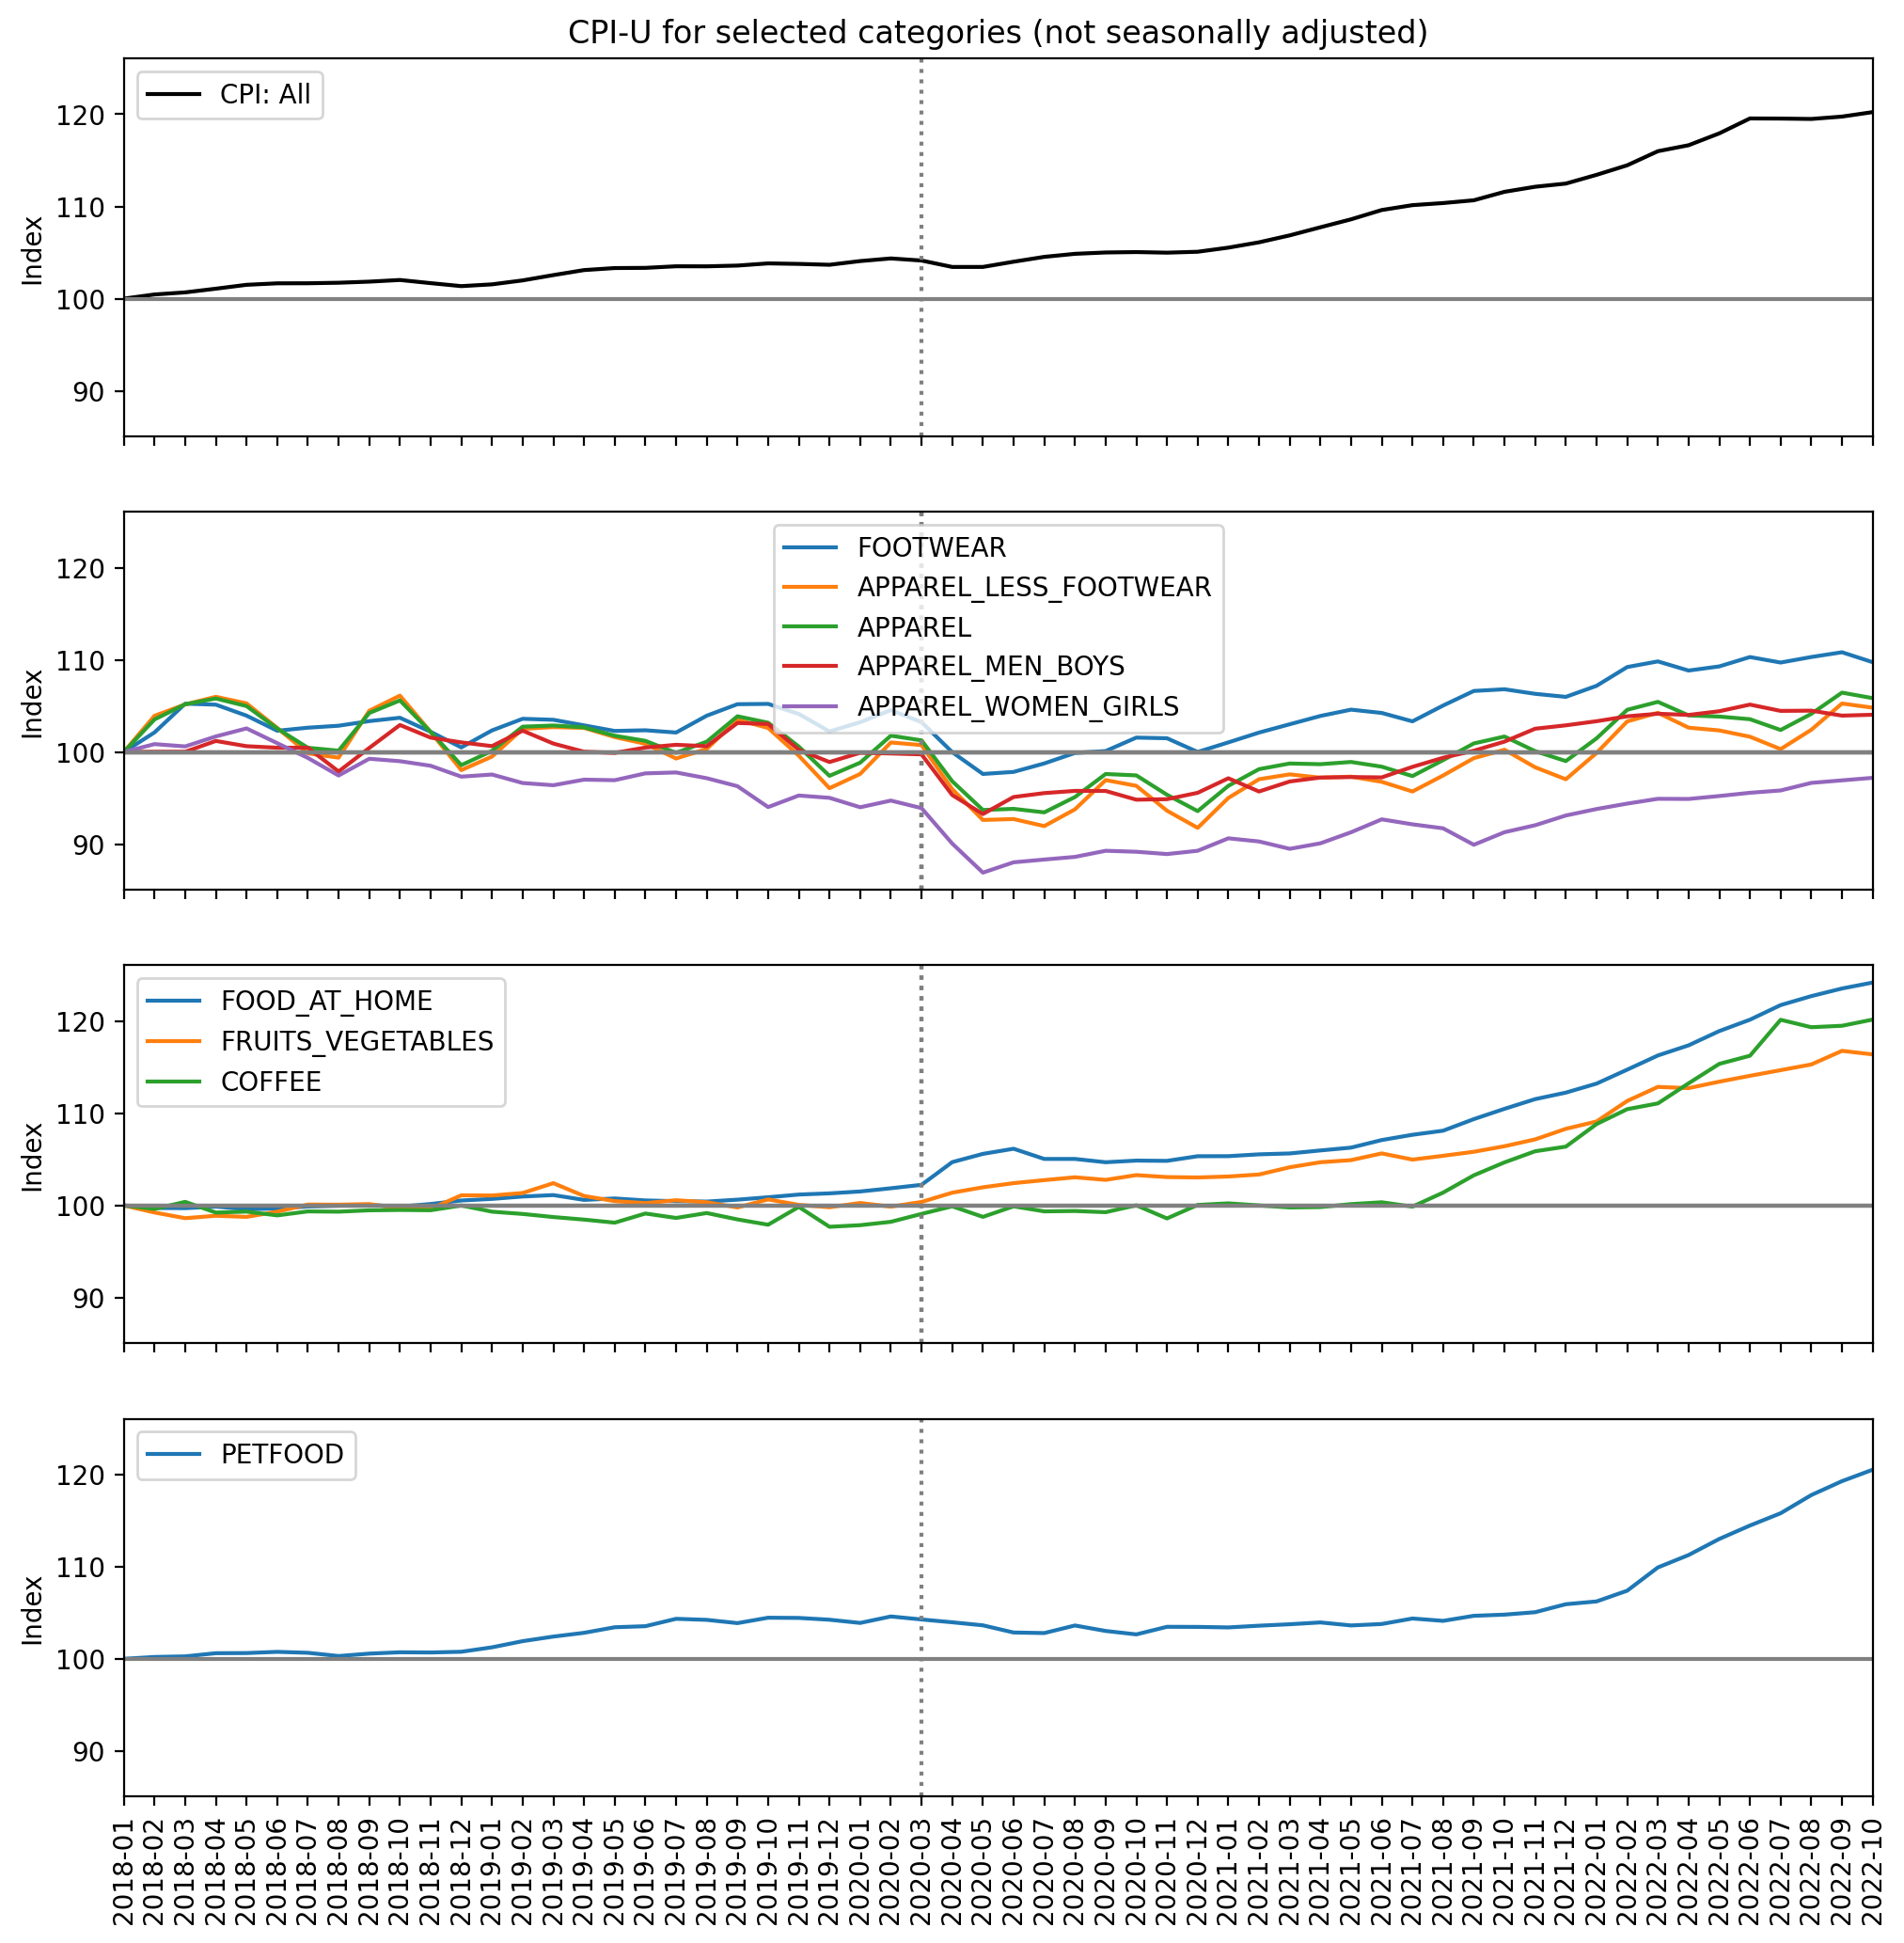

In [16]:
fig, axes = plt.subplots(4,1, figsize=(12, 3*4), sharex=True, sharey=True, dpi=200)
ax = axes[0]
ax.set_title('CPI-U for selected categories (not seasonally adjusted)')
plot_monthly_data(cpi_data['ALL'], ax=ax, show_covid=True, 
                  show_idx100=True, color='black', ylabel='Index', label='CPI: All')
ax = axes[1]
for c in ['FOOTWEAR', 'APPAREL_LESS_FOOTWEAR', 'APPAREL', 'APPAREL_MEN_BOYS', 'APPAREL_WOMEN_GIRLS']:
    plot_monthly_data(cpi_data[c], ax=ax, ylabel='Index', label=c, show_covid=True, show_idx100=True)

for i, c in enumerate(['FOOD_AT_HOME', 'FRUITS_VEGETABLES', 'COFFEE']): # ,'POTATOE']):
    plot_monthly_data(cpi_data[c], ax=axes[2], ylabel='Index', label=c, show_covid=True, show_idx100=True)
    
c = 'PETFOOD'
_ = plot_monthly_data(cpi_data[c], ax=axes[3], ylabel='Index', label=c, show_covid=True, show_idx100=True)

# plt.tight_layout()

### Time series estimation of CPI 

using SARIMAX models (initally without exogenous purchases data).

Resource: https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html


Here we do:

- Use Overall CPI as the time series to establish the following 

- Choose consistent the model specification that will be used throughout (e.g. for CPI subcategories)
    - Use entire data period
    - Use grid search and choose model with best AIC
    - Add seasonal effect if improved AIC

- Set up functions for training + one-step-ahead forecasting + evaluating error
- Set up functions for plotting


Notes
- multiplicative seasonal effect better fit than additive seasonal effect (via AIC)

Set up the data

In [9]:
cpi_model_data = cpi_data.set_index('DATE')
# Set the frequency to month begin 'MS'
cpi_model_data.index.freq = 'MS'
cpi_cat = 'ALL'
cpi_series = cpi_model_data[cpi_cat]
cpi_series.head(3)

DATE
2018-01-01    100.00000
2018-02-01    100.45347
2018-03-01    100.68061
Freq: MS, Name: ALL, dtype: float64

#### Choose model specification

In [10]:
# Grid search over possible (p,d,q) to find best model (lowest AIC)
best_aic = float('inf')
best_order = None
verbose = False
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=UserWarning)
    for p in range(0, 3):
        for d in range(0, 3):
            for q in range(0, 3):
                order = (p, d, q)
                mod = sm.tsa.statespace.SARIMAX(cpi_series, trend='c', order=order)
                res = mod.fit(disp=False)
                if res.aic < best_aic:
                    if verbose:
                        print('Improved AIC: %0.3f; order: %s' % (res.aic, order))
                    best_order = order
                    best_aic = res.aic
order = best_order
print('Best AIC: %0.3f; Order: %s' % (best_aic, order))

Best AIC: 42.143; Order: (0, 2, 2)


##### Add seasonal effect
Specify lag polynomial with lag terms for 1 and 12. 

Note we use multiplicative seasonal effect after testing addititive seasonal effect and finding it performs worse.

In [11]:
# here show additive seasonal effect:
ar = 2 # this is the maximum degree specification
ma = tuple([1] + [0]*10 + [1]) # lag polynomial specification: (1, 0, ...0, 1)
# ma = (1,0,0,1) # also tested quarterly lag -- doesn't work
mod = sm.tsa.statespace.SARIMAX(cpi_series, trend='c', order=(ar,1,ma))
res = mod.fit(disp=False)
print('AIC: %0.3f' % res.aic)
if res.aic < best_aic:
    print('Improved AIC')
    best_aic = res.aic
# print(res.summary())

AIC: 43.229


In [12]:
# multiplicative seasonal effect
seasonal_order = (1,1,0,12)
mod = sm.tsa.statespace.SARIMAX(cpi_series, trend='c', order=order, seasonal_order=seasonal_order)
res = mod.fit(disp=False)
print('AIC: %0.3f' % res.aic)
if res.aic < best_aic:
    print('Improved AIC')
    best_aic = res.aic
# print(res.summary())

AIC: 44.887


Train and make predictions.

Resource:
https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

In [13]:
def plot_pred_actual(actual, pred_mean, pred_lower95=None, pred_upper95=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    color='#ff7f0e'
    actual.plot(ax=ax, style='.', label='Actual')
    # Plot predictions
    pred_mean.plot(ax=ax, color=color, style='--', label='One-step-ahead forecast')
    if (pred_lower95 is not None) and (pred_upper95 is not None):
        ax.fill_between(pred_mean.index, pred_lower95, pred_upper95, color=color, alpha=0.1)
    # add line for COVID
    ax.axvline('2020-03-01', linestyle=':', color='gray', alpha=0.5)
    legend = ax.legend()
    return ax

def plot_errors(error_mean, lower95=None, upper95=None, ax=None, idx=None):
    if not ax:
        print('nto ax')
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    if idx is None:
        print('idx None')
        idx = error_mean.index
    # In-sample one-step-ahead predictions and 95% confidence intervals
    error_mean.reindex(idx).plot(ax=ax, label='Error')
    if (lower95 is not None) and (upper95 is not None):
        ax.fill_between(idx, lower95.reindex(idx), upper95.reindex(idx), alpha=0.1)
    # add line for COVID
    ax.axvline('2020-03-01', linestyle=':', color='gray', alpha=0.5)
    ax.hlines(0, xmin=idx[0], xmax=idx[-1], color='gray', alpha=0.5)
    legend = ax.legend();
    legend.get_frame().set_facecolor('w')
    return ax

In [14]:
def get_mae(errors):
    return np.mean(np.abs(errors)) # using mean to ignore NaN

def sarimax_train_predict_one_step_ahead(endog, pred_start='2020-01-01', pred_end=None, 
                                 exog=None, verbose=False,
                                 trend='c', order=(2,1,1), seasonal_order=(1,1,0,12)):
    """
    Trains initial model from train_start to before pred_start.
    Where train_start defaults to first date in index of endog
    Makes one-step-ahead predictions until pred_end.
    
    Retrains model after each prediction using data up to the last date/index
    of prediction in order to then predict the next data point.
    
    Returns predictions, errors, MAE
    Where: predictions and errors are both dataframes with means and 95% CIs
    """
    train_start = endog.index[0]
    initial_train_end = endog[:pred_start].index[-2]
    if not pred_end:
        pred_end = endog.index[-1]
    if verbose:
        print('initial training period: %s to %s' % (train_start, initial_train_end))
        print('prediction start, end: %s %s' % (pred_start, pred_end))
    predictions = None
    if exog is not None:
        exog = sm.add_constant(exog)
        trend = None # Will be captured by constant term
    # set initial start params to all zeros except last (sigma)
    # captures constant term in exog
    start_params = start_params = ([0]*len(exog.columns) if exog is not None else [0]) + [0]*4 + [1]
    for i, idx in enumerate(endog[initial_train_end:pred_end].index[:-1]):
        train_endog = endog[train_start:idx]
        train_exog = None if exog is None else exog[train_start:idx]
        mod = sm.tsa.statespace.SARIMAX(
            train_endog,
            exog=train_exog,
            trend=trend, order=order, seasonal_order=seasonal_order
        )
        # using start params to avoid warnings
        # using most recent start params doesn't necessarily improve fit but
        # does improve problem of no convergence -- important
        train_res = mod.fit(disp=False, start_params=start_params)#, maxiter=250)
        # get predictions with 95% CIs
        #ii = len(train_exog) + 1
        exog_i = None if exog is None else exog.iloc[len(train_exog)]
        pred_i = train_res.get_forecast(steps=1, exog=exog_i).summary_frame()
        predictions = pd.concat([predictions, pred_i])
        if verbose and (i % 12 == 0):
            print(i, idx)
            print('AIC: %0.3f'%train_res.aic)
        start_params = train_res.params

    # errors with 95% CIs
    errors = pd.DataFrame({
        'mean': predictions['mean'] - endog[pred_start:],
        'ci_lower': predictions['mean_ci_lower'] - endog[pred_start:],
        'ci_upper': predictions['mean_ci_upper'] - endog[pred_start:],
    })
    MAE = get_mae(errors['mean'])
    return predictions, errors, MAE

In [15]:
# train through first 2 years of data
predictions, errors, mae = sarimax_train_predict_one_step_ahead(
    cpi_series,
    pred_start='2020-01-01', pred_end='2022-12-01',
    verbose=True
)
print('MAE for overall CPI: %0.4f' % mae)

initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-12-01


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0 2019-12-01 00:00:00
AIC: -1.820


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12 2020-12-01 00:00:00
AIC: 14.728
24 2021-12-01 00:00:00
AIC: 29.048


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE for overall CPI: 0.3756


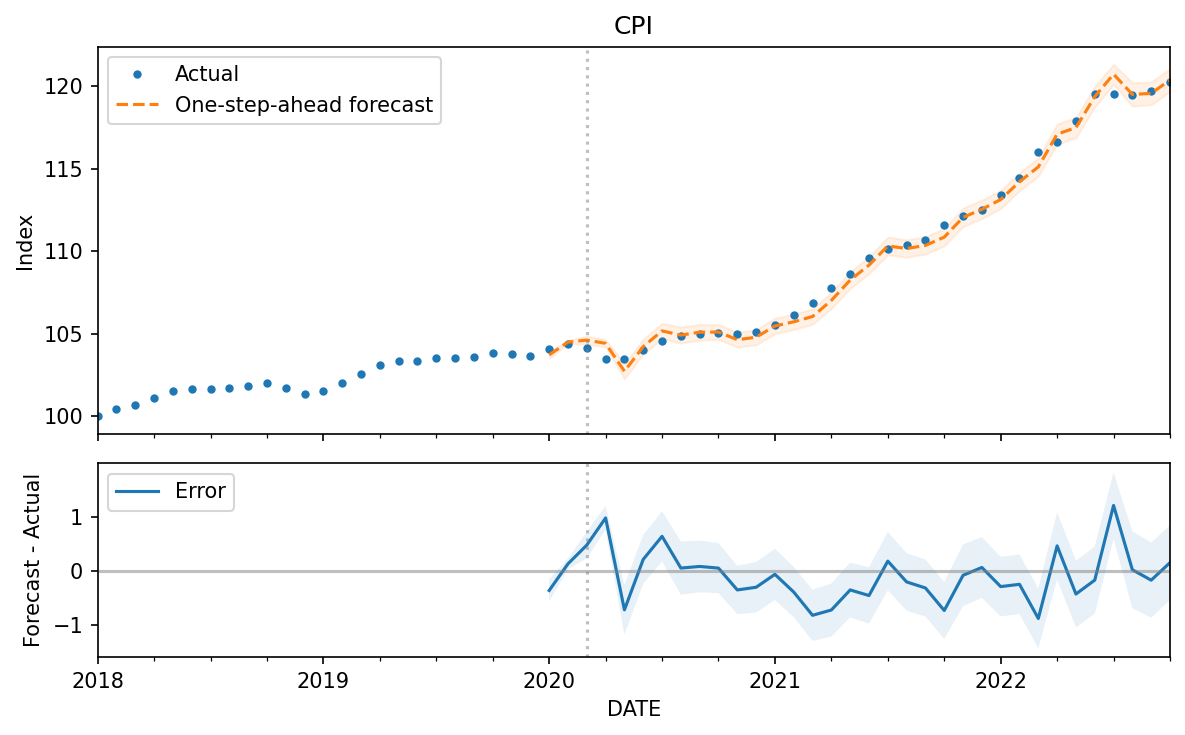

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions['mean'], predictions['mean_ci_lower'],
                       predictions['mean_ci_upper'], ax=axes[0])
ax.set(title='CPI', xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors['mean'], errors['ci_lower'], errors['ci_upper'], 
                 ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()

## Amazon purchases data

In [17]:
amzn_data_fpath = '../data/amazon-data/amazon-data-cleaned.csv'
amzn_data = pd.read_csv(amzn_data_fpath, index_col=[0])
# add year to data for convenience
amzn_data['year'] = pd.to_datetime(amzn_data['Order Date']).apply(lambda d: d.year)
# add ints for month and quarter - by first mapping yyyy-mm to month int
month_labels = {ym: i for (i, ym) in enumerate(sorted(amzn_data['yyyy-mm'].unique()), start=1)}
amzn_data['month'] = amzn_data['yyyy-mm'].map(month_labels)
# quarters: map months to quarters as month 1-3: 1, 4-6: 2, 7-9: 3, 10-12: 4, 13-15: 5, etc
amzn_data['quarter'] = amzn_data['month'].apply(lambda m: math.ceil(m/3))
print('%s total purchases from N=%s customers' % (len(amzn_data), amzn_data['Survey ResponseID'].nunique()))
# limit the data to range: 2018-01 to 2022-12
print('restricting to purchases made 2018-01 to %s' % MAX_YYYY_MM)
amzn_data = amzn_data[(amzn_data['year'] >= 2018) & (amzn_data['yyyy-mm'] <= MAX_YYYY_MM)]
print('%s total purchases from N=%s customers' % (len(amzn_data), amzn_data['Survey ResponseID'].nunique()))
# peek at it:
amzn_data.drop(['Survey ResponseID'], axis=1).head(3)

1850717 total purchases from N=5027 customers
restricting to purchases made 2018-01 to 2022-10
1737058 total purchases from N=5015 customers


Order Date Purchase Price Per Unit  Quantity Shipping Address State   
0  2018-02-21                   $7.93       1.0           RHODE ISLAND  \
1  2018-02-21                   $3.53       1.0           RHODE ISLAND   
2  2018-03-05                   $5.99       1.0           RHODE ISLAND   

                                               Title ASIN/ISBN (Product Code)   
0                 Suburban World: The Norling Photos               0873516095  \
1                                                NaN               B004S7EZR0   
2  1952 Back In The Day - 24-page Greeting Card /...               193938012X   

    Category  unit price  total price  yyyy-mm state  year  month  quarter  
0  ABIS_BOOK        7.93         7.93  2018-02    RI  2018      2        1  
1        NaN        3.53         3.53  2018-02    RI  2018      2        1  
2  ABIS_BOOK        5.99         5.99  2018-03    RI  2018      3        1

Helper functions for inspecting time series

In [18]:
# Helper function

purchases_data_cols = [
    'yyyy-mm', 'month', 'quarter',
    'Title','ASIN/ISBN (Product Code)','Category',
    'unit price', 'Quantity', 'total price',
    'Survey ResponseID',
]

def get_purchases(cats, verbose=True, year=False):
    cols = purchases_data_cols + (['year'] if year else [])
    purchases = amzn_data[
        amzn_data['Category'].isin(cats)
    ][cols]
    if verbose:
        print('%s purchases from N=%s unique customers' % (len(purchases), purchases['Survey ResponseID'].nunique()))
    return purchases

def get_monthly_series(purchases):
    """Returns df with monthly: 
    - total purchases
    - unique products being purchased
    - purchasers: unique people making purchases
    - median price
    """
    monthly_s = purchases.groupby('yyyy-mm')[
        'ASIN/ISBN (Product Code)'
    ].agg(['count','nunique']).rename(columns={
        'count': 'total purchases',
        'nunique': 'unique products'
    }).reindex(amzn_data_idx)
    monthly_s['purchasers'] = purchases.groupby('yyyy-mm')[
        'Survey ResponseID'
    ].nunique().reindex(amzn_data_idx)
    monthly_s['med price'] = purchases.groupby('yyyy-mm')[
        'unit price'
    ].agg('median').reindex(amzn_data_idx)
    return monthly_s

In [19]:
# helper function to find products
def is_maybe_product_match(row, cat_require=None, title_require_keywords=None, title_exclude_keywords=None):
    """
    cat_require: List of categories s.t. product must match one
    title_require_keywords: List of keywords s.t. title must contain at least one
    title_exclude_keywords: List of keywords s.t. title cannot include any
    """
    cat = str(row['Category'])
    if (cat_require is not None) and (cat not in cat_require):
        return False
    title = str(row['Title']).lower()
    if (title_exclude_keywords is not None) and any([kw.lower() in title for kw in title_exclude_keywords]):
        return False
    if title_require_keywords is None or any([kw.lower() in title for kw in title_require_keywords]):
        return True
    return False

Remove gift cards

exclude by 
- category GIFT_CARD
- title indicating gift card/code: amazon reload, gift code, etc

(Not all gift cards/codes have category GIFT_CARD)

In [20]:
def is_gift_code(row):
    cat = str(row['Category'])
    if cat in ['GIFT_CARD']:
        return True
    title = str(row['Title']).lower()
    if ('gift code' in title) or ('gift card' in title) or ('digital code' in title):
        return True
    if ('amazon reload' in title):
        return True
    return False

gift_card_purchases = amzn_data[amzn_data.apply(is_gift_code, axis=1)]
print('Dropping %s gift card/code purchases' % len(gift_card_purchases))
amzn_data = amzn_data[~amzn_data.apply(is_gift_code, axis=1)]
print('%s total purchases from N=%s customers' % (len(amzn_data), amzn_data['Survey ResponseID'].nunique()))

Dropping 40368 gift card/code purchases
1696690 total purchases from N=5014 customers


I also looked through purchases with 'registry' in the title. The only item worth attending to is B00N1NBOV2 Baby Registry Welcome Box: In grocery category.

In [21]:
# should we discard registry related items?
# B00N1NBOV2 Baby Registry Welcome Box: In grocery category.
def is_maybe_registry_item(row):
    return is_maybe_product_match(row, title_require_keywords=['registry'])

registry_related_purchases = amzn_data[amzn_data.apply(is_maybe_registry_item, axis=1)]

In [22]:
print("%s maybe registry related purchases with %s distinct products from N=%s unique purchasers" % (
    len(registry_related_purchases), 
    registry_related_purchases['ASIN/ISBN (Product Code)'].nunique(),
    registry_related_purchases['Survey ResponseID'].nunique()))
registry_related_purchases.groupby(
    ['ASIN/ISBN (Product Code)', 'Title', 'Category']
)['Survey ResponseID'].agg(['count','nunique']).sort_values('nunique', ascending=False).head(3)

530 maybe registry related purchases with 167 distinct products from N=343 unique purchasers


count   
ASIN/ISBN (Product Code) Title                                              Category              
B00N1NBOV2               Baby Registry Welcome Box                          GROCERY         224  \
B07CYRYX3R               Nanobebe Baby Pacifiers 0-3 Month - Orthodontic... PACIFIER          9   
B07PF3B1K5               Bamboo Baby Washcloths - 2 Layer Soft Absorbent... BABY_PRODUCT     11   

                                                                                          nunique  
ASIN/ISBN (Product Code) Title                                              Category               
B00N1NBOV2               Baby Registry Welcome Box                          GROCERY           193  
B07CYRYX3R               Nanobebe Baby Pacifiers 0-3 Month - Orthodontic... PACIFIER            9  
B07PF3B1K5               Bamboo Baby Washcloths - 2 Layer Soft Absorbent... BABY_PRODUCT        8

In [23]:
print('dropping %s baby registry purchases' % (amzn_data['ASIN/ISBN (Product Code)']=='B00N1NBOV2').sum())
amzn_data = amzn_data[amzn_data['ASIN/ISBN (Product Code)']!='B00N1NBOV2']
print('%s total purchases from N=%s customers' % (len(amzn_data), amzn_data['Survey ResponseID'].nunique()))
# peek at it:
amzn_data.drop(['Survey ResponseID'], axis=1).head(3)

dropping 224 baby registry purchases
1696466 total purchases from N=5014 customers


Order Date Purchase Price Per Unit  Quantity Shipping Address State   
0  2018-02-21                   $7.93       1.0           RHODE ISLAND  \
1  2018-02-21                   $3.53       1.0           RHODE ISLAND   
2  2018-03-05                   $5.99       1.0           RHODE ISLAND   

                                               Title ASIN/ISBN (Product Code)   
0                 Suburban World: The Norling Photos               0873516095  \
1                                                NaN               B004S7EZR0   
2  1952 Back In The Day - 24-page Greeting Card /...               193938012X   

    Category  unit price  total price  yyyy-mm state  year  month  quarter  
0  ABIS_BOOK        7.93         7.93  2018-02    RI  2018      2        1  
1        NaN        3.53         3.53  2018-02    RI  2018      2        1  
2  ABIS_BOOK        5.99         5.99  2018-03    RI  2018      3        1

In [24]:
amzn_data_idx = sorted(amzn_data['yyyy-mm'].unique())

---

## Aggregate metrics and CPI


Develop aggregate metrics (for specific categories)

- totalSpend_m: Monthly total spend (sum over quantity)
- purchasers_m: monthly unique purchasers
- purchases_m: monthly purchases
- avgSpend_m: Monthly total spend / unique purchasers

$spend_{m,i}$
- Track user specific monthly spend
- Track monthly change in monthly spend
- Aggregate metric: median change in monthly spend
- Attach to demographic variables

Basic exploration of which are most correlated:
		
- $CPI_m = m + totalSpend_m + purchasers_m + purchases_m + avgSpend_m$

- $spend_{m,i} = m + CPI_m + [demoVars]_m + [demo_Vars]_m : CPI_m + responseId_i$


In [25]:
def get_monthly_aggregate_metrics(purchases, cpi=cpi_data['ALL']):
    df = pd.DataFrame({
        'yyyy-mm': amzn_data_idx,
        'month': sorted(list(month_labels.values())[:len(amzn_data_idx)]),
        'CPI': cpi,
        'CPI_lag_1m': cpi.shift(-1),
        'totalSpend': purchases.groupby('yyyy-mm')['total price'].sum(),
        'purchases': purchases.groupby('yyyy-mm')['Survey ResponseID'].count(),
        'purchasers': purchases.groupby('yyyy-mm')['Survey ResponseID'].nunique(),
        'avgSpend': purchases.groupby('yyyy-mm')['total price'].sum() / purchases.groupby('yyyy-mm')['Survey ResponseID'].count(),
        # Note that the mean and median only include the people making purchases that month
        'meanSpend': purchases.groupby(
            ['yyyy-mm', 'Survey ResponseID']
        )['total price'].sum().reset_index('yyyy-mm').groupby('yyyy-mm')['total price'].mean(),
        'medianSpend': purchases.groupby(
            ['yyyy-mm', 'Survey ResponseID']
        )['total price'].sum().reset_index('yyyy-mm').groupby('yyyy-mm')['total price'].median(),
    }).set_index('yyyy-mm')
    return df

In [26]:
agg_metrics = get_monthly_aggregate_metrics(amzn_data)
agg_metrics.head()

month        CPI  CPI_lag_1m  totalSpend  purchases  purchasers   
yyyy-mm                                                                    
2018-01      1  100.00000   100.45347   420877.17      18073        2586  \
2018-02      2  100.45347   100.68061   369978.31      15623        2427   
2018-03      3  100.68061   101.08082   400148.58      17090        2484   
2018-04      4  101.08082   101.50121   366601.90      15839        2427   
2018-05      5  101.50121   101.66299   402070.12      16721        2510   

          avgSpend   meanSpend  medianSpend  
yyyy-mm                                      
2018-01  23.287621  162.752193       87.705  
2018-02  23.681643  152.442649       82.070  
2018-03  23.414194  161.090411       86.005  
2018-04  23.145521  151.051463       83.870  
2018-05  24.045818  160.187299       86.495

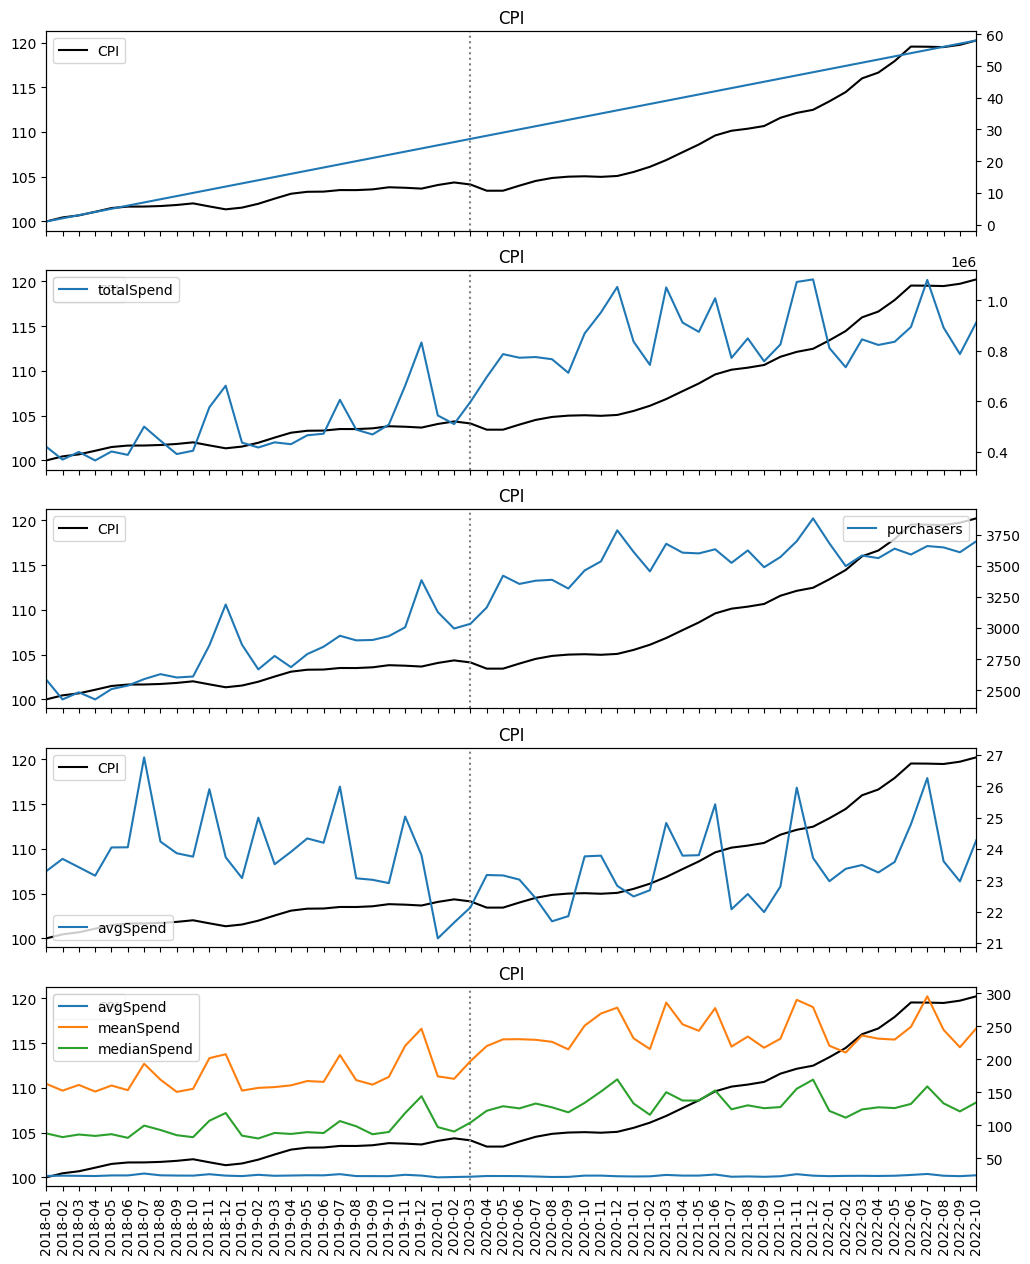

In [27]:
cpi_cat = 'ALL'
fig, axes = plt.subplots(5,1, figsize=(12, 5*3), sharex=True)

ax = axes[0]
ax.set_title('Overall CPI')
plot_monthly_data(agg_metrics['CPI'], ax=ax, title='CPI', label='CPI', show_covid=True, color='black')
ax = ax.twinx()
plot_monthly_data(agg_metrics['month'], ax=ax)
ax = axes[1]
plot_monthly_data(agg_metrics['CPI'], ax=ax, title='CPI', label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'totalSpend'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[2]
plot_monthly_data(agg_metrics['CPI'], ax=ax, title='CPI', label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'purchasers'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[3]
plot_monthly_data(agg_metrics['CPI'], ax=ax, title='CPI', label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'avgSpend'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[4]
plot_monthly_data(agg_metrics['CPI'], ax=ax, title='CPI', label='CPI', show_covid=True, color='black')
ax = ax.twinx()
for c in ['avgSpend','meanSpend','medianSpend']:
    plot_monthly_data(agg_metrics[c], ax=ax, label=c)

In [28]:
# smooth the metrics except CPI data
for c in ['avgSpend','meanSpend','medianSpend', 'totalSpend','purchasers']:
    agg_metrics['%s_smoothed'%c] = agg_metrics[c].rolling(3, min_periods=1).mean()
agg_metrics.index = cpi_model_data.index
cpi_series = agg_metrics['CPI']
agg_metrics.head(3)

month        CPI  CPI_lag_1m  totalSpend  purchases  purchasers   
DATE                                                                          
2018-01-01      1  100.00000   100.45347   420877.17      18073        2586  \
2018-02-01      2  100.45347   100.68061   369978.31      15623        2427   
2018-03-01      3  100.68061   101.08082   400148.58      17090        2484   

             avgSpend   meanSpend  medianSpend  avgSpend_smoothed   
DATE                                                                
2018-01-01  23.287621  162.752193       87.705          23.287621  \
2018-02-01  23.681643  152.442649       82.070          23.484632   
2018-03-01  23.414194  161.090411       86.005          23.461153   

            meanSpend_smoothed  medianSpend_smoothed  totalSpend_smoothed   
DATE                                                                        
2018-01-01          162.752193               87.7050        420877.170000  \
2018-02-01          157.597421               84.8875        395427.740000   
2018-03-01          158.761751               85.2600        397001.353333   

            purchasers_smoothed  
DATE                             
2018-01-01               2586.0  
2018-02-01               2506.5  
2018-03-01               2499.0

---

### CPI prediction with aggregate purchases data

Forcasting using OLS model

In [29]:
def train_predict_one_step_ahead_ols(data, formula, pred_start='2020-01-01', pred_end=None, 
                                     verbose=False):
    """
    Trains initial model from train_start to before pred_start.
    Where train_start defaults to first date in index of data
    Makes one-step-ahead predictions until pred_end or last index of data.
    
    Retrains model after each prediction using data up to the last date/index
    of prediction in order to then predict the next data point.
    
    Returns predictions, errors, MAE
    """
    train_start = data.index[0]
    initial_train_end = data[:pred_start].index[-2]
    if not pred_end:
        pred_end = data.index[-1]
    if verbose:
        print('initial training period: %s to %s' % (train_start, initial_train_end))
        print('prediction start, end: %s %s' % (pred_start, pred_end))
        print('Formula:\n%s\n' % formula)
    predictions = None
    train_res = None
    for i, idx in enumerate(data[initial_train_end:pred_end].index[:-1]):
        train_data = data[train_start:idx]
        train_res = ols(formula=formula, data=train_data).fit() # Note start params did not improve performance
        # get prediction
        x_i = data.iloc[len(train_data)]
        pred_i = train_res.predict(x_i) # a one-element series
        predictions = pd.concat([predictions, pred_i])
        if verbose and (i % 12 == 0):
            print(i, idx)
            print('AIC: %0.3f'%train_res.aic)
    # errors
    errors = predictions - data['CPI'][pred_start:]
    MAE = get_mae(errors)
    return predictions, errors, MAE, train_res

Basic OLS

- month R2: 0.852
- R2 improves with smoothed data

In [86]:
# formula = 'CPI ~ month'
formula = 'CPI ~ month + purchasers_smoothed + avgSpend_smoothed' # best
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=agg_metrics).fit()
display(result.summary())

Formula:
CPI ~ month + purchasers_smoothed + avgSpend_smoothed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     355.4
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           1.61e-35
Time:                        14:20:43   Log-Likelihood:                -96.785
No. Observations:                  58   AIC:                             201.6
Df Residuals:                      54   BIC:                             209.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             105.3346      7.416     14.204      0.000      90.467     120.202
month                   0.6327      0.036     17.600      0.000       0.561       0.705
purchasers_smoothed    -0.0126      0.001     -8.761      0.000      -0.016      -0.010
avgSpend_smoothed       0.9766      0.232      4.208      0.000       0.511       1.442
==============================================================================
Omnibus:                        3.033   Durbin-Watson:                   0.396
Prob(Omnibus):                  0.219   Jarque-Bera (JB):                2.188
Skew:                           0.444   Prob(JB):                        0.335
Kurtosis:                       3.340   Cond. No.                     1.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [87]:
print('OLS predictions')
predictions, errors, mae, train_res = train_predict_one_step_ahead_ols(
    agg_metrics, formula, 
    pred_start='2020-01-01',
    verbose=True,
)
print('MAE %0.4f' % mae)
train_res.summary()

OLS predictions
initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-10-01 00:00:00
Formula:
CPI ~ month + purchasers_smoothed + avgSpend_smoothed

0 2019-12-01 00:00:00
AIC: -27.109
12 2020-12-01 00:00:00
AIC: 25.652
24 2021-12-01 00:00:00
AIC: 141.163
MAE 1.5002


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     321.7
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           5.56e-34
Time:                        14:20:43   Log-Likelihood:                -95.038
No. Observations:                  57   AIC:                             198.1
Df Residuals:                      53   BIC:                             206.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             104.3100      7.476     13.953      0.000      89.316     119.304
month                   0.6215      0.038     16.560      0.000       0.546       0.697
purchasers_smoothed    -0.0123      0.001     -8.278      0.000      -0.015      -0.009
avgSpend_smoothed       0.9843      0.232      4.241      0.000       0.519       1.450
==============================================================================
Omnibus:                        2.911   Durbin-Watson:                   0.386
Prob(Omnibus):                  0.233   Jarque-Bera (JB):                2.147
Skew:                           0.458   Prob(JB):                        0.342
Kurtosis:                       3.251   Cond. No.                     1.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MAE for ALL CPI: 1.5002


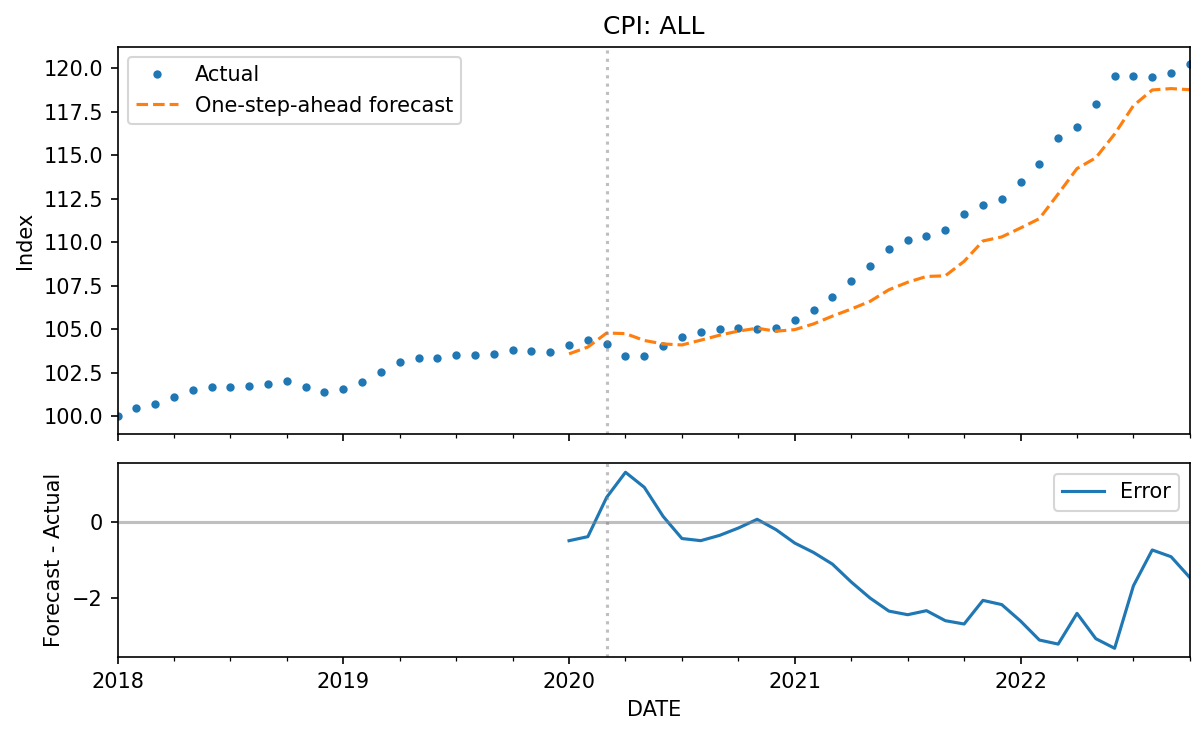

In [88]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions, ax=axes[0])
ax.set(title='CPI: %s'%cpi_cat, xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors, ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

SARIMAX

In [89]:
exog_vars = ['purchasers_smoothed', 'avgSpend_smoothed']
exog = agg_metrics[exog_vars]
exog.head()

purchasers_smoothed  avgSpend_smoothed
DATE                                              
2018-01-01          2586.000000          23.287621
2018-02-01          2506.500000          23.484632
2018-03-01          2499.000000          23.461153
2018-04-01          2446.000000          23.413786
2018-05-01          2473.666667          23.535178

In [90]:
print('CPI: %s' % cpi_cat)
# train through first 2 years of data
predictions, errors, mae = sarimax_train_predict_one_step_ahead(
    cpi_series, 
    exog=exog,
    pred_start='2020-01-01', pred_end='2022-12-01',
    verbose=True
)
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

CPI: ALL
initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-12-01
0 2019-12-01 00:00:00
AIC: -1.130


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

12 2020-12-01 00:00:00
AIC: 14.286


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

24 2021-12-01 00:00:00
AIC: 26.945


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

MAE for ALL CPI: 0.3993


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE for ALL CPI: 0.3993


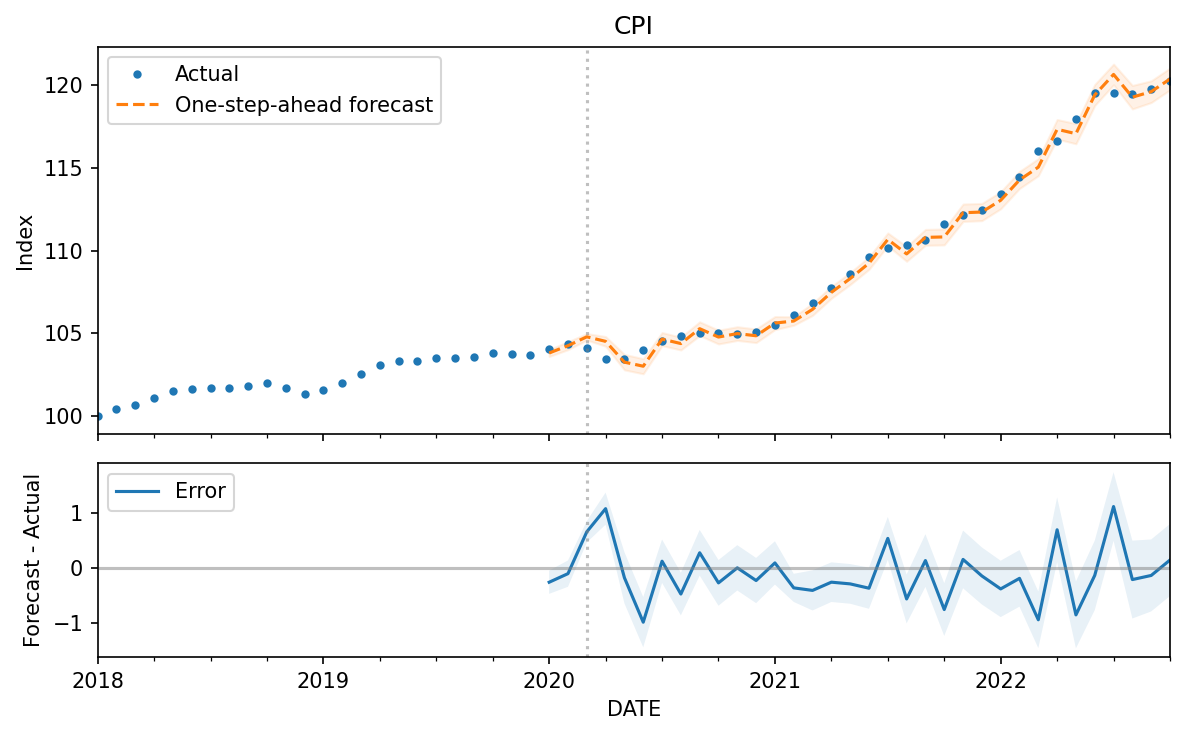

In [91]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions['mean'], predictions['mean_ci_lower'],
                       predictions['mean_ci_upper'], ax=axes[0])
ax.set(title='CPI', xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors['mean'], errors['ci_lower'], errors['ci_upper'], 
                 ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

## Stratified sampling

Set up stratified sampling. To see if this impacts metrics and correlations

First we load in census data for categories upon which we stratify.

Then we test stratifying on different categories/levels. We also demonstrate why stratifying is necessary by showing the bias in the data.


### Sampling frame set up
Since we want to stratify on age and gender, make table mapping ResponseId to these categories. This will serve as the sampling frame.

```
ResponseId, age, gender, age x gender
```

When using gender, limit to gender binary Male/Female to match with census data.

Also collapse age groups from 6 to 3 groups because otherwise the strata sizes are very small due to limited sample of 65+ participants.

(all) non-collapsed age groups:
- 18 - 24 years
- 25 - 34 years
- 35 - 44 years
- 45 - 54 years
- 55 - 64 years
- 65 and older

collapsed age groups -- use these
- 18 - 34 years
- 35 - 54 years
- 55 and older
- 55 and older

### Survey data

Set up survey data.

Drop rows for ResponseIds that do not have Amazon data.

Map answers for number of Amazon users and household (hh) size to numeric values.

Note limitation: Answers for 4+ are mapped to 4.

In [147]:
# Read in survey data
# Want the ResponseId, state, 
# and also some demographic data in order to evaluate representativeness, stratify, or further analyze
survey_data_fpath = '../data/survey-data/survey.csv'
survey_df = pd.read_csv(survey_data_fpath,  usecols=[
    'ResponseId', 'Q-demos-state', 
    'Q-demos-gender', 'q-demos-age', 'Q-demos-education', 'Q-demos-hispanic', 'Q-demos-race',
    'Q-amazon-use-howmany', 'Q-amazon-use-hh-size',
]).set_index('ResponseId').rename(columns={
    # rename columns for easier use in regression analyses later
    'q-demos-age':'age', 
    'Q-demos-hispanic':'hispanic',
    'Q-demos-race':'race', 
    'Q-demos-education':'education', 
    'Q-demos-gender':'gender', 
    'Q-demos-state':'state',
    'Q-amazon-use-howmany': 'accnt_users',
    'Q-amazon-use-hh-size': 'hh_size',
})
numeric_map = {'1 (just me!)': 1, '2':2, '3':3, '4+':4}
survey_df['accnt_users'] = survey_df['accnt_users'].map(numeric_map)
survey_df['hh_size'] = survey_df['hh_size'].map(numeric_map)
# Drop rows without Amazon data
response_ids = amzn_data['Survey ResponseID'].unique()
print('%s/%s of survey participants with Amazon data. Restricting survey data to participants with Amazon data.' % (
    len(response_ids), len(survey_df)))
survey_df = survey_df.loc[response_ids]
survey_df.head(2)

5014/6325 of survey participants with Amazon data. Restricting survey data to participants with Amazon data.


age hispanic                       race   
ResponseId                                                             
R_3I9Pu8iauEcOx9A  35 - 44 years       No         White or Caucasian  \
R_7UtikIBqeQHvnyN  25 - 34 years       No  Black or African American   

                                    education  gender         state   
ResponseId                                                            
R_3I9Pu8iauEcOx9A           Bachelor's degree    Male  Rhode Island  \
R_7UtikIBqeQHvnyN  High school diploma or GED  Female       Alabama   

                   accnt_users  hh_size  
ResponseId                               
R_3I9Pu8iauEcOx9A            1        2  
R_7UtikIBqeQHvnyN            1        2

In [148]:
collapse_age_map = {
    '18 - 24 years': '18 - 34 years',
    '25 - 34 years': '18 - 34 years',
    '35 - 44 years': '35 - 54 years',
    '45 - 54 years': '35 - 54 years',
    '55 - 64 years': '55 and older',
    '65 and older': '55 and older',
}

def get_sampling_frame(df=survey_df, collapse_age=True, use_sex=True):
    sampling_frame = df.copy()
    if collapse_age:
        sampling_frame['age'] = sampling_frame['age'].map(collapse_age_map)
    if use_sex:
        sampling_frame = sampling_frame[sampling_frame['gender'].isin(['Male','Female'])].rename(columns={'gender':'sex'})
        sampling_frame['age x sex'] = sampling_frame.apply(lambda r: ('%s x %s') % (r['age'], r['sex']), axis=1)
    return sampling_frame[['age'] + (['sex', 'age x sex'] if use_sex else [])]


In [149]:
get_sampling_frame().head(3)

age     sex               age x sex
ResponseId                                                      
R_3I9Pu8iauEcOx9A  35 - 54 years    Male    35 - 54 years x Male
R_7UtikIBqeQHvnyN  18 - 34 years  Female  18 - 34 years x Female
R_2PpVNZupgA2k9mX  18 - 34 years  Female  18 - 34 years x Female

### Stratifying on age and gender

Using Census data:

> Annual Estimates of the Resident Population by Single Year of Age and Sex for the United States: April 1, 2020 to July 1, 2022 (NC-EST2022-AGESEX-RES)

About the data: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2020-2022/NC-EST2022-AGESEX-RES.pdf

The key for SEX is as follows:

- 0 = Total
- 1 = Male
- 2 = Female

AGE is single-year of age (0, 1, 2, . . ., 99, 100+ years) and 999 is used to indicate total population. (i.e. AGE=100 includes 100+)

When setting up strata, we limit to 18+

Note: Based on data from 2015-2019 it doesn't look like there is a large difference in domestic migration for Male vs Female: https://www.census.gov/content/dam/Census/library/publications/2022/demo/p23-218.pdf

In [150]:
census_age_sex_df = pd.read_csv(census_data_dir + 'age-by-sex-2022-est.csv').rename(
    columns={'POPESTIMATE2022': 'N'}
)
census_age_sex_df.head(3)

SEX  AGE        N
0    0    0  3683113
1    0    1  3588817
2    0    2  3693362

In [151]:
# drop total and anyone under 18 (recalculate totals with 18+)
print('census N=%s with age < 18; we drop them' % census_age_sex_df[(census_age_sex_df['SEX']==0) & (census_age_sex_df['AGE']<18)]['N'].sum())
census_age_sex_df = census_age_sex_df[
    (census_age_sex_df['AGE'] >= 18) & (census_age_sex_df['AGE'] <= 100)
]
# census_age_sex_df

census N=72450827 with age < 18; we drop them


In [152]:
def set_proportions_and_bias(df, roundto=3):
    """
    Adds columns for census proportion, survey proportion, bias
    Expects dataframe (df) with columns 'census N', 'survey N'
    Returns updated df
    """
    df['census proportion'] = round(df['census N']/df['census N'].sum(), roundto)
    df['survey proportion'] = round(df['survey N']/df['survey N'].sum(), roundto)
    df['bias'] = df['survey proportion'] - df['census proportion']
    return df

# Plots to compare survey vs census data

def plot_bias(df, ax=None, title=None):
    if ax is None:
        fig,ax = plt.subplots()
    df['bias'].plot(kind='barh')
    ax.set_xlabel('Bias')
    return ax

def plot_census_vs_survey_pops(df, ax=None, title=None):
    if ax is None:
        fig,ax = plt.subplots()
    width = 0.4
    (df['census proportion']
     .plot(
        kind='barh', color='lightgray', edgecolor='black', #hatch='//',
        label='census',
        ax=ax, width=width, position=1
    ))
    (df['survey proportion']
     .plot(
        kind='barh', color='black',
        label='survey',
        ax=ax, width=width, position=0)
    )
    ax.legend()
    ax.set_xlabel('proportion')
    if title:
        ax.set_title(title)
    return ax

Initially just use age, without sex

In [153]:
census_age_df = census_age_sex_df[census_age_sex_df['SEX']==0].drop('SEX', axis=1)
census_age_df.head(3)

AGE        N
18   18  4326642
19   19  4295710
20   20  4438006

Our sampling frame without stratification compared to census data:


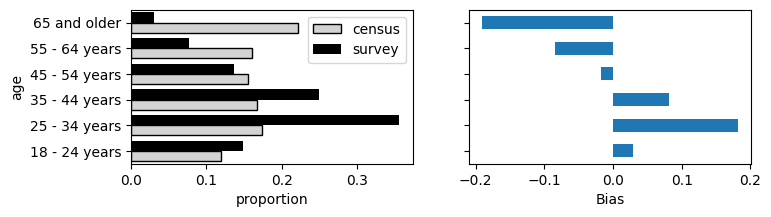

survey N  census N  census proportion  survey proportion   bias
age                                                                           
18 - 24 years       727  31328131              0.120              0.149  0.029
25 - 34 years      1741  45501300              0.174              0.356  0.182
35 - 44 years      1222  43695365              0.168              0.250  0.082
45 - 54 years       670  40431645              0.155              0.137 -0.018
55 - 64 years       374  42085437              0.161              0.077 -0.084
65 and older        153  57794852              0.222              0.031 -0.191

In [154]:
print('Our sampling frame without stratification compared to census data:')
sampling_frame = get_sampling_frame(collapse_age=False)
age_nocollapse_df = sampling_frame['age'].value_counts().sort_index().rename('survey N').to_frame()
# Aggregate census data to age groups matching survey data
age_nocollapse_df['census N'] = [
    census_age_df[census_age_df['AGE'].isin(range(18,25))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(25,35))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(35,45))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(45,55))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(55,65))]['N'].sum(),
    census_age_df[census_age_df['AGE'] >= 65]['N'].sum(),
]
age_nocollapse_df = set_proportions_and_bias(age_nocollapse_df)
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2), sharey=True)
plot_census_vs_survey_pops(age_nocollapse_df, ax=ax1)
plot_bias(age_nocollapse_df, ax=ax2)
plt.show()
age_nocollapse_df

When collapsing age groups to 3 groups

Our sampling frame without stratification compared to census data:


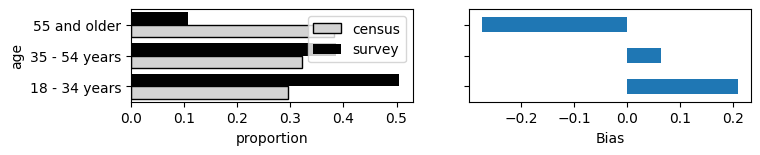

survey N  census N  census proportion  survey proportion   bias
age                                                                           
18 - 34 years      2468  76829431              0.295              0.505  0.210
35 - 54 years      1892  84127010              0.323              0.387  0.064
55 and older        527  99880289              0.383              0.108 -0.275

In [155]:
print('Our sampling frame without stratification compared to census data:')
sampling_frame = get_sampling_frame(collapse_age=True)
age_df = sampling_frame['age'].value_counts().sort_index().rename('survey N').to_frame()
# Aggregate census data to age groups matching survey data
age_df['census N'] = [
    census_age_df[census_age_df['AGE'].isin(range(18,35))]['N'].sum(),
    census_age_df[census_age_df['AGE'].isin(range(35,55))]['N'].sum(),
    census_age_df[census_age_df['AGE'] >= 55]['N'].sum(),
]
age_df = set_proportions_and_bias(age_df)
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 1.2), sharey=True)
plot_census_vs_survey_pops(age_df, ax=ax1)
plot_bias(age_df, ax=ax2)
plt.show()
age_df

In [156]:
def get_stratified_sample(stratify_by_df, sampling_frame, stratify_col='age', verbose=True):
    assert(round(stratify_by_df['census proportion'].sum()) == 1)
    assert(round(stratify_by_df['survey proportion'].sum()) == 1)
    # use the stratum most underrepresented in order to define strata sizes
    min_strata = (stratify_by_df['survey proportion']/stratify_by_df['census proportion']).idxmin()
    max_N = stratify_by_df['survey N'][min_strata]
    if verbose:
        print('using most underrepresented stratum to define strata sizes: %s; max N=%s' % (min_strata, max_N))
    stratify_N = round(
        (stratify_by_df['census N']/stratify_by_df['census N'][min_strata])*max_N
    ).astype(int)
    if verbose:
        print('sampling for N:')
        display(stratify_N)
    stratified_sample_df = pd.DataFrame(columns=sampling_frame.columns)
    for i, N in enumerate(stratify_N):
        strata = stratify_N.index[i]
        sampled_df = sampling_frame[
            sampling_frame[stratify_col] == strata
        ].sample(replace=False, n=N)
        stratified_sample_df = pd.concat([stratified_sample_df, sampled_df])
    return stratified_sample_df

In [157]:
sampling_frame = get_sampling_frame(collapse_age=True)
stratified_sample_df = get_stratified_sample(age_df, sampling_frame, stratify_col='age')
print('total sample size n=%s' % len(stratified_sample_df))
stratified_sample_df.head()

using most underrepresented stratum to define strata sizes: 55 and older; max N=527
sampling for N:


age
18 - 34 years    405
35 - 54 years    444
55 and older     527
Name: census N, dtype: int64

total sample size n=1376


age     sex               age x sex
R_2EBrYkcmnTSuO46  18 - 34 years    Male    18 - 34 years x Male
R_12AB3KkLYxo0JrO  18 - 34 years    Male    18 - 34 years x Male
R_3DdxQK745EEWMzm  18 - 34 years    Male    18 - 34 years x Male
R_6X3q4ykD7atEx1L  18 - 34 years  Female  18 - 34 years x Female
R_2tbqMx9jeyHq0EW  18 - 34 years  Female  18 - 34 years x Female

### Age x sex

Using Age x sex vs just age slightly reduces sample size vs using just sex.

Our sampling frame without stratification compared to census data:


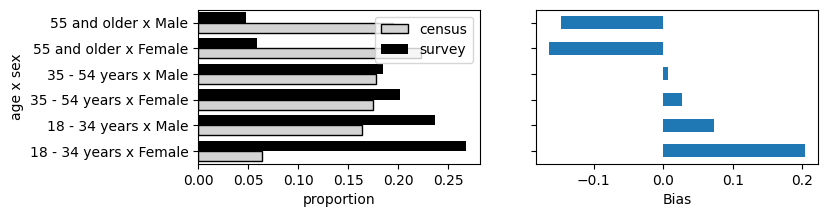

survey N  census N  census proportion   
age x sex                                                       
18 - 34 years x Female      1309  15309475              0.064  \
18 - 34 years x Male        1159  39208218              0.164   
35 - 54 years x Female       987  41727191              0.175   
35 - 54 years x Male         905  42399819              0.178   
55 and older x Female        290  53279042              0.223   
55 and older x Male          237  46601247              0.195   

                        survey proportion   bias  
age x sex                                         
18 - 34 years x Female              0.268  0.204  
18 - 34 years x Male                0.237  0.073  
35 - 54 years x Female              0.202  0.027  
35 - 54 years x Male                0.185  0.007  
55 and older x Female               0.059 -0.164  
55 and older x Male                 0.048 -0.147

In [158]:
print('Our sampling frame without stratification compared to census data:')
sampling_frame = get_sampling_frame(collapse_age=True, use_sex=True)
age_sex_df = sampling_frame['age x sex'].value_counts().sort_index().rename('survey N').to_frame()
# Aggregate census data to age groups matching survey data
age_sex_df['census N'] = [
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(18,35))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(18,35))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & census_age_sex_df['AGE'].isin(range(35,55))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & census_age_sex_df['AGE'].isin(range(35,55))]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==2) & (census_age_sex_df['AGE'] >= 55)]['N'].sum(),
    census_age_sex_df[(census_age_sex_df['SEX']==1) & (census_age_sex_df['AGE'] >= 55)]['N'].sum(),
]
age_sex_df = set_proportions_and_bias(age_sex_df)
# plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 2), sharey=True)
plot_census_vs_survey_pops(age_sex_df, ax=ax1)
plot_bias(age_sex_df, ax=ax2)
plt.show()
age_sex_df

In [159]:
sampling_frame_age_sex = get_sampling_frame(collapse_age=True, use_sex=True)
stratified_sample_df = get_stratified_sample(age_sex_df, sampling_frame_age_sex, stratify_col='age x sex')
print('total sample size n=%s' % len(stratified_sample_df))

using most underrepresented stratum to define strata sizes: 55 and older x Male; max N=237
sampling for N:


age x sex
18 - 34 years x Female     78
18 - 34 years x Male      199
35 - 54 years x Female    212
35 - 54 years x Male      216
55 and older x Female     271
55 and older x Male       237
Name: census N, dtype: int64

total sample size n=1213


In [160]:
stratified_sample_df.head()

age     sex               age x sex
R_3F4cWjtxeQOW5r7  18 - 34 years  Female  18 - 34 years x Female
R_3h9L8YKiEqpP51c  18 - 34 years  Female  18 - 34 years x Female
R_2YPn3BGBQEYnIRt  18 - 34 years  Female  18 - 34 years x Female
R_3exlTi02vMuoy59  18 - 34 years  Female  18 - 34 years x Female
R_PTZ3QbtCJTTGaEF  18 - 34 years  Female  18 - 34 years x Female

In [161]:
# purchases = amzn_data
# restrict purchases to stratified sample
purchases = amzn_data[amzn_data['Survey ResponseID'].isin(stratified_sample_df.index)]
print('%s purchases from sample of %s respondents' % (len(purchases), purchases['Survey ResponseID'].nunique()))

446903 purchases from sample of 1213 respondents


## All items

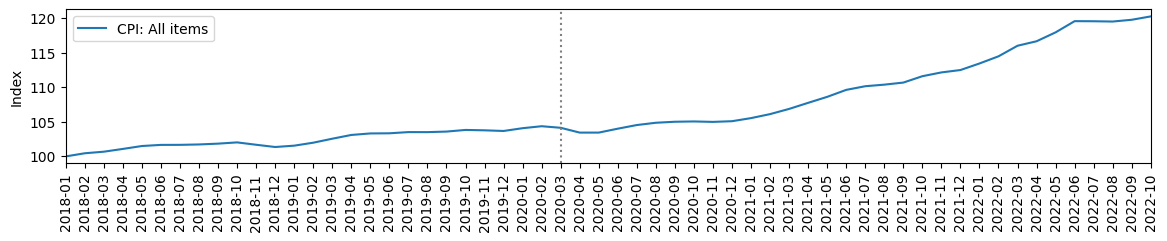

In [282]:
ax = plot_monthly_data(cpi_data['ALL'], ylabel='Index', label='CPI: All items', show_covid=True)

### Experiments using aggregate metrics over top product categories

- First find/choose categories to follow
- Also include categories with CPI subcategories 


For choosing categories to follow:
- only consider categories that have purchases in all months of study
    - automatically accomplished by choosing "top" categories
- restrict to "top" categories?
    - most total purchases?
    - highest median number of purchases over all months?
    - most distinct number of items purchased?

In [283]:
# only consider categories that have purchases in all months of study
# exclude specific categories that were noisy because of items changing categories
# BATTERY adds too much noise
exclude_cats = ['GROCERY', 'FOOD', 'BATTERY']
exclude_cats += ['CLEANING_AGENT', 'SKIN_CLEANING_AGENT'] # COVID
top_cats_N = 15 # restrict to top N categories

top_cats = purchases.groupby('Category')['yyyy-mm'].agg(
    ['nunique','count']
).drop(exclude_cats).sort_values('count', ascending=False)
display(top_cats.describe())
top_cats.head(20)

nunique         count
count  1742.000000   1742.000000
mean     32.962113    234.315155
std      19.843435    754.240300
min       1.000000      1.000000
25%      15.000000     19.000000
50%      35.000000     62.000000
75%      53.000000    194.000000
max      58.000000  21354.000000

nunique  count
Category                              
ABIS_BOOK                    58  21354
PET_FOOD                     58  12031
NUTRITIONAL_SUPPLEMENT       58   7504
SHIRT                        58   6341
HEALTH_PERSONAL_CARE         58   4588
MEDICATION                   58   4438
ELECTRONIC_CABLE             58   4420
PANTS                        58   3587
CELLULAR_PHONE_CASE          58   3481
SKIN_MOISTURIZER             58   3467
COFFEE                       58   3392
VITAMIN                      58   3232
SHOES                        58   3117
PET_SUPPLIES                 58   2893
TOY_FIGURE                   58   2631
TOYS_AND_GAMES               58   2535
HEADPHONES                   58   2514
SOCKS                        58   2431
VEGETABLE                    56   2373
HERBAL_SUPPLEMENT            58   2347

In [284]:
items_categories = list(top_cats.head(top_cats_N).index)
items_categories

['ABIS_BOOK',
 'PET_FOOD',
 'NUTRITIONAL_SUPPLEMENT',
 'SHIRT',
 'HEALTH_PERSONAL_CARE',
 'MEDICATION',
 'ELECTRONIC_CABLE',
 'PANTS',
 'CELLULAR_PHONE_CASE',
 'SKIN_MOISTURIZER',
 'COFFEE',
 'VITAMIN',
 'SHOES',
 'PET_SUPPLIES',
 'TOY_FIGURE']

In [285]:
# Or track overall plus specific categories that map to CPI subcategories we can track

items_categories = [
    # pets
    'PET_FOOD', 'PET_SUPPLIES',
    # food related
    'FOOD', #'VEGETABLE','FRUIT',
    'DRINK_FLAVORED',
    'COFFEE',
    # apparel related
    'SOCKS','SHIRT','PANTS',
    # footwear related
    'SHOES',
    ['SANDAL', 'BOOT', 'SLIPPER'],
]

Make aggregate metrics for these items categories as a table:

```
yyyy-mm, month, CPI, ..., purchasers_cat_i, avgSpend_cat_i, ...
```

To allow linear regression like

$ CPI = month + purchasers_{cat_i} + avgSpend_{cat_i} + ... $

Where really there is a sum over all $cat_i$ metrics and this is integrated into a SARIMAX model

In [286]:
def _get_monthly_aggregate_metrics(purchases, prefix, smoother=3):
    df = pd.DataFrame({
        'yyyy-mm': amzn_data_idx,
        prefix + '_totalSpend': purchases.groupby('yyyy-mm')['total price'].sum(),
        prefix + '_purchases': purchases.groupby('yyyy-mm')['Survey ResponseID'].count(),
        prefix + '_purchasers': purchases.groupby('yyyy-mm')['Survey ResponseID'].nunique(),
        prefix + '_avgSpend': purchases.groupby('yyyy-mm')['total price'].sum() / purchases.groupby('yyyy-mm')['Survey ResponseID'].count(),
        # Note that the mean and median only include the people making purchases that month
        prefix + '_meanSpend': purchases.groupby(
            ['yyyy-mm', 'Survey ResponseID']
        )['total price'].sum().reset_index('yyyy-mm').groupby('yyyy-mm')['total price'].mean(),
        prefix + '_medianSpend': purchases.groupby(
            ['yyyy-mm', 'Survey ResponseID']
        )['total price'].sum().reset_index('yyyy-mm').groupby('yyyy-mm')['total price'].median(),
    }).set_index('yyyy-mm')
    for c in df.columns:
        df['%s_smoothed'%c] = df[c].rolling(3, min_periods=1).mean()
    return df

In [287]:
cat_metrics_df = pd.DataFrame({
    'yyyy-mm': amzn_data_idx,
    'month': sorted(list(month_labels.values())[:len(amzn_data_idx)]),
    'CPI': cpi_series,
    'CPI_lag_1m': cpi_series.shift(-1),
}).set_index('yyyy-mm')

In [288]:
# add OVERALL
cat_metrics_df = cat_metrics_df.merge(
    _get_monthly_aggregate_metrics(purchases, prefix='OVERALL'), 
    how='outer', left_index=True, right_index=True
)

In [289]:
for i, c in enumerate(items_categories):
    cats = c if type(c) is list else [c]
    c_purchases = purchases[purchases['Category'].isin(cats)]
    print('%s: category = %s' % (i, c))
    print('%s total purchases with %s unique products and %s unique purchasers' % (
        len(c_purchases), c_purchases['ASIN/ISBN (Product Code)'].nunique(), c_purchases['Survey ResponseID'].nunique()
    ))
    c_agg_metrics_df = _get_monthly_aggregate_metrics(c_purchases, prefix=('_'.join(cats)))
    cat_metrics_df = cat_metrics_df.merge(c_agg_metrics_df, how='outer', left_index=True, right_index=True)

0: category = PET_FOOD
12031 total purchases with 2857 unique products and 533 unique purchasers
1: category = PET_SUPPLIES
2893 total purchases with 1586 unique products and 515 unique purchasers
2: category = FOOD
2743 total purchases with 1129 unique products and 381 unique purchasers
3: category = DRINK_FLAVORED
2230 total purchases with 595 unique products and 277 unique purchasers
4: category = COFFEE
3392 total purchases with 993 unique products and 399 unique purchasers
5: category = SOCKS
2431 total purchases with 1955 unique products and 661 unique purchasers
6: category = SHIRT
6341 total purchases with 5946 unique products and 810 unique purchasers
7: category = PANTS
3587 total purchases with 3248 unique products and 643 unique purchasers
8: category = SHOES
3117 total purchases with 2925 unique products and 700 unique purchasers
9: category = ['SANDAL', 'BOOT', 'SLIPPER']
2101 total purchases with 1997 unique products and 625 unique purchasers


In [290]:
cat_metrics_df.head()

month        CPI  CPI_lag_1m  OVERALL_totalSpend  OVERALL_purchases   
yyyy-mm                                                                        
2018-01      1  100.00000    99.61838           111972.87               4889  \
2018-02      2   99.61838   100.38775           104979.52               4276   
2018-03      3  100.38775    99.22451           104807.21               4693   
2018-04      4   99.22451    99.33230           104256.14               4386   
2018-05      5   99.33230    98.91901           121854.65               4652   

         OVERALL_purchasers  OVERALL_avgSpend  OVERALL_meanSpend   
yyyy-mm                                                            
2018-01                 725         22.903021         154.445338  \
2018-02                 659         24.550870         159.301244   
2018-03                 674         22.332668         155.500312   
2018-04                 666         23.770210         156.540751   
2018-05                 677         26.194035         179.992097   

         OVERALL_medianSpend  OVERALL_totalSpend_smoothed  ...   
yyyy-mm                                                    ...   
2018-01                86.81                111972.870000  ...  \
2018-02                82.21                108476.195000  ...   
2018-03                97.90                107253.200000  ...   
2018-04                89.52                104680.956667  ...   
2018-05                96.89                110306.000000  ...   

         SANDAL_BOOT_SLIPPER_purchasers  SANDAL_BOOT_SLIPPER_avgSpend   
yyyy-mm                                                                 
2018-01                              20                     42.710741  \
2018-02                               9                     31.503636   
2018-03                              10                     39.917692   
2018-04                              14                     45.797895   
2018-05                              25                     34.985278   

         SANDAL_BOOT_SLIPPER_meanSpend  SANDAL_BOOT_SLIPPER_medianSpend   
yyyy-mm                                                                   
2018-01                      57.659500                            43.78  \
2018-02                      38.504444                            24.99   
2018-03                      51.893000                            42.47   
2018-04                      62.154286                            57.60   
2018-05                      50.378800                            33.75   

         SANDAL_BOOT_SLIPPER_totalSpend_smoothed   
yyyy-mm                                            
2018-01                              1153.190000  \
2018-02                               749.865000   
2018-03                               672.886667   
2018-04                               578.543333   
2018-05                               882.853333   

         SANDAL_BOOT_SLIPPER_purchases_smoothed   
yyyy-mm                                           
2018-01                               27.000000  \
2018-02                               19.000000   
2018-03                               17.000000   
2018-04                               14.333333   
2018-05                               22.666667   

         SANDAL_BOOT_SLIPPER_purchasers_smoothed   
yyyy-mm                                            
2018-01                                20.000000  \
2018-02                                14.500000   
2018-03                                13.000000   
2018-04                                11.000000   
2018-05                                16.333333   

         SANDAL_BOOT_SLIPPER_avgSpend_smoothed   
yyyy-mm                                          
2018-01                              42.710741  \
2018-02                              37.107189   
2018-03                              38.044023   
2018-04                              39.073074   
2018-05                              40.233622   

         SANDAL_BOOT_SLIPPER_me

In [291]:
cnames = ['_'.join(c if type(c) is list else [c]) for c in items_categories]
cnames

['PET_FOOD',
 'PET_SUPPLIES',
 'FOOD',
 'DRINK_FLAVORED',
 'COFFEE',
 'SOCKS',
 'SHIRT',
 'PANTS',
 'SHOES',
 'SANDAL_BOOT_SLIPPER']

In [292]:
# plots

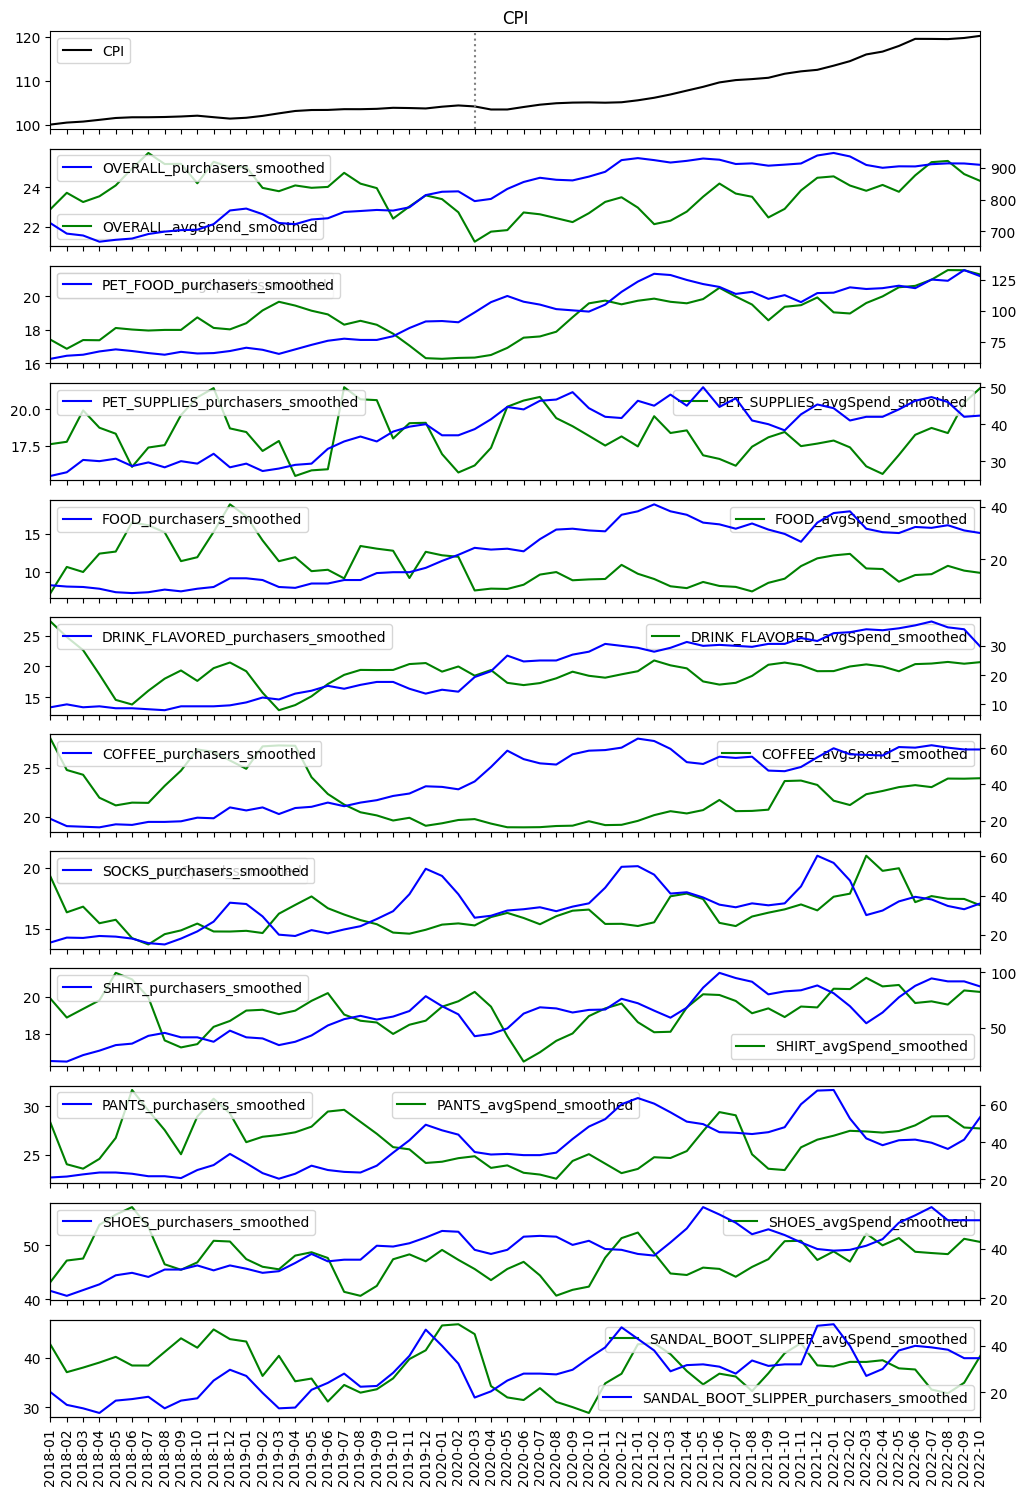

In [293]:
rows = len(items_categories) + 2
fig, axes = plt.subplots(rows,1, figsize=(12, rows*1.5), sharex=True)
plot_monthly_data(cpi_data['ALL'], ax=axes[0], title='CPI', label='CPI', show_covid=True, color='black')
ax = axes[1]
c = 'OVERALL'
col = '%s_avgSpend_smoothed'%c
plot_monthly_data(cat_metrics_df[col], ax=ax, label=col, color='green')
ax = ax.twinx()
col = '%s_purchasers_smoothed'%c
plot_monthly_data(cat_metrics_df[col], ax=ax, label=col, color='blue')
for i, c in enumerate(cnames):
    ax = axes[i+2]
    col = '%s_avgSpend_smoothed'%c
    plot_monthly_data(cat_metrics_df[col], ax=ax, label=col, color='green')
    ax = ax.twinx()
    col = '%s_purchasers_smoothed'%c
    plot_monthly_data(cat_metrics_df[col], ax=ax, label=col, color='blue')

In [294]:
data = cat_metrics_df
data.index = cpi_model_data.index
data.head()

month        CPI  CPI_lag_1m  OVERALL_totalSpend   
DATE                                                           
2018-01-01      1  100.00000    99.61838           111972.87  \
2018-02-01      2   99.61838   100.38775           104979.52   
2018-03-01      3  100.38775    99.22451           104807.21   
2018-04-01      4   99.22451    99.33230           104256.14   
2018-05-01      5   99.33230    98.91901           121854.65   

            OVERALL_purchases  OVERALL_purchasers  OVERALL_avgSpend   
DATE                                                                  
2018-01-01               4889                 725         22.903021  \
2018-02-01               4276                 659         24.550870   
2018-03-01               4693                 674         22.332668   
2018-04-01               4386                 666         23.770210   
2018-05-01               4652                 677         26.194035   

            OVERALL_meanSpend  OVERALL_medianSpend   
DATE                                                 
2018-01-01         154.445338                86.81  \
2018-02-01         159.301244                82.21   
2018-03-01         155.500312                97.90   
2018-04-01         156.540751                89.52   
2018-05-01         179.992097                96.89   

            OVERALL_totalSpend_smoothed  ...  SANDAL_BOOT_SLIPPER_purchasers   
DATE                                     ...                                   
2018-01-01                111972.870000  ...                              20  \
2018-02-01                108476.195000  ...                               9   
2018-03-01                107253.200000  ...                              10   
2018-04-01                104680.956667  ...                              14   
2018-05-01                110306.000000  ...                              25   

            SANDAL_BOOT_SLIPPER_avgSpend  SANDAL_BOOT_SLIPPER_meanSpend   
DATE                                                                      
2018-01-01                     42.710741                      57.659500  \
2018-02-01                     31.503636                      38.504444   
2018-03-01                     39.917692                      51.893000   
2018-04-01                     45.797895                      62.154286   
2018-05-01                     34.985278                      50.378800   

            SANDAL_BOOT_SLIPPER_medianSpend   
DATE                                          
2018-01-01                            43.78  \
2018-02-01                            24.99   
2018-03-01                            42.47   
2018-04-01                            57.60   
2018-05-01                            33.75   

            SANDAL_BOOT_SLIPPER_totalSpend_smoothed   
DATE                                                  
2018-01-01                              1153.190000  \
2018-02-01                               749.865000   
2018-03-01                               672.886667   
2018-04-01                               578.543333   
2018-05-01                               882.853333   

            SANDAL_BOOT_SLIPPER_purchases_smoothed   
DATE                                                 
2018-01-01                               27.000000  \
2018-02-01                               19.000000   
2018-03-01                               17.000000   
2018-04-01                               14.333333   
2018-05-01                               22.666667   

            SANDAL_BOOT_SLIPPER_purchasers_smoothed   
DATE                                                  
2018-01-01                                20.000000  \
2018-02-01                                14.500000   
2018-03-01                                13.000000   
2018-04-01                                11.000000   
2018-05-01                                16.333333   

            SANDAL_BOOT_SLIPPER_avgSpend_smoothed   
DATE                                                
2018-01-01  

Regression - First OLS

using top 15 product categories without any fancy product category merging
- month alone R2: 0.852
- 

In [295]:
formula = 'CPI ~ month + '
# note using totalSpend has same effect as using avgSpend with purchasers
# s = ['%s_purchasers_smoothed + %s_avgSpend_smoothed' % (c, c) for c in items_categories] # .997
# s = ['%s_purchasers_smoothed + %s_meanSpend_smoothed' % (c, c) for c in items_categories] # .996
# s = ['%s_purchasers_smoothed + %s_medianSpend_smoothed' % (c, c) for c in items_categories] # .996
# best|
s = ['%s_purchases_smoothed + %s_totalSpend_smoothed' % (c, c) for c in cnames] # .998
# s = ['%s_purchases_smoothed + %s_avgSpend_smoothed' % (c, c) for c in items_categories] # .998
formula += ' + '.join(s)
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=data).fit()
display(result.summary())

Formula:
CPI ~ month + PET_FOOD_purchases_smoothed + PET_FOOD_totalSpend_smoothed + PET_SUPPLIES_purchases_smoothed + PET_SUPPLIES_totalSpend_smoothed + FOOD_purchases_smoothed + FOOD_totalSpend_smoothed + DRINK_FLAVORED_purchases_smoothed + DRINK_FLAVORED_totalSpend_smoothed + COFFEE_purchases_smoothed + COFFEE_totalSpend_smoothed + SOCKS_purchases_smoothed + SOCKS_totalSpend_smoothed + SHIRT_purchases_smoothed + SHIRT_totalSpend_smoothed + PANTS_purchases_smoothed + PANTS_totalSpend_smoothed + SHOES_purchases_smoothed + SHOES_totalSpend_smoothed + SANDAL_BOOT_SLIPPER_purchases_smoothed + SANDAL_BOOT_SLIPPER_totalSpend_smoothed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     42.91
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           1.85e-19
Time:                        15:33:51   Log-Likelihood:                -94.938
No. Observations:                  58   AIC:                             233.9
Df Residuals:                      36   BIC:                             279.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  93.1572      3.108     29.978      0.000      86.855      99.460
month                                       0.1462      0.106      1.378      0.177      -0.069       0.361
PET_FOOD_purchases_smoothed                 0.0143      0.032      0.439      0.663      -0.052       0.080
PET_FOOD_totalSpend_smoothed               -0.0006      0.002     -0.270      0.789      -0.005       0.004
PET_SUPPLIES_purchases_smoothed            -0.1273      0.106     -1.199      0.238      -0.343       0.088
PET_SUPPLIES_totalSpend_smoothed            0.0125      0.005      2.726      0.010       0.003       0.022
FOOD_purchases_smoothed                    -0.1403      0.050     -2.818      0.008      -0.241      -0.039
FOOD_totalSpend_smoothed                    0.0153      0.005      2.907      0.006       0.005       0.026
DRINK_FLAVORED_purchases_smoothed          -0.5994      0.152     -3.943      0.000      -0.908      -0.291
DRINK_FLAVORED_totalSpend_smoothed          0.0220      0.006      3.832      0.000       0.010       0.034
COFFEE_purchases_smoothed                  -0.2955      0.119     -2.483      0.018      -0.537      -0.054
COFFEE_totalSpend_smoothed                  0.0228      0.007      3.424      0.002       0.009       0.036
SOCKS_purchases_smoothed                   -0.1717      0.132     -1.304      0.200      -0.439       0.095
SOCKS_totalSpend_smoothed                   0.0011      0.009      0.122      0.904      -0.017       0.019
SHIRT_purchases_smoothed                   -0.2793      0.089     -3.133      0.003      -0.460      -0.099
SHIRT_totalSpend_smoothed                   0.0143      0.004      3.347      0.002       0.006       0.023
PANTS_purchases_smoothed                    0.0160      0.114      0.140      0.889      -0.216       0.248
PANTS_totalSpend_smoothed                  -0.0018      0.004     -0.525      0.603      -0.009       0.005
SHOES_purchases_smoothed                   -0.2833      0.105     -2.706      0.010      -0.496      -0.071
SHOES_totalSpend_smoothed                   0.0071      0.002      3.083      0.004       0.002       0.012
SANDAL_BOOT_SLIPPER_purchases_smoothed      0.2796      0.121      2.316      0.026       0.035       0.524
SANDAL_BOOT_SLIPPER_totalSpend_smoothed    -0.0069      0.003     -2.129      0.040      -0.014      -0.000
==============================================================================
Omnibus:                        1.816   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.050
Skew:                          -0.154   Prob(JB):                        0.592
Kurtosis:                       3.583   Cond. No.                  

In [296]:
print('OLS predictions')
predictions, errors, mae, train_res = train_predict_one_step_ahead_ols(
    data, formula, 
    pred_start='2021-01-01',
    pred_end='2022-11-01',
    verbose=True,
)
print('MAE %0.4f' % mae)
train_res.summary()

OLS predictions
initial training period: 2018-01-01 00:00:00 to 2020-12-01 00:00:00
prediction start, end: 2021-01-01 2022-11-01
Formula:
CPI ~ month + PET_FOOD_purchases_smoothed + PET_FOOD_totalSpend_smoothed + PET_SUPPLIES_purchases_smoothed + PET_SUPPLIES_totalSpend_smoothed + FOOD_purchases_smoothed + FOOD_totalSpend_smoothed + DRINK_FLAVORED_purchases_smoothed + DRINK_FLAVORED_totalSpend_smoothed + COFFEE_purchases_smoothed + COFFEE_totalSpend_smoothed + SOCKS_purchases_smoothed + SOCKS_totalSpend_smoothed + SHIRT_purchases_smoothed + SHIRT_totalSpend_smoothed + PANTS_purchases_smoothed + PANTS_totalSpend_smoothed + SHOES_purchases_smoothed + SHOES_totalSpend_smoothed + SANDAL_BOOT_SLIPPER_purchases_smoothed + SANDAL_BOOT_SLIPPER_totalSpend_smoothed

0 2020-12-01 00:00:00
AIC: 65.295
12 2021-12-01 00:00:00
AIC: 124.499
MAE 2.3366


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     39.83
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           1.64e-18
Time:                        15:33:51   Log-Likelihood:                -90.905
No. Observations:                  57   AIC:                             225.8
Df Residuals:                      35   BIC:                             270.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  93.3783      2.998     31.148      0.000      87.292      99.464
month                                       0.1256      0.103      1.221      0.230      -0.083       0.334
PET_FOOD_purchases_smoothed                 0.0174      0.031      0.554      0.583      -0.046       0.081
PET_FOOD_totalSpend_smoothed               -0.0006      0.002     -0.283      0.779      -0.005       0.004
PET_SUPPLIES_purchases_smoothed            -0.0182      0.117     -0.155      0.877      -0.255       0.219
PET_SUPPLIES_totalSpend_smoothed            0.0080      0.005      1.610      0.116      -0.002       0.018
FOOD_purchases_smoothed                    -0.1196      0.049     -2.431      0.020      -0.219      -0.020
FOOD_totalSpend_smoothed                    0.0153      0.005      3.003      0.005       0.005       0.026
DRINK_FLAVORED_purchases_smoothed          -0.6286      0.147     -4.267      0.000      -0.928      -0.329
DRINK_FLAVORED_totalSpend_smoothed          0.0248      0.006      4.333      0.000       0.013       0.036
COFFEE_purchases_smoothed                  -0.2423      0.118     -2.054      0.048      -0.482      -0.003
COFFEE_totalSpend_smoothed                  0.0194      0.007      2.897      0.006       0.006       0.033
SOCKS_purchases_smoothed                   -0.1421      0.128     -1.112      0.274      -0.402       0.117
SOCKS_totalSpend_smoothed                   0.0041      0.009      0.477      0.636      -0.013       0.022
SHIRT_purchases_smoothed                   -0.2626      0.086     -3.039      0.004      -0.438      -0.087
SHIRT_totalSpend_smoothed                   0.0138      0.004      3.338      0.002       0.005       0.022
PANTS_purchases_smoothed                   -0.0840      0.122     -0.690      0.495      -0.331       0.163
PANTS_totalSpend_smoothed                  -0.0005      0.003     -0.150      0.882      -0.008       0.006
SHOES_purchases_smoothed                   -0.3388      0.105     -3.229      0.003      -0.552      -0.126
SHOES_totalSpend_smoothed                   0.0076      0.002      3.424      0.002       0.003       0.012
SANDAL_BOOT_SLIPPER_purchases_smoothed      0.2520      0.117      2.149      0.039       0.014       0.490
SANDAL_BOOT_SLIPPER_totalSpend_smoothed    -0.0068      0.003     -2.167      0.037      -0.013      -0.000
==============================================================================
Omnibus:                        1.550   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.461   Jarque-Bera (JB):                0.823
Skew:                           0.009   Prob(JB):                        0.663
Kurtosis:                       3.588   Cond. No.                  

MAE for ALL CPI: 2.3366


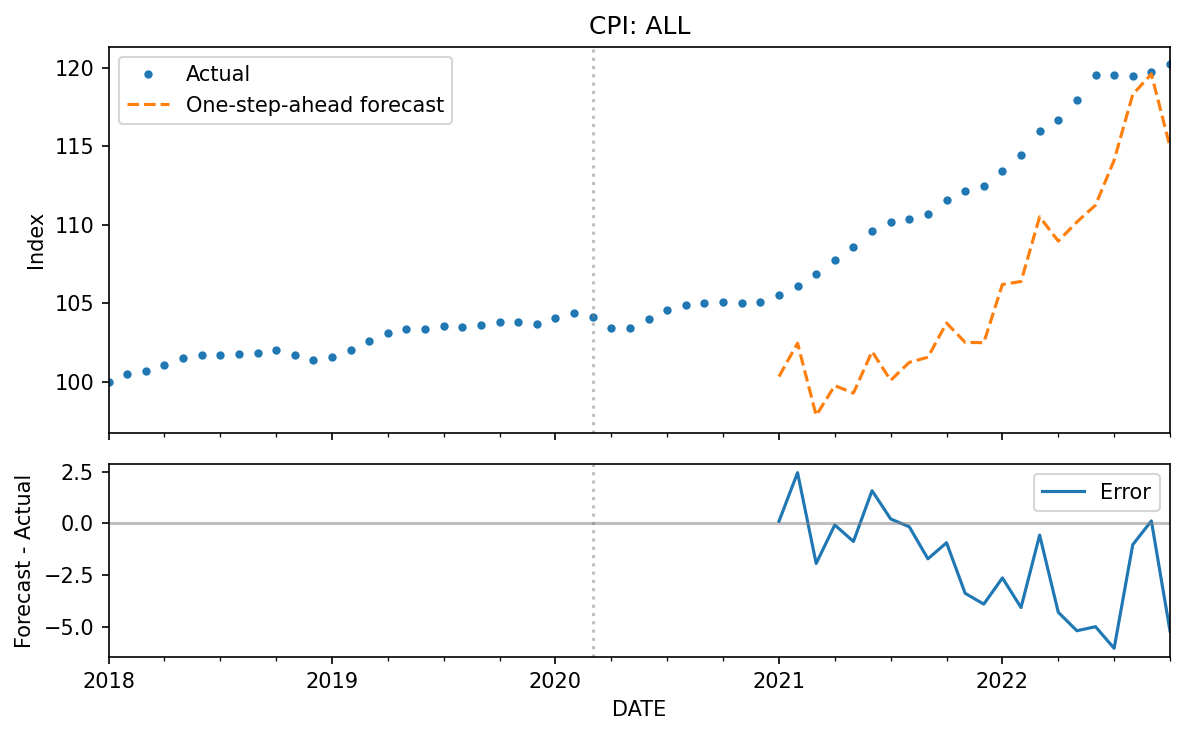

In [297]:
cpi_cat = 'ALL'
cpi_series = cpi_model_data[cpi_cat]
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions, ax=axes[0])
ax.set(title='CPI: %s'%cpi_cat, xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors, ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

With SARIMAX and exogenous variables

In [298]:
exog_vars = [c for c in data.columns if ('_totalSpend_smoothed' in c) or ('_purchasers_smoothed' in c)]
exog = data[exog_vars]
exog.head()

OVERALL_totalSpend_smoothed  OVERALL_purchasers_smoothed   
DATE                                                                   
2018-01-01                111972.870000                   725.000000  \
2018-02-01                108476.195000                   692.000000   
2018-03-01                107253.200000                   686.000000   
2018-04-01                104680.956667                   666.333333   
2018-05-01                110306.000000                   672.333333   

            PET_FOOD_totalSpend_smoothed  PET_FOOD_purchasers_smoothed   
DATE                                                                     
2018-01-01                   2176.180000                     61.000000  \
2018-02-01                   2140.870000                     63.500000   
2018-03-01                   2299.520000                     64.333333   
2018-04-01                   2396.630000                     67.000000   
2018-05-01                   2522.086667                     68.666667   

            PET_SUPPLIES_totalSpend_smoothed   
DATE                                           
2018-01-01                        615.890000  \
2018-02-01                        603.655000   
2018-03-01                        774.326667   
2018-04-01                        704.466667   
2018-05-01                        718.603333   

            PET_SUPPLIES_purchasers_smoothed  FOOD_totalSpend_smoothed   
DATE                                                                     
2018-01-01                         26.000000                115.730000  \
2018-02-01                         27.000000                142.425000   
2018-03-01                         30.333333                126.753333   
2018-04-01                         30.000000                131.576667   
2018-05-01                         30.666667                100.040000   

            FOOD_purchasers_smoothed  DRINK_FLAVORED_totalSpend_smoothed   
DATE                                                                       
2018-01-01                 10.000000                          300.300000  \
2018-02-01                  9.500000                          305.955000   
2018-03-01                  9.333333                          277.446667   
2018-04-01                  8.666667                          259.766667   
2018-05-01                  7.333333                          234.696667   

            DRINK_FLAVORED_purchasers_smoothed  ...   
DATE                                            ...   
2018-01-01                            9.000000  ...  \
2018-02-01                           10.000000  ...   
2018-03-01                            9.000000  ...   
2018-04-01                            9.333333  ...   
2018-05-01                            8.666667  ...   

            SOCKS_totalSpend_smoothed  SOCKS_purchasers_smoothed   
DATE                                                               
2018-01-01                 443.030000                  16.000000  \
2018-02-01                 422.530000                  18.500000   
2018-03-01                 399.890000                  18.333333   
2018-04-01                 368.573333                  19.333333   
2018-05-01                 339.070000                  19.000000   

            SHIRT_totalSpend_smoothed  SHIRT_purchasers_smoothed   
DATE                                                               
2018-01-01                 517.600000                  20.000000  \
2018-02-01                 482.070000                  19.500000   
2018-03-01                 781.220000                  25.333333   
2018-04-01                 949.530000                  29.333333   
2018-05-01                1187.746667                  34.333333   

            PANTS_totalSpend_smoothed  PANTS_purchasers_smoothed   
DATE                                                               
2018-01-01                 820.970000                  21.000000  \
2018-02-01                 755.720000                  

In [299]:
print('CPI: %s' % cpi_cat)
# train through first 2 years of data
predictions, errors, mae = sarimax_train_predict_one_step_ahead(
    cpi_series, 
    exog=exog,
    pred_start='2020-01-01', pred_end='2022-11-01',
    verbose=True
)
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

CPI: ALL
initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-11-01


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0 2019-12-01 00:00:00
AIC: 76.399


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

12 2020-12-01 00:00:00
AIC: 99.480


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

24 2021-12-01 00:00:00
AIC: 125.325


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

MAE for ALL CPI: 0.4690


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE for ALL CPI: 0.4690


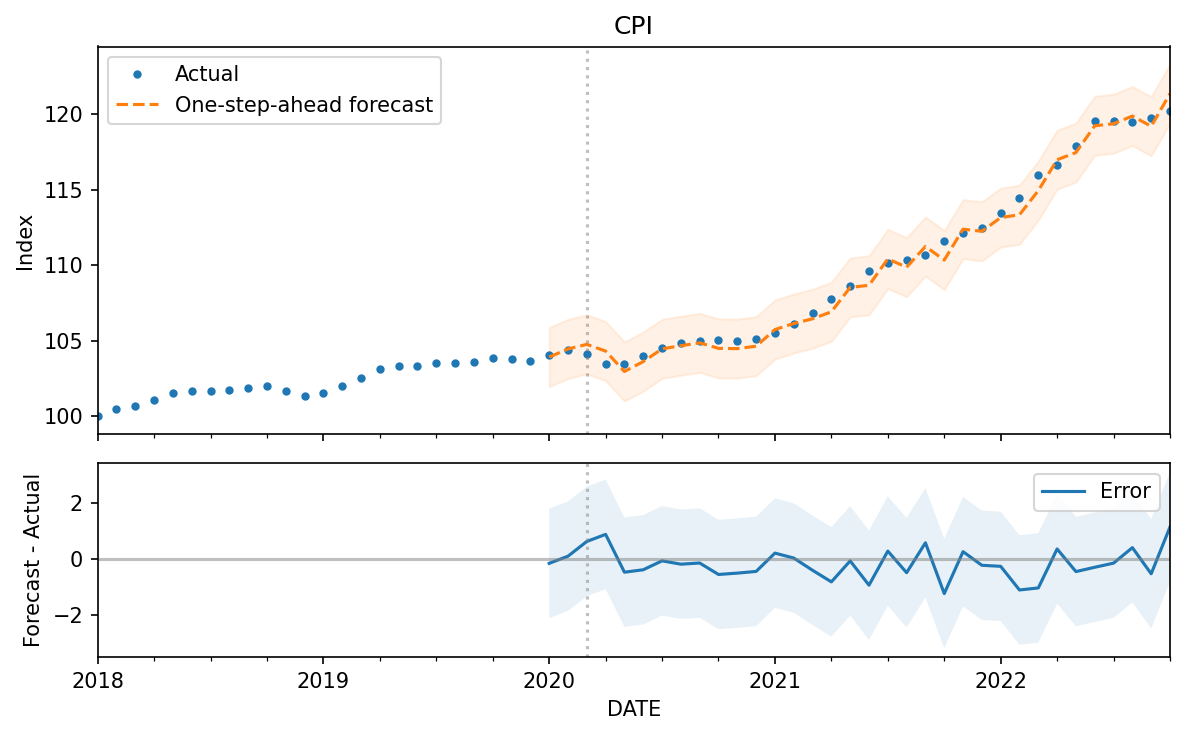

In [300]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions['mean'], predictions['mean_ci_lower'],
                       predictions['mean_ci_upper'], ax=axes[0])
ax.set(title='CPI', xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors['mean'], errors['ci_lower'], errors['ci_upper'], 
                 ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

---

## Food related

In [301]:
food_categories = [
    'FOOD','GROCERY',
    'VEGETABLE','FRUIT', 
    'COFFEE', 'TEA', 'DRINK_FLAVORED',
    'SNACK_FOOD_BAR', 'SNACK_CHIP_AND_CRISP',
    'SUGAR_CANDY',
]
food_purchases = get_purchases(food_categories)
food_purchases.head(3)

85622 purchases from N=3440 unique customers


yyyy-mm  month  quarter   
48  2020-05     29       10  \
13  2019-12     24        8   
8   2018-02      2        1   

                                                Title   
48  Napoleon Candy | Napoleon Black & White Balls ...  \
13  200g Dahongpao Oolong Tea Wuyi Rock Tea Strong...   
8   Dongwon Yangban Crispy Layered Seaweed Snack w...   

   ASIN/ISBN (Product Code)        Category  unit price  Quantity   
48               B07V9PFHB1     SUGAR_CANDY        8.99       1.0  \
13               B00CQF2TIS             TEA       15.98       1.0   
8                B01HNGJ4C8  SNACK_FOOD_BAR       14.99       1.0   

    total price  Survey ResponseID  
48         8.99  R_3I9Pu8iauEcOx9A  
13        15.98  R_7UtikIBqeQHvnyN  
8         14.99  R_1Nnv2IYQFpUwHrr

## Coffee

In [302]:
_coffee_purchases = get_purchases(['COFFEE'])

10054 purchases from N=1450 unique customers


In [303]:
# Are there coffee products that were not labeled as coffee?
def is_maybe_uncategorized_coffee(row):
    return is_maybe_product_match(
        row, 
        cat_require=['FOOD', 'GROCERY', 'nan'],
        title_require_keywords=['coffee'],
        title_exclude_keywords=[
            'alternative', 'substitute', # ignore coffee alternatives
            'energy drink',
            # ignore products that have coffee in the title
            'ice cream',
            ' bar',
            'candy','candies',
            'creamer', 'syrup',
            'sugar',
            'french press'
        ]
    )
maybe_coffee_purchases = amzn_data[
    amzn_data.apply(is_maybe_uncategorized_coffee, axis=1)
]
print("%s maybe uncategorized coffee purchases from N=%s unique purchasers" % (
    len(maybe_coffee_purchases), 
    maybe_coffee_purchases['Survey ResponseID'].nunique()))
print('I inspected these... Will add these too the coffee purchases')
maybe_coffee_purchases.groupby(['Title', 'ASIN/ISBN (Product Code)'])[
    'Survey ResponseID'
].agg(['count','nunique']).sort_values('count', ascending=False).head()

276 maybe uncategorized coffee purchases from N=134 unique purchasers
I inspected these... Will add these too the coffee purchases


count   
Title                                              ASIN/ISBN (Product Code)          
Nespresso Capsules VertuoLine, Medium and Dark ... B01N05APQY                   23  \
Lavazza Crema E Gusto Ground Coffee Blend, Espr... B001E5E0D8                   19   
Folgers Breakfast Blend Mild Roast Ground Coffe... B07QRBYSM9                   15   
Maxwell House Intense Bold Dark Roast Ground Co... B01M10RKLY                   13   
McCafé Colombian, Medium-Dark Roast Ground Coff... B00QSP61A4                   11   

                                                                             nunique  
Title                                              ASIN/ISBN (Product Code)           
Nespresso Capsules VertuoLine, Medium and Dark ... B01N05APQY                     18  
Lavazza Crema E Gusto Ground Coffee Blend, Espr... B001E5E0D8                      3  
Folgers Breakfast Blend Mild Roast Ground Coffe... B07QRBYSM9                      2  
Maxwell House Intense Bold Dark Roast Ground Co... B01M10RKLY                      5  
McCafé Colombian, Medium-Dark Roast Ground Coff... B00QSP61A4                      1

In [304]:
coffee_purchases = pd.concat(
    [_coffee_purchases, maybe_coffee_purchases]
)[_coffee_purchases.columns]
print('%s coffee purchases from N=%s unique customers' % 
      (len(coffee_purchases), coffee_purchases['Survey ResponseID'].nunique()))

10330 coffee purchases from N=1471 unique customers


### Aggregate metrics

In [305]:
cpi_series = cpi_data['COFFEE']
agg_metrics = get_monthly_aggregate_metrics(coffee_purchases, cpi_series)
agg_metrics.head()

month        CPI  CPI_lag_1m  totalSpend  purchases  purchasers   
yyyy-mm                                                                    
2018-01      1  100.00000    99.61838     1631.07         70          60  \
2018-02      2   99.61838   100.38775     1738.81         88          70   
2018-03      3  100.38775    99.22451     1793.84         80          67   
2018-04      4   99.22451    99.33230     1511.54         74          60   
2018-05      5   99.33230    98.91901     1730.97         77          69   

          avgSpend  meanSpend  medianSpend  
yyyy-mm                                     
2018-01  23.301000  27.184500       20.495  
2018-02  19.759205  24.840143       22.155  
2018-03  22.423000  26.773731       23.980  
2018-04  20.426216  25.192333       18.485  
2018-05  22.480130  25.086522       20.990

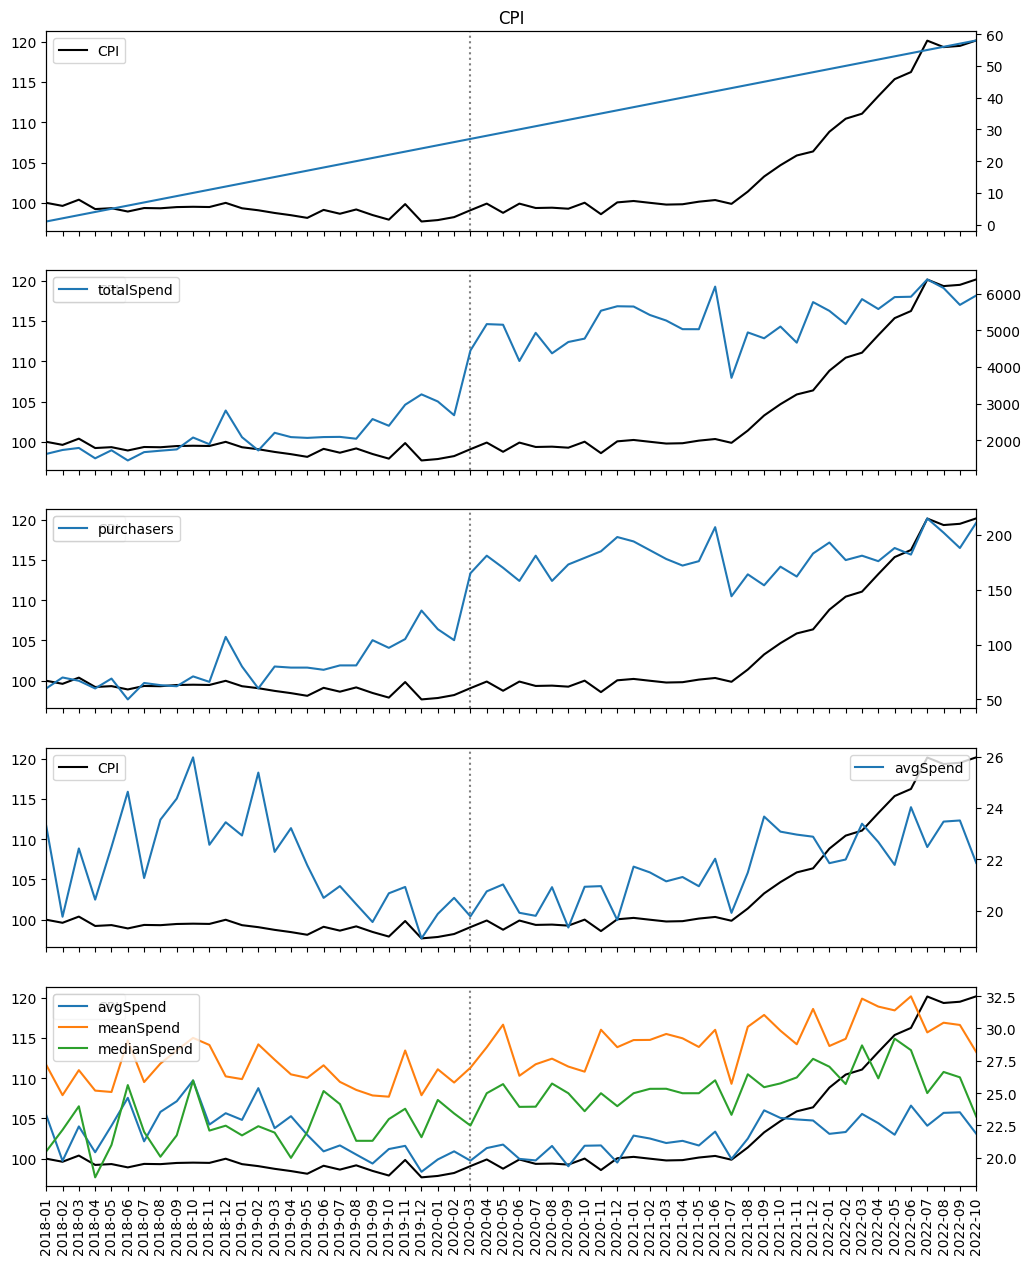

In [306]:
fig, axes = plt.subplots(5,1, figsize=(12, 5*3), sharex=True)

ax = axes[0]
ax.set_title('Coffee CPI')
plot_monthly_data(agg_metrics['CPI'], ax=ax, title='CPI', label='CPI', show_covid=True, color='black')
ax = ax.twinx()
plot_monthly_data(agg_metrics['month'], ax=ax)
ax = axes[1]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'totalSpend'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[2]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'purchasers'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[3]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'avgSpend'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[4]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
for c in ['avgSpend','meanSpend','medianSpend']:
    plot_monthly_data(agg_metrics[c], ax=ax, label=c)

In [307]:
# smooth the metrics except CPI data
cpi_series = agg_metrics['CPI']
for c in ['avgSpend','meanSpend','medianSpend', 'totalSpend','purchasers']:
    agg_metrics['%s_smoothed'%c] = agg_metrics[c].rolling(3, min_periods=1).mean()
agg_metrics.index = cpi_model_data.index
agg_metrics.head()

month        CPI  CPI_lag_1m  totalSpend  purchases  purchasers   
DATE                                                                          
2018-01-01      1  100.00000    99.61838     1631.07         70          60  \
2018-02-01      2   99.61838   100.38775     1738.81         88          70   
2018-03-01      3  100.38775    99.22451     1793.84         80          67   
2018-04-01      4   99.22451    99.33230     1511.54         74          60   
2018-05-01      5   99.33230    98.91901     1730.97         77          69   

             avgSpend  meanSpend  medianSpend  avgSpend_smoothed   
DATE                                                               
2018-01-01  23.301000  27.184500       20.495          23.301000  \
2018-02-01  19.759205  24.840143       22.155          21.530102   
2018-03-01  22.423000  26.773731       23.980          21.827735   
2018-04-01  20.426216  25.192333       18.485          20.869474   
2018-05-01  22.480130  25.086522       20.990          21.776449   

            meanSpend_smoothed  medianSpend_smoothed  totalSpend_smoothed   
DATE                                                                        
2018-01-01           27.184500             20.495000          1631.070000  \
2018-02-01           26.012321             21.325000          1684.940000   
2018-03-01           26.266125             22.210000          1721.240000   
2018-04-01           25.602069             21.540000          1681.396667   
2018-05-01           25.684195             21.151667          1678.783333   

            purchasers_smoothed  
DATE                             
2018-01-01            60.000000  
2018-02-01            65.000000  
2018-03-01            65.666667  
2018-04-01            65.666667  
2018-05-01            65.333333

### Coffee CPI prediction

Show CPI and how well it can be estimated by basic SARIMAX model.

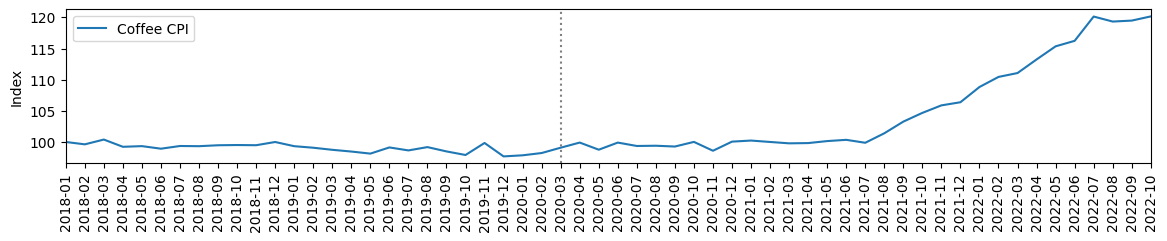

In [308]:
ax = plot_monthly_data(cpi_data['COFFEE'], ylabel='Index', label='Coffee CPI', show_covid=True)

In [309]:
cpi_cat = 'COFFEE'
cpi_series = cpi_model_data[cpi_cat]
cpi_series.head(3)

DATE
2018-01-01    100.00000
2018-02-01     99.61838
2018-03-01    100.38775
Freq: MS, Name: COFFEE, dtype: float64

In [310]:
print('CPI: %s' % cpi_cat)
# train through first 2 years of data
predictions, errors, mae = sarimax_train_predict_one_step_ahead(
    cpi_series,
    pred_start='2020-01-01', pred_end='2022-11-01',
    #verbose=True
)
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

CPI: COFFEE


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE for COFFEE CPI: 1.2997


MAE for COFFEE CPI: 1.2997


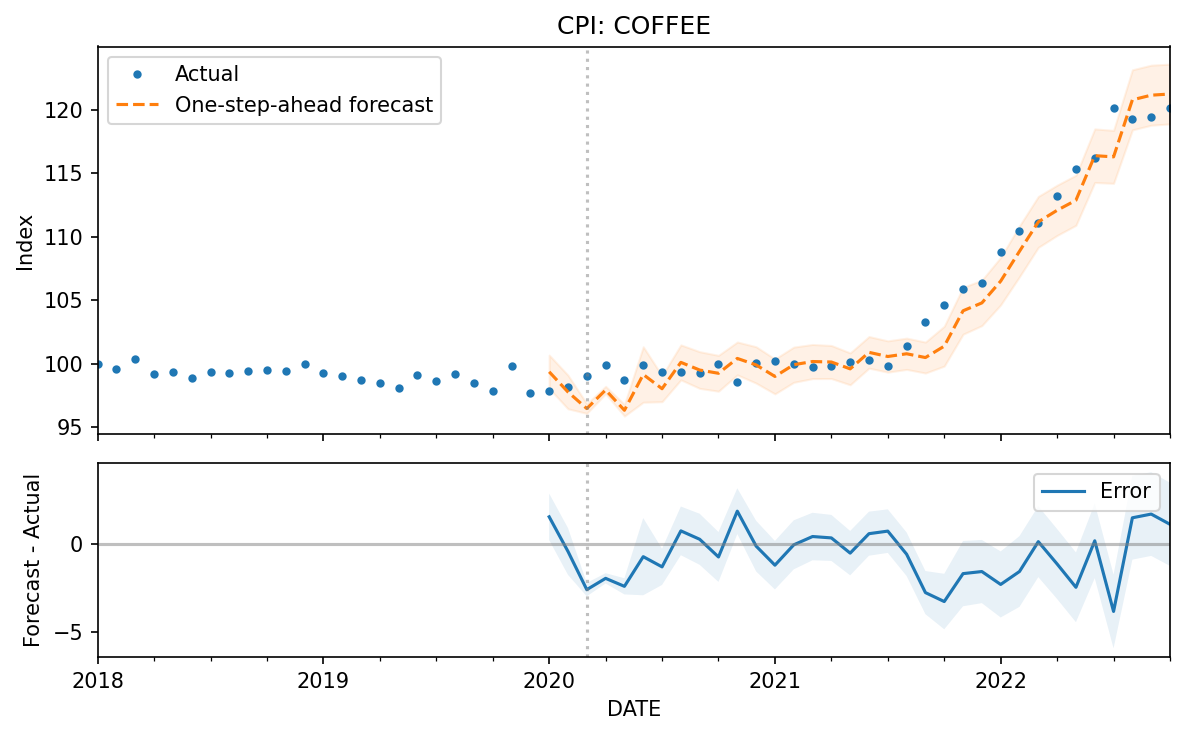

In [311]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions['mean'], predictions['mean_ci_lower'],
                       predictions['mean_ci_upper'], ax=axes[0])
ax.set(title='CPI: %s'%cpi_cat, xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors['mean'], errors['ci_lower'], errors['ci_upper'], 
                 ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

### CPI prediction with aggregate purchases data


Basic OLS

- Month alone has R2 = 0.570
- R2 improved when data smoothed

In [312]:
# use data up to Nov 2022 since that is when data collection began
data = agg_metrics

In [313]:
formula = 'CPI ~ month'
# formula = 'CPI ~ month + purchasers'
# formula = 'CPI ~ month + avgSpend'
# formula = 'CPI ~ month + purchasers + meanSpend_smoothed'
formula = 'CPI ~ month + purchasers_smoothed + avgSpend_smoothed' # best
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=data).fit()
display(result.summary())

Formula:
CPI ~ month + purchasers_smoothed + avgSpend_smoothed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     47.87
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           3.14e-15
Time:                        15:36:06   Log-Likelihood:                -151.84
No. Observations:                  58   AIC:                             311.7
Df Residuals:                      54   BIC:                             319.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              58.0610      9.537      6.088      0.000      38.940      77.182
month                   0.4112      0.083      4.965      0.000       0.245       0.577
purchasers_smoothed    -0.0450      0.028     -1.627      0.110      -0.100       0.010
avgSpend_smoothed       1.7555      0.399      4.399      0.000       0.955       2.556
==============================================================================
Omnibus:                        3.314   Durbin-Watson:                   0.159
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                3.178
Skew:                           0.556   Prob(JB):                        0.204
Kurtosis:                       2.721   Cond. No.                     3.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [314]:
print('OLS predictions')
predictions, errors, mae, train_res = train_predict_one_step_ahead_ols(
    data, formula, 
    pred_start='2020-01-01',
    verbose=True,
)
print('MAE %0.4f' % mae)
train_res.summary()

OLS predictions
initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-10-01 00:00:00
Formula:
CPI ~ month + purchasers_smoothed + avgSpend_smoothed

0 2019-12-01 00:00:00
AIC: 41.544
12 2020-12-01 00:00:00
AIC: 62.976
24 2021-12-01 00:00:00
AIC: 160.656
MAE 3.1931


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     43.27
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           2.81e-14
Time:                        15:36:07   Log-Likelihood:                -147.24
No. Observations:                  57   AIC:                             302.5
Df Residuals:                      53   BIC:                             310.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              59.9437      9.258      6.475      0.000      41.375      78.512
month                   0.3909      0.081      4.851      0.000       0.229       0.553
purchasers_smoothed    -0.0427      0.027     -1.595      0.117      -0.096       0.011
avgSpend_smoothed       1.6765      0.387      4.328      0.000       0.900       2.453
==============================================================================
Omnibus:                        5.134   Durbin-Watson:                   0.166
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                4.667
Skew:                           0.701   Prob(JB):                       0.0970
Kurtosis:                       3.047   Cond. No.                     3.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MAE for COFFEE CPI: 3.1931


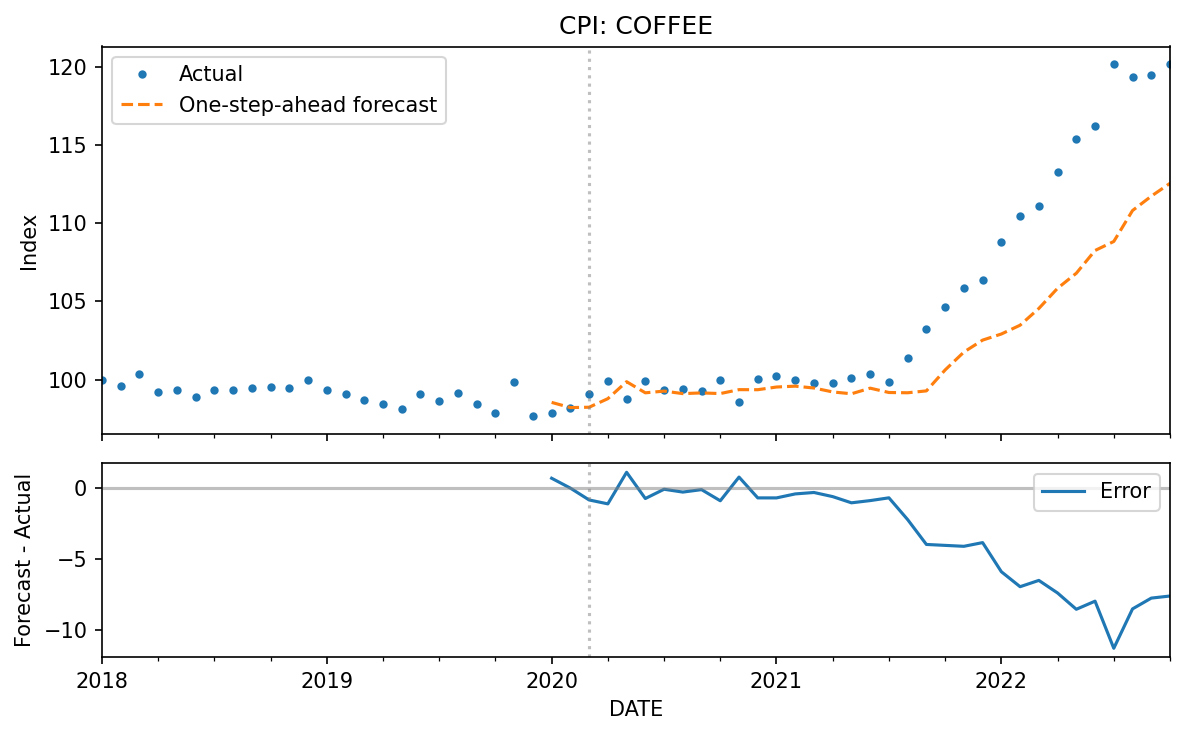

In [315]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions, ax=axes[0])
ax.set(title='CPI: %s'%cpi_cat, xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors, ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

In [316]:
exog_vars = ['purchasers_smoothed', 'avgSpend_smoothed']
exog = data[exog_vars]
exog.head()

purchasers_smoothed  avgSpend_smoothed
DATE                                              
2018-01-01            60.000000          23.301000
2018-02-01            65.000000          21.530102
2018-03-01            65.666667          21.827735
2018-04-01            65.666667          20.869474
2018-05-01            65.333333          21.776449

In [317]:
print('CPI: %s' % cpi_cat)
# train through first 2 years of data
predictions, errors, mae = sarimax_train_predict_one_step_ahead(
    cpi_series, 
    exog=exog,
    pred_start='2020-01-01', pred_end='2022-11-01',
    verbose=True
)
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

CPI: COFFEE
initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-11-01


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0 2019-12-01 00:00:00
AIC: 40.779


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

12 2020-12-01 00:00:00
AIC: 63.963


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


24 2021-12-01 00:00:00
AIC: 117.859
MAE for COFFEE CPI: 1.2599


MAE for COFFEE CPI: 1.2599


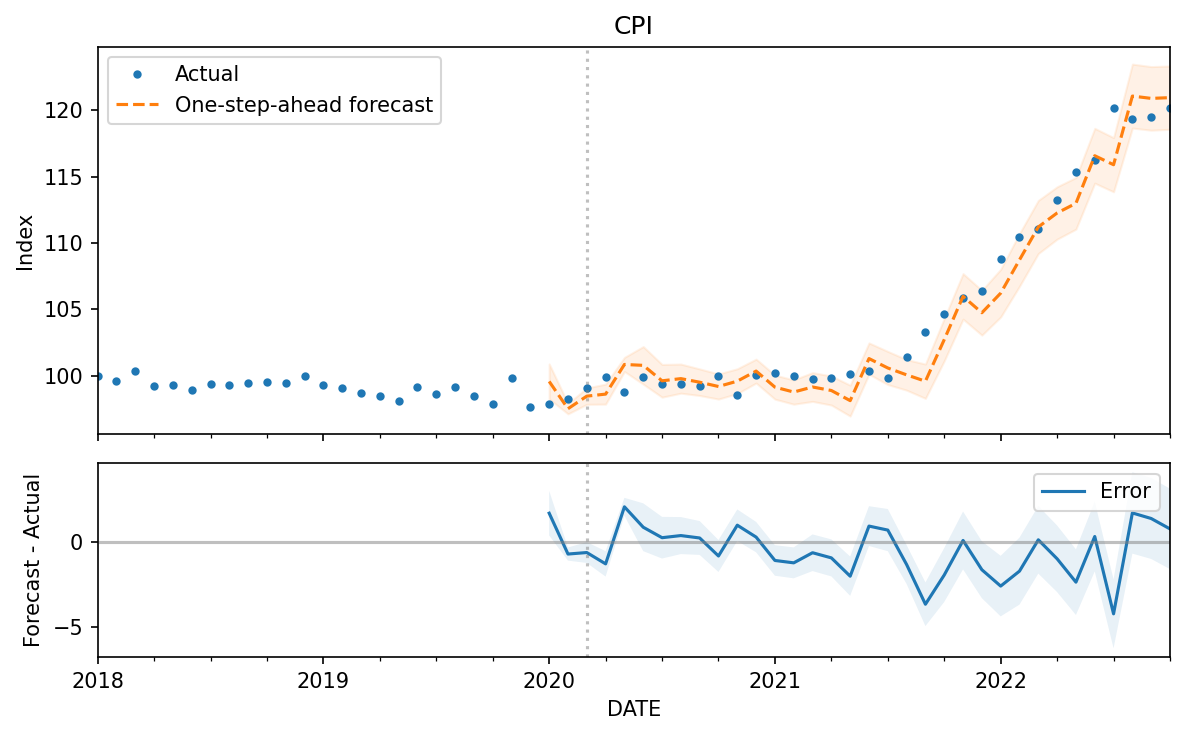

In [318]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions['mean'], predictions['mean_ci_lower'],
                       predictions['mean_ci_upper'], ax=axes[0])
ax.set(title='CPI', xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors['mean'], errors['ci_lower'], errors['ci_upper'], 
                 ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

### With stratified sample

In [337]:
stratified_sample_df.head()

age     sex               age x sex
R_3F4cWjtxeQOW5r7  18 - 34 years  Female  18 - 34 years x Female
R_3h9L8YKiEqpP51c  18 - 34 years  Female  18 - 34 years x Female
R_2YPn3BGBQEYnIRt  18 - 34 years  Female  18 - 34 years x Female
R_3exlTi02vMuoy59  18 - 34 years  Female  18 - 34 years x Female
R_PTZ3QbtCJTTGaEF  18 - 34 years  Female  18 - 34 years x Female

In [338]:
# restrict purchases to stratified sample
coffee_purchases_strat = coffee_purchases[coffee_purchases['Survey ResponseID'].isin(stratified_sample_df.index)]
# coffee_purchases_strat.head()

In [339]:
cpi_series = cpi_data['COFFEE']
agg_metrics = get_monthly_aggregate_metrics(coffee_purchases_strat, cpi_series)

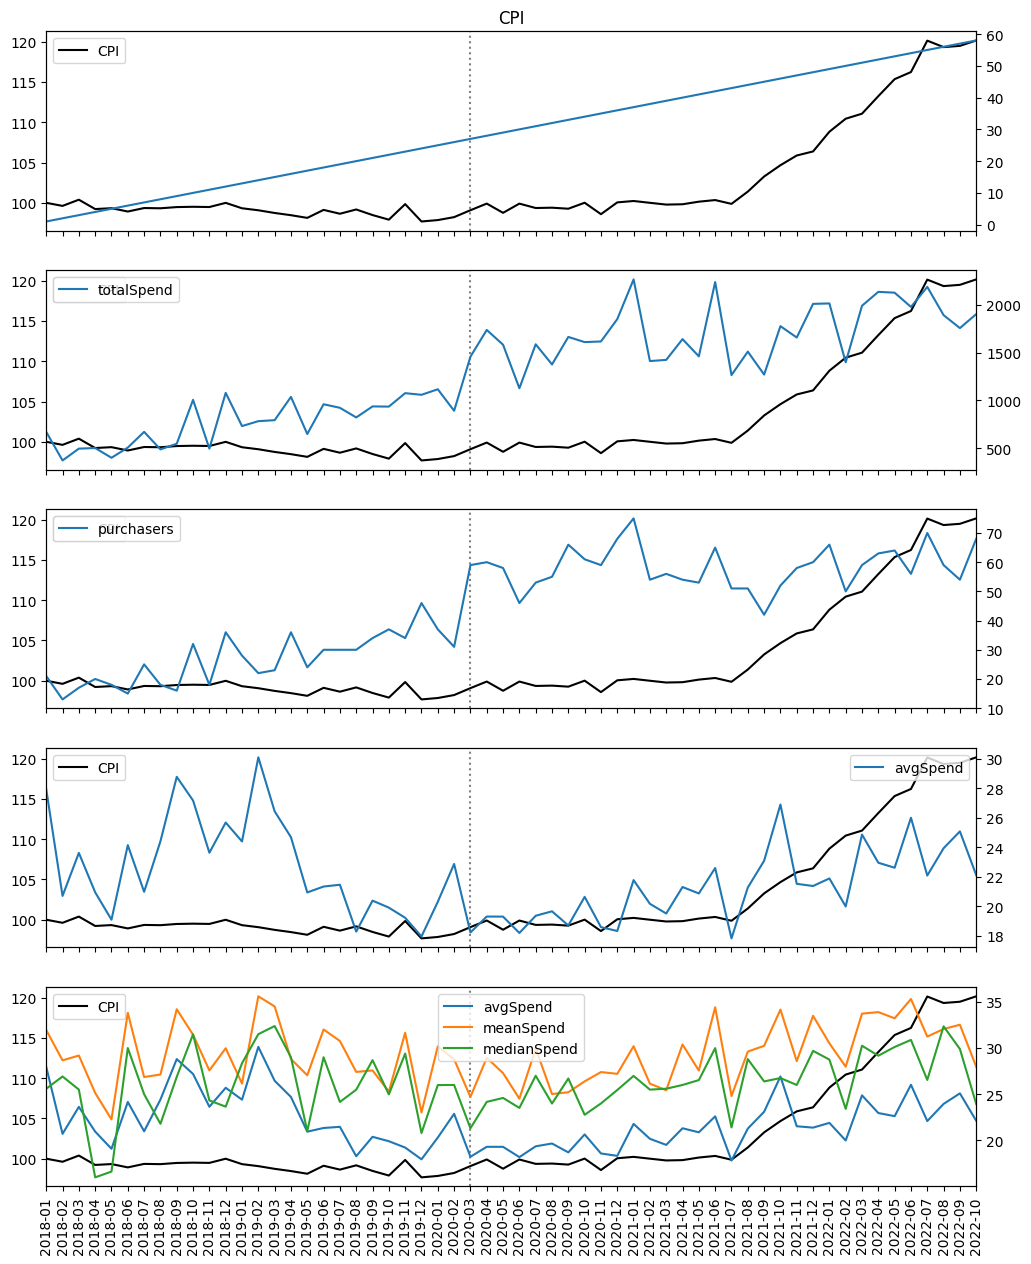

In [340]:
fig, axes = plt.subplots(5,1, figsize=(12, 5*3), sharex=True)

ax = axes[0]
ax.set_title('Coffee CPI')
plot_monthly_data(agg_metrics['CPI'], ax=ax, title='CPI', label='CPI', show_covid=True, color='black')
ax = ax.twinx()
plot_monthly_data(agg_metrics['month'], ax=ax)
ax = axes[1]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'totalSpend'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[2]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'purchasers'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[3]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'avgSpend'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[4]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
for c in ['avgSpend','meanSpend','medianSpend']:
    plot_monthly_data(agg_metrics[c], ax=ax, label=c)

In [354]:
# smooth the metrics except CPI data
cpi_series = agg_metrics['CPI']
for c in ['avgSpend','meanSpend','medianSpend', 'totalSpend','purchasers','purchases']:
    agg_metrics['%s_smoothed'%c] = agg_metrics[c].rolling(3, min_periods=1).mean()
agg_metrics.index = cpi_model_data.index
agg_metrics#.head()

month        CPI  CPI_lag_1m  totalSpend  purchases  purchasers   
DATE                                                                          
2018-01-01      1  100.00000    99.61838      670.76         24          21  \
2018-02-01      2   99.61838   100.38775      372.54         18          13   
2018-03-01      3  100.38775    99.22451      496.01         21          17   
2018-04-01      4   99.22451    99.33230      502.60         24          20   
2018-05-01      5   99.33230    98.91901      400.65         21          18   
2018-06-01      6   98.91901    99.35273      507.09         21          15   
2018-07-01      7   99.35273    99.32259      671.22         32          25   
2018-08-01      8   99.32259    99.47074      488.17         20          18   
2018-09-01      9   99.47074    99.50855      547.05         19          16   
2018-10-01     10   99.50855    99.47789     1005.69         37          32   
2018-11-01     11   99.47789    99.99438      496.26         21          18   
2018-12-01     12   99.99438    99.32310     1078.75         42          36   
2019-01-01     13   99.32310    99.07482      731.95         30          28   
2019-02-01     14   99.07482    98.74072      783.01         26          22   
2019-03-01     15   98.74072    98.46331      793.43         30          23   
2019-04-01     16   98.46331    98.13023     1036.89         42          36   
2019-05-01     17   98.13023    99.12233      648.90         31          24   
2019-06-01     18   99.12233    98.64314      959.98         45          30   
2019-07-01     19   98.64314    99.17495      922.60         43          30   
2019-08-01     20   99.17495    98.48273      822.10         45          30   
2019-09-01     21   98.48273    97.90902      937.26         46          34   
2019-10-01     22   97.90902    99.83908      935.24         47          37   
2019-11-01     23   99.83908    97.68271     1075.79         56          34   
2019-12-01     24   97.68271    97.85794     1058.43         59          46   
2020-01-01     25   97.85794    98.22423     1116.33         55          37   
2020-02-01     26   98.22423    99.08095      891.85         39          31   
2020-03-01     27   99.08095    99.90345     1456.90         80          59   
2020-04-01     28   99.90345    98.75860     1736.44         90          60   
2020-05-01     29   98.75860    99.89987     1581.67         82          58   
2020-06-01     30   99.89987    99.35580     1127.03         62          46   
2020-07-01     31   99.35580    99.39513     1586.45         82          53   
2020-08-01     32   99.39513    99.26691     1375.50         70          55   
2020-09-01     33   99.26691   100.01124     1663.26         89          66   
2020-10-01     34  100.01124    98.59001     1609.23         78          61   
2020-11-01     35   98.59001   100.05415     1615.90         87          59   
2020-12-01     36  100.05415   100.22682     1849.37        101          68   
2021-01-01     37  100.22682   100.00000     2264.22        104          75   
2021-02-01     38  100.00000    99.78084     1411.15         70          54   
2021-03-01     39   99.78084    99.82120     1423.45         73          56   
2021-04-01     40   99.82120   100.14202     1640.23         77          54   
2021-05-01     41  100.14202   100.34279     1460.40         70          53   
2021-06-01     42  100.34279    99.87075     2236.59         99          65   
2021-07-01     43   99.87075   101.39211     1264.44         71          51   
2021-08-01     44  101.39211   103.26546     1509.75         71          51   
2021-09-01     45  103.26546   104.66778     1269.74         55          42   
2021-10-01     46  104.66778   105.87445     1776.02         66          52   
2021-11-01     47  105.87445   106.37663     1656.94         77          58   
2021-12-01     48  106.37663   108.82164     2008.76         94          60   
2022-01-01     49  108.82164   110.44006     2013.35         9

Basic OLS

- with stratified sample OLS R2 better, MAE worse


In [355]:
data = agg_metrics
formula = 'CPI ~ month'
# formula = 'CPI ~ month + purchasers'
# formula = 'CPI ~ month + avgSpend'
# formula = 'CPI ~ month + purchasers + meanSpend_smoothed'
formula = 'CPI ~ month + purchases_smoothed + totalSpend_smoothed' # best
# formula = 'CPI ~ month + purchasers_smoothed + avgSpend_smoothed' # best
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=data).fit()
display(result.summary())

Formula:
CPI ~ month + purchases_smoothed + totalSpend_smoothed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     67.90
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           2.51e-18
Time:                        15:58:42   Log-Likelihood:                -144.13
No. Observations:                  58   AIC:                             296.3
Df Residuals:                      54   BIC:                             304.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              93.7863      1.396     67.186      0.000      90.988      96.585
month                   0.2172      0.086      2.517      0.015       0.044       0.390
purchases_smoothed     -0.5726      0.073     -7.897      0.000      -0.718      -0.427
totalSpend_smoothed     0.0285      0.005      5.568      0.000       0.018       0.039
==============================================================================
Omnibus:                        0.603   Durbin-Watson:                   0.305
Prob(Omnibus):                  0.740   Jarque-Bera (JB):                0.715
Skew:                          -0.116   Prob(JB):                        0.699
Kurtosis:                       2.507   Cond. No.                     4.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [356]:
print('OLS predictions')
predictions, errors, mae, train_res = train_predict_one_step_ahead_ols(
    data, formula, 
    pred_start='2020-01-01',
    verbose=True,
)
print('MAE %0.4f' % mae)
train_res.summary()

OLS predictions
initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-10-01 00:00:00
Formula:
CPI ~ month + purchases_smoothed + totalSpend_smoothed

0 2019-12-01 00:00:00
AIC: 39.518
12 2020-12-01 00:00:00
AIC: 65.696
24 2021-12-01 00:00:00
AIC: 156.623
MAE 2.9697


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     61.90
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           2.50e-17
Time:                        15:58:47   Log-Likelihood:                -139.64
No. Observations:                  57   AIC:                             287.3
Df Residuals:                      53   BIC:                             295.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              93.5597      1.352     69.188      0.000      90.847      96.272
month                   0.1722      0.086      2.007      0.050    7.08e-05       0.344
purchases_smoothed     -0.5569      0.070     -7.910      0.000      -0.698      -0.416
totalSpend_smoothed     0.0289      0.005      5.841      0.000       0.019       0.039
==============================================================================
Omnibus:                        0.173   Durbin-Watson:                   0.335
Prob(Omnibus):                  0.917   Jarque-Bera (JB):                0.376
Skew:                          -0.011   Prob(JB):                        0.829
Kurtosis:                       2.603   Cond. No.                     4.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MAE for COFFEE CPI: 2.9697


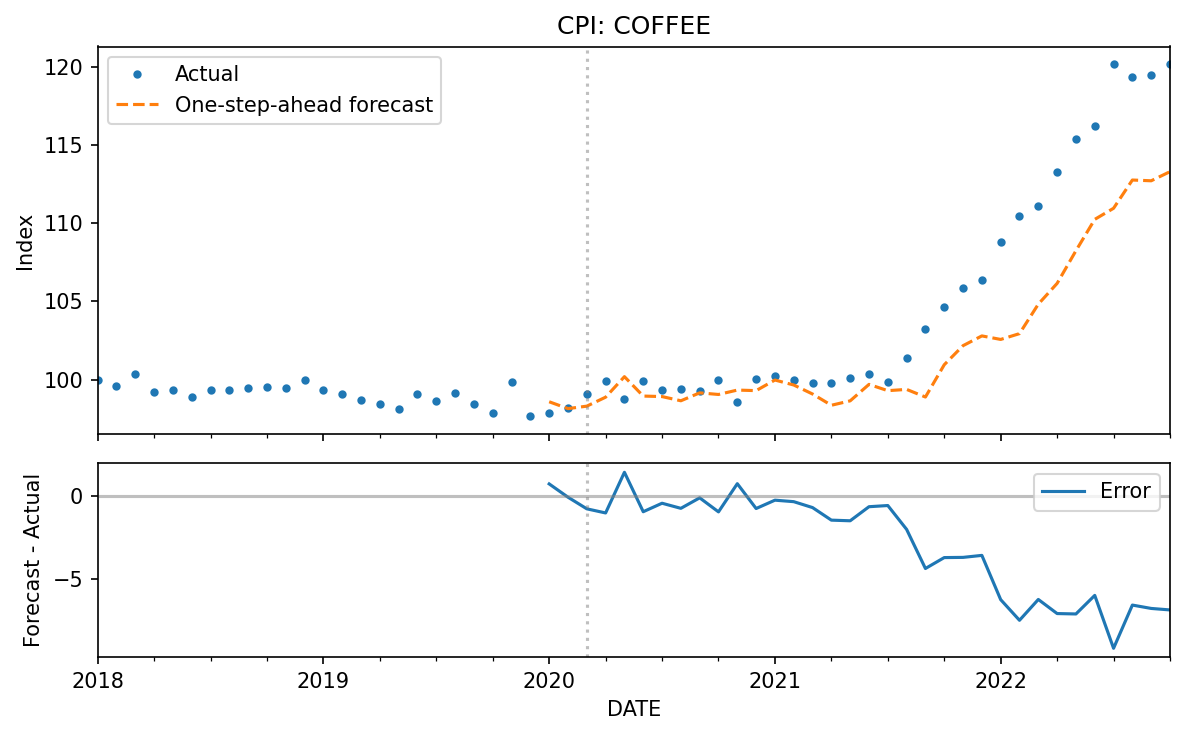

In [358]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions, ax=axes[0])
ax.set(title='CPI: %s'%cpi_cat, xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors, ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

In [369]:
# exog_vars = ['purchasers_smoothed', 'avgSpend_smoothed'] # doesn't work
exog_vars = ['purchases_smoothed', 'totalSpend_smoothed']
exog = data[exog_vars]
exog.head()

purchases_smoothed  totalSpend_smoothed
DATE                                               
2018-01-01                24.0           670.760000
2018-02-01                21.0           521.650000
2018-03-01                21.0           513.103333
2018-04-01                21.0           457.050000
2018-05-01                22.0           466.420000

In [370]:
cpi_cat = 'COFFEE'
cpi_series = cpi_model_data[cpi_cat]

In [371]:
print('CPI: %s' % cpi_cat)
# train through first 2 years of data
predictions, errors, mae = sarimax_train_predict_one_step_ahead(
    cpi_series, 
    exog=exog,
    pred_start='2020-01-01', pred_end='2022-11-01',
    verbose=True
)
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

CPI: COFFEE
initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-11-01


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0 2019-12-01 00:00:00
AIC: 38.256


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12 2020-12-01 00:00:00
AIC: 64.654


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

24 2021-12-01 00:00:00
AIC: 118.602


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE for COFFEE CPI: 1.3298


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE for COFFEE CPI: 1.3298


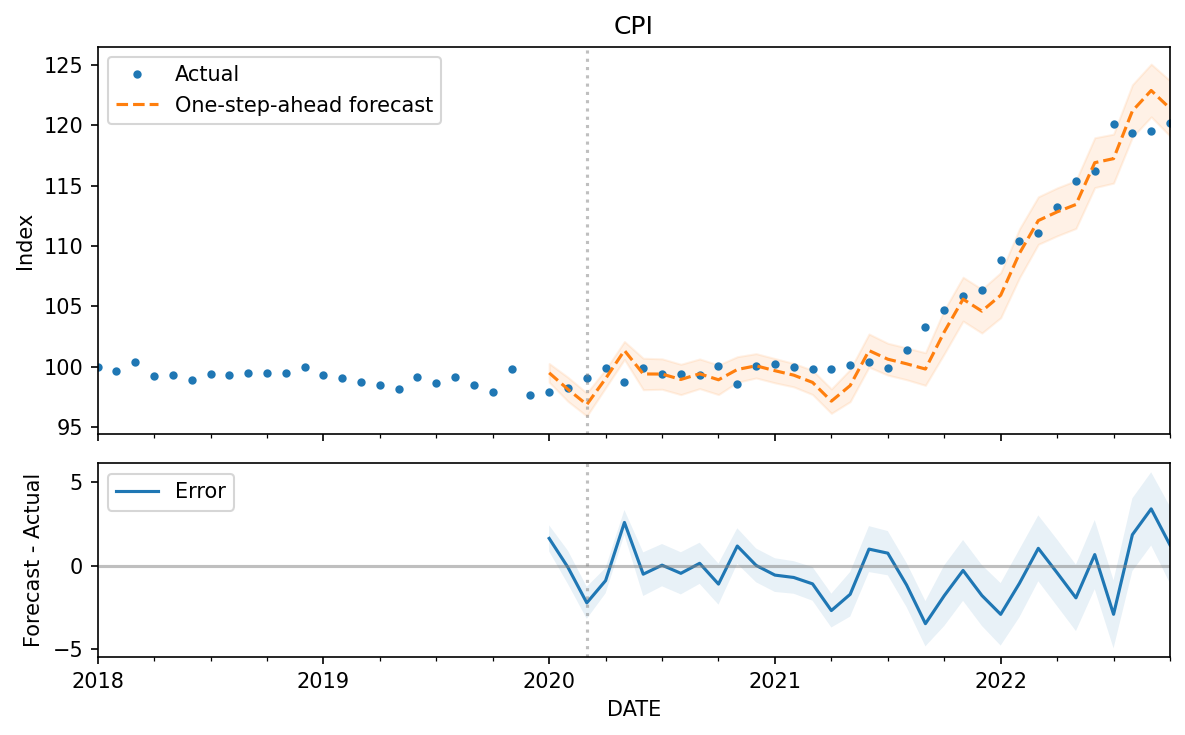

In [372]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions['mean'], predictions['mean_ci_lower'],
                       predictions['mean_ci_upper'], ax=axes[0])
ax.set(title='CPI', xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors['mean'], errors['ci_lower'], errors['ci_upper'], 
                 ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

#### With item specific purchases data

Initial questions (without restricting to specific products)

Over the months how many...?

- unique products being purchased
- unique people purchasing products
- total purchases
- median price

In [114]:
coffee_monthly_purchases = get_monthly_series(coffee_purchases)
coffee_monthly_purchases.head()

total purchases  unique products  purchasers  med price
yyyy-mm                                                         
2018-01               70               64          60     17.795
2018-02               88               81          70     15.375
2018-03               80               72          67     18.875
2018-04               74               69          60     15.990
2018-05               77               71          69     18.000

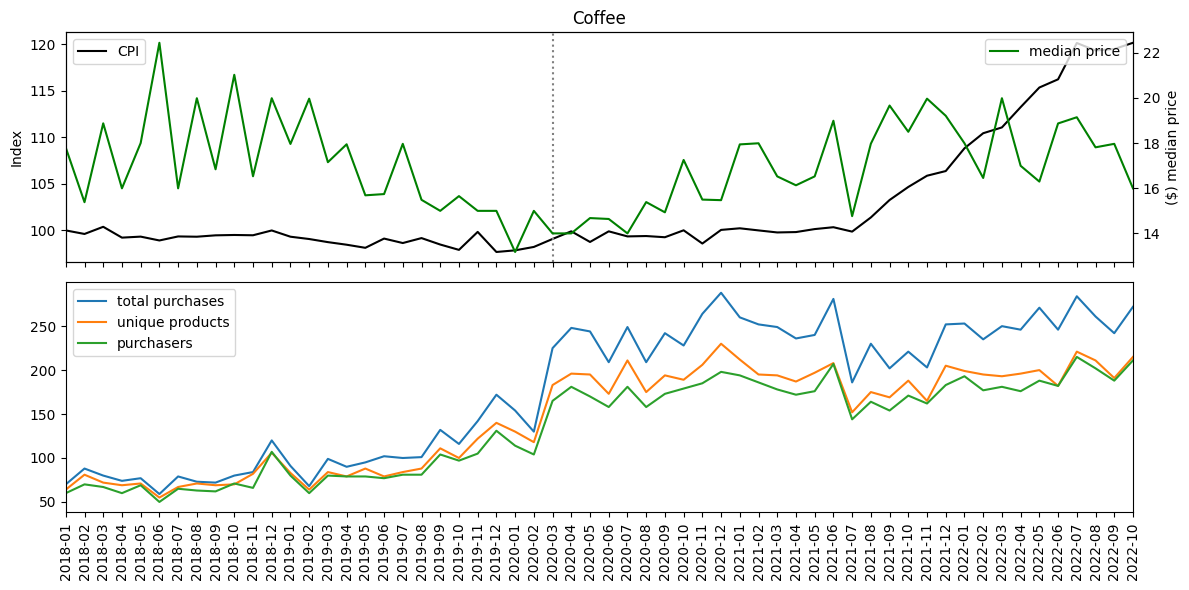

In [115]:
title = 'Coffee'
fig, axes = plt.subplots(2,1, figsize=(12,2*3), sharex=True)
plot_monthly_data(cpi_data['COFFEE'], ax=axes[0], ylabel='Index', color='black', title=title, label='CPI', show_covid=True)
ax2 = axes[0].twinx()
plot_monthly_data(coffee_monthly_purchases['med price'], ax=ax2, label='median price', ylabel='($) median price', color='green')

for col in ['total purchases','unique products', 'purchasers']:
    plot_monthly_data(coffee_monthly_purchases[col], label=col, ax=axes[1])
plt.tight_layout()

In [116]:
print('What are the most popular coffee products? By total purchasers and unique purchases:')
display(coffee_purchases.groupby(['Title', 'ASIN/ISBN (Product Code)'])[
    'Survey ResponseID'
].agg(['count', 'nunique']).sort_values('count', ascending=False).head(10))
print('Are some of these the same product? Look them up on Amazon.')

What are the most popular coffee products? By total purchasers and unique purchases:


count   
Title                                              ASIN/ISBN (Product Code)          
Amazon Brand - 100 Ct. Solimo Dark Roast Coffee... B079V8CKDM                  105  \
Amazon Brand - 100 Ct. Solimo Dark Roast Coffee... B079V9JDQB                   92   
Amazon Brand - 100 Ct. Solimo Light Roast Coffe... B079V7F2BP                   92   
Nespresso Capsules OriginalLine, Ispirazione Va... B0099HD3YA                   85   
Hills Bros Instant White Chocolate Caramel Deca... B005Z6AK2C                   84   
McCafe Premium Medium Roast K-Cup Coffee Pods, ... B00TY15GO6                   83   
Dunkin' Original Blend Medium Roast Ground Coff... B009HSNDI2                   76   
Crave Beverages Flavored Coffee Pods Sampler, C... B07M7PQDH3                   69   
Kicking Horse Coffee, Kick Ass, Dark Roast, Who... B0027Z8VES                   67   
Death Wish Coffee Dark Roast Grounds - 16 Oz - ... B006CQ1ZHI                   60   

                                                                             nunique  
Title                                              ASIN/ISBN (Product Code)           
Amazon Brand - 100 Ct. Solimo Dark Roast Coffee... B079V8CKDM                     25  
Amazon Brand - 100 Ct. Solimo Dark Roast Coffee... B079V9JDQB                     18  
Amazon Brand - 100 Ct. Solimo Light Roast Coffe... B079V7F2BP                     16  
Nespresso Capsules OriginalLine, Ispirazione Va... B0099HD3YA                     10  
Hills Bros Instant White Chocolate Caramel Deca... B005Z6AK2C                     15  
McCafe Premium Medium Roast K-Cup Coffee Pods, ... B00TY15GO6                     12  
Dunkin' Original Blend Medium Roast Ground Coff... B009HSNDI2                     30  
Crave Beverages Flavored Coffee Pods Sampler, C... B07M7PQDH3                     23  
Kicking Horse Coffee, Kick Ass, Dark Roast, Who... B0027Z8VES                      7  
Death Wish Coffee Dark Roast Grounds - 16 Oz - ... B006CQ1ZHI                     23

Are some of these the same product? Look them up on Amazon.


In [117]:
print('How many products have M months of purchases data?')
coffee_months = coffee_purchases.groupby(
    ['ASIN/ISBN (Product Code)']
)['yyyy-mm'].nunique()
for m in [12, 24, 36, 48]:
    c = coffee_months[coffee_months >= m]
    print('%s products have at least M=%s months of purchases' % (len(c), m))
print('\nmonths of purchases for each product:')
coffee_months.describe()

How many products have M months of purchases data?
141 products have at least M=12 months of purchases
37 products have at least M=24 months of purchases
14 products have at least M=36 months of purchases
0 products have at least M=48 months of purchases

months of purchases for each product:


count    2519.000000
mean        3.354109
std         5.139598
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        45.000000
Name: yyyy-mm, dtype: float64

In [118]:
coffee_products_titles = coffee_purchases.set_index(
    'ASIN/ISBN (Product Code)'
).drop_duplicates(keep='last')['Title'].to_dict()

In [119]:
min_M = 36
coffee_products_M = coffee_months[coffee_months >= min_M].index
print('restricting to %s products with at least M=%s months of data' % 
      (len(coffee_products_M), min_M))
cm_purchases = coffee_purchases[coffee_purchases['ASIN/ISBN (Product Code)'].isin(coffee_products_M)]
d = cm_purchases.groupby('ASIN/ISBN (Product Code)')[
    'Survey ResponseID'
].agg(['count','nunique']).sort_values('count', ascending=False)
d['Title'] = d.index.map(coffee_products_titles)
with pd.option_context('display.max_colwidth', None):
    display(d.sort_values('Title'))

restricting to 14 products with at least M=36 months of data


count  nunique   
ASIN/ISBN (Product Code)                   
B079V8CKDM                  106       26  \
B079V9JDQB                   92       18   
B079V7F2BP                   92       16   
B00EDHW7UW                   36        1   
B006CQ1ZHI                   60       23   
B009HSNDI2                   76       30   
B002SJUNU8                   50       13   
B005Z6AK2C                   84       15   
B00PV4FG3Q                   49        4   
B0002E2EYY                   52        3   
B000SDKDM4                   71       21   
B00TY15GO6                   83       12   
B0099HD3YA                   95       18   
B00DS4Q1IK                   59       11   

                                                                                                                                                                                                                  Title  
ASIN/ISBN (Product Code)                                                                                                                                                                                                 
B079V8CKDM                                                                                          Amazon Brand - 100 Ct. Solimo Dark Roast Coffee Pods, Compatible with Keurig 2.0 K-Cup Brewers 100 Count(Pack of 1)  
B079V9JDQB                                                                                                 Amazon Brand - 100 Ct. Solimo Dark Roast Coffee Pods, French Roast, Compatible with Keurig 2.0 K-Cup Brewers  
B079V7F2BP                                                                                             Amazon Brand - 100 Ct. Solimo Light Roast Coffee Pods, Breakfast Blend, Compatible with Keurig 2.0 K-Cup Brewers  
B00EDHW7UW                                                                                                                    Caza Trail Coffee Pods, Donut Shop Blend, Single Serve (Pack of 100) (Packaging May Vary)  
B006CQ1ZHI                Death Wish Coffee Dark Roast Grounds - 16 Oz - Extra Kick of Caffeine - Bold & Intense Blend of Arabica & Robusta Beans - USDA Organic Ground Coffee - Dark Coffee Caffeine for Morning Boost  
B009HSNDI2                                                                                                                                                 Dunkin' Original Blend Medium Roast Ground Coffee, 12 Ounces  
B002SJUNU8                                          Hills Bros Instant Sugar-Free Decadent Cappuccino Mix, Easy to Use, Enjoy Coffeehouse Flavor from Home-Frothy, with 0% Sugar and 8g of Carbs, French Vanilla, 12 Oz  
B005Z6AK2C                                                            Hills Bros Instant White Chocolate Caramel Decadent Cappuccino Mix, Easy to Use, Enjoy Coffeehouse Flavor from Home, Frothy, 16 Ounce (Pack of 1)  
B00PV4FG3Q                                                       Koffee Kult Dark Roast Whole Bean Coffee - Small Batch Gourmet Aromatic Artisan Blend 100% Arabica Coffee Beans Organically Sourced (Dark Roast, 32oz)  
B0002E2EYY                     Lavazza Dek Whole Bean Coffee Blend, Decaffeinated Dark Espresso Roast, 1.1-Pound Bag , Authentic Italian, Blended and roasted in Italy, Creamy with smooth flavor and exceptional aroma  
B000SDKDM4                                                                  Lavazza Super Crema Whole Bean Coffee Blend, light-Medium Espresso Roast, 2.2 Pound (Pack of 1) ,Premium Quality, Aromatic, Mild and creamy  
B00TY15GO6                                                                                                                                       McCafe Premium Medium Roast K-Cup Coffee Pods, Premium Roast, 84 Count  
B0099HD3YA                                                   Nespresso Capsules OriginalLine, Ispirazione Variety Pack, Medium & Dark Roast Espresso Coffee, 10 Count (Pack of 5), Brews 1.35 Ounce (ORIGINALLINE ONLY)  
B00DS4Q1IK                                         

Manual inspection shows first three product codes are actually the same product, different flavors.

- Amazon Brand - 100 Ct. Solimo Dark Roast Coffee Pods, Compatible with Keurig 2.0 K-Cup Brewers 100 Count(Pack of 1) B079V8CKDM
    - https://www.amazon.com/Amazon-Brand-Solimo-Compatible-Brewers/dp/B079V8CKDM
- Amazon Brand - 100 Ct. Solimo Light Roast Coffee Pods, Breakfast Blend, Compatible with Keurig 2.0 K-Cup Brewers	B079V7F2BP
    - https://www.amazon.com/Amazon-Brand-Breakfast-Compatible-Brewers/dp/B079V7F2BP
- Amazon Brand - 100 Ct. Solimo Dark Roast Coffee Pods, French Roast, Compatible with Keurig 2.0 K-Cup Brewers	B079V9JDQB
    - https://www.amazon.com/Amazon-Brand-Solimo-Compatible-Brewers/dp/B079V9JDQB


I looked through titles and looked up products with M=24 and there were no more repeated products.

In [120]:
coffee_quarters = coffee_purchases[coffee_purchases['ASIN/ISBN (Product Code)'].isin(coffee_products_M)].groupby(
    ['ASIN/ISBN (Product Code)']
)['quarter'].agg(['nunique', 'min', 'max', 'count'])
print('distribution of unique quarters per item')
display(coffee_quarters.describe())
coffee_quarters['Title'] = coffee_quarters.index.map(coffee_products_titles)
coffee_quarters.sort_values('nunique', ascending=False)

distribution of unique quarters per item


nunique        min        max       count
count  14.000000  14.000000  14.000000   14.000000
mean   16.928571   2.857143  19.714286   71.785714
std     1.639150   2.107026   0.611250   21.101143
min    14.000000   1.000000  18.000000   36.000000
25%    15.250000   1.000000  20.000000   53.750000
50%    17.500000   2.000000  20.000000   73.500000
75%    18.000000   3.750000  20.000000   90.000000
max    19.000000   7.000000  20.000000  106.000000

nunique  min  max  count   
ASIN/ISBN (Product Code)                             
B002SJUNU8                     19    1   20     50  \
B079V8CKDM                     19    2   20    106   
B006CQ1ZHI                     18    1   20     60   
B0099HD3YA                     18    3   20     95   
B009HSNDI2                     18    1   20     76   
B00EDHW7UW                     18    1   18     36   
B079V9JDQB                     18    2   19     92   
B000SDKDM4                     17    3   20     71   
B079V7F2BP                     17    4   20     92   
B00DS4Q1IK                     16    1   19     59   
B0002E2EYY                     15    6   20     52   
B005Z6AK2C                     15    2   20     84   
B00PV4FG3Q                     15    6   20     49   
B00TY15GO6                     14    7   20     83   

                                                                      Title  
ASIN/ISBN (Product Code)                                                     
B002SJUNU8                Hills Bros Instant Sugar-Free Decadent Cappucc...  
B079V8CKDM                Amazon Brand - 100 Ct. Solimo Dark Roast Coffe...  
B006CQ1ZHI                Death Wish Coffee Dark Roast Grounds - 16 Oz -...  
B0099HD3YA                Nespresso Capsules OriginalLine, Ispirazione V...  
B009HSNDI2                Dunkin' Original Blend Medium Roast Ground Cof...  
B00EDHW7UW                Caza Trail Coffee Pods, Donut Shop Blend, Sing...  
B079V9JDQB                Amazon Brand - 100 Ct. Solimo Dark Roast Coffe...  
B000SDKDM4                Lavazza Super Crema Whole Bean Coffee Blend, l...  
B079V7F2BP                Amazon Brand - 100 Ct. Solimo Light Roast Coff...  
B00DS4Q1IK                Starbucks Ready to Drink Coffee, Espresso & Cr...  
B0002E2EYY                Lavazza Dek Whole Bean Coffee Blend, Decaffein...  
B005Z6AK2C                Hills Bros Instant White Chocolate Caramel Dec...  
B00PV4FG3Q                Koffee Kult Dark Roast Whole Bean Coffee - Sma...  
B00TY15GO6                McCafe Premium Medium Roast K-Cup Coffee Pods,...

Restrict to items with at least 18 unique quarters of data.

In [121]:
min_Q = 18
coffee_products_Q = coffee_quarters[coffee_quarters['nunique'] >= min_Q].index
print('Restricting to %s coffee products iwth at least %s unique months of data' % (
len(coffee_products_Q), min_Q))

Restricting to 7 coffee products iwth at least 18 unique months of data


In [122]:
# make a list of product codes that is a list of lists [[codes], ...]
# where codes are for the same product
duplicate_codes = [['B079V8CKDM', 'B079V7F2BP', 'B079V9JDQB']]
coffee_product_codes = []
for p_code in coffee_products_Q:
    if any(p_code in dcodes for dcodes in duplicate_codes):
        continue
    coffee_product_codes += [[p_code]]
coffee_product_codes += duplicate_codes
print('%s distinct products' % len(coffee_product_codes))
# coffee_product_codes

6 distinct products


In [125]:
def make_price_index_df(product_codes, cpi, base_price_B=3):
    """
    Returns a dataframe with columns for each product in product_codes:
    _med_price: median price, including nan when missing
    _price: median price with nan filled in: fill with first available as 0th and then previous
    _idx represents the index: med_price1/base; base is mean of first base_price_B prices
    _purchases
    _purchasers
    
    product_codes is a list of lists, where most lists are single elements
    lists with multiple p codes correspond to the same product
    """
    pnames = []
    df = pd.DataFrame({
        'yyyy-mm': amzn_data_idx,
        'month': sorted(list(month_labels.values())[:len(amzn_data_idx)]),
        'CPI': cpi,
        'CPI_lag_1m': cpi.shift(-1),
    }).set_index('yyyy-mm')
    for p_codes in product_codes:
        p = '_'.join(p_codes)
        pdf = amzn_data[amzn_data['ASIN/ISBN (Product Code)'].isin(p_codes)]
        df = df.merge(pdf.groupby('yyyy-mm')['unit price'].agg(
            ['median', 'count']
        ).rename(columns={
            'median': '%s_med_price'%p,
            'count': '%s_purchases'%p,
        }), right_index=True, left_index=True, how='outer')
        p_med_price = df['%s_med_price'%p]
        p_price = [p_med_price.dropna().values[0]]
        for i, price in enumerate(p_med_price[1:]):
            p_price += [p_price[-1] if math.isnan(price) else price]
        df['%s_price' % p] = p_price
        p_base = np.mean(p_price[:base_price_B])
        df['%s_idx' % p] = 100*(p_price/p_base)
        # fill missing purchases with 0's  
        df['%s_purchases' % p] = df['%s_purchases' % p].fillna(0)
        # add number of distinct purchasers
        df['%s_purchasers' % p] = pdf.groupby('yyyy-mm')['Survey ResponseID'].nunique().reindex(amzn_data_idx).fillna(0)
        pnames += [p]
    return df, pnames

In [126]:
coffee_idx_df, pnames = make_price_index_df(coffee_product_codes, cpi_data['COFFEE'])
coffee_idx_df.head()

month        CPI  CPI_lag_1m  B002SJUNU8_med_price   
yyyy-mm                                                       
2018-01      1  100.00000    99.61838                  3.17  \
2018-02      2   99.61838   100.38775                   NaN   
2018-03      3  100.38775    99.22451                   NaN   
2018-04      4   99.22451    99.33230                  3.62   
2018-05      5   99.33230    98.91901                  3.62   

         B002SJUNU8_purchases  B002SJUNU8_price  B002SJUNU8_idx   
yyyy-mm                                                           
2018-01                   1.0              3.17      100.000000  \
2018-02                   0.0              3.17      100.000000   
2018-03                   0.0              3.17      100.000000   
2018-04                   1.0              3.62      114.195584   
2018-05                   1.0              3.62      114.195584   

         B002SJUNU8_purchasers  B006CQ1ZHI_med_price  B006CQ1ZHI_purchases   
yyyy-mm                                                                      
2018-01                    1.0                 19.99                   1.0  \
2018-02                    0.0                   NaN                   0.0   
2018-03                    0.0                   NaN                   0.0   
2018-04                    1.0                 19.99                   2.0   
2018-05                    1.0                 19.99                   2.0   

         ...  B00EDHW7UW_med_price  B00EDHW7UW_purchases  B00EDHW7UW_price   
yyyy-mm  ...                                                                 
2018-01  ...                 34.99                   1.0             34.99  \
2018-02  ...                   NaN                   0.0             34.99   
2018-03  ...                 34.99                   1.0             34.99   
2018-04  ...                 34.99                   1.0             34.99   
2018-05  ...                 34.99                   1.0             34.99   

         B00EDHW7UW_idx  B00EDHW7UW_purchasers   
yyyy-mm                                          
2018-01           100.0                    1.0  \
2018-02           100.0                    0.0   
2018-03           100.0                    1.0   
2018-04           100.0                    1.0   
2018-05           100.0                    1.0   

         B079V8CKDM_B079V7F2BP_B079V9JDQB_med_price   
yyyy-mm                                               
2018-01                                         NaN  \
2018-02                                         NaN   
2018-03                                         NaN   
2018-04                                         NaN   
2018-05                                         NaN   

         B079V8CKDM_B079V7F2BP_B079V9JDQB_purchases   
yyyy-mm                                               
2018-01                                         0.0  \
2018-02                                         0.0   
2018-03                                         0.0   
2018-04                                         0.0   
2018-05                                         0.0   

         B079V8CKDM_B079V7F2BP_B079V9JDQB_price   
yyyy-mm                                           
2018-01                                   33.79  \
2018-02                                   33.79   
2018-03                                   33.79   
2018-04                                   33.79   
2018-05                                   33.79   

         B079V8CKDM_B079V7F2BP_B079V9JDQB_idx   
yyyy-mm                                         
2018-01                                 100.0  \
2018-02                                 100.0   
2018-03                                 100.0   
2018-04                                 100.0   
2018-05                                 100.0   

         B079V8CKDM_B079V7F2BP_B079V9JDQB_purchasers  
yyyy-mm                                               
2018-01                                          0.0  
2018-02      

Plots

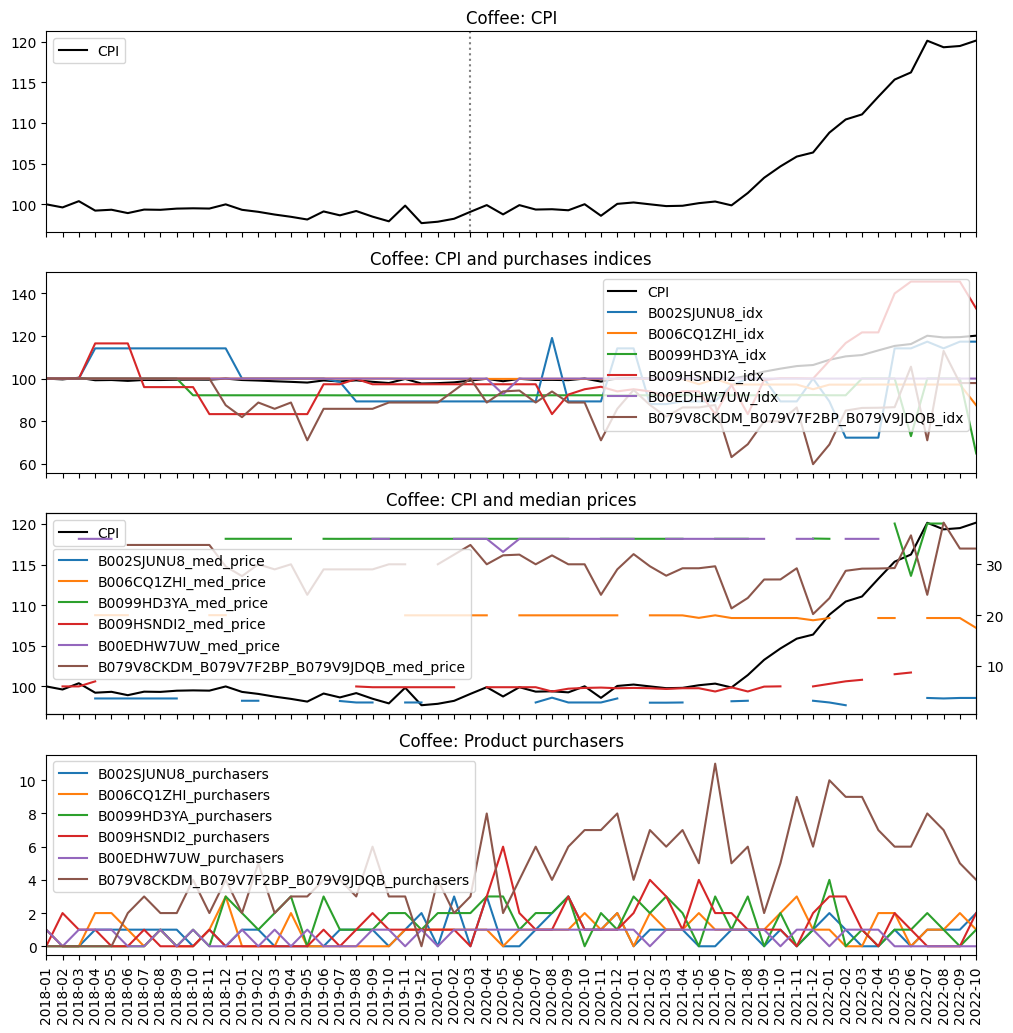

In [127]:
fig, axes = plt.subplots(4,1, figsize=(12, 4*3), sharex=True)

plot_monthly_data(coffee_idx_df['CPI'], ax=axes[0], 
                          title='Coffee: CPI',
                          label='CPI', show_covid=True, color='black')
ax = axes[1]
ax.set_title('Coffee: CPI and purchases indices')
plot_monthly_data(coffee_idx_df['CPI'], ax=ax, label='CPI', color='black')
for c in [idx for idx in coffee_idx_df.columns if ('_idx' in idx)]:
    plot_monthly_data(coffee_idx_df[c], ax=ax, label=c)
# add median price including missing values
ax = axes[2]
ax.set_title('Coffee: CPI and median prices')
plot_monthly_data(coffee_idx_df['CPI'], ax=ax, label='CPI', color='black')
ax = ax.twinx()
for c in [col for col in coffee_idx_df.columns if ('_med_price' in col)]:
    plot_monthly_data(coffee_idx_df[c], ax=ax, label=c)
# add number of purchases
ax = axes[3]
ax.set_title('Coffee: Product purchasers')
for c in [col for col in coffee_idx_df.columns if ('_purchasers' in col)]:
    plot_monthly_data(coffee_idx_df[c], ax=ax, label=c)

In [128]:
# smooth the values as a mean computed as the present value and the immediate previous value
# similar to order (2,1,1)
for col in [c for c in coffee_idx_df.columns if ('_idx' in c) or ('_purchases' in c) or ('_purchasers' in c)]:
    coffee_idx_df[col+'_smoothed'] = coffee_idx_df[col].rolling(2, min_periods=1).mean()
    coffee_idx_df[col+'_smoothed3'] = coffee_idx_df[col].rolling(3, min_periods=1).mean()

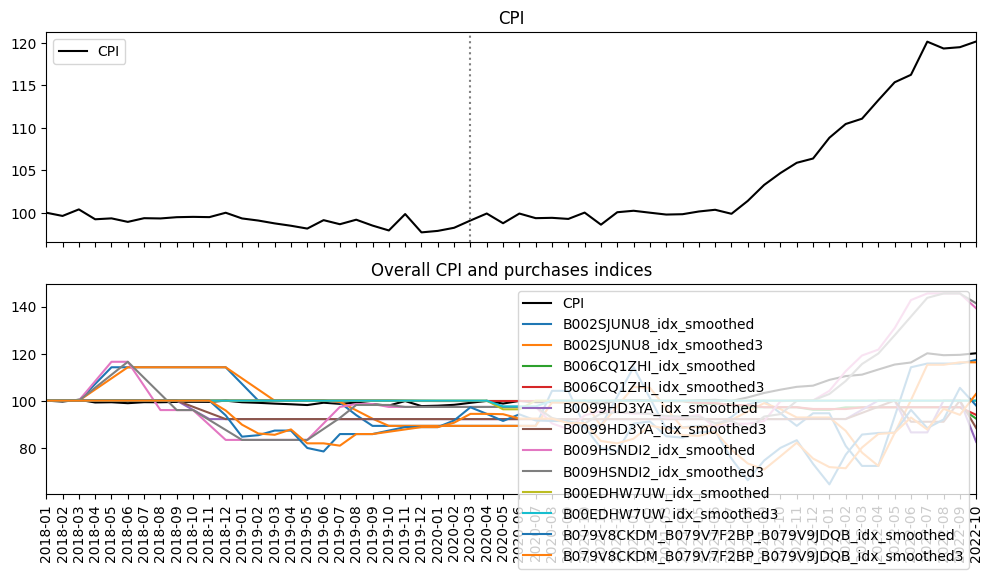

In [129]:
fig, axes = plt.subplots(2,1, figsize=(12, 2*3), sharex=True)

plot_monthly_data(coffee_idx_df['CPI'], ax=axes[0], title='CPI', label='CPI', show_covid=True, color='black')
ax = axes[1]
ax.set_title('Overall CPI and purchases indices')
plot_monthly_data(coffee_idx_df['CPI'], ax=ax, label='CPI', color='black')
for c in [idx for idx in coffee_idx_df.columns if ('_idx_smoothed' in idx)]:
    plot_monthly_data(coffee_idx_df[c], ax=ax, label=c)

In [130]:
coffee_idx_df.index = cpi_model_data.index

Linear regression to build intuition

Notes:
- fit slightly better when purchases data included vs not included
- R2 slightly better for purchasers vs purchases
- lagging by 1 month can improve fit

In [131]:
formula = 'CPI ~ month'
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=coffee_idx_df).fit()
display(result.summary())

Formula:
CPI ~ month


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     62.67
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           1.06e-10
Time:                        14:24:47   Log-Likelihood:                -167.68
No. Observations:                  58   AIC:                             339.4
Df Residuals:                      56   BIC:                             343.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     94.3861      1.180     79.991      0.000      92.022      96.750
month          0.2754      0.035      7.917      0.000       0.206       0.345
==============================================================================
Omnibus:                        4.540   Durbin-Watson:                   0.056
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.472
Skew:                           0.654   Prob(JB):                        0.107
Kurtosis:                       2.629   Cond. No.                         68.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [132]:
data = coffee_idx_df[['CPI', 'CPI_lag_1m', 'month'] + [c for c in coffee_idx_df.columns if ('_idx' in c) or ('_purchases' in c) or ('_purchasers' in c)]]

In [133]:
# Experiment with lags
formula = 'CPI ~ '
formula += 'month + '
# s = ['%s_idx_smoothed' % (p) for p in pnames]
# s = ['%s_idx_smoothed3' % (p) for p in pnames]
# s = ['%s_idx' % (p) for p in pnames]
# s = ['%s_idx_smoothed + %s_purchases_smoothed' % (p, p) for p in pnames]
s = ['%s_idx_smoothed3 + %s_purchases_smoothed3' % (p, p) for p in pnames]
# s = ['%s_idx + %s_purchases' % (p, p) for p in pnames]
# s = ['%s_idx + %s_purchasers' % (p, p) for p in pnames]
formula += ' + '.join(s)
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=data).fit()
display(result.summary())

Formula:
CPI ~ month + B002SJUNU8_idx_smoothed3 + B002SJUNU8_purchases_smoothed3 + B006CQ1ZHI_idx_smoothed3 + B006CQ1ZHI_purchases_smoothed3 + B0099HD3YA_idx_smoothed3 + B0099HD3YA_purchases_smoothed3 + B009HSNDI2_idx_smoothed3 + B009HSNDI2_purchases_smoothed3 + B00EDHW7UW_idx_smoothed3 + B00EDHW7UW_purchases_smoothed3 + B079V8CKDM_B079V7F2BP_B079V9JDQB_idx_smoothed3 + B079V8CKDM_B079V7F2BP_B079V9JDQB_purchases_smoothed3


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     98.84
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           4.08e-28
Time:                        14:24:49   Log-Likelihood:                -90.625
No. Observations:                  58   AIC:                             209.2
Df Residuals:                      44   BIC:                             238.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                              235.6443     51.903      4.540      0.000     131.041     340.247
month                                                    0.0372      0.054      0.690      0.494      -0.072       0.146
B002SJUNU8_idx_smoothed3                                -0.0171      0.028     -0.617      0.541      -0.073       0.039
B002SJUNU8_purchases_smoothed3                          -0.8722      0.452     -1.931      0.060      -1.783       0.038
B006CQ1ZHI_idx_smoothed3                                -1.6821      0.315     -5.346      0.000      -2.316      -1.048
B006CQ1ZHI_purchases_smoothed3                          -0.3848      0.428     -0.898      0.374      -1.248       0.479
B0099HD3YA_idx_smoothed3                                 0.0873      0.095      0.915      0.365      -0.105       0.279
B0099HD3YA_purchases_smoothed3                           0.6733      0.411      1.637      0.109      -0.156       1.502
B009HSNDI2_idx_smoothed3                                 0.2068      0.032      6.527      0.000       0.143       0.271
B009HSNDI2_purchases_smoothed3                          -1.3599      0.311     -4.377      0.000      -1.986      -0.734
B00EDHW7UW_idx_smoothed3                                -0.0170      0.459     -0.037      0.971      -0.941       0.907
B00EDHW7UW_purchases_smoothed3                          -0.6907      0.971     -0.711      0.481      -2.648       1.267
B079V8CKDM_B079V7F2BP_B079V9JDQB_idx_smoothed3           0.0696      0.042      1.663      0.103      -0.015       0.154
B079V8CKDM_B079V7F2BP_B079V9JDQB_purchases_smoothed3     0.5659      0.179      3.165      0.003       0.206       0.926
==============================================================================
Omnibus:                        0.819   Durbin-Watson:                   1.088
Prob(Omnibus):                  0.664   Jarque-Bera (JB):                0.631
Skew:                           0.253   Prob(JB):                        0.730
Kurtosis:                       2.937   Cond. No.                     7.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [134]:
print('OLS predictions')
predictions, errors, mae, train_res = train_predict_one_step_ahead_ols(
    data, formula, 
    pred_start='2020-01-01',
    #pred_end='2021-05-01',
    verbose=True,
)
print('MAE %0.4f' % mae)

OLS predictions
initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-10-01 00:00:00
Formula:
CPI ~ month + B002SJUNU8_idx_smoothed3 + B002SJUNU8_purchases_smoothed3 + B006CQ1ZHI_idx_smoothed3 + B006CQ1ZHI_purchases_smoothed3 + B0099HD3YA_idx_smoothed3 + B0099HD3YA_purchases_smoothed3 + B009HSNDI2_idx_smoothed3 + B009HSNDI2_purchases_smoothed3 + B00EDHW7UW_idx_smoothed3 + B00EDHW7UW_purchases_smoothed3 + B079V8CKDM_B079V7F2BP_B079V9JDQB_idx_smoothed3 + B079V8CKDM_B079V7F2BP_B079V9JDQB_purchases_smoothed3

0 2019-12-01 00:00:00
AIC: 43.528
12 2020-12-01 00:00:00
AIC: 67.784
24 2021-12-01 00:00:00
AIC: 117.470
MAE 2.9123


In [135]:
train_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     89.72
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           9.19e-27
Time:                        14:24:50   Log-Likelihood:                -87.435
No. Observations:                  57   AIC:                             202.9
Df Residuals:                      43   BIC:                             231.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                              280.4995     56.246      4.987      0.000     167.068     393.931
month                                                    0.0217      0.053      0.407      0.686      -0.086       0.129
B002SJUNU8_idx_smoothed3                                -0.0162      0.027     -0.601      0.551      -0.071       0.038
B002SJUNU8_purchases_smoothed3                          -0.6512      0.457     -1.426      0.161      -1.572       0.270
B006CQ1ZHI_idx_smoothed3                                -2.1816      0.411     -5.306      0.000      -3.011      -1.352
B006CQ1ZHI_purchases_smoothed3                          -0.4469      0.419     -1.067      0.292      -1.292       0.398
B0099HD3YA_idx_smoothed3                                 0.0071      0.103      0.069      0.945      -0.200       0.214
B0099HD3YA_purchases_smoothed3                           0.7111      0.401      1.772      0.084      -0.098       1.521
B009HSNDI2_idx_smoothed3                                 0.1978      0.031      6.325      0.000       0.135       0.261
B009HSNDI2_purchases_smoothed3                          -1.2979      0.305     -4.259      0.000      -1.912      -0.683
B00EDHW7UW_idx_smoothed3                                 0.0747      0.450      0.166      0.869      -0.832       0.982
B00EDHW7UW_purchases_smoothed3                          -0.7458      0.947     -0.787      0.435      -2.656       1.164
B079V8CKDM_B079V7F2BP_B079V9JDQB_idx_smoothed3           0.1172      0.048      2.421      0.020       0.020       0.215
B079V8CKDM_B079V7F2BP_B079V9JDQB_purchases_smoothed3     0.5437      0.175      3.112      0.003       0.191       0.896
==============================================================================
Omnibus:                        0.324   Durbin-Watson:                   1.178
Prob(Omnibus):                  0.851   Jarque-Bera (JB):                0.495
Skew:                           0.128   Prob(JB):                        0.781
Kurtosis:                       2.622   Cond. No.                     7.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MAE for COFFEE CPI: 2.9123


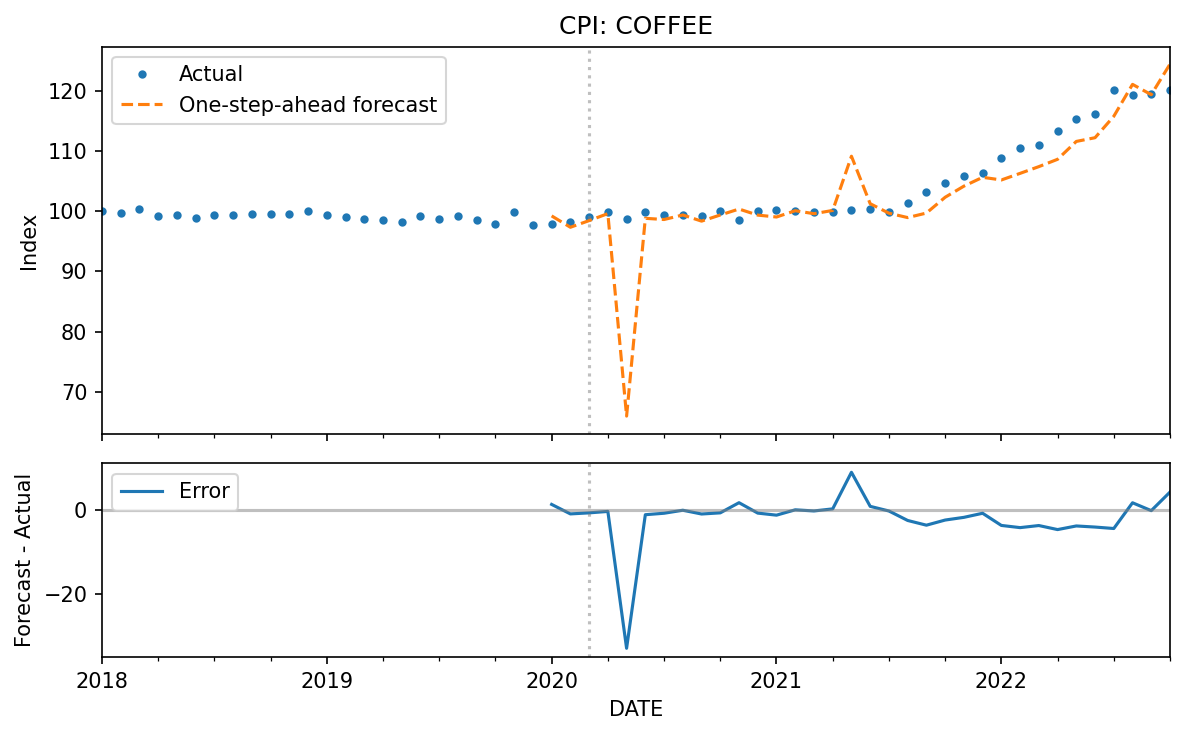

In [136]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions, ax=axes[0])
ax.set(title='CPI: %s'%cpi_cat, xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors, ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

### SARIMAX model (Experiment)

When incorporating the purchases data as exogenous variables

we use
$cpi_{0:i-1}$ and  $purchases_{1:i}$ to predict $cpi_i$

In [137]:
exog_vars = [c for c in coffee_idx_df.columns if ('_idx_smoothed3' in c) or ('_purchasers_smoothed3' in c)]

In [138]:
exog = coffee_idx_df[exog_vars]# TODO: do this better
exog.head()

B002SJUNU8_idx_smoothed3  B002SJUNU8_purchasers_smoothed3   
DATE                                                                    
2018-01-01                100.000000                         1.000000  \
2018-02-01                100.000000                         0.500000   
2018-03-01                100.000000                         0.333333   
2018-04-01                104.731861                         0.333333   
2018-05-01                109.463722                         0.666667   

            B006CQ1ZHI_idx_smoothed3  B006CQ1ZHI_purchasers_smoothed3   
DATE                                                                    
2018-01-01                     100.0                         1.000000  \
2018-02-01                     100.0                         0.500000   
2018-03-01                     100.0                         0.333333   
2018-04-01                     100.0                         0.666667   
2018-05-01                     100.0                         1.333333   

            B0099HD3YA_idx_smoothed3  B0099HD3YA_purchasers_smoothed3   
DATE                                                                    
2018-01-01                     100.0                              0.0  \
2018-02-01                     100.0                              0.0   
2018-03-01                     100.0                              0.0   
2018-04-01                     100.0                              0.0   
2018-05-01                     100.0                              0.0   

            B009HSNDI2_idx_smoothed3  B009HSNDI2_purchasers_smoothed3   
DATE                                                                    
2018-01-01                100.000000                         0.000000  \
2018-02-01                100.000000                         1.000000   
2018-03-01                100.000000                         1.000000   
2018-04-01                105.509182                         1.333333   
2018-05-01                111.018364                         0.666667   

            B00EDHW7UW_idx_smoothed3  B00EDHW7UW_purchasers_smoothed3   
DATE                                                                    
2018-01-01                     100.0                         1.000000  \
2018-02-01                     100.0                         0.500000   
2018-03-01                     100.0                         0.666667   
2018-04-01                     100.0                         0.666667   
2018-05-01                     100.0                         1.000000   

            B079V8CKDM_B079V7F2BP_B079V9JDQB_idx_smoothed3   
DATE                                                         
2018-01-01                                           100.0  \
2018-02-01                                           100.0   
2018-03-01                                           100.0   
2018-04-01                                           100.0   
2018-05-01                                           100.0   

            B079V8CKDM_B079V7F2BP_B079V9JDQB_purchasers_smoothed3  
DATE                                                               
2018-01-01                                                0.0      
2018-02-01                                                0.0      
2018-03-01                                                0.0      
2018-04-01                                                0.0      
2018-05-01                                                0.0

In [139]:
print('CPI: %s' % cpi_cat)
# train through first 2 years of data
predictions, errors, mae = sarimax_train_predict_one_step_ahead(
    cpi_series, 
    exog=exog,
    pred_start='2020-01-01', pred_end='2022-12-01',
    verbose=True
)
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

CPI: COFFEE
initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-12-01


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0 2019-12-01 00:00:00
AIC: 16.481


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

12 2020-12-01 00:00:00
AIC: 69.945


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

24 2021-12-01 00:00:00
AIC: 128.641


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

MAE for COFFEE CPI: 2.1923


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE for COFFEE CPI: 2.1923


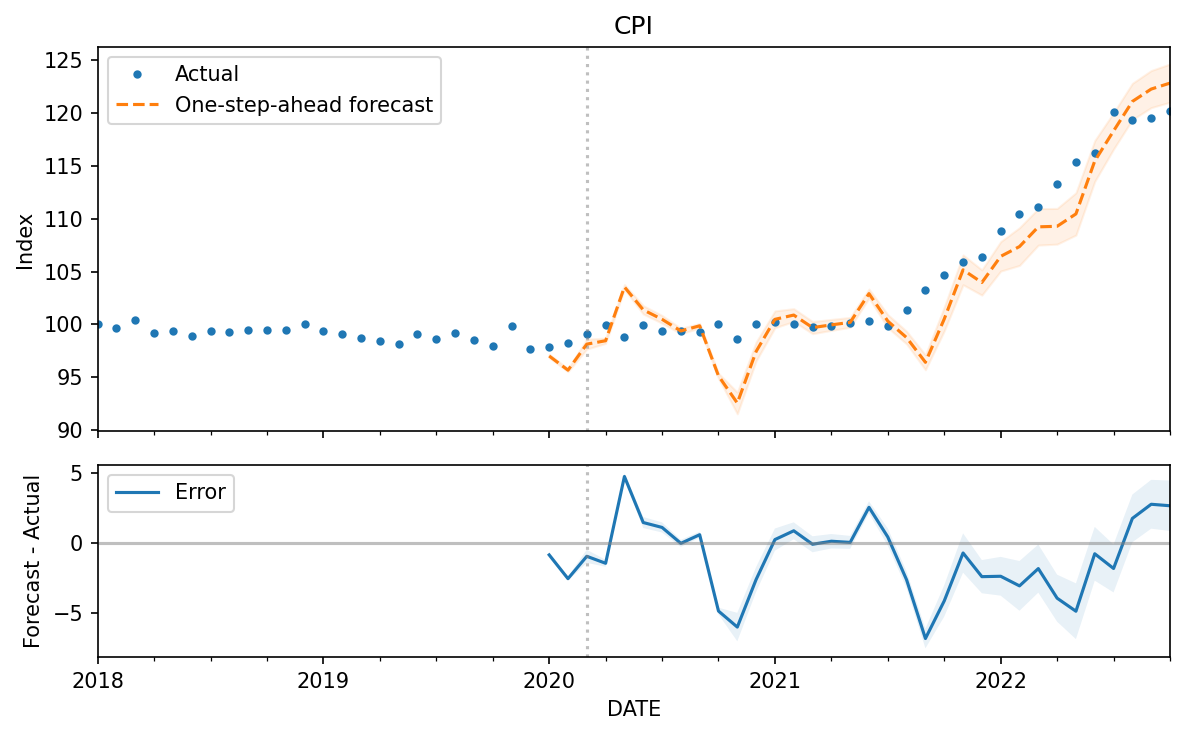

In [140]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions['mean'], predictions['mean_ci_lower'],
                       predictions['mean_ci_upper'], ax=axes[0])
ax.set(title='CPI', xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors['mean'], errors['ci_lower'], errors['ci_upper'], 
                 ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

## All items

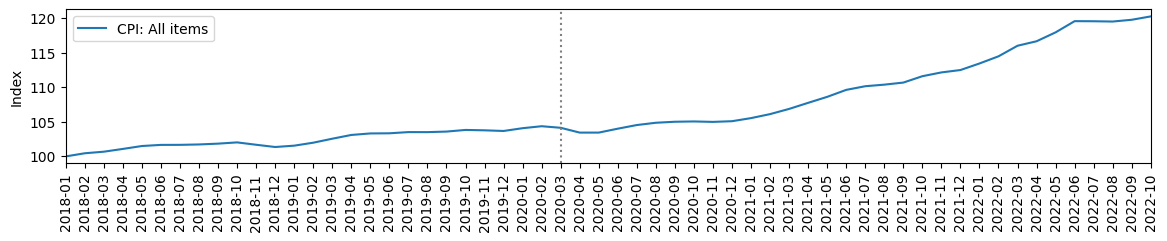

In [146]:
ax = plot_monthly_data(cpi_data['ALL'], ylabel='Index', label='CPI: All items', show_covid=True)

### Experiments tracking specific items

Experiment with all items
- Get all the items with at least 36 months of data.
    - Using 36 as a threshold because if used 48 then have no coffee.
    - Problem: No apparel or footwear when grouping by product code using min M=36
    - This is because product codes are short lived and easier to find by titles.
        - e.g. the only FOOTWEAR product with > 12 months of purchases is B002L9AL84 'Shoe Goo Repair Adhesive for Fixing Worn Shoes'
        
- Should add in aggregates for FOOTWEAR and APPAREL categories


Main takeaways from below experiments:
- models do better when data smoothed 
- models do better with more data (when it meets quality thresholdes) but models can break down with too much data / collinearity

In [118]:
all_items_purchases = amzn_data[purchases_data_cols]
all_items_purchases.drop('Survey ResponseID', axis=1).head(3)

yyyy-mm  month  quarter                                              Title   
0  2018-02      2        1                 Suburban World: The Norling Photos  \
1  2018-02      2        1                                                NaN   
2  2018-03      3        1  1952 Back In The Day - 24-page Greeting Card /...   

  ASIN/ISBN (Product Code)   Category  unit price  Quantity  
0               0873516095  ABIS_BOOK        7.93       1.0  
1               B004S7EZR0        NaN        3.53       1.0  
2               193938012X  ABIS_BOOK        5.99       1.0

In [119]:
items_quarters = all_items_purchases.groupby(
    ['ASIN/ISBN (Product Code)']
)['quarter'].agg(['nunique'])
print('distribution of unique quarters per item')
display(items_quarters.describe())

print('distribution of unique months per item')
items_months = all_items_purchases.groupby(
    ['ASIN/ISBN (Product Code)', 'Title']
)['yyyy-mm'].agg(['count', 'nunique'])
display(items_months.describe())

distribution of unique quarters per item


nunique
count  919945.000000
mean        1.517230
std         1.519983
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        20.000000

distribution of unique months per item


count        nunique
count  887020.000000  887020.000000
mean        1.892117       1.686765
std         4.312969       2.375348
min         1.000000       1.000000
25%         1.000000       1.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max       561.000000      60.000000

In [120]:
items_months.sort_values('count', ascending=False).head()

count   
ASIN/ISBN (Product Code) Title                                                       
B00MNV8E0C               Amazon Basics 48 Pack AA High-Performance Alkal...    561  \
B00LH3DMUO               Amazon Basics 36 Pack AAA High-Performance Alka...    557   
B07FZ8S74R               Echo Dot (3rd Gen, 2018 release) - Smart speake...    478   
B0009X29WK               Dr. Elsey’s Premium Clumping Cat Litter - Ultra...    464   
B079QHML21               Fire TV Stick 4K streaming device with Alexa Vo...    461   

                                                                             nunique  
ASIN/ISBN (Product Code) Title                                                        
B00MNV8E0C               Amazon Basics 48 Pack AA High-Performance Alkal...       60  
B00LH3DMUO               Amazon Basics 36 Pack AAA High-Performance Alka...       60  
B07FZ8S74R               Echo Dot (3rd Gen, 2018 release) - Smart speake...       42  
B0009X29WK               Dr. Elsey’s Premium Clumping Cat Litter - Ultra...       59  
B079QHML21               Fire TV Stick 4K streaming device with Alexa Vo...       39

In [121]:
items_months.sort_values('nunique', ascending=False).head()

count   
ASIN/ISBN (Product Code) Title                                                       
B01BUNHFQM               Tide PODS Laundry Detergent Soap Pods, Spring M...    199  \
B00MNV8E0C               Amazon Basics 48 Pack AA High-Performance Alkal...    561   
B00LH3DMUO               Amazon Basics 36 Pack AAA High-Performance Alka...    557   
B06XX33G82               Finish - All in 1 - Dishwasher Detergent - Powe...    253   
B0009X29WK               Dr. Elsey’s Premium Clumping Cat Litter - Ultra...    464   

                                                                             nunique  
ASIN/ISBN (Product Code) Title                                                        
B01BUNHFQM               Tide PODS Laundry Detergent Soap Pods, Spring M...       60  
B00MNV8E0C               Amazon Basics 48 Pack AA High-Performance Alkal...       60  
B00LH3DMUO               Amazon Basics 36 Pack AAA High-Performance Alka...       60  
B06XX33G82               Finish - All in 1 - Dishwasher Detergent - Powe...       60  
B0009X29WK               Dr. Elsey’s Premium Clumping Cat Litter - Ultra...       59

Questions

- How many items have a purchase in every quarter? 
    - What are these items? 
    - What are the categories of these items?
    
- Same questions for items with a threshold of P distinct purchasers in every quarter.

In [122]:
quarterly_item_codes = items_quarters[items_quarters['nunique'] == 20].index
print('%s items purchased every quarter' % len(quarterly_item_codes))
quarterly_item_purchases = amzn_data[amzn_data['ASIN/ISBN (Product Code)'].isin(quarterly_item_codes)]
print('top categories by unique product codes:')
print('(for the items purchased every quarter)')
display(quarterly_item_purchases.groupby(
    ['Category']
)['ASIN/ISBN (Product Code)'].agg(['count','nunique']).sort_values('nunique', ascending=False).head(10))

print('top categories and items by distinct purchasers')
display(quarterly_item_purchases.groupby(
    ['Category','Title']
)['Survey ResponseID'].agg(['count','nunique']).sort_values('nunique', ascending=False))

print('top categories and items by distinct months')
display(quarterly_item_purchases.groupby(
    ['Category','Title']
)['yyyy-mm'].agg(['count','nunique']).sort_values('nunique', ascending=False))

179 items purchased every quarter
top categories by unique product codes:
(for the items purchased every quarter)


count  nunique
Category                              
PET_FOOD                 2131       23
HEALTH_PERSONAL_CARE      572       11
NUTRITIONAL_SUPPLEMENT    908       11
BATTERY                  2120        8
VITAMIN                   614        8
MEDICATION                708        7
WASTE_BAG                 562        6
SKIN_MOISTURIZER          510        6
DISHWASHER_DETERGENT      721        4
PET_SUPPLIES              564        4

top categories and items by distinct purchasers


count   
Category              Title                                                       
BATTERY               Amazon Basics 36 Pack AAA High-Performance Alka...    557  \
                      Amazon Basics 48 Pack AA High-Performance Alkal...    561   
                      Amazon Basics 20 Pack AA High-Performance Alkal...    262   
                      Amazon Basics 8 Units Pack 9 Volt Performance A...    190   
                      Amazon Basics 20 Pack AAA High-Performance Alka...    205   
...                                                                         ...   
SURFACE_CLEANING_WIPE Lysol Disinfectant Wipes, Multi-Surface Antibac...      1   
PET_FOOD              Wellness CORE Grain-Free Natural Dry Cat Food (...      9   
DISHWASHER_DETERGENT  Dishwasher-Pods                                         1   
LAUNDRY_DETERGENT     Tide To Go Instant Stain Remover, 3 Count               1   
DISHWASHER_DETERGENT  Platinum Dishwasher Pods                                4   

                                                                          nunique  
Category              Title                                                        
BATTERY               Amazon Basics 36 Pack AAA High-Performance Alka...      363  
                      Amazon Basics 48 Pack AA High-Performance Alkal...      301  
                      Amazon Basics 20 Pack AA High-Performance Alkal...      175  
                      Amazon Basics 8 Units Pack 9 Volt Performance A...      155  
                      Amazon Basics 20 Pack AAA High-Performance Alka...      154  
...                                                                           ...  
SURFACE_CLEANING_WIPE Lysol Disinfectant Wipes, Multi-Surface Antibac...        1  
PET_FOOD              Wellness CORE Grain-Free Natural Dry Cat Food (...        1  
DISHWASHER_DETERGENT  Dishwasher-Pods                                           1  
LAUNDRY_DETERGENT     Tide To Go Instant Stain Remover, 3 Count                 1  
DISHWASHER_DETERGENT  Platinum Dishwasher Pods                                  1  

[359 rows x 2 columns]

top categories and items by distinct months


count   
Category               Title                                                       
DISHWASHER_DETERGENT   Finish - All in 1 - Dishwasher Detergent - Powe...    253  \
BATTERY                Amazon Basics 36 Pack AAA High-Performance Alka...    557   
                       Amazon Basics 48 Pack AA High-Performance Alkal...    561   
NUTRITIONAL_SUPPLEMENT OZzzz’s Sleep Aid for Children, with Melatonin ...    107   
MINERAL_SUPPLEMENT     Doctor's Best High Absorption Magnesium Glycina...    272   
...                                                                          ...   
MOUTHWASH              TheraBreath Fresh Breath Oral Rinse, Mild Mint,...      1   
LIP_BALM               Burt's Bees 100% Natural Moisturizing Lip Balm,...      1   
HEALTH_PERSONAL_CARE   Swiffer Sweeper Wet Mopping Cloth Multi Surface...      1   
DISHWASHER_DETERGENT   Dishwasher-Pods                                         1   
PET_SUPPLIES           1                                                       1   

                                                                           nunique  
Category               Title                                                        
DISHWASHER_DETERGENT   Finish - All in 1 - Dishwasher Detergent - Powe...       60  
BATTERY                Amazon Basics 36 Pack AAA High-Performance Alka...       60  
                       Amazon Basics 48 Pack AA High-Performance Alkal...       60  
NUTRITIONAL_SUPPLEMENT OZzzz’s Sleep Aid for Children, with Melatonin ...       59  
MINERAL_SUPPLEMENT     Doctor's Best High Absorption Magnesium Glycina...       59  
...                                                                            ...  
MOUTHWASH              TheraBreath Fresh Breath Oral Rinse, Mild Mint,...        1  
LIP_BALM               Burt's Bees 100% Natural Moisturizing Lip Balm,...        1  
HEALTH_PERSONAL_CARE   Swiffer Sweeper Wet Mopping Cloth Multi Surface...        1  
DISHWASHER_DETERGENT   Dishwasher-Pods                                           1  
PET_SUPPLIES           1                                                         1  

[359 rows x 2 columns]

In [123]:
# select X top items based on number of unique months of data
Xn_top_items = 25 # 30 is too many # 20 worked well --> 25 worked better

quarterly_item_top_months_codes = quarterly_item_purchases.groupby(
    ['ASIN/ISBN (Product Code)']
)['yyyy-mm'].nunique().sort_values(ascending=False).head(Xn_top_items)

# show what these products are
print('here are the products to track. Note some are renamed uner the same product code')
amzn_data[
    amzn_data['ASIN/ISBN (Product Code)'].isin(quarterly_item_top_months_codes.index)
].groupby(
    ['Category', 'Title', 'ASIN/ISBN (Product Code)']
)['yyyy-mm'].agg(['count','nunique'])

here are the products to track. Note some are renamed uner the same product code


count   
Category              Title                                              ASIN/ISBN (Product Code)          
ADHESIVE_TAPES        Scotch Heavy Duty Packaging Tape, 1.88" x 22.2 ... B000J07BRQ                   73  \
ANIMAL_LITTER         ARM & HAMMER Clump & Seal Platinum Cat Litter      B01M64FECB                   73   
                      ARM & HAMMER Clump & Seal Platinum Cat Litter, ... B01M64FECB                   93   
                      Dr. Elsey's Premium Clumping Cat Litter Ultra U... B0009X29WK                   47   
                      Dr. Elsey’s Premium Clumping Cat Litter - Ultra... B0009X29WK                  375   
...                                                                                                  ...   
SURFACE_CLEANING_WIPE Lysol Disinfectant Wipes, Multi-Surface Antibac... B00Q70RCW6                    1   
TAPE_LABEL_DISPENSER  Scotch Heavy Duty Packaging Tape, 1.88" x 22.2 ... B000J07BRQ                  156   
TOILET_PAPER          Amazon Brand - Presto! 308-Sheet Mega Roll Toil... B074CRK54X                  310   
                      Amazon Brand - Presto! 313-Sheet Mega Roll Toil... B074CRK54X                  171   
                      Amazon Brand - Presto! Mega Roll Toilet Paper, ... B074CRK54X                  260   

                                                                                                   nunique  
Category              Title                                              ASIN/ISBN (Product Code)           
ADHESIVE_TAPES        Scotch Heavy Duty Packaging Tape, 1.88" x 22.2 ... B000J07BRQ                     39  
ANIMAL_LITTER         ARM & HAMMER Clump & Seal Platinum Cat Litter      B01M64FECB                     39  
                      ARM & HAMMER Clump & Seal Platinum Cat Litter, ... B01M64FECB                     51  
                      Dr. Elsey's Premium Clumping Cat Litter Ultra U... B0009X29WK                     38  
                      Dr. Elsey’s Premium Clumping Cat Litter - Ultra... B0009X29WK                     58  
...                                                                                                    ...  
SURFACE_CLEANING_WIPE Lysol Disinfectant Wipes, Multi-Surface Antibac... B00Q70RCW6                      1  
TAPE_LABEL_DISPENSER  Scotch Heavy Duty Packaging Tape, 1.88" x 22.2 ... B000J07BRQ                     53  
TOILET_PAPER          Amazon Brand - Presto! 308-Sheet Mega Roll Toil... B074CRK54X                     53  
                      Amazon Brand - Presto! 313-Sheet Mega Roll Toil... B074CRK54X                     50  
                      Amazon Brand - Presto! Mega Roll Toilet Paper, ... B074CRK54X                     58  

[65 rows x 2 columns]

In [124]:
product_codes = [[c] for c in quarterly_item_top_months_codes.index]
p_idx_df, pnames = make_price_index_df(product_codes, cpi_data['ALL'])

/var/folders/db/z8ngkp150y5fzcf8z1cz1cs00000gn/T/ipykernel_8689/1777674142.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['%s_idx' % p] = 100*(p_price/p_base)
/var/folders/db/z8ngkp150y5fzcf8z1cz1cs00000gn/T/ipykernel_8689/1777674142.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['%s_purchasers' % p] = pdf.groupby('yyyy-mm')['Survey ResponseID'].nunique().reindex(amzn_data_idx).fillna(0)
/var/folders/db/z8ngkp150y5fzcf8z1cz1cs00000gn/T/ipykernel_8689/1777674142.py:33: PerformanceWarning: DataFrame is highly fra

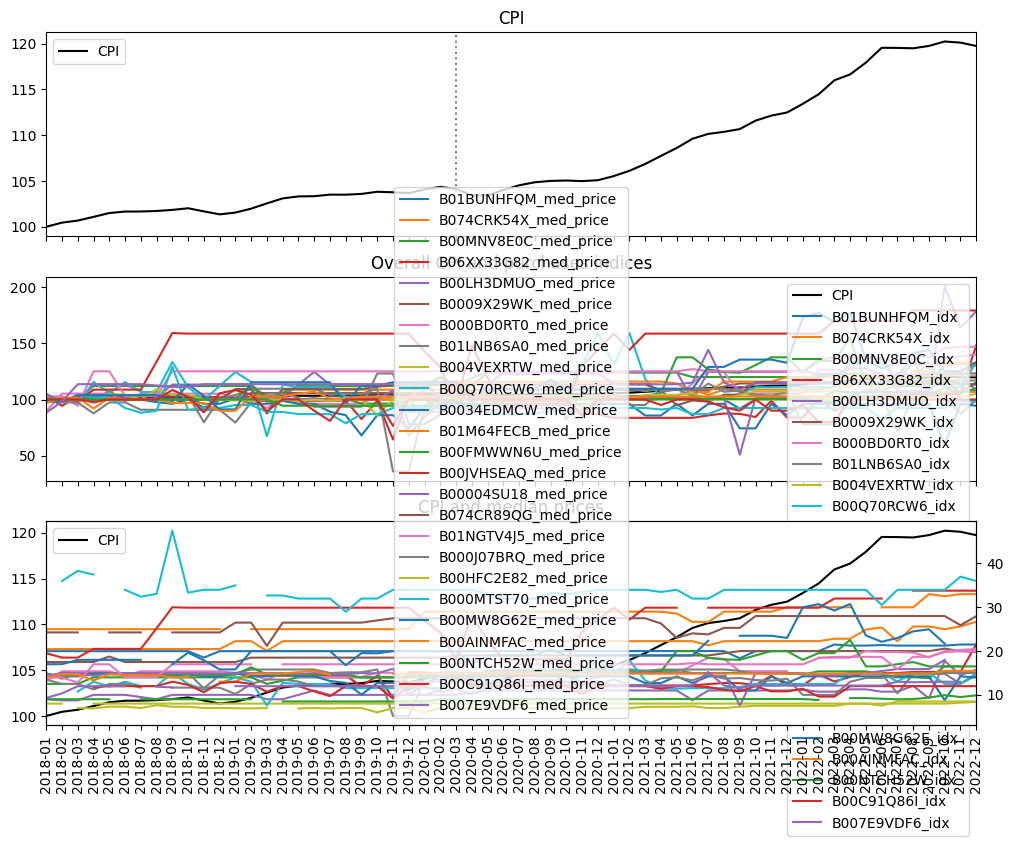

In [125]:
fig, axes = plt.subplots(3,1, figsize=(12, 3*3), sharex=True)

plot_monthly_data(p_idx_df['CPI'], ax=axes[0], title='CPI', label='CPI', show_covid=True, color='black')
ax = axes[1]
ax.set_title('Overall CPI and purchases indices')
plot_monthly_data(p_idx_df['CPI'], ax=ax, label='CPI', color='black')
for c in [idx for idx in p_idx_df.columns if ('_idx' in idx)]:
    plot_monthly_data(p_idx_df[c], ax=ax, label=c)
# add median price including missing values
ax = axes[2]
ax.set_title('CPI and median prices')
plot_monthly_data(p_idx_df['CPI'], ax=ax, label='CPI', color='black')
ax = ax.twinx()
for c in [col for col in p_idx_df.columns if ('_med_price' in col)]:
    plot_monthly_data(p_idx_df[c], ax=ax, label=c)
# add number of purchases
# ax = axes[3]
# ax.set_title('Product purchases')
# for c in [col for col in p_idx_df.columns if ('_purchases' in col)]:
#     plot_monthly_data(p_idx_df[c], ax=ax, label=c)

In [126]:
# smooth the values as a mean computed as the present value and the immediate previous value
# similar to order (2,1,1)
for col in [c for c in p_idx_df.columns if ('_idx' in c) or ('_purchases' in c) or ('_purchasers' in c)]:
    p_idx_df[col+'_smoothed'] = p_idx_df[col].rolling(2, min_periods=1).mean()
    p_idx_df[col+'_smoothed3'] = p_idx_df[col].rolling(3, min_periods=1).mean()

/var/folders/db/z8ngkp150y5fzcf8z1cz1cs00000gn/T/ipykernel_8689/3756391789.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  p_idx_df[col+'_smoothed'] = p_idx_df[col].rolling(2, min_periods=1).mean()
/var/folders/db/z8ngkp150y5fzcf8z1cz1cs00000gn/T/ipykernel_8689/3756391789.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  p_idx_df[col+'_smoothed3'] = p_idx_df[col].rolling(3, min_periods=1).mean()
/var/folders/db/z8ngkp150y5fzcf8z1cz1cs00000gn/T/ipykernel_8689/3756391789.py:4: PerformanceWarning: DataFrame is highly fragment

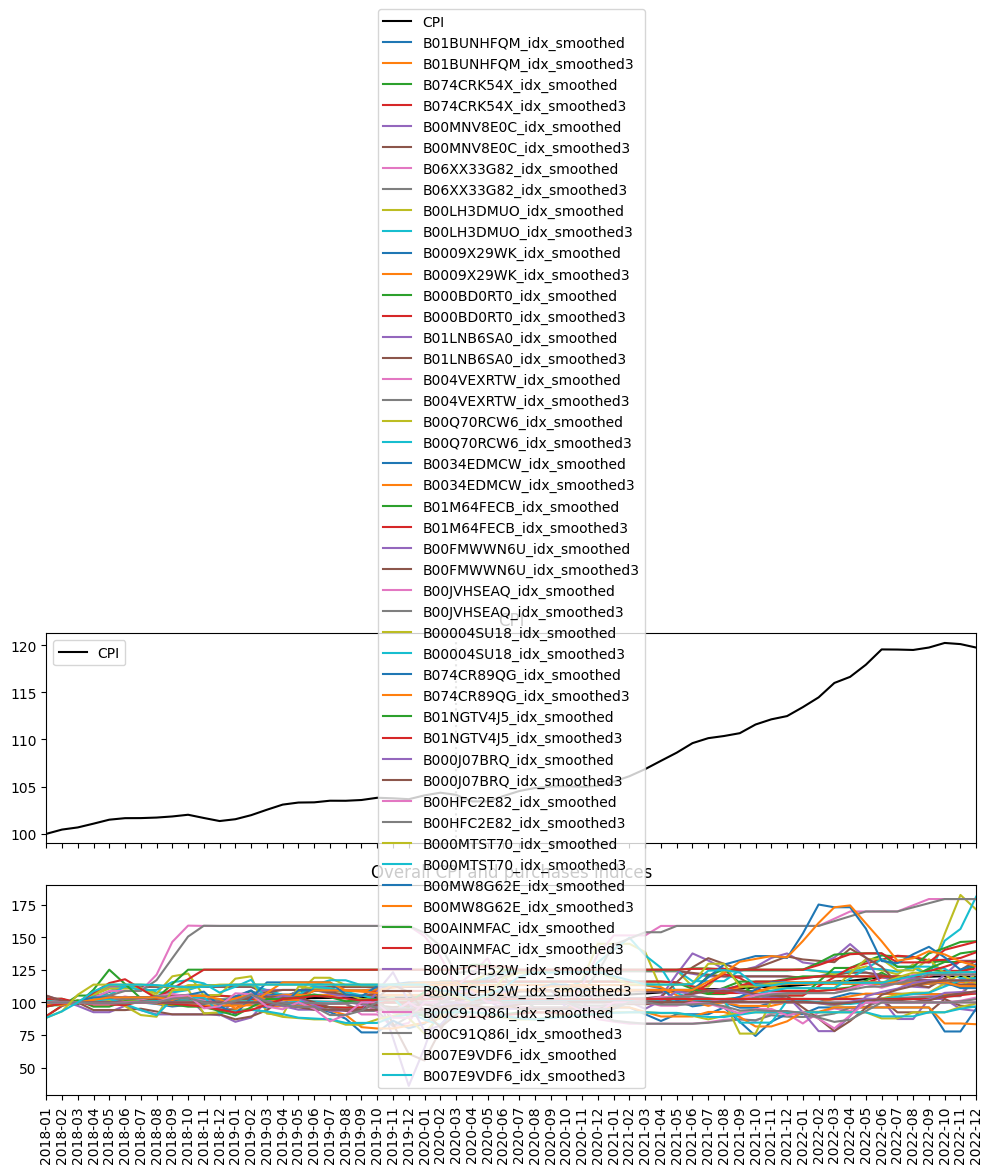

In [127]:
fig, axes = plt.subplots(2,1, figsize=(12, 2*3), sharex=True)

plot_monthly_data(p_idx_df['CPI'], ax=axes[0], title='CPI', label='CPI', show_covid=True, color='black')
ax = axes[1]
ax.set_title('Overall CPI and purchases indices')
plot_monthly_data(p_idx_df['CPI'], ax=ax, label='CPI', color='black')
for c in [idx for idx in p_idx_df.columns if ('_idx_smoothed' in idx)]:
    plot_monthly_data(p_idx_df[c], ax=ax, label=c)

In [128]:
p_idx_df.index = cpi_model_data.index
p_idx_df.head()

month        CPI  CPI_lag_1m  B01BUNHFQM_med_price   
DATE                                                             
2018-01-01      1  100.00000   100.45347                 19.97  \
2018-02-01      2  100.45347   100.68061                 19.97   
2018-03-01      3  100.68061   101.08082                 19.97   
2018-04-01      4  101.08082   101.50121                 19.97   
2018-05-01      5  101.50121   101.66299                 19.97   

            B01BUNHFQM_purchases  B01BUNHFQM_price  B01BUNHFQM_idx   
DATE                                                                 
2018-01-01                     4             19.97           100.0  \
2018-02-01                     1             19.97           100.0   
2018-03-01                     4             19.97           100.0   
2018-04-01                     4             19.97           100.0   
2018-05-01                     4             19.97           100.0   

            B01BUNHFQM_purchasers  B074CRK54X_med_price  B074CRK54X_purchases   
DATE                                                                            
2018-01-01                      4                 20.45                     2  \
2018-02-01                      1                 20.45                     2   
2018-03-01                      4                 20.45                     2   
2018-04-01                      4                 20.45                     1   
2018-05-01                      4                 20.45                     6   

            ...  B00C91Q86I_idx_smoothed  B00C91Q86I_idx_smoothed3   
DATE        ...                                                      
2018-01-01  ...               100.000000                100.000000  \
2018-02-01  ...               100.000000                100.000000   
2018-03-01  ...               100.000000                100.000000   
2018-04-01  ...                98.998331                 99.332220   
2018-05-01  ...                99.019199                 99.346132   

            B00C91Q86I_purchasers_smoothed  B00C91Q86I_purchasers_smoothed3   
DATE                                                                          
2018-01-01                             0.0                         0.000000  \
2018-02-01                             1.0                         1.000000   
2018-03-01                             1.0                         0.666667   
2018-04-01                             2.0                         2.000000   
2018-05-01                             3.0                         2.000000   

            B007E9VDF6_purchases_smoothed  B007E9VDF6_purchases_smoothed3   
DATE                                                                        
2018-01-01                            1.0                        1.000000  \
2018-02-01                            1.5                        1.500000   
2018-03-01                            1.5                        1.333333   
2018-04-01                            1.0                        1.333333   
2018-05-01                            1.0                        1.000000   

            B007E9VDF6_idx_smoothed  B007E9VDF6_idx_smoothed3   
DATE                                                            
2018-01-01                88.224122                 88.224122  \
2018-02-01                93.162393                 93.162393   
2018-03-01               105.887939                100.000000   
2018-04-01               113.675214                108.483697   
2018-05-01               113.675214                113.675214   

            B007E9VDF6_purchasers_smoothed  B007E9VDF6_purchasers_smoothed3  
DATE                                                                         
2018-01-01                             1.0                         1.000000  
2018-02-01                             1.5                         1.500000  
2018-03-01                             1.5                         1.333333  
2018-04-01                             1.0                 

Regression notes
- month stat. significant
- R2 better with smoothed data
    - better with rolling window of size 2. even etter with rolling window of size 3
- R2 slightly better with 1m lag
- R2 slightly better with number of purchasers
    - and even better with smoothed (Adj. R-squared: 0.998)
- R2 slightly better with purchasers vs purchases
- problem w # of purchasers: causes large spikes in MAE


In [129]:
data = p_idx_df[['CPI', 'CPI_lag_1m', 'month'] + [c for c in p_idx_df.columns if ('_idx' in c) or ('_purchases' in c) or ('_purchasers' in c)]]

In [130]:
# First try with no lag, then experiment with lags
formula = 'CPI ~ month'
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=data).fit()
display(result.summary())

Formula:
CPI ~ month


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     334.0
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           9.71e-26
Time:                        17:45:58   Log-Likelihood:                -137.40
No. Observations:                  60   AIC:                             278.8
Df Residuals:                      58   BIC:                             283.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     97.1530      0.635    152.893      0.000      95.881      98.425
month          0.3311      0.018     18.275      0.000       0.295       0.367
==============================================================================
Omnibus:                       10.490   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                3.082
Skew:                           0.068   Prob(JB):                        0.214
Kurtosis:                       1.898   Cond. No.                         71.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
# Experiment with lags
formula = 'CPI ~ '
formula += 'month + '
# s = ['%s_idx_smoothed' % (p) for p in pnames]
# s = ['%s_idx_smoothed3' % (p) for p in pnames]
# s = ['%s_idx' % (p) for p in pnames]
# s = ['%s_idx_smoothed + %s_purchases_smoothed' % (p, p) for p in pnames]
s = ['%s_idx_smoothed3 + %s_purchases_smoothed3' % (p, p) for p in pnames]
# s = ['%s_idx + %s_purchases' % (p, p) for p in pnames]
# s = ['%s_idx + %s_purchasers' % (p, p) for p in pnames]
formula += ' + '.join(s)
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=data).fit()
display(result.summary())

Formula:
CPI ~ month + B01BUNHFQM_idx_smoothed3 + B01BUNHFQM_purchases_smoothed3 + B074CRK54X_idx_smoothed3 + B074CRK54X_purchases_smoothed3 + B00MNV8E0C_idx_smoothed3 + B00MNV8E0C_purchases_smoothed3 + B06XX33G82_idx_smoothed3 + B06XX33G82_purchases_smoothed3 + B00LH3DMUO_idx_smoothed3 + B00LH3DMUO_purchases_smoothed3 + B0009X29WK_idx_smoothed3 + B0009X29WK_purchases_smoothed3 + B000BD0RT0_idx_smoothed3 + B000BD0RT0_purchases_smoothed3 + B01LNB6SA0_idx_smoothed3 + B01LNB6SA0_purchases_smoothed3 + B004VEXRTW_idx_smoothed3 + B004VEXRTW_purchases_smoothed3 + B00Q70RCW6_idx_smoothed3 + B00Q70RCW6_purchases_smoothed3 + B0034EDMCW_idx_smoothed3 + B0034EDMCW_purchases_smoothed3 + B01M64FECB_idx_smoothed3 + B01M64FECB_purchases_smoothed3 + B00FMWWN6U_idx_smoothed3 + B00FMWWN6U_purchases_smoothed3 + B00JVHSEAQ_idx_smoothed3 + B00JVHSEAQ_purchases_smoothed3 + B00004SU18_idx_smoothed3 + B00004SU18_purchases_smoothed3 + B074CR89QG_idx_smoothed3 + B074CR89QG_purchases_smoothed3 + B01NGTV4J5_idx_sm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1865.
Date:                Sun, 08 Oct 2023   Prob (F-statistic):           1.10e-12
Time:                        17:45:58   Log-Likelihood:                 86.788
No. Observations:                  60   AIC:                            -69.58
Df Residuals:                       8   BIC:                             39.33
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        141.0755     59.461      2.373      0.045       3.958     278.193
month                              0.3265      0.120      2.730      0.026       0.051       0.602
B01BUNHFQM_idx_smoothed3           0.3074      0.169      1.817      0.107      -0.083       0.697
B01BUNHFQM_purchases_smoothed3    -0.2593      0.229     -1.133      0.290      -0.787       0.269
B074CRK54X_idx_smoothed3          -0.0186      0.157     -0.118      0.909      -0.381       0.343
B074CRK54X_purchases_smoothed3    -0.1320      0.077     -1.714      0.125      -0.310       0.046
B00MNV8E0C_idx_smoothed3           0.0055      0.079      0.070      0.946      -0.177       0.188
B00MNV8E0C_purchases_smoothed3     0.0584      0.071      0.824      0.434      -0.105       0.222
B06XX33G82_idx_smoothed3           0.1062      0.059      1.800      0.110      -0.030       0.242
B06XX33G82_purchases_smoothed3     0.0352      0.130      0.270      0.794      -0.265       0.336
B00LH3DMUO_idx_smoothed3          -0.0083      0.035     -0.237      0.819      -0.089       0.072
B00LH3DMUO_purchases_smoothed3    -0.1826      0.102     -1.785      0.112      -0.418       0.053
B0009X29WK_idx_smoothed3           0.1699      0.301      0.564      0.588      -0.524       0.864
B0009X29WK_purchases_smoothed3     0.0134      0.069      0.194      0.851      -0.146       0.172
B000BD0RT0_idx_smoothed3           0.0851      0.059      1.442      0.187      -0.051       0.221
B000BD0RT0_purchases_smoothed3    -0.2169      0.094     -2.297      0.051      -0.435       0.001
B01LNB6SA0_idx_smoothed3           0.0112      0.042      0.264      0.798      -0.086       0.109
B01LNB6SA0_purchases_smoothed3     0.3856      0.307      1.257      0.244      -0.322       1.093
B004VEXRTW_idx_smoothed3          -0.7544      0.504     -1.497      0.173      -1.917       0.408
B004VEXRTW_purchases_smoothed3     0.0103      0.262      0.039      0.970      -0.594       0.614
B00Q70RCW6_idx_smoothed3          -0.0060      0.036     -0.168      0.871      -0.089       0.077
B00Q70RCW6_purchases_smoothed3     0.1359      0.190      0.714      0.496      -0.303       0.575
B0034EDMCW_idx_smoothed3          -0.0648      0.057     -1.138      0.288      -0.196       0.066
B0034EDMCW_purchases_smoothed3     0.6324      0.762      0.830      0.430      -1.124       2.388
B01M64FECB_idx_smoothed3          -0.0540      0.100     -0.541      0.603      -0.284       0.176
B01M64FECB_purchases_smoothed3    -0.0591      0.195     -0.304      0.769      -0.508       0.390
B00FMWWN6U_idx_smoothed3           0.0233      0.043      0.543      0.602      -0.076       0.122
B00FMWWN6U_purchases_smoothed3     0.0501      0.155      0.324      0.754      -0.306       0.407
B00JVHSEAQ_idx

Test prediction

In [132]:
predictions, errors, mae, train_res = train_predict_one_step_ahead_ols(
    data, formula, 
    pred_start='2020-02-01',
    #pred_end='2021-05-01',
    verbose=True,
)
print('MAE %0.4f' % mae)

initial training period: 2018-01-01 00:00:00 to 2020-01-01 00:00:00
prediction start, end: 2020-02-01 2022-12-01 00:00:00
Formula:
CPI ~ month + B01BUNHFQM_idx_smoothed3 + B01BUNHFQM_purchases_smoothed3 + B074CRK54X_idx_smoothed3 + B074CRK54X_purchases_smoothed3 + B00MNV8E0C_idx_smoothed3 + B00MNV8E0C_purchases_smoothed3 + B06XX33G82_idx_smoothed3 + B06XX33G82_purchases_smoothed3 + B00LH3DMUO_idx_smoothed3 + B00LH3DMUO_purchases_smoothed3 + B0009X29WK_idx_smoothed3 + B0009X29WK_purchases_smoothed3 + B000BD0RT0_idx_smoothed3 + B000BD0RT0_purchases_smoothed3 + B01LNB6SA0_idx_smoothed3 + B01LNB6SA0_purchases_smoothed3 + B004VEXRTW_idx_smoothed3 + B004VEXRTW_purchases_smoothed3 + B00Q70RCW6_idx_smoothed3 + B00Q70RCW6_purchases_smoothed3 + B0034EDMCW_idx_smoothed3 + B0034EDMCW_purchases_smoothed3 + B01M64FECB_idx_smoothed3 + B01M64FECB_purchases_smoothed3 + B00FMWWN6U_idx_smoothed3 + B00FMWWN6U_purchases_smoothed3 + B00JVHSEAQ_idx_smoothed3 + B00JVHSEAQ_purchases_smoothed3 + B00004SU18_idx_

MAE for ALL CPI: 1.3743


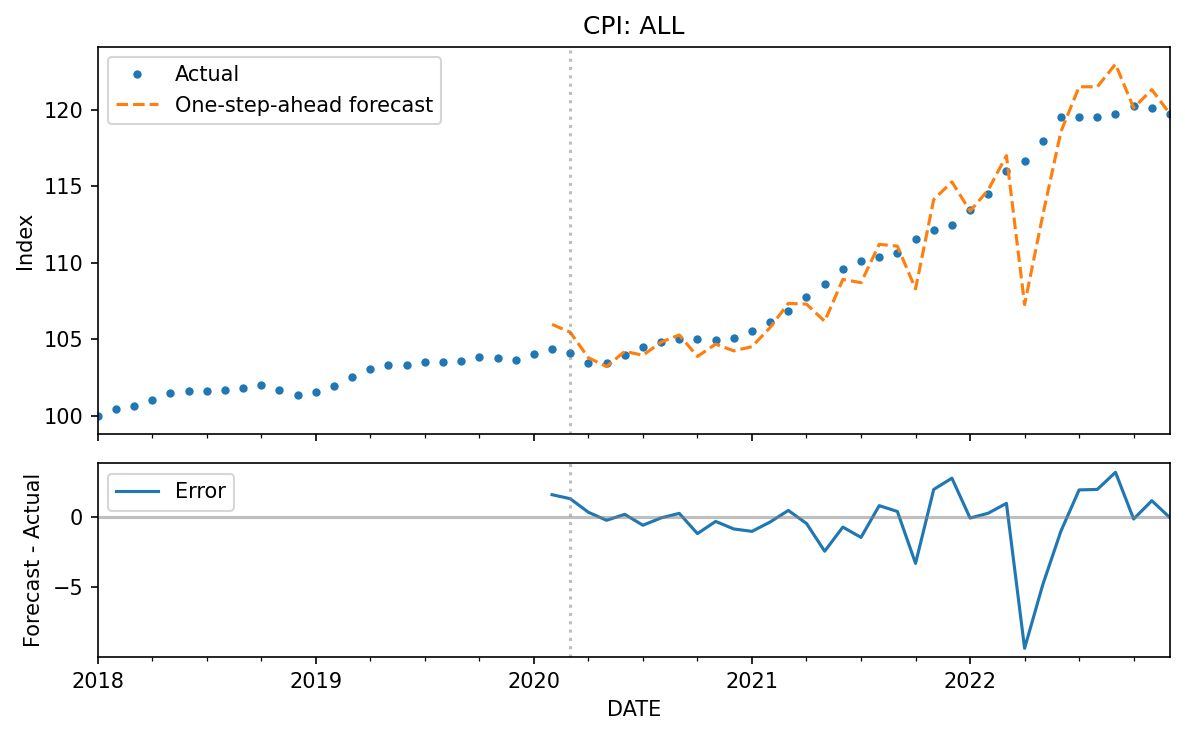

In [133]:
cpi_cat = 'ALL'
cpi_series = cpi_model_data[cpi_cat]
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions, ax=axes[0])
ax.set(title='CPI: %s'%cpi_cat, xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors, ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

This here is the best:
- using both _idx_smoothed3 and _purchasers_smoothed3
- i.e. rolling window of size 3 and using both idx and purchasers data 

This is still not an improvement over CPI data alone!

But potentially a decent finding for next steps

In [134]:
# exog_vars = [c for c in p_idx_df.columns if '_idx_smoothed' in c]
# _purchasers adds noise and increases MAE -- this is true even for purchasers_smoothed
# is it true for purchasers_smoothed3? 
# Answer: NO -- using purchasers_smoothed3 is an improvement over _idx_smoothed alone
exog_vars = [c for c in p_idx_df.columns if ('_idx_smoothed3' in c) or ('_purchasers_smoothed3' in c)]
exog = p_idx_df[exog_vars]# TODO: do this better
exog.index = cpi_model_data.index
exog.head()

B01BUNHFQM_idx_smoothed3  B01BUNHFQM_purchasers_smoothed3   
DATE                                                                    
2018-01-01                     100.0                              4.0  \
2018-02-01                     100.0                              2.5   
2018-03-01                     100.0                              3.0   
2018-04-01                     100.0                              3.0   
2018-05-01                     100.0                              4.0   

            B074CRK54X_idx_smoothed3  B074CRK54X_purchasers_smoothed3   
DATE                                                                    
2018-01-01                     100.0                         1.000000  \
2018-02-01                     100.0                         1.500000   
2018-03-01                     100.0                         1.666667   
2018-04-01                     100.0                         1.666667   
2018-05-01                     100.0                         3.000000   

            B00MNV8E0C_idx_smoothed3  B00MNV8E0C_purchasers_smoothed3   
DATE                                                                    
2018-01-01                100.000000                         8.000000  \
2018-02-01                100.000000                         6.500000   
2018-03-01                100.000000                         6.000000   
2018-04-01                104.003203                         6.000000   
2018-05-01                108.006405                         7.333333   

            B06XX33G82_idx_smoothed3  B06XX33G82_purchasers_smoothed3   
DATE                                                                    
2018-01-01                102.802021                         1.000000  \
2018-02-01                 98.598989                         1.000000   
2018-03-01                100.000000                         1.333333   
2018-04-01                100.000000                         1.333333   
2018-05-01                102.802021                         2.000000   

            B00LH3DMUO_idx_smoothed3  B00LH3DMUO_purchasers_smoothed3  ...   
DATE                                                                   ...   
2018-01-01                101.965974                         8.000000  ...  \
2018-02-01                100.491493                         6.000000  ...   
2018-03-01                100.000000                         5.333333  ...   
2018-04-01                103.780718                         3.666667  ...   
2018-05-01                108.544423                         4.333333  ...   

            B00MW8G62E_idx_smoothed3  B00MW8G62E_purchasers_smoothed3   
DATE                                                                    
2018-01-01                 98.075813                         6.000000  \
2018-02-01                 98.075813                         3.500000   
2018-03-01                100.000000                         2.666667   
2018-04-01                101.924187                         1.333333   
2018-05-01                103.848374                         1.666667   

            B00AINMFAC_idx_smoothed3  B00AINMFAC_purchasers_smoothed3   
DATE                                                                    
2018-01-01                 96.771962                         3.000000  \
2018-02-01                 99.192991                         2.500000   
2018-03-01                100.000000                         3.333333   
2018-04-01                 98.397510                         3.000000   
2018-05-01                 98.397510                         3.000000   

            B00NTCH52W_idx_smoothed3  B00NTCH52W_purchasers_smoothed3   
DATE                                                                    
2018-01-01                     100.0                         2.000000  \
2018-02-01                     100.0                         2.000000   
2018-03-01                     100.0                         1.666667   
2018-04-01                  

In [135]:
predictions, errors, mae = sarimax_train_predict_one_step_ahead(
    cpi_series,
    exog=exog,
    pred_start='2020-01-01', pred_end='2022-12-01',
    verbose=True
)
print('MAE for overall CPI = %0.4f' % mae)

initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-12-01


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0 2019-12-01 00:00:00
AIC: -1.081


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

12 2020-12-01 00:00:00
AIC: -60.411


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

24 2021-12-01 00:00:00
AIC: -104.270


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelih

MAE for overall CPI = 0.5816


MAE = 0.5816


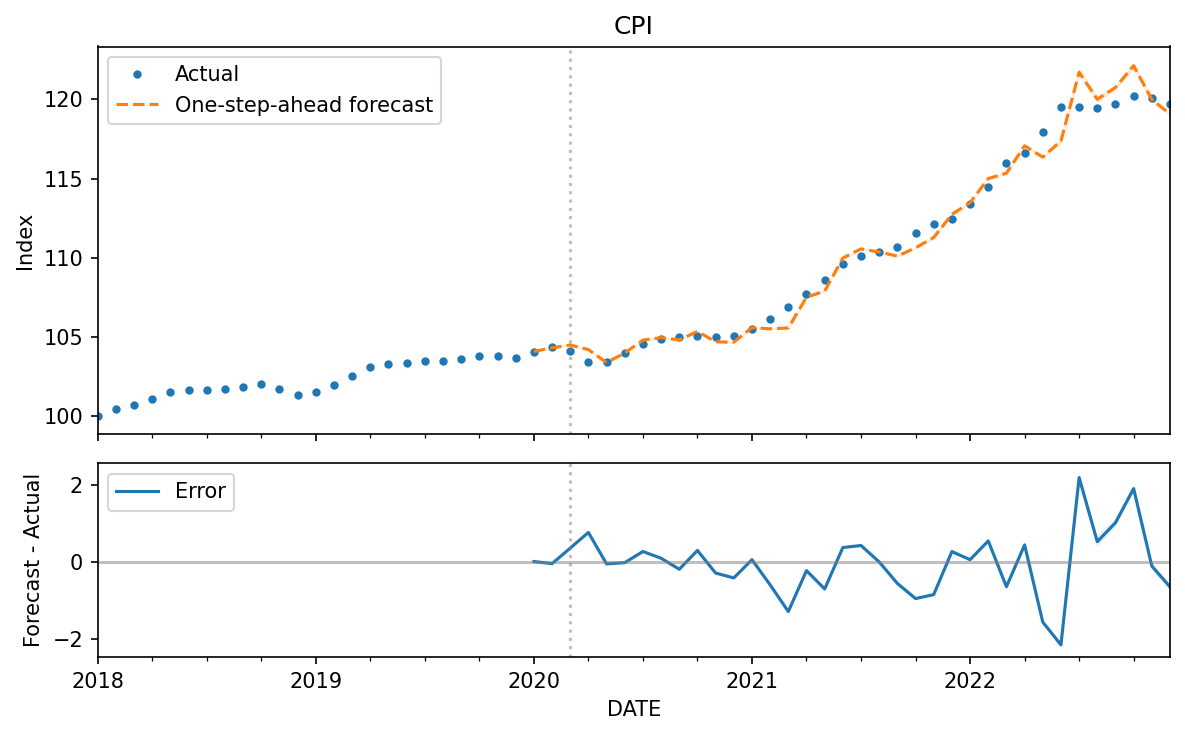

In [136]:
print('MAE = %0.4f' % mae)
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions['mean'], predictions['mean_ci_lower'],
                       predictions['mean_ci_upper'], ax=axes[0])
ax.set(title='CPI', xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors['mean'], errors['ci_lower'], errors['ci_upper'], 
                 ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()

---

## Pet food

In [30]:
cpi_cat = 'PETFOOD'

catfood_dogfood = lambda t: ('dog food' in str(t).lower()) or ('cat food' in str(t).lower())

petfood_purchases = amzn_data[
    (amzn_data['Category']=='PET_FOOD') | \
    ((amzn_data['Category']=='PET_SUPPLIES') \
     & (amzn_data['Title'].apply(catfood_dogfood)))
][['yyyy-mm','Title','ASIN/ISBN (Product Code)','Category','Survey ResponseID','unit price', 'Quantity', 'total price']]
print('%s pet food purchases from N=%s unique customers' % 
      (len(petfood_purchases), petfood_purchases['Survey ResponseID'].nunique()))
petfood_purchases.head(3)

36221 pet food purchases from N=2006 unique customers


yyyy-mm                                              Title   
68  2021-03  Sheba Perfect PORTIONS Wet Cat Food Paté in Na...  \
5   2018-01                       Pet Botanics Training Reward   
12  2018-02                       Pet Botanics Training Reward   

   ASIN/ISBN (Product Code)  Category  Survey ResponseID  unit price   
68               B07NL6D8MD  PET_FOOD  R_3I9Pu8iauEcOx9A       33.00  \
5                B016RXHYRK  PET_FOOD  R_2f2HuzhFg7Fnduq        2.94   
12               B016RXHYRK  PET_FOOD  R_2f2HuzhFg7Fnduq        2.94   

    Quantity  total price  
68       1.0        33.00  
5        4.0        11.76  
12       4.0        11.76

In [31]:
cpi_series = cpi_data[cpi_cat]
agg_metrics = get_monthly_aggregate_metrics(petfood_purchases, cpi_series)
agg_metrics.head()

month        CPI  CPI_lag_1m  totalSpend  purchases  purchasers   
yyyy-mm                                                                    
2018-01      1  100.00000   100.20086     6992.04        349         201  \
2018-02      2  100.20086   100.26626     6273.44        308         184   
2018-03      3  100.26626   100.60792     6879.26        352         191   
2018-04      4  100.60792   100.62460     7313.77        380         213   
2018-05      5  100.62460   100.75606     7041.89        349         210   

          avgSpend  meanSpend  medianSpend  
yyyy-mm                                     
2018-01  20.034499  34.786269        25.99  
2018-02  20.368312  34.094783        25.99  
2018-03  19.543352  36.017068        28.36  
2018-04  19.246763  34.336948        24.98  
2018-05  20.177335  33.532810        25.43

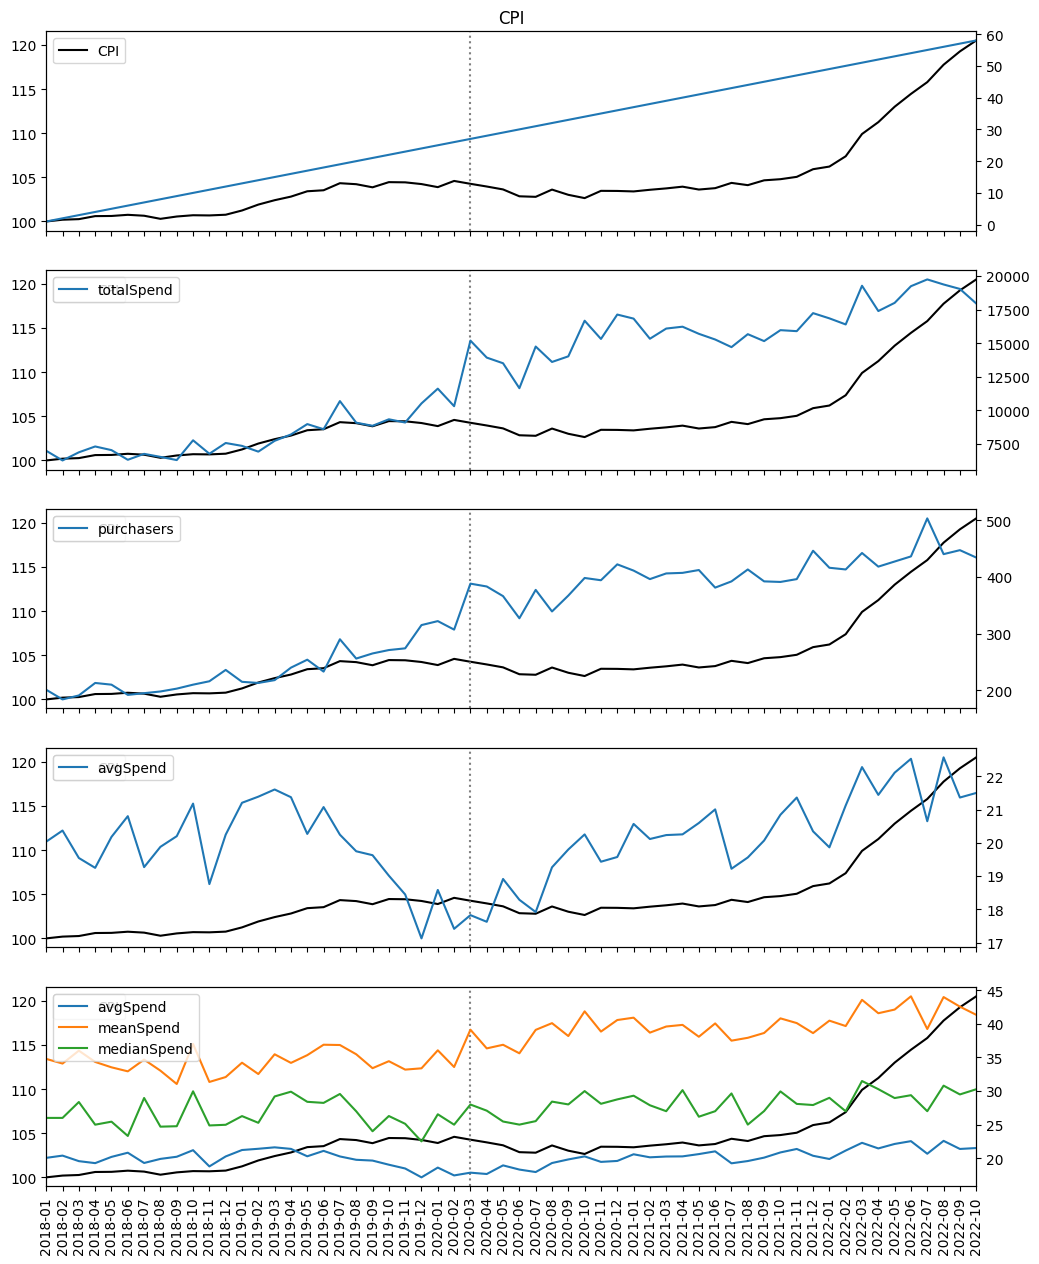

In [32]:
fig, axes = plt.subplots(5,1, figsize=(12, 5*3), sharex=True)

ax = axes[0]
ax.set_title('CPI: %s' % cpi_cat)
plot_monthly_data(agg_metrics['CPI'], ax=ax, title='CPI', label='CPI', show_covid=True, color='black')
ax = ax.twinx()
plot_monthly_data(agg_metrics['month'], ax=ax)
ax = axes[1]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'totalSpend'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[2]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'purchasers'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[3]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
c = 'avgSpend'
plot_monthly_data(agg_metrics[c], ax=ax, label=c)
ax = axes[4]
plot_monthly_data(agg_metrics['CPI'], ax=ax, label='CPI', show_covid=True, color='black')
ax = ax.twinx()
for c in ['avgSpend','meanSpend','medianSpend']:
    plot_monthly_data(agg_metrics[c], ax=ax, label=c)

In [33]:
# smooth the metrics except CPI data
cpi_series = agg_metrics['CPI']
for c in ['avgSpend','meanSpend','medianSpend', 'totalSpend','purchasers']:
    agg_metrics['%s_smoothed'%c] = agg_metrics[c].rolling(3, min_periods=1).mean()
cpi_model_data.index.freq = 'MS'
agg_metrics.index = cpi_model_data.index
agg_metrics.head()

month        CPI  CPI_lag_1m  totalSpend  purchases  purchasers   
DATE                                                                          
2018-01-01      1  100.00000   100.20086     6992.04        349         201  \
2018-02-01      2  100.20086   100.26626     6273.44        308         184   
2018-03-01      3  100.26626   100.60792     6879.26        352         191   
2018-04-01      4  100.60792   100.62460     7313.77        380         213   
2018-05-01      5  100.62460   100.75606     7041.89        349         210   

             avgSpend  meanSpend  medianSpend  avgSpend_smoothed   
DATE                                                               
2018-01-01  20.034499  34.786269        25.99          20.034499  \
2018-02-01  20.368312  34.094783        25.99          20.201405   
2018-03-01  19.543352  36.017068        28.36          19.982054   
2018-04-01  19.246763  34.336948        24.98          19.719476   
2018-05-01  20.177335  33.532810        25.43          19.655817   

            meanSpend_smoothed  medianSpend_smoothed  totalSpend_smoothed   
DATE                                                                        
2018-01-01           34.786269             25.990000          6992.040000  \
2018-02-01           34.440526             25.990000          6632.740000   
2018-03-01           34.966040             26.780000          6714.913333   
2018-04-01           34.816266             26.443333          6822.156667   
2018-05-01           34.628942             26.256667          7078.306667   

            purchasers_smoothed  
DATE                             
2018-01-01           201.000000  
2018-02-01           192.500000  
2018-03-01           192.000000  
2018-04-01           196.000000  
2018-05-01           204.666667

### Petfood CPI prediction

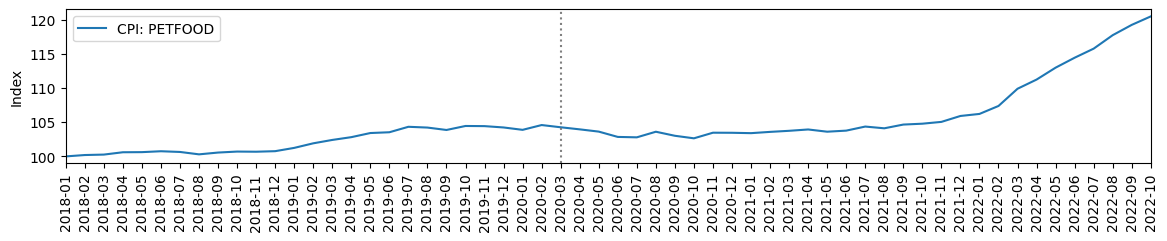

In [34]:
cpi_series = cpi_model_data[cpi_cat]
ax = plot_monthly_data(cpi_data[cpi_cat], 
                       ylabel='Index', label='CPI: %s' % cpi_cat, show_covid=True)

In [36]:
print('CPI: %s' % cpi_cat)
# train through first 2 years of data
predictions, errors, mae = sarimax_train_predict_one_step_ahead(
    cpi_series,
    # This doesn't work well for 2020-01-01
    pred_start='2021-01-01', pred_end='2022-12-01',
    verbose=True
)
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

CPI: PETFOOD
initial training period: 2018-01-01 00:00:00 to 2020-12-01 00:00:00
prediction start, end: 2021-01-01 2022-12-01
0 2020-12-01 00:00:00
AIC: 51.883


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12 2021-12-01 00:00:00
AIC: 67.203
MAE for PETFOOD CPI: 0.6309


### CPI prediction with aggregate purchases data


Basic OLS

- Month alone has R2 = 0.627
- R2 improved when data smoothed

In [46]:
formula = 'CPI ~ month'
# formula = 'CPI ~ month + purchasers'
# formula = 'CPI ~ month + avgSpend'
# formula = 'CPI ~ month + meanSpend'
# formula = 'CPI ~ month + purchasers + avgSpend'
# formula = 'CPI ~ month + purchasers + meanSpend'
# formula = 'CPI ~ month + purchasers_smoothed + avgSpend_smoothed'
formula = 'CPI ~ month + purchasers_smoothed + meanSpend_smoothed' # best
print('Formula:\n%s'%formula)
result = ols(formula=formula, data=agg_metrics).fit()
display(result.summary())

Formula:
CPI ~ month + purchasers_smoothed + meanSpend_smoothed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     46.02
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           6.72e-15
Time:                        16:16:15   Log-Likelihood:                -135.06
No. Observations:                  58   AIC:                             278.1
Df Residuals:                      54   BIC:                             286.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              86.3731      8.771      9.848      0.000      68.789     103.957
month                   0.4798      0.084      5.689      0.000       0.311       0.649
purchasers_smoothed    -0.0734      0.017     -4.432      0.000      -0.107      -0.040
meanSpend_smoothed      0.7547      0.293      2.578      0.013       0.168       1.342
==============================================================================
Omnibus:                       11.568   Durbin-Watson:                   0.155
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.235
Skew:                           0.891   Prob(JB):                      0.00220
Kurtosis:                       4.373   Cond. No.                     8.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
print('OLS predictions')
predictions, errors, mae, train_res = train_predict_one_step_ahead_ols(
    agg_metrics, formula, 
    pred_start='2020-01-01',
    verbose=True,
)
print('MAE %0.4f' % mae)
train_res.summary()

OLS predictions
initial training period: 2018-01-01 00:00:00 to 2019-12-01 00:00:00
prediction start, end: 2020-01-01 2022-10-01 00:00:00
Formula:
CPI ~ month + purchasers_smoothed + meanSpend_smoothed

0 2019-12-01 00:00:00
AIC: 18.089
12 2020-12-01 00:00:00
AIC: 96.644
24 2021-12-01 00:00:00
AIC: 124.659
MAE 2.3926


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     40.52
Date:                Sun, 15 Oct 2023   Prob (F-statistic):           9.49e-14
Time:                        16:16:15   Log-Likelihood:                -129.12
No. Observations:                  57   AIC:                             266.2
Df Residuals:                      53   BIC:                             274.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              88.9566      8.286     10.736      0.000      72.337     105.576
month                   0.4248      0.081      5.213      0.000       0.261       0.588
purchasers_smoothed    -0.0611      0.016     -3.789      0.000      -0.093      -0.029
meanSpend_smoothed      0.6183      0.279      2.216      0.031       0.059       1.178
==============================================================================
Omnibus:                       19.782   Durbin-Watson:                   0.141
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.594
Skew:                           1.188   Prob(JB):                     2.27e-07
Kurtosis:                       5.691   Cond. No.                     8.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

MAE for PETFOOD CPI: 2.3926


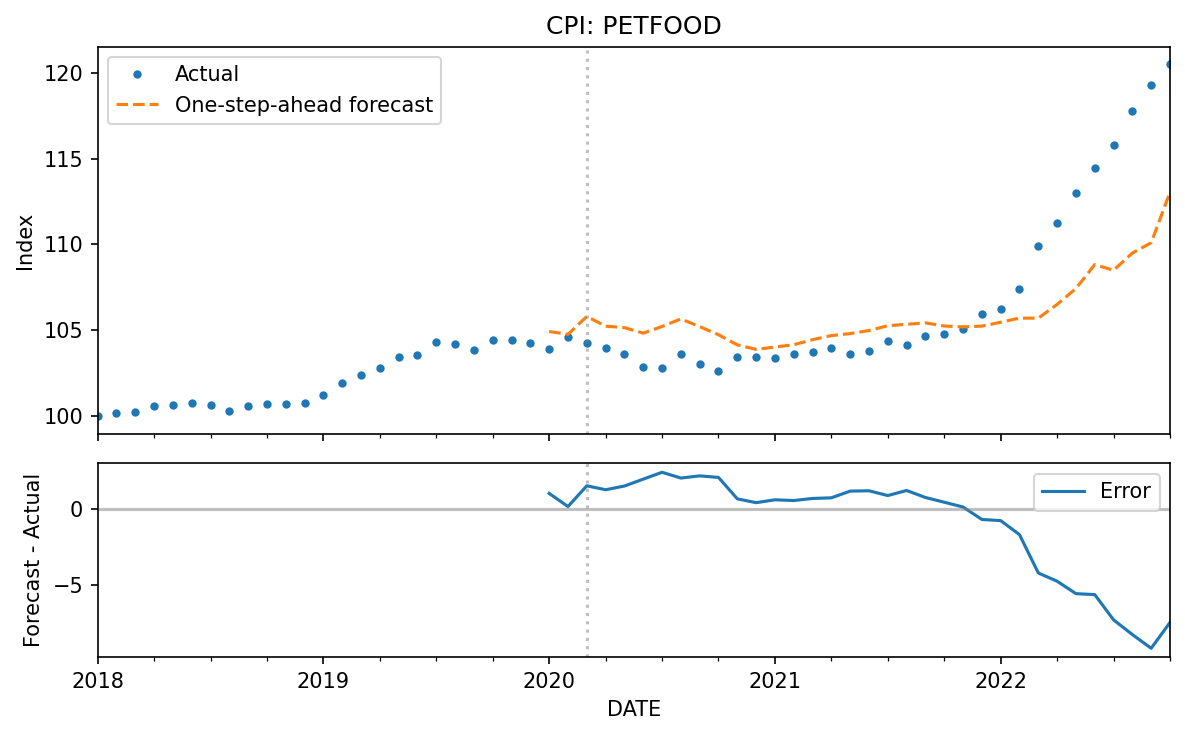

In [48]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions, ax=axes[0])
ax.set(title='CPI: %s'%cpi_cat, xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors, ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

In [49]:
exog_vars = ['purchasers_smoothed', 'meanSpend_smoothed']
# smooth the data
exog = agg_metrics[exog_vars]
exog.head()

purchasers_smoothed  meanSpend_smoothed
DATE                                               
2018-01-01           201.000000           34.786269
2018-02-01           192.500000           34.440526
2018-03-01           192.000000           34.966040
2018-04-01           196.000000           34.816266
2018-05-01           204.666667           34.628942

In [50]:
print('CPI: %s' % cpi_cat)
# train through first 2 years of data
predictions, errors, mae = sarimax_train_predict_one_step_ahead(
    cpi_series, 
    exog=exog,
    pred_start='2021-01-01', pred_end='2022-11-01',
    verbose=True
)
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

CPI: PETFOOD
initial training period: 2018-01-01 00:00:00 to 2020-12-01 00:00:00
prediction start, end: 2021-01-01 2022-11-01


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0 2020-12-01 00:00:00
AIC: 54.801


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12 2021-12-01 00:00:00
AIC: 68.767
MAE for PETFOOD CPI: 0.6827


MAE for PETFOOD CPI: 0.6827


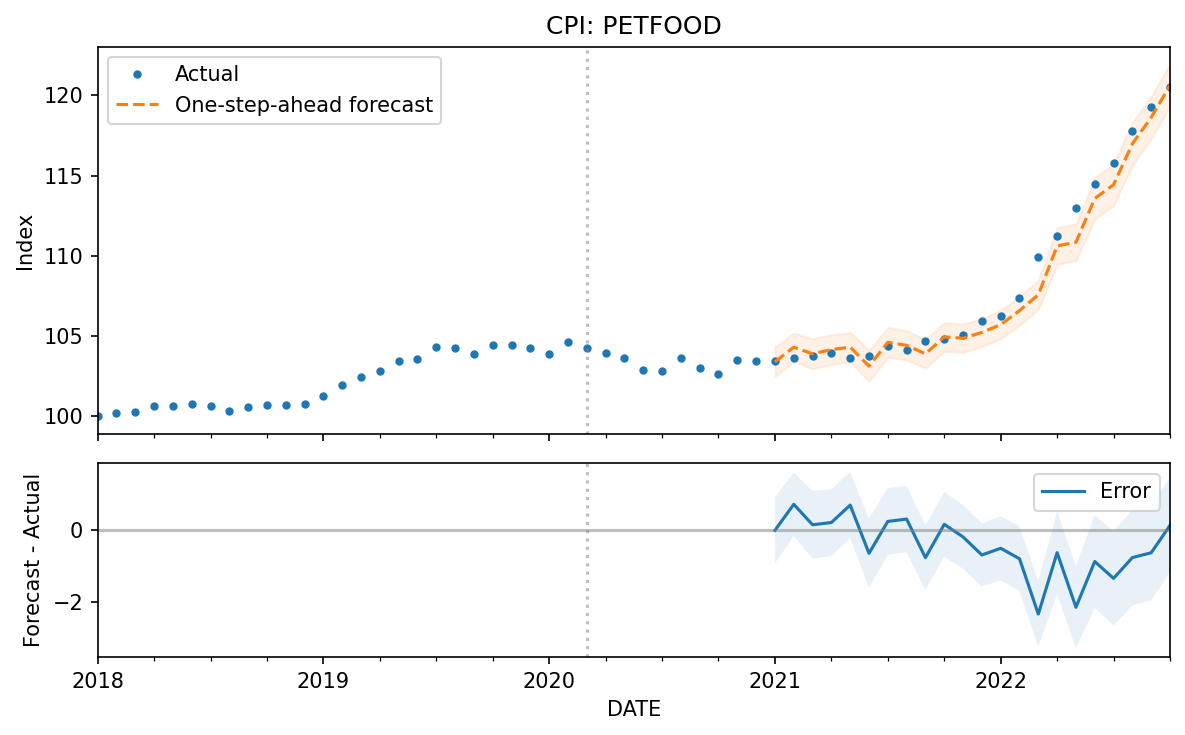

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True, dpi=150, height_ratios=[2, 1])
ax = plot_pred_actual(cpi_series, predictions['mean'], predictions['mean_ci_lower'],
                       predictions['mean_ci_upper'], ax=axes[0])
ax.set(title='CPI: %s'%cpi_cat, xlabel='Date', ylabel='Index')
# errors with 95% CI
ax = plot_errors(errors['mean'], errors['ci_lower'], errors['ci_upper'], 
                 ax=axes[1], idx=cpi_series.index)
ax.set(ylabel='Forecast - Actual')#, title='Forecast error', xlabel='Date')
plt.tight_layout()
print('MAE for %s CPI: %0.4f' % (cpi_cat, mae))

---

### Petfood early product explorations

In [8]:
petfood_purchases = amzn_data[amzn_data['Category']=='PET_FOOD']
print('%s pet food purchases from N=%s unique customers' % 
      (len(petfood_purchases), petfood_purchases['Survey ResponseID'].nunique()))

37315 pet food purchases from N=2028 unique customers


Is there anything that should be categorized as petfood but isn't? 

First get a sense of what to look for by looking at the top PET_FOOD products.

In [9]:
petfood_purchases_top_products = petfood_purchases['Title'].value_counts().sort_values(ascending=False).to_frame()
petfood_purchases_top_products.head(10)

count
Title                                                    
CRAVE Grain Free High Protein Dry Cat Food            189
Good'N'Fun Triple Flavored Rawhide Kabobs for Dogs    170
Fancy Feast Purina Wet Cat Food Variety Packs         152
TEMPTATIONS Classic Crunchy and Soft Cat Treats...    133
Purina Beyond Grain Free, Natural Dry Cat Food,...    124
Fancy Feast Purina Pate Adult Canned Wet Cat Food     123
TEMPTATIONS MIXUPS Crunchy and Soft Cat Treats ...    116
TEMPTATIONS Classic Crunchy and Soft Cat Treats...    106
TEMPTATIONS MixUps Crunchy and Soft Cat Treats,...     94
Blue Buffalo Wilderness High Protein, Natural A...     93

In [10]:
def maybe_petfood(title):
    title = str(title).lower()
    if 'purina ' in title: return True
    if 'fancy feast ' in title: return True
    if 'dog food' in title: return True
    if 'cat food' in title: return True
    return False

maybe_petfood_purchases = amzn_data[(amzn_data['Title'].apply(maybe_petfood)) & (amzn_data['Category'] != 'PET_FOOD')]
# also count the uncategorized maybe petfood purchases
print('%s nan maybe catfood' % len(maybe_petfood_purchases[maybe_petfood_purchases['Category'].isna()]))
maybe_petfood_purchases['Category'].value_counts().sort_values(ascending=False).head(10)

2 nan maybe catfood


Category
ANIMAL_LITTER                    809
PET_FEEDER                       425
PET_SUPPLIES                     367
ANIMAL_NUTRITIONAL_SUPPLEMENT    175
FOOD_STORAGE_CONTAINER           113
PET_PLACEMAT                      89
LITTER_BOX                        25
CONTAINER_LID                     24
PET_TOY                           22
MEASURING_CUP                      8
Name: count, dtype: int64

In [11]:
# PET_SUPPLIES look promising
maybe_petfood_purchases = maybe_petfood_purchases[maybe_petfood_purchases['Category'] == 'PET_SUPPLIES']
maybe_petfood_purchases['Title'].value_counts().sort_values(ascending=False).to_frame().head(10)

count
Title                                                    
Purina Friskies Wet Cat Food Pate Variety Pack ...     37
9Lives Plus Care Dry Cat Food, 13.3 Lb (Discont...     19
Meow Mix Kitten Li'L Nibbles Dry Cat Food, 3.15...     18
Purina DentaLife Daily Oral Care Small/Medium A...     15
Friskies Purina Made in USA Facilities Cat Trea...     13
Purina ONE True Instinct Grain Free High Protei...     13
Purina Cat Chow Naturals Indoor with Real Chick...     11
Purina Friskies Cat Food                               11
Purina Beyond Grain Free, Natural, Adult Wet Ca...     11
Cesar Gourmet Wet Dog Food Variety Packs                8

Should we add these to the petfood purchases?

If they have different product codes would it even make a difference?

In [12]:
# Find items with the same titles and different product codes or categories
print('Q1: Does a single product code ever have multiple categories?')
print('Answer: Yes')
display(amzn_data.groupby('ASIN/ISBN (Product Code)')['Category'].nunique().sort_values(ascending=False).head())

Q1: Does a single product code ever have multiple categories?
Answer: Yes


ASIN/ISBN (Product Code)
B000SKLRCW    5
B07VM5L943    4
B074H61M18    4
B000WHTWD2    4
B000SKI5AY    4
Name: Category, dtype: int64

In [13]:
print('Q2: Does a single product code ever have multiple titles? What would that mean?')
print('Answer: Yes; The title was updated over time. This may mean the product changed.')
display(petfood_purchases.groupby('ASIN/ISBN (Product Code)')['Title'].nunique().sort_values(ascending=False).head())

Q2: Does a single product code ever have multiple titles? What would that mean?
Answer: Yes; The title was updated over time. This may mean the product changed.


ASIN/ISBN (Product Code)
B0000AH3QW    5
B00JN9IWNG    5
B01GJJHU4O    4
B08ZJWPH1P    4
B084D4JJ46    4
Name: Title, dtype: int64

In [14]:
print('Q3: Does a single TITLE ever have multiple product codes? What would that mean?')
print('Answer: Yes; Do not aggregate by Title -- different product codes have different quality/size and different pricing.')
display(petfood_purchases.groupby('Title')['ASIN/ISBN (Product Code)'].nunique().sort_values(ascending=False).to_frame().head())

Q3: Does a single TITLE ever have multiple product codes? What would that mean?
Answer: Yes; Do not aggregate by Title -- different product codes have different quality/size and different pricing.


ASIN/ISBN (Product Code)
Title                                                                       
1                                                                         21
Fancy Feast Purina Pate Adult Canned Wet Cat Food                         12
Purina Friskies Canned Wet Cat Food - (24) 5.5 ...                        12
Pet Botanics Training Reward                                              10
CRAVE Grain Free High Protein Dry Cat Food                                 9

In [15]:
petfood_purchases[
    (petfood_purchases['Title']=='CRAVE Grain Free High Protein Dry Cat Food')
].sort_values('Order Date')[['Order Date', 'unit price', 'Quantity', 'Title', 'ASIN/ISBN (Product Code)']].head(10)

Order Date  unit price  Quantity   
44   2018-03-26       12.79       1.0  \
51   2018-04-01       30.99       1.0   
55   2018-04-18       30.99       1.0   
66   2018-05-06        9.69       2.0   
76   2018-05-19       30.99       1.0   
7    2018-06-01       30.99       1.0   
95   2018-06-18       30.99       1.0   
111  2018-07-10        9.69       3.0   
120  2018-07-19       30.99       1.0   
13   2018-07-27       29.44       1.0   

                                          Title ASIN/ISBN (Product Code)  
44   CRAVE Grain Free High Protein Dry Cat Food               B0716KVGHB  
51   CRAVE Grain Free High Protein Dry Cat Food               B071HGT9YB  
55   CRAVE Grain Free High Protein Dry Cat Food               B071HGT9YB  
66   CRAVE Grain Free High Protein Dry Cat Food               B0716KVGHB  
76   CRAVE Grain Free High Protein Dry Cat Food               B071HGT9YB  
7    CRAVE Grain Free High Protein Dry Cat Food               B071VFC2VT  
95   CRAVE Grain Free High Protein Dry Cat Food               B071HGT9YB  
111  CRAVE Grain Free High Protein Dry Cat Food               B0716KVGHB  
120  CRAVE Grain Free High Protein Dry Cat Food               B071HGT9YB  
13   CRAVE Grain Free High Protein Dry Cat Food               B071VFC2VT

Outcome:

Since a single product code can be labeled with multiple categories, we add likely petfood labeled as 'PET_SUPPLIES' to our petfood purchases.



In [16]:
print('initially %s pet food purchases from N=%s unique customers' % 
      (len(petfood_purchases), petfood_purchases['Survey ResponseID'].nunique()))
print('adding likely pet food purchases labeled as "PET_SUPPLIES"')
petfood_purchases = pd.concat([petfood_purchases, maybe_petfood_purchases[maybe_petfood_purchases['Category'] == 'PET_SUPPLIES']])
print('%s pet food purchases from N=%s unique customers' % 
      (len(petfood_purchases), petfood_purchases['Survey ResponseID'].nunique()))

initially 37315 pet food purchases from N=2028 unique customers
adding likely pet food purchases labeled as "PET_SUPPLIES"
37682 pet food purchases from N=2037 unique customers


Initial questions (without restricting to specific products)

Over the months how many...?
- unique products being purchased
- unique people purchasing petfood products
- total purchases

unique products purchased each month (petfood)


count     60.000000
mean     482.716667
std      143.199410
min      248.000000
25%      317.500000
50%      541.000000
75%      602.500000
max      707.000000
Name: ASIN/ISBN (Product Code), dtype: float64

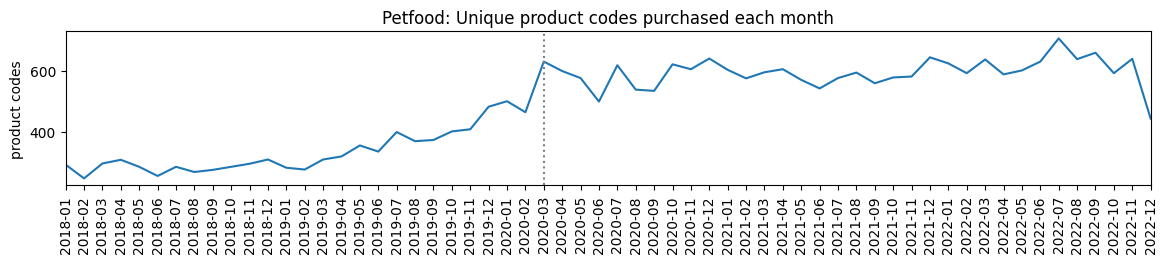

In [17]:
# unique products purchased each month
print('unique products purchased each month (petfood)')
petfood_monthly_products = petfood_purchases.groupby(
    'yyyy-mm'
)['ASIN/ISBN (Product Code)'].nunique().sort_index()
display(petfood_monthly_products.describe())
fig, ax = plt.subplots(1,1, figsize=(14,2))
ax.plot(petfood_monthly_products)
ax.set_xlim('2018-01', '2022-12')
ax.axvline(x='2020-03', ymin=0, color='gray', linestyle=':')
ax.set_title('Petfood: Unique product codes purchased each month')
ax.set_ylabel('product codes')
_ = plt.xticks(rotation = 90)

Unique people purchasing petfood products each month


count     60.000000
mean     330.983333
std       92.106882
min      185.000000
25%      235.250000
50%      367.000000
75%      412.000000
max      503.000000
Name: Survey ResponseID, dtype: float64

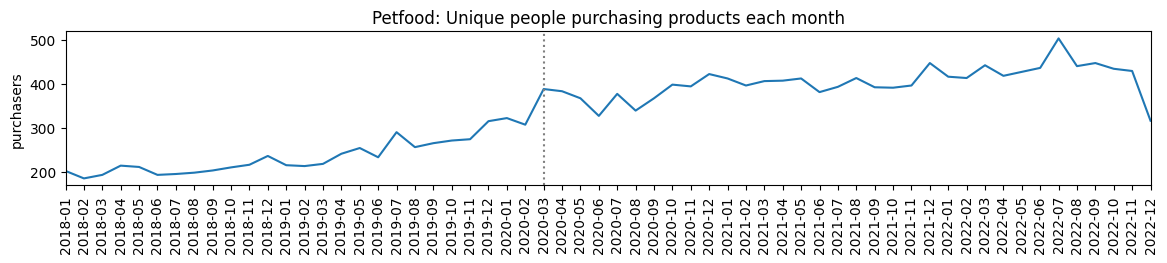

In [18]:
# Unique people purchasing petfood products each month
print('Unique people purchasing petfood products each month')
petfood_monthly_purchasers = petfood_purchases.groupby(
    'yyyy-mm'
)['Survey ResponseID'].nunique().sort_index()
display(petfood_monthly_purchasers.describe())
fig, ax = plt.subplots(1,1, figsize=(14,2))
ax.plot(petfood_monthly_purchasers)
ax.set_xlim('2018-01', '2022-12')
ax.axvline(x='2020-03', ymin=0, color='gray', linestyle=':')
ax.set_title('Petfood: Unique people purchasing products each month')
ax.set_ylabel('purchasers')
_ = plt.xticks(rotation = 90)

Note: Minimum people buying petfood each month > 185

Total petfood purchases each month


count     60.000000
mean     628.033333
std      209.022500
min      305.000000
25%      385.000000
50%      712.000000
75%      812.750000
max      957.000000
Name: Survey ResponseID, dtype: float64

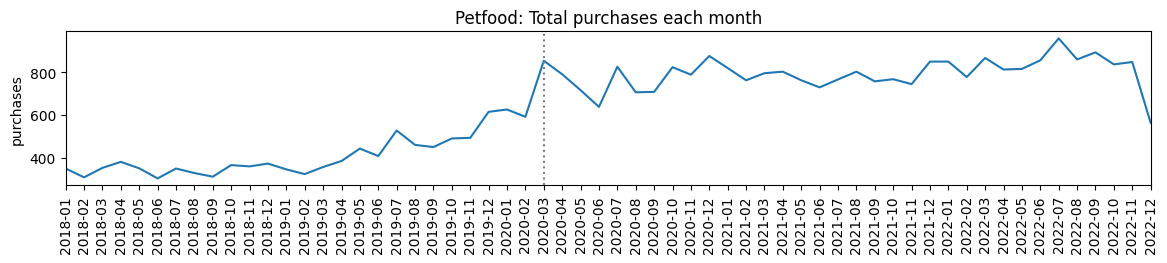

In [19]:
# Total petfood purchases each month (distinct purchases, not sum of quantities)
print('Total petfood purchases each month')
petfood_monthly_purchases = petfood_purchases.groupby(
    'yyyy-mm'
)['Survey ResponseID'].count().sort_index()
display(petfood_monthly_purchases.describe())
fig, ax = plt.subplots(1,1, figsize=(14,2))
ax.plot(petfood_monthly_purchases)
ax.set_xlim('2018-01', '2022-12')
ax.axvline(x='2020-03', ymin=0, color='gray', linestyle=':')
ax.set_title('Petfood: Total purchases each month')
ax.set_ylabel('purchases')
_ = plt.xticks(rotation = 90)

Note: Minimum purchases each month > 300

How did the median price of purchases change month to month when looking at ALL data?

Petfood: Median unit price each month


count    60.000000
mean     14.375750
std       1.031568
min      12.110000
25%      13.687500
50%      14.417500
75%      14.980000
max      16.490000
Name: unit price, dtype: float64

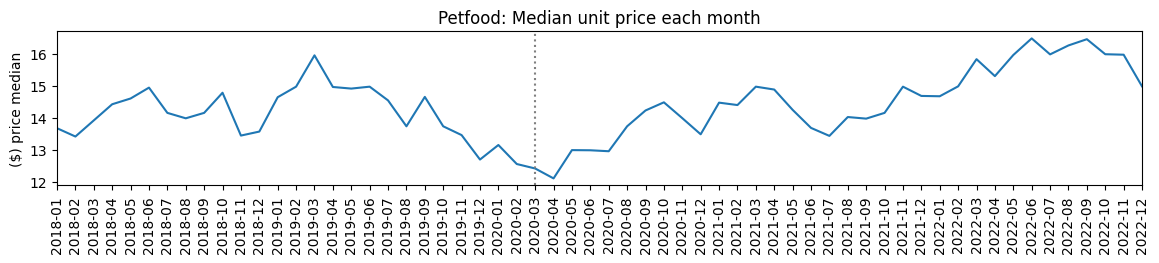

In [20]:
print('Petfood: Median unit price each month')
petfood_monthly_price_median = petfood_monthly_purchases = petfood_purchases.groupby(
    'yyyy-mm'
)['unit price'].agg('median').sort_index()
display(petfood_monthly_price_median.describe())
fig, ax = plt.subplots(1,1, figsize=(14,2))
ax.plot(petfood_monthly_price_median)
ax.set_xlim('2018-01', '2022-12')
ax.axvline(x='2020-03', ymin=0, color='gray', linestyle=':')
ax.set_title('Petfood: Median unit price each month')
ax.set_ylabel('($) price median')
_ = plt.xticks(rotation = 90)

### Restrict analysis to products with a lot of data?

In [21]:
print('Months of data for each product')
petfood_months = petfood_purchases.groupby(
    ['ASIN/ISBN (Product Code)']
)['yyyy-mm'].nunique()
display(petfood_months.describe())
print('How many petfood products have at least 4 years (48 months) of data?')
petfood_months_48 = petfood_months[petfood_months >= 48]
print('Answer: ', len(petfood_months_48))
petfood_months_48.describe()

Months of data for each product


count    6720.000000
mean        4.309970
std         6.567331
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        59.000000
Name: yyyy-mm, dtype: float64

How many petfood products have at least 4 years (48 months) of data?
Answer:  20


count    20.000000
mean     52.850000
std       3.375999
min      48.000000
25%      50.750000
50%      52.500000
75%      56.000000
max      59.000000
Name: yyyy-mm, dtype: float64

In [22]:
petfood_months_codes_use = petfood_months_48.index

In [23]:
petfood_purchases_use = petfood_purchases[
    petfood_purchases['ASIN/ISBN (Product Code)'].isin(petfood_months_codes_use)
]

In [24]:
# Get titles for items
petfood_titles = petfood_purchases_use[
    ['ASIN/ISBN (Product Code)', 'Title']
].drop_duplicates(
    subset='ASIN/ISBN (Product Code)', keep='last'
).set_index('ASIN/ISBN (Product Code)')
petfood_titles.head()

Title
ASIN/ISBN (Product Code)                                                   
B008T6RIVG                         Nutro Crunchy Natural Biscuit Dog Treats
B008OV92WE                           HILL'S Natural Jerky Strips Dog Treats
B071HGT9YB                CRAVE Grain Free Adult High Protein Natural Dr...
B002UT92EY                Blue Buffalo Wilderness High Protein, Natural ...
B008EXERJK                Blue Buffalo Tastefuls Sensitive Stomach Natur...

Count and plot unique number of people buying the product each month

In [25]:
# Unique number of people buying product each month
petfood_months_48_respondents = petfood_purchases_use.groupby(
    ['ASIN/ISBN (Product Code)', 'yyyy-mm']
)['Survey ResponseID'].nunique().rename('count')
display(petfood_months_48_respondents.describe())
# petfood_months_48_respondents.head()

count    1057.000000
mean        1.702933
std         1.023734
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: count, dtype: float64

In [26]:
# For each product, get the median number of unique respondents over all of the months
petfood_monthly_median_respondents = pd.DataFrame({
   'ASIN/ISBN (Product Code)': [p for p in petfood_months_codes_use],
    'Title': [petfood_titles.loc[p][0] for p in petfood_months_codes_use],
    'median unique respondents': [petfood_months_48_respondents.reset_index().set_index('ASIN/ISBN (Product Code)').loc[p_code].set_index('yyyy-mm').reindex(amzn_data_idx)['count'].median() for p_code in petfood_months_codes_use]
}).set_index('ASIN/ISBN (Product Code)').sort_values('median unique respondents', ascending=False)
petfood_monthly_median_respondents

Title   
ASIN/ISBN (Product Code)                                                      
B001STX13U                Fancy Feast Grilled Wet Cat Food Seafood Colle...  \
B00OLSARS2                TEMPTATIONS MixUps Crunchy and Soft Cat Treats...   
B00HQM0UMS                GREENIES PILL POCKETS Capsule Size Natural Dog...   
B00JVHSEAQ                Purina Beyond Grain Free, Natural Dry Cat Food...   
B01LNB6SA0                TEMPTATIONS Classic Crunchy and Soft Cat Treat...   
B072DTFZHL                SHEBA Wet Cat Food Cuts in Gravy Variety Pack,...   
B002UT92EY                Blue Buffalo Wilderness High Protein, Natural ...   
B001STPJJO                Purina Fancy Feast Grain Free Pate Wet Cat Foo...   
B008EXERJK                Blue Buffalo Tastefuls Sensitive Stomach Natur...   
B008OV92WE                           HILL'S Natural Jerky Strips Dog Treats   
B008T6RIVG                         Nutro Crunchy Natural Biscuit Dog Treats   
B00CQIOD8O                Wellness Complete Health Small Breed Dry Dog F...   
B001HYB2P0                Wellness Complete Health Small Breed Dry Dog F...   
B007E9VDF6                Pedigree Dentastix Fresh Treats for Large Dogs...   
B00TQRK9ZE                NUTRO NATURAL CHOICE Large Breed Adult Dry Dog...   
B0114BNXQ6                Milk-Bone Mini's Flavor Snacks Dog Treats, 36 ...   
B01BNBJY6A                Milk-Bone Peanut Butter Flavor Dog Treats, Sma...   
B01MRZ20T9                TEMPTATIONS Classic Crunchy and Soft Cat Treat...   
B071HGT9YB                CRAVE Grain Free Adult High Protein Natural Dr...   
B0010B6IFY                Fancy Feast Grilled Wet Cat Food Poultry and B...   

                          median unique respondents  
ASIN/ISBN (Product Code)                             
B001STX13U                                      3.0  
B00OLSARS2                                      3.0  
B00HQM0UMS                                      2.0  
B00JVHSEAQ                                      2.0  
B01LNB6SA0                                      2.0  
B072DTFZHL                                      2.0  
B002UT92EY                                      2.0  
B001STPJJO                                      2.0  
B008EXERJK                                      1.0  
B008OV92WE                                      1.0  
B008T6RIVG                                      1.0  
B00CQIOD8O                                      1.0  
B001HYB2P0                                      1.0  
B007E9VDF6                                      1.0  
B00TQRK9ZE                                      1.0  
B0114BNXQ6                                      1.0  
B01BNBJY6A                                      1.0  
B01MRZ20T9                                      1.0  
B071HGT9YB                                      1.0  
B0010B6IFY                                      1.0

In [27]:
print('Check: Are people ever buying large quantities in a single order?')
print('Answer: Yes. A lot of times people buy 5 at a time.')
petfood_purchases_use.groupby(
    ['ASIN/ISBN (Product Code)', 'yyyy-mm', 'Quantity']
)['Survey ResponseID'].count().reset_index().sort_values(['Quantity', 'yyyy-mm'], ascending=False).head(10)

Check: Are people ever buying large quantities in a single order?
Answer: Yes. A lot of times people buy 5 at a time.


ASIN/ISBN (Product Code)  yyyy-mm  Quantity  Survey ResponseID
242               B001STX13U  2020-11       5.0                  1
768               B00OLSARS2  2020-11       5.0                  1
239               B001STX13U  2020-10       5.0                  1
236               B001STX13U  2020-09       5.0                  1
232               B001STX13U  2020-08       5.0                  1
229               B001STX13U  2020-07       5.0                  1
226               B001STX13U  2020-06       5.0                  1
224               B001STX13U  2020-05       5.0                  1
221               B001STX13U  2020-04       5.0                  1
218               B001STX13U  2020-03       5.0                  1

Count and plot total quantity (sum) purchased each month

In [28]:
petfood_months_48_quantities = petfood_purchases_use.groupby(
    ['ASIN/ISBN (Product Code)', 'yyyy-mm']
)['Quantity'].sum().rename('count')
display(petfood_months_48_quantities.describe())
# petfood_months_48_quantities.head()

count    1057.000000
mean        2.305582
std         1.928233
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        13.000000
Name: count, dtype: float64

Count and plot total number of distinct purchases for product each month

(Remember the describe call does not reset index to control for 0's)

In [29]:
# Unique number of people buying product each month
petfood_months_48_purchases = petfood_purchases_use.groupby(
    ['ASIN/ISBN (Product Code)', 'yyyy-mm']
)['Survey ResponseID'].count().rename('count')
display(petfood_months_48_purchases.describe())
# petfood_months_48_purchases.head()

count    1057.000000
mean        1.893094
std         1.278804
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: count, dtype: float64

In [30]:
# Determine top products as the products where median number of unique respondents was > 1
petfood_top_products = petfood_monthly_median_respondents[petfood_monthly_median_respondents['median unique respondents'] > 1].dropna()
petfood_top_product_codes = petfood_top_products.index
petfood_top_products

Title   
ASIN/ISBN (Product Code)                                                      
B001STX13U                Fancy Feast Grilled Wet Cat Food Seafood Colle...  \
B00OLSARS2                TEMPTATIONS MixUps Crunchy and Soft Cat Treats...   
B00HQM0UMS                GREENIES PILL POCKETS Capsule Size Natural Dog...   
B00JVHSEAQ                Purina Beyond Grain Free, Natural Dry Cat Food...   
B01LNB6SA0                TEMPTATIONS Classic Crunchy and Soft Cat Treat...   
B072DTFZHL                SHEBA Wet Cat Food Cuts in Gravy Variety Pack,...   
B002UT92EY                Blue Buffalo Wilderness High Protein, Natural ...   
B001STPJJO                Purina Fancy Feast Grain Free Pate Wet Cat Foo...   

                          median unique respondents  
ASIN/ISBN (Product Code)                             
B001STX13U                                      3.0  
B00OLSARS2                                      3.0  
B00HQM0UMS                                      2.0  
B00JVHSEAQ                                      2.0  
B01LNB6SA0                                      2.0  
B072DTFZHL                                      2.0  
B002UT92EY                                      2.0  
B001STPJJO                                      2.0

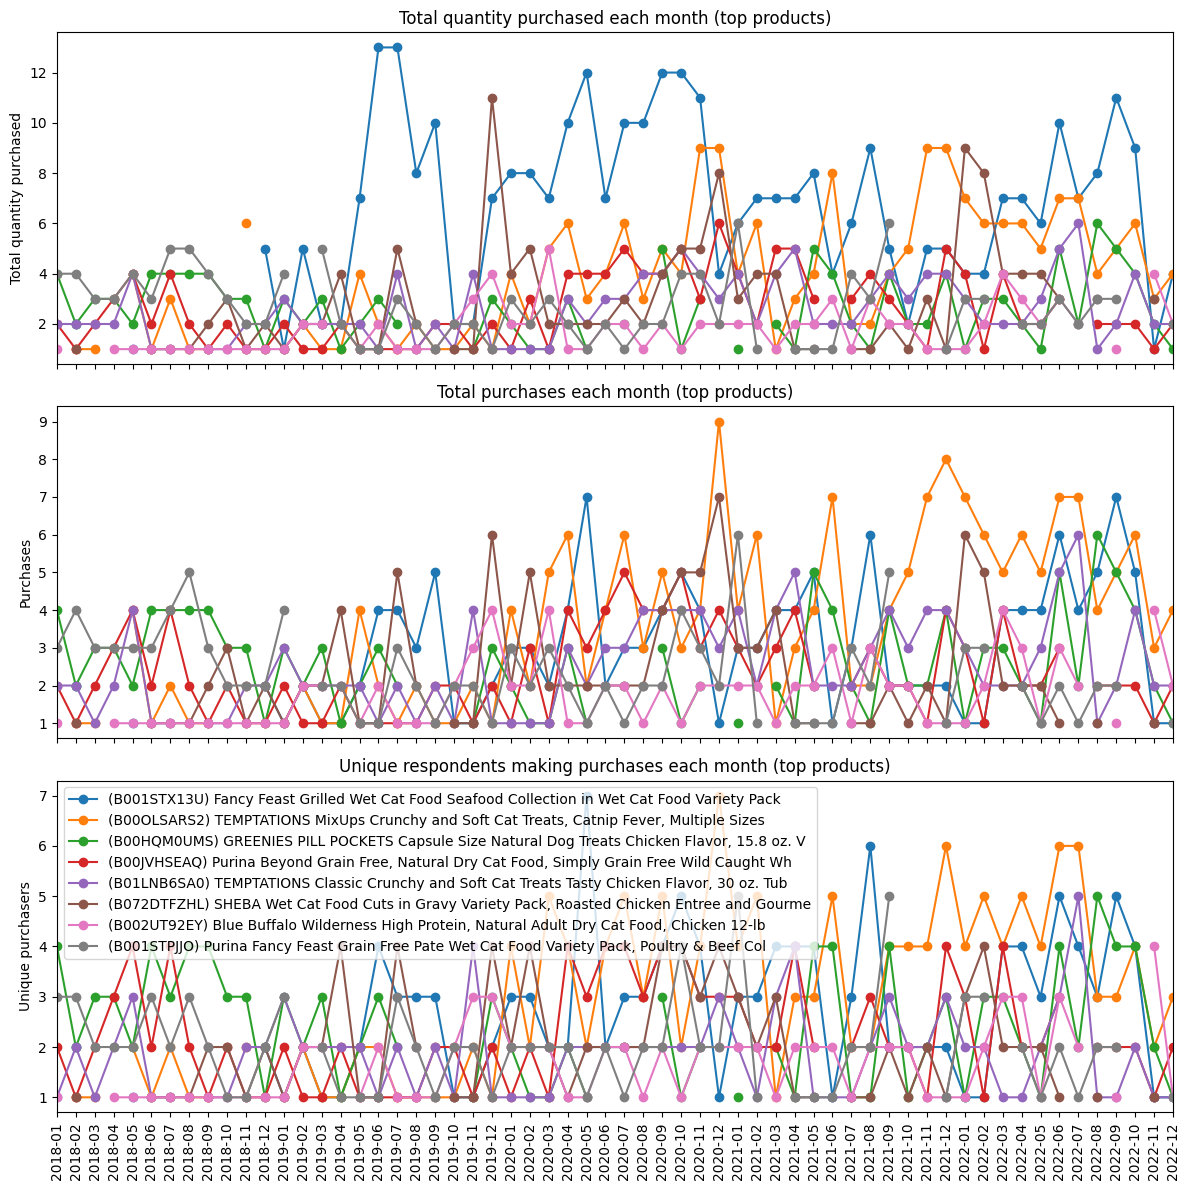

In [31]:
# Top products determined by median number of unique people buying the item each month

def plot_product_purchases(data, ax):
    for i, product_code in enumerate(petfood_top_product_codes):
        # get the series for just this product. 
        # reindex to include all dates, including when no purchases
        ps = data.reset_index().set_index(
            'ASIN/ISBN (Product Code)'
        ).loc[product_code].reset_index().set_index('yyyy-mm').reindex(
            sorted(amzn_data['yyyy-mm'].unique())
        )['count']
        ax.plot(ps, marker='o', label='(%s) %s' % (product_code, petfood_titles.loc[product_code][0][:80]))
        ax.set_xlim('2018-01', '2022-12')

fig, axes = plt.subplots(3,1, figsize=(12, 3*4), sharex=True)
title = 'Total quantity purchased each month (top products)'
ax = axes[0]
plot_product_purchases(petfood_months_48_quantities, ax=ax)
ax.set_title(title)
ax.set_ylabel('Total quantity purchased')
title = 'Total purchases each month (top products)'
ax = axes[1]
plot_product_purchases(petfood_months_48_purchases, ax=ax)
ax.set_title(title)
ax.set_ylabel('Purchases')
title = 'Unique respondents making purchases each month (top products)'
ax = axes[2]
plot_product_purchases(petfood_months_48_respondents, ax=ax)
ax.set_title(title)
ax.set_ylabel('Unique purchasers')
_ = plt.xticks(rotation = 90)
plt.legend()
plt.tight_layout()

For the top products: Plot the prices for each purchase and the median price

Make a dataframe:

```
yyyy-mm, [product code]_med_price, [product code]_purchases
```

which includes each product code in top products. where:
- med price is the median over all the purchase prices in the yyyy-mm, otherwise NaN
    - Nan needs to be imputed
- purchases is the number of distinct purchases, not the sum over quantity (to avoid variance caused by people buying a lot at once)


In [32]:
petfood_purchases_top_products = petfood_purchases[
    petfood_purchases['ASIN/ISBN (Product Code)'].isin(petfood_top_product_codes)
]
print('%s purchases made by N=%s distinct respondents when limiting to top products' % (
len(petfood_purchases_top_products), petfood_purchases_top_products['Survey ResponseID'].nunique()))

1114 purchases made by N=174 distinct respondents when limiting to top products


In [33]:
petfood_prices_df = pd.DataFrame({
    'yyyy-mm': amzn_data_idx,
}).set_index('yyyy-mm')
for p_code in petfood_top_product_codes:
    p_data = petfood_purchases[
        (petfood_purchases['ASIN/ISBN (Product Code)']==p_code)
    ].groupby('yyyy-mm')['unit price'].agg(['median', 'count'])
    petfood_prices_df['%s_med_price'%p_code] = p_data['median']
    petfood_prices_df['%s_purchases'%p_code] = p_data['count']

petfood_prices_df.head()

B001STX13U_med_price  B001STX13U_purchases  B00OLSARS2_med_price   
yyyy-mm                                                                     
2018-01                   NaN                   NaN                   NaN  \
2018-02                12.585                   2.0                  7.94   
2018-03                   NaN                   NaN                  7.98   
2018-04                   NaN                   NaN                   NaN   
2018-05                13.190                   1.0                  7.98   

         B00OLSARS2_purchases  B00HQM0UMS_med_price  B00HQM0UMS_purchases   
yyyy-mm                                                                     
2018-01                   NaN                16.265                   4.0  \
2018-02                   1.0                16.990                   2.0   
2018-03                   1.0                16.990                   3.0   
2018-04                   NaN                16.990                   3.0   
2018-05                   4.0                16.990                   2.0   

         B00JVHSEAQ_med_price  B00JVHSEAQ_purchases  B01LNB6SA0_med_price   
yyyy-mm                                                                     
2018-01                19.495                   2.0                 14.84  \
2018-02                18.500                   1.0                 14.18   
2018-03                18.500                   2.0                 14.18   
2018-04                20.490                   3.0                 14.98   
2018-05                20.490                   4.0                 14.98   

         B01LNB6SA0_purchases  B072DTFZHL_med_price  B072DTFZHL_purchases   
yyyy-mm                                                                     
2018-01                   2.0                   NaN                   NaN  \
2018-02                   2.0                 16.56                   1.0   
2018-03                   1.0                   NaN                   NaN   
2018-04                   2.0                   NaN                   NaN   
2018-05                   4.0                   NaN                   NaN   

         B002UT92EY_med_price  B002UT92EY_purchases  B001STPJJO_med_price   
yyyy-mm                                                                     
2018-01                 32.95                   1.0                 12.59  \
2018-02                   NaN                   NaN                 12.58   
2018-03                   NaN                   NaN                 12.59   
2018-04                 33.99                   1.0                 12.59   
2018-05                 33.99                   1.0                 13.19   

         B001STPJJO_purchases  
yyyy-mm                        
2018-01                   3.0  
2018-02                   4.0  
2018-03                   3.0  
2018-04                   3.0  
2018-05                   3.0

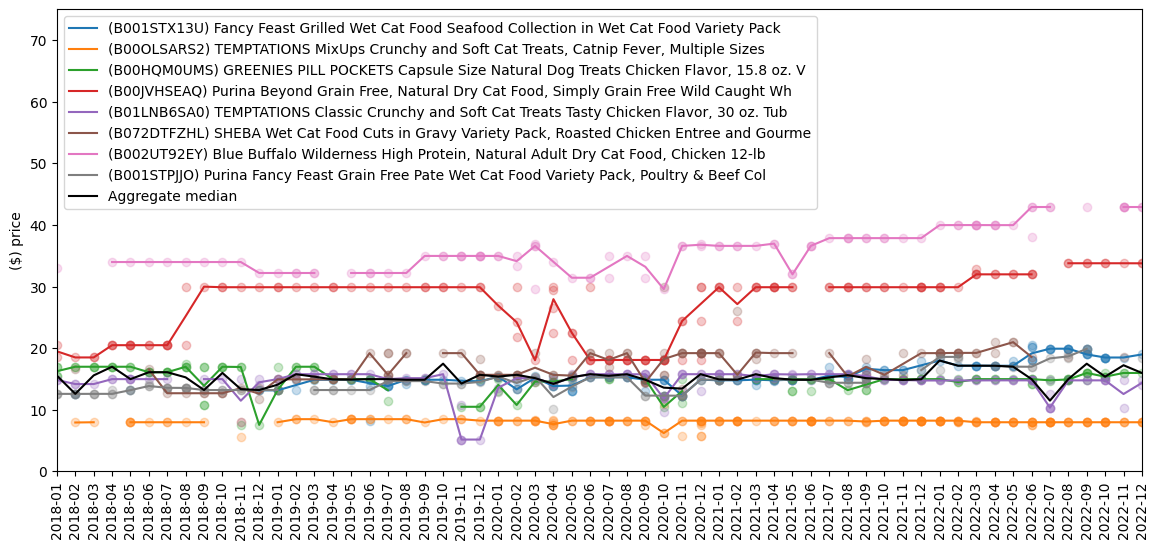

In [34]:
fig, ax = plt.subplots(1,1, figsize=(14, 6))
title = 'Median price for pet food products'
dummy_series_idx = pd.DataFrame(
    {'yyyy-mm': amzn_data_idx, 'unit price': [np.nan]*len(amzn_data_idx)}
)
for i, p_code in enumerate(petfood_top_product_codes):
    purchases = pd.concat([
        dummy_series_idx, # fill in the gaps between dates of purchases
        petfood_purchases[(petfood_purchases['ASIN/ISBN (Product Code)']==p_code)]
    ]).sort_values('yyyy-mm')
    ax.scatter(purchases['yyyy-mm'], purchases['unit price'], alpha=0.25)
    ax.plot(petfood_prices_df['%s_med_price'%p_code], 
            label='(%s) %s' % (p_code, petfood_titles.loc[p_code][0][:80]))

# show the aggregate median for these petfood product prices
petfood_agg_median = petfood_purchases[
    petfood_purchases['ASIN/ISBN (Product Code)'].isin(petfood_top_product_codes)
].groupby('yyyy-mm')['unit price'].agg('median')
ax.plot(petfood_agg_median, label='Aggregate median', color='black')
ax.set_xlim('2018-01', '2022-12')
ax.set_ylim(0, 75)
ax.set_ylabel('($) price')
_ = plt.xticks(rotation = 90)
_ = plt.legend()

### Alternative ways to choose the products

#### Ideas for how to set products:

Baseline criteria:
- at least M=48 months of purchases
    - TODO? how to handle when want to predict later months?
    - Alternative: at least M months of purchases data and Months m-n have purchases data
- in category 'PET_FOOD' or in 'PET_SUPPLIES' with titles containing specific terms: ['cat food', 'dog food']
    - Note: Using M=48, including PET_SUPPLIES does not enlarge baseline purchases dataset


Criteria 0:
- All items meeting baseline criteria AND
- median monthly purchases >=2

Alternative criteria a:
- all items meeting baseline criteria
- use Lasso regression to then choose top P most important products

Alternative criteria b:
- 'cat food' or 'dog food' in title
    - (median monthly purchases >=2 will not include 'dog food')


In [35]:
# make _petfood_purchases ase baseline petfood purchases dataset

min_M = 48 # required number of months of data

catfood_dogfood = lambda t: ('dog food' in str(t).lower()) or ('cat food' in str(t).lower())

_petfood_purchases = amzn_data[
    (amzn_data['Category']=='PET_FOOD') | \
    ((amzn_data['Category']=='PET_SUPPLIES') \
     & (amzn_data['Title'].apply(catfood_dogfood)))
][['yyyy-mm','Title','ASIN/ISBN (Product Code)','Category','Survey ResponseID','unit price', 'Quantity']]
print('%s pet food purchases from N=%s unique customers' % 
      (len(_petfood_purchases), _petfood_purchases['Survey ResponseID'].nunique()))
_petfood_purchases.head(3)

37630 pet food purchases from N=2035 unique customers


yyyy-mm                                              Title   
68  2021-03  Sheba Perfect PORTIONS Wet Cat Food Paté in Na...  \
5   2018-01                       Pet Botanics Training Reward   
12  2018-02                       Pet Botanics Training Reward   

   ASIN/ISBN (Product Code)  Category  Survey ResponseID  unit price  Quantity  
68               B07NL6D8MD  PET_FOOD  R_3I9Pu8iauEcOx9A       33.00       1.0  
5                B016RXHYRK  PET_FOOD  R_2f2HuzhFg7Fnduq        2.94       4.0  
12               B016RXHYRK  PET_FOOD  R_2f2HuzhFg7Fnduq        2.94       4.0

In [36]:
_petfood_months = _petfood_purchases.groupby(
    ['ASIN/ISBN (Product Code)']
)['yyyy-mm'].nunique()
display(_petfood_months.describe())
print('Restricting to %s pet food products that have at least 4 years (48 months) of data' %
     len(_petfood_months[_petfood_months >= min_M]))
_petfood_purchases = _petfood_purchases[
    _petfood_purchases['ASIN/ISBN (Product Code)'].isin(
        _petfood_months[_petfood_months >= min_M].index
    )]
print('%s pet food purchases from N=%s unique customers' % 
      (len(_petfood_purchases), _petfood_purchases['Survey ResponseID'].nunique()))
print('\ncategories include:', list(_petfood_purchases['Category'].unique()))
_petfood_purchases.head(3)

count    6709.000000
mean        4.309733
std         6.568686
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        59.000000
Name: yyyy-mm, dtype: float64

Restricting to 20 pet food products that have at least 4 years (48 months) of data
2001 pet food purchases from N=247 unique customers

categories include: ['PET_FOOD']


yyyy-mm                                          Title   
119  2018-12  Fancy Feast Purina Wet Cat Food Variety Packs  \
120  2018-12  Fancy Feast Purina Wet Cat Food Variety Packs   
127  2019-02  Fancy Feast Purina Wet Cat Food Variety Packs   

    ASIN/ISBN (Product Code)  Category  Survey ResponseID  unit price   
119               B001STX13U  PET_FOOD  R_2f2HuzhFg7Fnduq       13.16  \
120               B0010B6IFY  PET_FOOD  R_2f2HuzhFg7Fnduq       12.10   
127               B001STX13U  PET_FOOD  R_2f2HuzhFg7Fnduq       14.88   

     Quantity  
119       3.0  
120       2.0  
127       3.0

In [37]:
# make petfood_purchases_b dataset:
# 'cat food' or 'dog food' must be in title

print('Restricting to pet food products with "cat food" or "dog food" in the title')
petfood_purchases_b = _petfood_purchases[
    _petfood_purchases['Title'].apply(catfood_dogfood)
]
print('%s pet food purchases from N=%s unique customers' % 
      (len(petfood_purchases_b), petfood_purchases_b['Survey ResponseID'].nunique()))
print('%s distinct products' % petfood_purchases_b['ASIN/ISBN (Product Code)'].nunique())
petfood_purchases_b.head(3)

Restricting to pet food products with "cat food" or "dog food" in the title
1052 pet food purchases from N=132 unique customers
11 distinct products


yyyy-mm                                          Title   
119  2018-12  Fancy Feast Purina Wet Cat Food Variety Packs  \
120  2018-12  Fancy Feast Purina Wet Cat Food Variety Packs   
127  2019-02  Fancy Feast Purina Wet Cat Food Variety Packs   

    ASIN/ISBN (Product Code)  Category  Survey ResponseID  unit price   
119               B001STX13U  PET_FOOD  R_2f2HuzhFg7Fnduq       13.16  \
120               B0010B6IFY  PET_FOOD  R_2f2HuzhFg7Fnduq       12.10   
127               B001STX13U  PET_FOOD  R_2f2HuzhFg7Fnduq       14.88   

     Quantity  
119       3.0  
120       2.0  
127       3.0

In [38]:
# ? Get top products based on total... R people buying them?
print('Number of different purchasers for each product')
petfood_purchasers_b = petfood_purchases_b.groupby(
    'ASIN/ISBN (Product Code)'
)['Survey ResponseID'].nunique().sort_values(ascending=False)
petfood_purchasers_b

Number of different purchasers for each product


ASIN/ISBN (Product Code)
B001STX13U    38
B001STPJJO    28
B072DTFZHL    26
B0010B6IFY    16
B00JVHSEAQ    13
B002UT92EY    12
B008EXERJK     9
B071HGT9YB     6
B00CQIOD8O     5
B00TQRK9ZE     4
B001HYB2P0     3
Name: Survey ResponseID, dtype: int64

In [39]:
R = 5
petfood_products_b = petfood_purchasers_b[petfood_purchasers_b > R].index
petfood_purchases_b = petfood_purchases_b[
    petfood_purchases_b['ASIN/ISBN (Product Code)'].isin(petfood_products_b)
]
print('%s pet food purchases from N=%s unique customers' % 
      (len(petfood_purchases_b), petfood_purchases_b['Survey ResponseID'].nunique()))
print('%s distinct products' % petfood_purchases_b['ASIN/ISBN (Product Code)'].nunique())

888 pet food purchases from N=122 unique customers
8 distinct products


In [40]:
petfood_prices_df_b = pd.DataFrame({
    'yyyy-mm': amzn_data_idx,
}).set_index('yyyy-mm')
for p_code in petfood_products_b:
    p_data = petfood_purchases_b[
        (petfood_purchases_b['ASIN/ISBN (Product Code)']==p_code)
    ].groupby('yyyy-mm')['unit price'].agg(['median', 'count'])
    petfood_prices_df_b['%s_med_price'%p_code] = p_data['median']
    petfood_prices_df_b['%s_purchases'%p_code] = p_data['count']

petfood_prices_df_b.head()

B001STX13U_med_price  B001STX13U_purchases  B001STPJJO_med_price   
yyyy-mm                                                                     
2018-01                   NaN                   NaN                 12.59  \
2018-02                12.585                   2.0                 12.58   
2018-03                   NaN                   NaN                 12.59   
2018-04                   NaN                   NaN                 12.59   
2018-05                13.190                   1.0                 13.19   

         B001STPJJO_purchases  B072DTFZHL_med_price  B072DTFZHL_purchases   
yyyy-mm                                                                     
2018-01                   3.0                   NaN                   NaN  \
2018-02                   4.0                 16.56                   1.0   
2018-03                   3.0                   NaN                   NaN   
2018-04                   3.0                   NaN                   NaN   
2018-05                   3.0                   NaN                   NaN   

         B0010B6IFY_med_price  B0010B6IFY_purchases  B00JVHSEAQ_med_price   
yyyy-mm                                                                     
2018-01                12.255                   2.0                19.495  \
2018-02                12.580                   1.0                18.500   
2018-03                12.580                   1.0                18.500   
2018-04                12.490                   1.0                20.490   
2018-05                12.490                   1.0                20.490   

         B00JVHSEAQ_purchases  B002UT92EY_med_price  B002UT92EY_purchases   
yyyy-mm                                                                     
2018-01                   2.0                 32.95                   1.0  \
2018-02                   1.0                   NaN                   NaN   
2018-03                   2.0                   NaN                   NaN   
2018-04                   3.0                 33.99                   1.0   
2018-05                   4.0                 33.99                   1.0   

         B008EXERJK_med_price  B008EXERJK_purchases  B071HGT9YB_med_price   
yyyy-mm                                                                     
2018-01                 28.79                   1.0                   NaN  \
2018-02                 31.99                   1.0                   NaN   
2018-03                 31.99                   1.0                   NaN   
2018-04                   NaN                   NaN                 30.99   
2018-05                 31.99                   1.0                 30.99   

         B071HGT9YB_purchases  
yyyy-mm                        
2018-01                   NaN  
2018-02                   NaN  
2018-03                   NaN  
2018-04                   2.0  
2018-05                   1.0

In [41]:
with pd.option_context('display.max_colwidth', None):
  display(petfood_titles.loc[petfood_products_b])

Title
ASIN/ISBN (Product Code)                                                                                                                                                                         
B001STX13U                                                                                     Fancy Feast Grilled Wet Cat Food Seafood Collection in Wet Cat Food Variety Pack - (24) 3 oz. Cans
B001STPJJO                                                                              Purina Fancy Feast Grain Free Pate Wet Cat Food Variety Pack, Poultry & Beef Collection - (24) 3 oz. Cans
B072DTFZHL                SHEBA Wet Cat Food Cuts in Gravy Variety Pack, Roasted Chicken Entree and Gourmet Salmon Entree and Tender Turkey Entree, (24) 2.6 oz. PERFECT PORTIONS Twin-Pack Trays
B0010B6IFY                                                                               Fancy Feast Grilled Wet Cat Food Poultry and Beef Collection Wet Cat Food Variety Pack - (24) 3 oz. Cans
B00JVHSEAQ                                                            Purina Beyond Grain Free, Natural Dry Cat Food, Simply Grain Free Wild Caught Whitefish & Cage Free Egg Recipe - 11 lb. Bag
B002UT92EY                                                                                                        Blue Buffalo Wilderness High Protein, Natural Adult Dry Cat Food, Chicken 12-lb
B008EXERJK                                                                                                  Blue Buffalo Tastefuls Sensitive Stomach Natural Adult Dry Cat Food, Chicken 15lb bag
B071HGT9YB                                                                                         CRAVE Grain Free Adult High Protein Natural Dry Cat Food with Protein from Chicken, 10 lb. Bag

In [42]:
petfood_prices_df = petfood_prices_df_b

# use first price available to determine 0th med price
# use mean over first 3 as the base price

base_med_price1_prices = 3 # use this many first prices to set the first price

# b. fill in missing median prices and recompute idx to use initial price as the base price
# for p_code in petfood_top_product_codes:
for p_code in petfood_products_b:
    p_med_price = petfood_prices_df['%s_med_price'%p_code]
    p_med_price1 = [p_med_price.dropna().values[0]]
    for i, price in enumerate(p_med_price):
        if i == 0: continue
        p_med_price1 += [p_med_price1[-1] if math.isnan(price) else price]
    petfood_prices_df['%s_med_price1' % p_code] = p_med_price1
    p_base = np.mean(p_med_price1[:base_med_price1_prices])
    petfood_prices_df['%s_idx' % p_code] = 100*(p_med_price1/p_base)
    
# fill missing purchases with 0's  
# petfood_prices_df['default_purchases'] = petfood_prices_df.apply(lambda r: np.nanmean([r[p] for p in r.index if '_purchases' in p]), axis=1)
# for p_code in petfood_top_product_codes:
for p_code in petfood_products_b:
    petfood_prices_df['%s_purchases' % p_code] = petfood_prices_df['%s_purchases' % p_code].fillna(0)

# add in the CPI data
petfood_prices_df['CPI'] = cpi_data['PETFOOD']
petfood_prices_df.head()

B001STX13U_med_price  B001STX13U_purchases  B001STPJJO_med_price   
yyyy-mm                                                                     
2018-01                   NaN                   0.0                 12.59  \
2018-02                12.585                   2.0                 12.58   
2018-03                   NaN                   0.0                 12.59   
2018-04                   NaN                   0.0                 12.59   
2018-05                13.190                   1.0                 13.19   

         B001STPJJO_purchases  B072DTFZHL_med_price  B072DTFZHL_purchases   
yyyy-mm                                                                     
2018-01                   3.0                   NaN                   0.0  \
2018-02                   4.0                 16.56                   1.0   
2018-03                   3.0                   NaN                   0.0   
2018-04                   3.0                   NaN                   0.0   
2018-05                   3.0                   NaN                   0.0   

         B0010B6IFY_med_price  B0010B6IFY_purchases  B00JVHSEAQ_med_price   
yyyy-mm                                                                     
2018-01                12.255                   2.0                19.495  \
2018-02                12.580                   1.0                18.500   
2018-03                12.580                   1.0                18.500   
2018-04                12.490                   1.0                20.490   
2018-05                12.490                   1.0                20.490   

         B00JVHSEAQ_purchases  ...  B0010B6IFY_idx  B00JVHSEAQ_med_price1   
yyyy-mm                        ...                                          
2018-01                   2.0  ...       98.262729                 19.495  \
2018-02                   1.0  ...      100.868636                 18.500   
2018-03                   2.0  ...      100.868636                 18.500   
2018-04                   3.0  ...      100.147000                 20.490   
2018-05                   4.0  ...      100.147000                 20.490   

         B00JVHSEAQ_idx  B002UT92EY_med_price1  B002UT92EY_idx   
yyyy-mm                                                          
2018-01      103.522436                  32.95      100.000000  \
2018-02       98.238782                  32.95      100.000000   
2018-03       98.238782                  32.95      100.000000   
2018-04      108.806089                  33.99      103.156297   
2018-05      108.806089                  33.99      103.156297   

         B008EXERJK_med_price1  B008EXERJK_idx  B071HGT9YB_med_price1   
yyyy-mm                                                                 
2018-01                  28.79       93.101218                  30.99  \
2018-02                  31.99      103.449391                  30.99   
2018-03                  31.99      103.449391                  30.99   
2018-04                  31.99      103.449391                  30.99   
2018-05                  31.99      103.449391                  30.99   

         B071HGT9YB_idx        CPI  
yyyy-mm                             
2018-01           100.0  100.00000  
2018-02           100.0  100.20086  
2018-03           100.0  100.26626  
2018-04           100.0  100.60792  
2018-05           100.0  100.62460  

[5 rows x 33 columns]

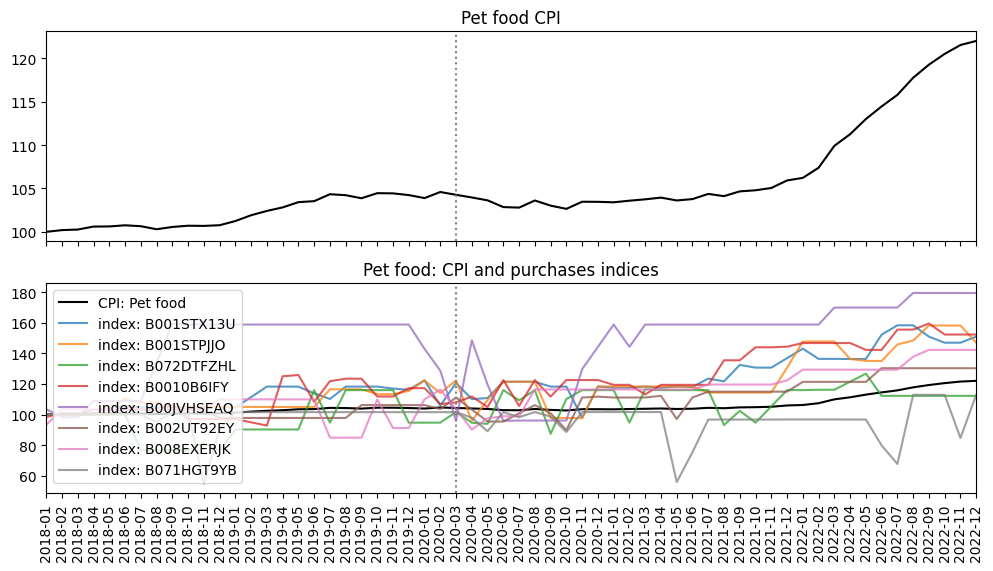

In [43]:
# plots

fig, axes = plt.subplots(2,1, figsize=(12, 3*2), sharex=True)
ax = axes[0]
ax.set_title('Pet food CPI')
ax.plot(petfood_prices_df['CPI'], label='CPI: Pet food', color='black')
# vertical line for covid
ax.axvline('2020-03', color='gray', linestyle=':')

ax = axes[1]
ax.set_title('Pet food: CPI and purchases indices')
ax.plot(petfood_prices_df['CPI'], label='CPI: Pet food', color='black')
for p_code in petfood_products_b:
    ax.plot(petfood_prices_df['%s_idx'%p_code], label='index: %s'%p_code, alpha=0.75)
ax.legend(loc='upper left')
_ = plt.xticks(rotation = 90)
ax.set_xlim(amzn_data_idx[0], amzn_data_idx[-1])
# vertical line for covid
_ = ax.axvline('2020-03', color='gray', linestyle=':')

Compare regression with and without the purchases data -- using prices alone

In [44]:
# First try with no lag, then experiment with lags (shift the data)
print('Regression without number of purchases -- using prices alone\n')
formula = 'CPI ~ '
s = ['%s_idx' % (pcode) for pcode in petfood_products_b]
formula += ' + '.join(s)
print('Formula:\n%s'%formula)
result = sm.ols(formula=formula, data=petfood_prices_df).fit()
display(result.summary())

Regression without number of purchases -- using prices alone

Formula:
CPI ~ B001STX13U_idx + B001STPJJO_idx + B072DTFZHL_idx + B0010B6IFY_idx + B00JVHSEAQ_idx + B002UT92EY_idx + B008EXERJK_idx + B071HGT9YB_idx


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     33.56
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           1.01e-17
Time:                        13:17:47   Log-Likelihood:                -132.65
No. Observations:                  60   AIC:                             283.3
Df Residuals:                      51   BIC:                             302.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         59.1353      4.747     12.457      0.000      49.605      68.666
B001STX13U_idx     0.1272      0.057      2.213      0.031       0.012       0.243
B001STPJJO_idx     0.1005      0.045      2.245      0.029       0.011       0.190
B072DTFZHL_idx    -0.0077      0.029     -0.262      0.794      -0.067       0.051
B0010B6IFY_idx    -0.0029      0.042     -0.070      0.945      -0.087       0.081
B00JVHSEAQ_idx     0.0150      0.015      1.009      0.318      -0.015       0.045
B002UT92EY_idx     0.0925      0.067      1.372      0.176      -0.043       0.228
B008EXERJK_idx     0.0413      0.038      1.097      0.278      -0.034       0.117
B071HGT9YB_idx     0.0329      0.029      1.130      0.264      -0.026       0.091
==============================================================================
Omnibus:                        3.456   Durbin-Watson:                   0.519
Prob(Omnibus):                  0.178   Jarque-Bera (JB):                3.410
Skew:                           0.019   Prob(JB):                        0.182
Kurtosis:                       4.167   Cond. No.                     5.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# First try with no lag, then experiment with lags (shift the data)
print('Regression with number of purchases\n')
formula = 'CPI ~ '
s = ['%s_idx * %s_purchases' % (pcode, pcode) for pcode in petfood_products_b]
formula += ' + '.join(s)
print('Formula:\n%s'%formula)
result = sm.ols(formula=formula, data=petfood_prices_df).fit()
display(result.summary())

Regression with number of purchases

Formula:
CPI ~ B001STX13U_idx * B001STX13U_purchases + B001STPJJO_idx * B001STPJJO_purchases + B072DTFZHL_idx * B072DTFZHL_purchases + B0010B6IFY_idx * B0010B6IFY_purchases + B00JVHSEAQ_idx * B00JVHSEAQ_purchases + B002UT92EY_idx * B002UT92EY_purchases + B008EXERJK_idx * B008EXERJK_purchases + B071HGT9YB_idx * B071HGT9YB_purchases


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     29.49
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           1.00e-16
Time:                        13:17:47   Log-Likelihood:                -96.052
No. Observations:                  60   AIC:                             242.1
Df Residuals:                      35   BIC:                             294.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              35.9533      9.821      3.661      0.001      16.015      55.892
B001STX13U_idx                          0.1077      0.053      2.044      0.049       0.001       0.215
B001STX13U_purchases                    0.4938      1.110      0.445      0.659      -1.760       2.748
B001STX13U_idx:B001STX13U_purchases    -0.0009      0.009     -0.105      0.917      -0.019       0.017
B001STPJJO_idx                          0.1212      0.040      3.064      0.004       0.041       0.202
B001STPJJO_purchases                    5.5619      1.653      3.365      0.002       2.206       8.917
B001STPJJO_idx:B001STPJJO_purchases    -0.0472      0.014     -3.386      0.002      -0.076      -0.019
B072DTFZHL_idx                          0.0785      0.037      2.106      0.042       0.003       0.154
B072DTFZHL_purchases                    3.0024      1.468      2.045      0.048       0.022       5.983
B072DTFZHL_idx:B072DTFZHL_purchases    -0.0294      0.014     -2.134      0.040      -0.057      -0.001
B0010B6IFY_idx                          0.0248      0.043      0.580      0.566      -0.062       0.112
B0010B6IFY_purchases                    1.0901      2.029      0.537      0.594      -3.028       5.209
B0010B6IFY_idx:B0010B6IFY_purchases    -0.0063      0.016     -0.394      0.696      -0.039       0.026
B00JVHSEAQ_idx                          0.0698      0.024      2.913      0.006       0.021       0.119
B00JVHSEAQ_purchases                    2.1604      1.071      2.017      0.051      -0.014       4.335
B00JVHSEAQ_idx:B00JVHSEAQ_purchases    -0.0173      0.008     -2.284      0.029      -0.033      -0.002
B002UT92EY_idx                          0.1564      0.068      2.312      0.027       0.019       0.294
B002UT92EY_purchases                   -0.6528      2.683     -0.243      0.809      -6.100       4.795
B002UT92EY_idx:B002UT92EY_purchases     0.0073      0.023      0.313      0.756      -0.040       0.055
B008EXERJK_idx                          0.0535      0.037      1.441      0.159      -0.022       0.129
B008EXERJK_purchases                    2.9298      2.344      1.250      0.220      -1.828       7.688
B008EXERJK_idx:B008EXERJK_purchases    -0.0255      0.021     -1.197      0.239      -0.069       0.018
B071HGT9YB_idx                         -0.0189      0.056     -0.337      0.738      -0.132       0.095
B071HGT9YB_purchases                   -4.9581      2.979     -1.664      0.105     -11.006       1.090
B071HGT9YB_idx:B071HGT9YB_purchases     0.0406      0.030      1.335      0.190      -0.021       0.102
==============================================================================
Omnibus:                        5.706   Durbin-Watson:                   1.747
Prob(Omnibus)

Experiment with lags

Is the CPI lagged behind what can be predicted from the purchases data?
- set up the CPI lag1 to represent CPI lagged by 1 month; same for lag2 for 2 months

Answer: YES: CPI lagged by 1 month has higher R^2 value!

In [46]:
petfood_prices_df['CPI_lag1'] = petfood_prices_df['CPI'].shift(-1)
petfood_prices_df['CPI_lag2'] = petfood_prices_df['CPI'].shift(-2)
petfood_prices_df.head(3)

B001STX13U_med_price  B001STX13U_purchases  B001STPJJO_med_price   
yyyy-mm                                                                     
2018-01                   NaN                   0.0                 12.59  \
2018-02                12.585                   2.0                 12.58   
2018-03                   NaN                   0.0                 12.59   

         B001STPJJO_purchases  B072DTFZHL_med_price  B072DTFZHL_purchases   
yyyy-mm                                                                     
2018-01                   3.0                   NaN                   0.0  \
2018-02                   4.0                 16.56                   1.0   
2018-03                   3.0                   NaN                   0.0   

         B0010B6IFY_med_price  B0010B6IFY_purchases  B00JVHSEAQ_med_price   
yyyy-mm                                                                     
2018-01                12.255                   2.0                19.495  \
2018-02                12.580                   1.0                18.500   
2018-03                12.580                   1.0                18.500   

         B00JVHSEAQ_purchases  ...  B00JVHSEAQ_idx  B002UT92EY_med_price1   
yyyy-mm                        ...                                          
2018-01                   2.0  ...      103.522436                  32.95  \
2018-02                   1.0  ...       98.238782                  32.95   
2018-03                   2.0  ...       98.238782                  32.95   

         B002UT92EY_idx  B008EXERJK_med_price1  B008EXERJK_idx   
yyyy-mm                                                          
2018-01           100.0                  28.79       93.101218  \
2018-02           100.0                  31.99      103.449391   
2018-03           100.0                  31.99      103.449391   

         B071HGT9YB_med_price1  B071HGT9YB_idx        CPI   CPI_lag1   
yyyy-mm                                                                
2018-01                  30.99           100.0  100.00000  100.20086  \
2018-02                  30.99           100.0  100.20086  100.26626   
2018-03                  30.99           100.0  100.26626  100.60792   

          CPI_lag2  
yyyy-mm             
2018-01  100.26626  
2018-02  100.60792  
2018-03  100.62460  

[3 rows x 35 columns]

In [47]:
# First try with no lag, then experiment with lags (shift the data)
print('Regression with CPI lagged by 1 month\n')
formula = 'CPI_lag1 ~ '
s = ['%s_idx * %s_purchases' % (pcode, pcode) for pcode in petfood_products_b]
formula += ' + '.join(s)
print('Formula:\n%s'%formula)
result = sm.ols(formula=formula, data=petfood_prices_df).fit()
display(result.summary())

Regression with CPI lagged by 1 month

Formula:
CPI_lag1 ~ B001STX13U_idx * B001STX13U_purchases + B001STPJJO_idx * B001STPJJO_purchases + B072DTFZHL_idx * B072DTFZHL_purchases + B0010B6IFY_idx * B0010B6IFY_purchases + B00JVHSEAQ_idx * B00JVHSEAQ_purchases + B002UT92EY_idx * B002UT92EY_purchases + B008EXERJK_idx * B008EXERJK_purchases + B071HGT9YB_idx * B071HGT9YB_purchases


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CPI_lag1   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     55.18
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           9.80e-21
Time:                        13:17:47   Log-Likelihood:                -75.811
No. Observations:                  59   AIC:                             201.6
Df Residuals:                      34   BIC:                             253.6
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              53.3752      7.947      6.716      0.000      37.224      69.526
B001STX13U_idx                          0.0062      0.042      0.148      0.883      -0.078       0.091
B001STX13U_purchases                   -2.9774      0.937     -3.176      0.003      -4.883      -1.072
B001STX13U_idx:B001STX13U_purchases     0.0286      0.008      3.794      0.001       0.013       0.044
B001STPJJO_idx                          0.1507      0.029      5.123      0.000       0.091       0.210
B001STPJJO_purchases                    5.0213      1.212      4.141      0.000       2.557       7.485
B001STPJJO_idx:B001STPJJO_purchases    -0.0437      0.010     -4.269      0.000      -0.065      -0.023
B072DTFZHL_idx                          0.0692      0.027      2.533      0.016       0.014       0.125
B072DTFZHL_purchases                    1.6314      1.081      1.509      0.140      -0.565       3.828
B072DTFZHL_idx:B072DTFZHL_purchases    -0.0134      0.010     -1.312      0.198      -0.034       0.007
B0010B6IFY_idx                          0.0392      0.031      1.249      0.220      -0.025       0.103
B0010B6IFY_purchases                    1.3206      1.493      0.884      0.383      -1.714       4.355
B0010B6IFY_idx:B0010B6IFY_purchases    -0.0091      0.012     -0.778      0.442      -0.033       0.015
B00JVHSEAQ_idx                          0.0632      0.018      3.548      0.001       0.027       0.099
B00JVHSEAQ_purchases                    2.0823      0.788      2.643      0.012       0.481       3.683
B00JVHSEAQ_idx:B00JVHSEAQ_purchases    -0.0205      0.006     -3.678      0.001      -0.032      -0.009
B002UT92EY_idx                          0.0521      0.051      1.017      0.316      -0.052       0.156
B002UT92EY_purchases                   -2.1079      1.969     -1.071      0.292      -6.109       1.894
B002UT92EY_idx:B002UT92EY_purchases     0.0201      0.017      1.174      0.248      -0.015       0.055
B008EXERJK_idx                          0.0982      0.027      3.577      0.001       0.042       0.154
B008EXERJK_purchases                    6.8274      1.790      3.815      0.001       3.190      10.464
B008EXERJK_idx:B008EXERJK_purchases    -0.0603      0.016     -3.721      0.001      -0.093      -0.027
B071HGT9YB_idx                         -0.0456      0.042     -1.081      0.287      -0.131       0.040
B071HGT9YB_purchases                   -5.2044      2.210     -2.355      0.024      -9.695      -0.714
B071HGT9YB_idx:B071HGT9YB_purchases     0.0499      0.023      2.198      0.035       0.004       0.096
==============================================================================
Omnibus:                        2.888   Durbin-Watson:                   1.936
Prob(Omnibus)

In [48]:
print('Regression with CPI lagged by 2 months\n')
formula = 'CPI_lag2 ~ '
s = ['%s_idx * %s_purchases' % (pcode, pcode) for pcode in petfood_products_b]
formula += ' + '.join(s)
print('Formula:\n%s'%formula)
result = sm.ols(formula=formula, data=petfood_prices_df).fit()
display(result.summary())

Regression with CPI lagged by 2 months

Formula:
CPI_lag2 ~ B001STX13U_idx * B001STX13U_purchases + B001STPJJO_idx * B001STPJJO_purchases + B072DTFZHL_idx * B072DTFZHL_purchases + B0010B6IFY_idx * B0010B6IFY_purchases + B00JVHSEAQ_idx * B00JVHSEAQ_purchases + B002UT92EY_idx * B002UT92EY_purchases + B008EXERJK_idx * B008EXERJK_purchases + B071HGT9YB_idx * B071HGT9YB_purchases


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CPI_lag2   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     37.86
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           1.12e-17
Time:                        13:17:47   Log-Likelihood:                -84.335
No. Observations:                  58   AIC:                             218.7
Df Residuals:                      33   BIC:                             270.2
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              60.1698      9.556      6.297      0.000      40.728      79.611
B001STX13U_idx                          0.0154      0.051      0.303      0.764      -0.088       0.119
B001STX13U_purchases                   -4.0490      1.228     -3.298      0.002      -6.547      -1.551
B001STX13U_idx:B001STX13U_purchases     0.0376      0.010      3.753      0.001       0.017       0.058
B001STPJJO_idx                          0.1263      0.038      3.318      0.002       0.049       0.204
B001STPJJO_purchases                    3.7842      1.554      2.435      0.020       0.623       6.946
B001STPJJO_idx:B001STPJJO_purchases    -0.0332      0.013     -2.522      0.017      -0.060      -0.006
B072DTFZHL_idx                          0.0434      0.033      1.321      0.196      -0.023       0.110
B072DTFZHL_purchases                    0.8402      1.302      0.645      0.523      -1.809       3.489
B072DTFZHL_idx:B072DTFZHL_purchases    -0.0051      0.012     -0.416      0.680      -0.030       0.020
B0010B6IFY_idx                          0.0459      0.038      1.220      0.231      -0.031       0.122
B0010B6IFY_purchases                    1.4191      1.794      0.791      0.435      -2.230       5.069
B0010B6IFY_idx:B0010B6IFY_purchases    -0.0111      0.014     -0.787      0.437      -0.040       0.018
B00JVHSEAQ_idx                          0.0428      0.023      1.896      0.067      -0.003       0.089
B00JVHSEAQ_purchases                    0.9488      1.014      0.935      0.356      -1.115       3.012
B00JVHSEAQ_idx:B00JVHSEAQ_purchases    -0.0111      0.007     -1.526      0.137      -0.026       0.004
B002UT92EY_idx                          0.0471      0.062      0.755      0.456      -0.080       0.174
B002UT92EY_purchases                   -0.4463      2.757     -0.162      0.872      -6.056       5.164
B002UT92EY_idx:B002UT92EY_purchases     0.0043      0.024      0.175      0.862      -0.045       0.054
B008EXERJK_idx                          0.0787      0.034      2.344      0.025       0.010       0.147
B008EXERJK_purchases                    4.5103      2.160      2.088      0.045       0.116       8.904
B008EXERJK_idx:B008EXERJK_purchases    -0.0401      0.020     -2.050      0.048      -0.080      -0.000
B071HGT9YB_idx                         -0.0200      0.055     -0.366      0.717      -0.131       0.091
B071HGT9YB_purchases                   -2.5452      3.051     -0.834      0.410      -8.753       3.663
B071HGT9YB_idx:B071HGT9YB_purchases     0.0231      0.031      0.745      0.462      -0.040       0.086
==============================================================================
Omnibus:                        1.232   Durbin-Watson:                   1.725
Prob(Omnibus)

### TODO

- better presentation of results

- prediction?

## Footwear and apparel

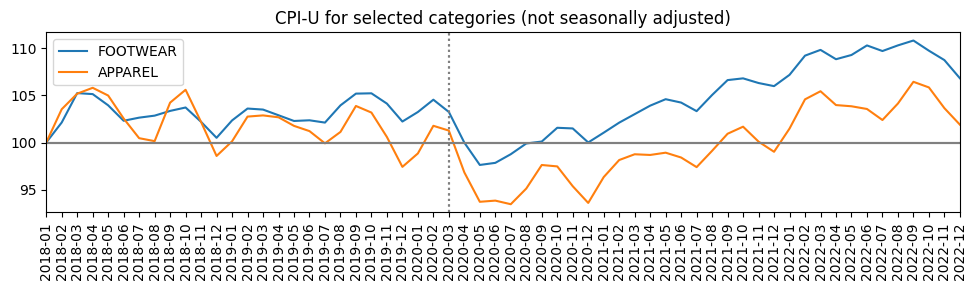

In [49]:
fig, ax = plt.subplots(1,1, figsize=(10, 3))
for i, cat in enumerate(['FOOTWEAR','APPAREL']):
    plot_monthly_data(cpi_data[cat], ax=ax, label=cat, show_idx100=True, show_covid=True)

ax.set_title('CPI-U for selected categories (not seasonally adjusted)')
# fig.suptitle('CPI-U for selected categories (not seasonally adjusted)')
plt.tight_layout()

### Footwear


Insight that makes tracking footwear products different than petfood:
- products are sold under multiple product codes (e.g. by different store owners)
- yet can still be the same product
- need to collect product codes by titles and then do quality assurance to make sure they are the same product



In [50]:
footwear_categories = ['SHOES', 'TECHNICAL_SPORT_SHOE', 'BOOT', 'SANDAL', 'SLIPPER']

print('footwear:')
_footwear_purchases = get_purchases(footwear_categories)
# inspect subcategories
# print('shoes:')
# _shoes_purchases = get_purchases(['SHOES'])
# print('sports shoe:')
# _sport_shoe_purchases = get_purchases(['TECHNICAL_SPORT_SHOE'])
# print('Boot:')
# _boot_purchases = get_purchases(['BOOT'])
# print('Sandal:')
# _sandal_purchases = get_purchases(['SANDAL'])
# print('Slipper:')
# _slipper_purchases = get_purchases(['SLIPPER'])
_footwear_subcategory_purchases = dict()
for c in footwear_categories:
    print(c)
    _footwear_subcategory_purchases[c] = get_purchases([c])
    
_footwear_purchases.head()

footwear:
21879 purchases from N=3408 unique customers
SHOES
12441 purchases from N=2758 unique customers
TECHNICAL_SPORT_SHOE
123 purchases from N=101 unique customers
BOOT
3081 purchases from N=1392 unique customers
SANDAL
3577 purchases from N=1416 unique customers
SLIPPER
2657 purchases from N=1328 unique customers


yyyy-mm                                              Title   
34  2019-10  GAXmi Flip Flops Women Men Kids Summer Casual ...  \
40  2019-10               Amazon Essentials Men's Chelsea Boot   
41  2019-10               Amazon Essentials Men's Chelsea Boot   
60  2020-12               Clarks Men's Paulson Up Chelsea Boot   
90  2022-01  Thursday Boot Company Men's Duke Chelsea Leath...   

   ASIN/ISBN (Product Code) Category  Survey ResponseID  unit price  Quantity  
34               B07CYHXHFR   SANDAL  R_3I9Pu8iauEcOx9A       14.99       1.0  
40               B07QKNGSNB     BOOT  R_3I9Pu8iauEcOx9A       39.00       1.0  
41               B07QH14QTN     BOOT  R_3I9Pu8iauEcOx9A       39.00       1.0  
60               B07NP3QKCZ     BOOT  R_3I9Pu8iauEcOx9A       89.91       1.0  
90               B07NVRSMW6     BOOT  R_3I9Pu8iauEcOx9A      199.00       1.0

Initial questions about footwear purchases data

- How many total purchases each month?
- How many different people purchasing footwear each month?
- Median purchase price each month?
- What is the distribution of purchases per product?
- How many unique products purchased every month?

Footwear: Total monthly purchases


count     60.000000
mean     364.650000
std      111.604906
min      156.000000
25%      276.500000
50%      352.000000
75%      464.500000
max      611.000000
Name: Survey ResponseID, dtype: float64

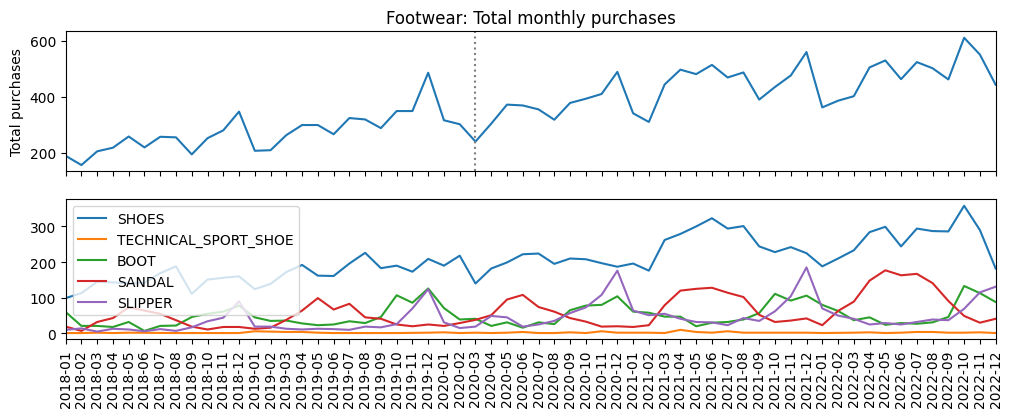

In [51]:
footwear_monthly_purchases = _footwear_purchases.groupby(
    'yyyy-mm'
)['Survey ResponseID'].count()

title = 'Footwear: Total monthly purchases'
print(title)
display(footwear_monthly_purchases.describe())
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(12,2*2), sharex=True)
_ = plot_monthly_data(
    footwear_monthly_purchases, ax=ax0, ylabel='Total purchases', show_covid=True, title=title,
)
footwear_subcat_monthly_purchases = dict()
for c in footwear_categories:
    c_purchases = _footwear_subcategory_purchases[c]
    footwear_subcat_monthly_purchases[c] = c_purchases.groupby(
        'yyyy-mm'
    )['Survey ResponseID'].count()
    plot_monthly_data(footwear_subcat_monthly_purchases[c], ax=ax1, label=c)

Footwear: Number of different people purchasing each month


count     60.000000
mean     254.816667
std       73.850397
min      122.000000
25%      200.750000
50%      255.000000
75%      313.250000
max      399.000000
Name: Survey ResponseID, dtype: float64

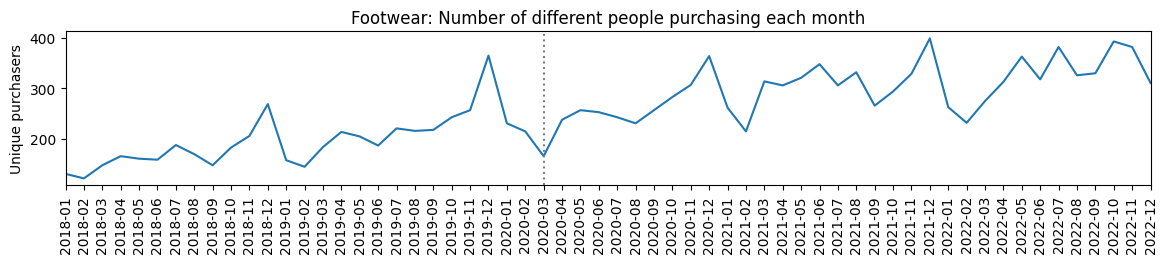

In [52]:
footwear_monthly_purchasers = _footwear_purchases.groupby(
    'yyyy-mm'
)['Survey ResponseID'].nunique()
title = 'Footwear: Number of different people purchasing each month'
print(title)
display(footwear_monthly_purchasers.describe())
ax = plot_monthly_data(
    footwear_monthly_purchasers, ylabel='Unique purchasers', show_covid=True, title=title
)

Footwear: overall unit prices distribution


count    21879.000000
mean        41.878140
std         31.500822
min          0.320000
25%         20.990000
50%         33.000000
75%         50.140000
max        419.000000
Name: unit price, dtype: float64

Footwear: Monthly median unit price ($)


count    60.000000
mean     33.340333
std       3.101732
min      27.990000
25%      30.741250
50%      33.430000
75%      34.990000
max      44.415000
Name: unit price, dtype: float64

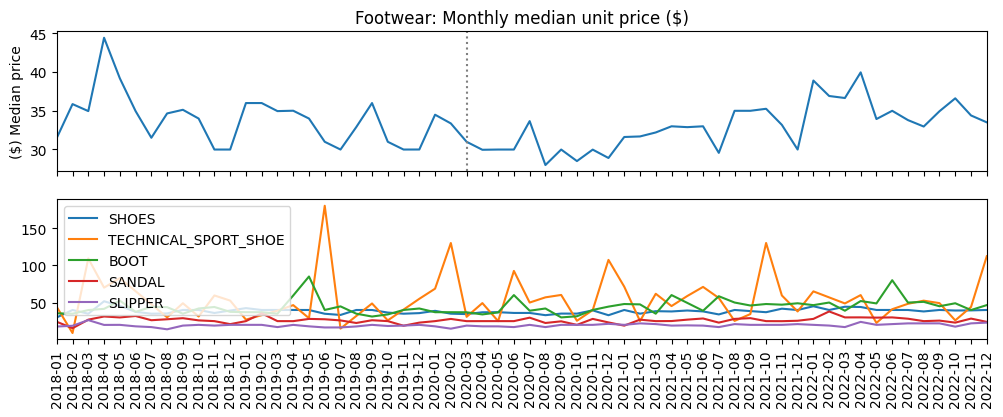

In [53]:
print('Footwear: overall unit prices distribution')
display(_footwear_purchases['unit price'].describe())
footwear_monthly_prices_med = _footwear_purchases.groupby(
    'yyyy-mm'
)['unit price'].agg('median')
title = 'Footwear: Monthly median unit price ($)'
print(title)
display(footwear_monthly_prices_med.describe())
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(12,2*2), sharex=True)
_ = plot_monthly_data(
    footwear_monthly_prices_med, ax=ax0, ylabel='($) Median price', show_covid=True, title=title
)
footwear_subcat_monthly_price = dict()
for c in footwear_categories:
    c_purchases = _footwear_subcategory_purchases[c]
    footwear_subcat_monthly_price[c] = c_purchases.groupby(
        'yyyy-mm'
    )['unit price'].agg('median')
    plot_monthly_data(footwear_subcat_monthly_price[c], ax=ax1, label=c)

In [54]:
# What are the technical sports shoes thave have such wild prices?
display(_footwear_subcategory_purchases['TECHNICAL_SPORT_SHOE'].sort_values('unit price').head())
display(_footwear_subcategory_purchases['TECHNICAL_SPORT_SHOE'].sort_values('unit price', ascending=False).head())

yyyy-mm                                              Title   
721   2021-08                      Ryka Women's Sky Walking Shoe  \
899   2021-04  Conpush Girl Toddler Kid Leather Ballet Practi...   
31    2018-02  CIOR Girls Ballet Slippers Canvas Ballet Shoes...   
1130  2021-07  JIASUQI Kids Boys and Girls Summer Athletic Wa...   
341   2019-04  Bigib Toddler Kids Swim Water Shoes Quick Dry ...   

     ASIN/ISBN (Product Code)              Category  Survey ResponseID   
721                B01KWBVRHG  TECHNICAL_SPORT_SHOE  R_4JBCc8ejkMh89Bn  \
899                B083BD349L  TECHNICAL_SPORT_SHOE  R_sYZmFJSmzmxm3JL   
31                 B01NBJEIOE  TECHNICAL_SPORT_SHOE  R_2b2HfsI0sUHFVyL   
1130               B07N2LFX3H  TECHNICAL_SPORT_SHOE  R_43dTW1DrJmC9aGl   
341                B07FKLKKQR  TECHNICAL_SPORT_SHOE  R_1pA325VZl0b6qNx   

      unit price  Quantity  
721         0.58       1.0  
899         5.99       1.0  
31          8.99       1.0  
1130       10.39       1.0  
341        11.99       1.0

yyyy-mm                                              Title   
90    2019-06          adidas Women's Ultraboost 19 Running Shoe  \
934   2021-10  Inov-8 Fastlift™ 360 Blue/Red/White UK 5.5 (US...   
1458  2020-06  New Balance Women's Fresh Foam 1080 V10 Runnin...   
226   2020-02  New Balance Women's FuelCell Rebel V1 Running ...   
807   2022-04      Brooks Women's Adrenaline GTS 21 Running Shoe   

     ASIN/ISBN (Product Code)              Category  Survey ResponseID   
90                 B07D9PPD22  TECHNICAL_SPORT_SHOE  R_2QfACJcif9NnW0C  \
934                B0857H6JCD  TECHNICAL_SPORT_SHOE  R_2q7CELN85B8I2qU   
1458               B07RHXPNXY  TECHNICAL_SPORT_SHOE  R_3R4b0PxgHJiXxVD   
226                B07HG23W3R  TECHNICAL_SPORT_SHOE  R_21ntohm9l0O4R0Y   
807                B08BW3PVVP  TECHNICAL_SPORT_SHOE  R_2cBADxleVyzT89z   

      unit price  Quantity  
90        180.00       1.0  
934       170.00       1.0  
1458      149.95       1.0  
226       129.95       1.0  
807       129.95       1.0

In [55]:
print('Q: Are the technical sports shoes always categorized as that?')
tech_sports_shoes_pcodes = amzn_data[amzn_data['Category']=='TECHNICAL_SPORT_SHOE']['ASIN/ISBN (Product Code)'].unique()
print('%s technical sports shoes product codes' % len(tech_sports_shoes_pcodes))
display(amzn_data[
    amzn_data['ASIN/ISBN (Product Code)'].isin(tech_sports_shoes_pcodes)
].groupby('ASIN/ISBN (Product Code)')['Category'].nunique().describe())
print('Answer: For the most part, Yes')

Q: Are the technical sports shoes always categorized as that?
120 technical sports shoes product codes


count    120.000000
mean       1.008333
std        0.091287
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: Category, dtype: float64

Answer: For the most part, Yes


In [56]:
print('But! sometimes products with the same title and different codes are listed under different categories')
tech_sports_shoes_titles = amzn_data[amzn_data['Category']=='TECHNICAL_SPORT_SHOE']['Title'].unique()
print('%s technical sports shoes titles' % len(tech_sports_shoes_titles))
display(amzn_data[
    amzn_data['Title'].isin(tech_sports_shoes_titles)
].groupby('Title')['Category'].nunique().describe())
print('Answer: For the most part, Yes')

But! sometimes products with the same title and different codes are listed under different categories
90 technical sports shoes titles


count    90.000000
mean      1.477778
std       0.502304
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       2.000000
Name: Category, dtype: float64

Answer: For the most part, Yes


We might want to exclude the technical sports shoe

CPI  total_med_unit_price  total_purchasers  total_purchases   
yyyy-mm                                                                       
2018-01  100.00000                31.490               131              189  \
2018-02  102.12468                35.855               122              156   
2018-03  105.24331                34.950               148              205   
2018-04  105.13900                44.415               166              218   
2018-05  103.94779                39.185               161              258   

         SHOES_med_unit_price  SHOES_purchases   
yyyy-mm                                          
2018-01                29.990               99  \
2018-02                39.980              113   
2018-03                34.950              145   
2018-04                51.700              143   
2018-05                45.495              140   

         TECHNICAL_SPORT_SHOE_med_unit_price  TECHNICAL_SPORT_SHOE_purchases   
yyyy-mm                                                                        
2018-01                               44.000                             1.0  \
2018-02                                8.990                             1.0   
2018-03                              109.215                             2.0   
2018-04                               70.000                             1.0   
2018-05                               82.780                             2.0   

         BOOT_med_unit_price  BOOT_purchases  SANDAL_med_unit_price   
yyyy-mm                                                               
2018-01               35.495              60                  24.10  \
2018-02               34.950              21                  15.50   
2018-03               39.880              21                  26.99   
2018-04               41.490              18                  31.23   
2018-05               52.495              32                  29.95   

         SANDAL_purchases  SLIPPER_med_unit_price  SLIPPER_purchases  
yyyy-mm                                                               
2018-01                19                   17.74                 10  
2018-02                 7                   18.74                 14  
2018-03                32                   26.35                  5  
2018-04                43                   19.89                 13  
2018-05                73                   19.99                 11

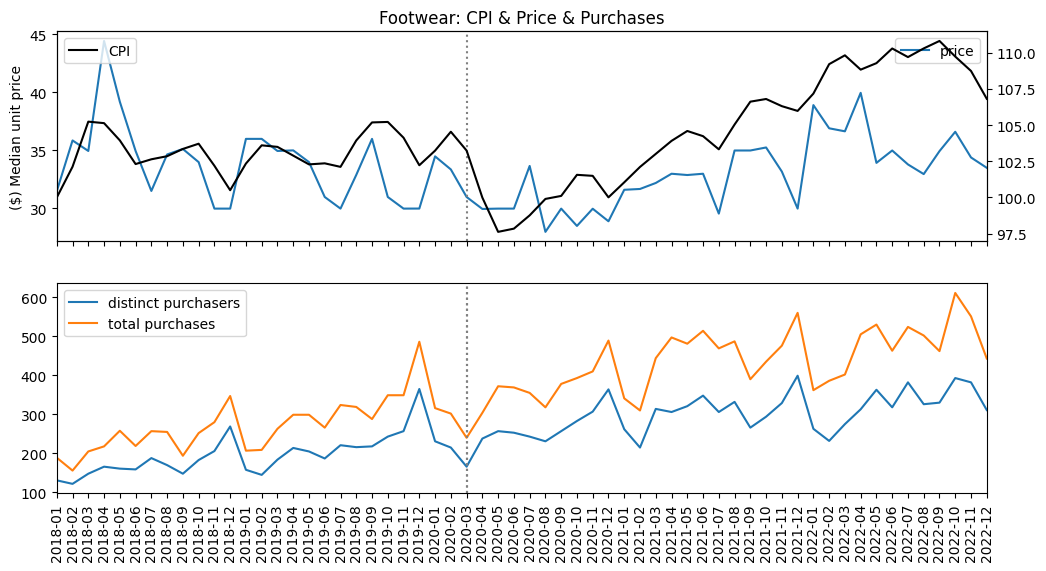

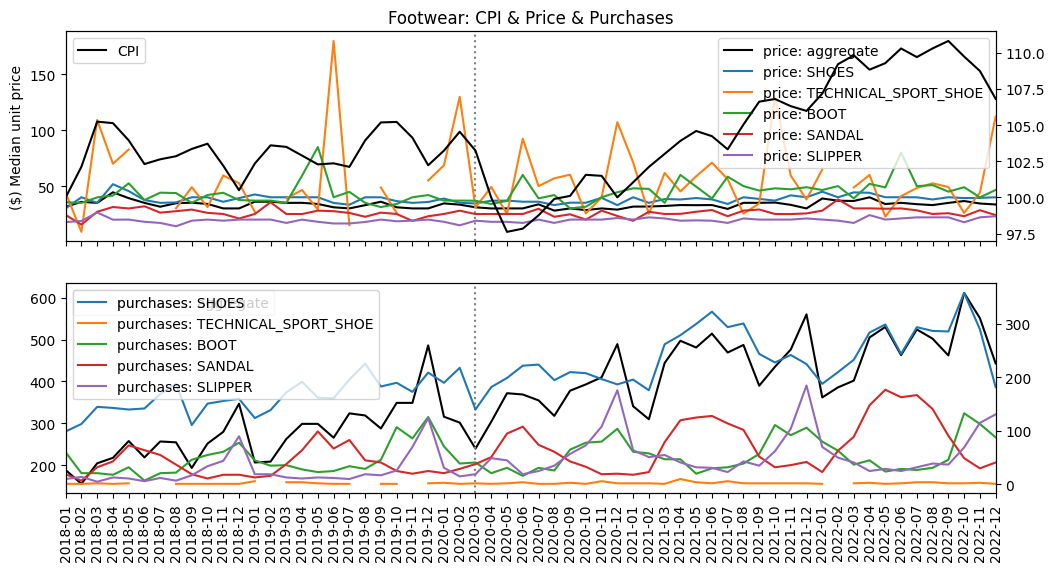

In [57]:
# Plot price on top of CPI

footwear_cpi_med_prices_df = pd.DataFrame({
    'yyyy-mm': amzn_data_idx,
    'CPI': cpi_data['FOOTWEAR'],
}).set_index('yyyy-mm')
footwear_cpi_med_prices_df['total_med_unit_price'] = footwear_monthly_prices_med
footwear_cpi_med_prices_df['total_purchasers'] = footwear_monthly_purchasers
footwear_cpi_med_prices_df['total_purchases'] = footwear_monthly_purchases
for c in footwear_categories:
    footwear_cpi_med_prices_df['%s_med_unit_price' % c] = footwear_subcat_monthly_price[c]
    footwear_cpi_med_prices_df['%s_purchases' % c] = footwear_subcat_monthly_purchases[c]

title = 'Footwear: CPI & Price & Purchases'
fig, axes = plt.subplots(2,1, figsize=(12, 2*3), sharex=True)  
ax = axes[0]
plot_monthly_data(
    footwear_cpi_med_prices_df['total_med_unit_price'], ax=ax, label='price', 
    ylabel='($) Median unit price', show_covid=True, title=title
)
ax2 = ax.twinx()
plot_monthly_data(
    footwear_cpi_med_prices_df['CPI'], ax=ax2, label='CPI', color='black'
)
ax = axes[1]
plot_monthly_data(
    footwear_cpi_med_prices_df['total_purchasers'], ax=ax, label='distinct purchasers', show_covid=True,
)
plot_monthly_data(
    footwear_cpi_med_prices_df['total_purchases'], ax=ax, label='total purchases', show_covid=True,
)

fig, axes = plt.subplots(2,1, figsize=(12, 2*3), sharex=True)  
ax = axes[0]
plot_monthly_data(
    footwear_cpi_med_prices_df['total_med_unit_price'], ax=ax, label='price: aggregate', 
    ylabel='($) Median unit price', show_covid=True, title=title, color='black'
)
for c in footwear_categories:
    plot_monthly_data(
        footwear_cpi_med_prices_df['%s_med_unit_price' % c], ax=ax, label='price: %s'%c,
    )
ax2 = ax.twinx()
plot_monthly_data(
    footwear_cpi_med_prices_df['CPI'], ax=ax2, label='CPI', color='black'
)
ax = axes[1]
plot_monthly_data(
    footwear_cpi_med_prices_df['total_purchases'], color='black', ax=ax, label='purchases: aggregate', show_covid=True,
)
ax2 = ax.twinx()
for c in footwear_categories:
    plot_monthly_data(
        footwear_cpi_med_prices_df['%s_purchases' % c], ax=ax2, label='purchases: %s'%c,
    )

footwear_cpi_med_prices_df.head()

Observations

- When tracking all products purchased, median unit price tracks CPI
- Apparent inverse relationship between price spices and purchasing spikes
    - when price goes down, purchases go up
    - note where this relationship breaks down is end of the timeline -- we likely have fewer purchasers/purchases then because we started data collection in November
- distinct purchsers and total purchases closely correlated



### Regression using aggregate data

What if we used just this overall purchases data in a regression?

Should clip dates to October or November 2022 since we collected half the data in November?

Experiments:
- test w lag -- worsens regression
- purchases vs purchasers --> purchases better
- end at 2022-10 vs 2022-12 --> -12 better

- separate by subcategories

In [58]:
# Set up with lag
footwear_cpi_med_prices_df['CPI_lag1'] = footwear_cpi_med_prices_df['CPI'].shift(-1)
footwear_cpi_med_prices_df['CPI_lag2'] = footwear_cpi_med_prices_df['CPI'].shift(-2)
# For regression, cut off data at 2022-10
regression_df = footwear_cpi_med_prices_df.loc[:'2022-10']
regression_df.head(2)

CPI  total_med_unit_price  total_purchasers  total_purchases   
yyyy-mm                                                                       
2018-01  100.00000                31.490               131              189  \
2018-02  102.12468                35.855               122              156   

         SHOES_med_unit_price  SHOES_purchases   
yyyy-mm                                          
2018-01                 29.99               99  \
2018-02                 39.98              113   

         TECHNICAL_SPORT_SHOE_med_unit_price  TECHNICAL_SPORT_SHOE_purchases   
yyyy-mm                                                                        
2018-01                                44.00                             1.0  \
2018-02                                 8.99                             1.0   

         BOOT_med_unit_price  BOOT_purchases  SANDAL_med_unit_price   
yyyy-mm                                                               
2018-01               35.495              60                   24.1  \
2018-02               34.950              21                   15.5   

         SANDAL_purchases  SLIPPER_med_unit_price  SLIPPER_purchases   
yyyy-mm                                                                
2018-01                19                   17.74                 10  \
2018-02                 7                   18.74                 14   

          CPI_lag1   CPI_lag2  
yyyy-mm                        
2018-01  102.12468  105.24331  
2018-02  105.24331  105.13900

In [59]:
# formula = 'CPI ~ total_med_unit_price' # Adj. R-squared: 0.270
formula = 'CPI ~ total_med_unit_price + total_purchases' # Adj. R-squared: 0.583
# formula = 'CPI ~ total_med_unit_price + total_purchasers' # Adj. R-squared: 0.568
print('Formula:\n%s'%formula)
result = sm.ols(formula=formula, data=footwear_cpi_med_prices_df).fit()
# result = sm.ols(formula=formula, data=regression_df).fit()

display(result.summary())

Formula:
CPI ~ total_med_unit_price + total_purchases


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     42.25
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           5.57e-12
Time:                        13:17:49   Log-Likelihood:                -128.45
No. Observations:                  60   AIC:                             262.9
Df Residuals:                      57   BIC:                             269.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               76.7562      3.239     23.700      0.000      70.271      83.242
total_med_unit_price     0.6389      0.089      7.146      0.000       0.460       0.818
total_purchases          0.0166      0.002      6.669      0.000       0.012       0.022
==============================================================================
Omnibus:                        0.708   Durbin-Watson:                   1.134
Prob(Omnibus):                  0.702   Jarque-Bera (JB):                0.558
Skew:                          -0.233   Prob(JB):                        0.756
Kurtosis:                       2.923   Cond. No.                     4.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
formula = 'CPI ~ total_med_unit_price + total_purchases + '
formula += ' + '.join(['%s_med_unit_price * %s_purchases' % (c, c) for c in footwear_categories])
print('Formula:\n%s'%formula)
result = sm.ols(formula=formula, data=footwear_cpi_med_prices_df).fit()
# result = sm.ols(formula=formula, data=regression_df).fit()
display(result.summary())

Formula:
CPI ~ total_med_unit_price + total_purchases + SHOES_med_unit_price * SHOES_purchases + TECHNICAL_SPORT_SHOE_med_unit_price * TECHNICAL_SPORT_SHOE_purchases + BOOT_med_unit_price * BOOT_purchases + SANDAL_med_unit_price * SANDAL_purchases + SLIPPER_med_unit_price * SLIPPER_purchases


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     5.659
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           6.80e-06
Time:                        13:17:49   Log-Likelihood:                -108.18
No. Observations:                  54   AIC:                             250.4
Df Residuals:                      37   BIC:                             284.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             98.2526     15.146      6.487      0.000      67.564     128.941
total_med_unit_price                                                   0.1950      0.325      0.600      0.552      -0.463       0.853
total_purchases                                                        0.0250      0.116      0.216      0.830      -0.210       0.260
SHOES_med_unit_price                                                  -0.2371      0.370     -0.641      0.525      -0.986       0.512
SHOES_purchases                                                       -0.1050      0.131     -0.802      0.428      -0.370       0.160
SHOES_med_unit_price:SHOES_purchases                                   0.0026      0.002      1.338      0.189      -0.001       0.007
TECHNICAL_SPORT_SHOE_med_unit_price                                    0.0215      0.022      0.965      0.341      -0.024       0.067
TECHNICAL_SPORT_SHOE_purchases                                         0.3832      0.484      0.791      0.434      -0.598       1.364
TECHNICAL_SPORT_SHOE_med_unit_price:TECHNICAL_SPORT_SHOE_purchases    -0.0139      0.013     -1.099      0.279      -0.040       0.012
BOOT_med_unit_price                                                   -0.0307      0.083     -0.369      0.714      -0.199       0.138
BOOT_purchases                                                        -0.0322      0.108     -0.299      0.767      -0.250       0.186
BOOT_med_unit_price:BOOT_purchases                                     0.0014      0.002      0.673      0.505      -0.003       0.006
SANDAL_med_unit_price                                                  0.0480      0.164      0.293      0.771      -0.284       0.380
SANDAL_purchases                                                       0.0246      0.135      0.182      0.856      -0.249       0.298
SANDAL_med_unit_price:SANDAL_purchases                                -0.0012      0.003     -0.366      0.717      -0.008       0.005
SLIPPER_med_unit_price                                                 0.0840      0.210      0.400      0.691      -0.341       0.509
SLIPPER_purchases                                                     -0.2456      0.138     -1.781      0.083      -0.525       0.034
SLIPPER_med_unit_price:SLIPPER_purchases                               0.0092      0.007      1.382      0.175      -0.004       0.023
==============================================================================
Omnibus:                        1.428   Durbin-Watson:                   1.673
Prob(Omnibus):                  0.490   Jarque-Bera (JB):                0.725
Skew:      

What is the distribution of purchases per product? Answer:
20008 unique product codes


count    20008.000000
mean         1.093213
std          0.486390
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         31.000000
Name: Survey ResponseID, dtype: float64

How many unique products purchased every month?
Footwear: Number of different products purchased each month


count     60.000000
mean     361.100000
std      110.098985
min      153.000000
25%      271.750000
50%      348.000000
75%      460.000000
max      604.000000
Name: ASIN/ISBN (Product Code), dtype: float64

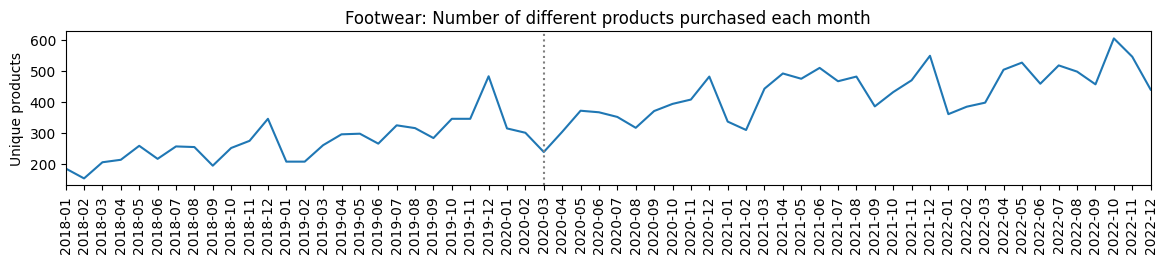

In [62]:
print('What is the distribution of purchases per product? Answer:')
print('%s unique product codes' % _footwear_purchases['ASIN/ISBN (Product Code)'].nunique())
display(_footwear_purchases.groupby('ASIN/ISBN (Product Code)')['Survey ResponseID'].count().describe())

print('How many unique products purchased every month?')
footwear_monthly_products = _footwear_purchases.groupby(
    'yyyy-mm'
)['ASIN/ISBN (Product Code)'].nunique()
title = 'Footwear: Number of different products purchased each month'
print(title)
display(footwear_monthly_products.describe())
ax = plot_monthly_data(
    footwear_monthly_products, ylabel='Unique products', show_covid=True, title=title
)

More than 75% of items purchased only once.

How many product codes have at least min M=48 months of purchases?
Answer: 0

The only product with > 12 months of data is: B002L9AL84 'Shoe Goo Repair Adhesive for Fixing Worn Shoes'

In [63]:
footwear_min_M = 5

_footwear_months = _footwear_purchases.groupby(
    ['ASIN/ISBN (Product Code)']
)['yyyy-mm'].nunique()
display(_footwear_months.describe())
print('Restricting to %s footwear products that have at least %s months of data' %
     (len(_footwear_months[_footwear_months >= footwear_min_M]), footwear_min_M))
_footwear_purchases[_footwear_purchases['ASIN/ISBN (Product Code)'].isin(
    _footwear_months[_footwear_months >= footwear_min_M].index
)].groupby(
    ['Title','ASIN/ISBN (Product Code)','Category']
)['unit price'].agg(['median','count']).head(60)

count    20008.000000
mean         1.082867
std          0.429495
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         22.000000
Name: yyyy-mm, dtype: float64

Restricting to 48 footwear products that have at least 5 months of data


median   
Title                                              ASIN/ISBN (Product Code) Category            
Amazon Essentials Women's Belice Ballet Flat       B07FRB1NJF               SHOES      19.700  \
Asgard Women's Ankle Rain Boots Waterproof Chel... B076VP4XT3               BOOT       28.990   
                                                   B076VVNLJ4               BOOT       28.490   
CAMEL CROWN Hiking Shoes for Men Tennis Trail R... B07JFZBJ77               SHOES      46.990   
Crocs Unisex-Adult Classic Clogs                   B0014BYHGC               SHOES      40.280   
                                                   B0014C2NBC               SHOES      49.950   
                                                   B0014C5S7S               SHOES      34.890   
                                                   B0014C5ULM               SHOES      32.350   
                                                   B001526RFY               SHOES      49.990   
Crocs Unisex-Adult Classic Clogs (Best Sellers)    B0014BYHGC               SHOES      44.950   
                                                   B0014C0LUC               SHOES      36.990   
                                                   B0014C2NBC               SHOES      32.890   
                                                   B0014C3X2K               SHOES      32.660   
                                                   B0014C5S7S               SHOES      34.970   
                                                   B0014C5ULM               SHOES      25.660   
                                                   B001526RFO               SANDAL     35.910   
                                                                            SHOES      37.470   
                                                   B001526RFY               SANDAL     36.020   
                                                                            SHOES      29.970   
Crocs Unisex-Adult Classic Marbled Tie-Dye Clog    B0014C5S7S               SHOES      42.490   
                                                   B001526RFY               SHOES      39.780   
Crocs Women's Kadee Ii Flip Flops                  B010123EV8               SANDAL     16.990   
                                                   B010123EWM               SANDAL     13.990   
Crocs Women's Kadie II Flip Flops                  B010123EV8               SANDAL     21.240   
Crocs womens Kadee Ii Flip Flop, Black, 9 US       B010123EWM               SANDAL     14.975   
DC Men's Court Graffik Casual Skate Shoes          B006IYTFU8               SHOES      56.340   
DC Men's Court Graffik Se Skate Shoe               B006IYTFU8               SHOES      47.950   
Dearfoams Women's Rebecca Lightweight Cozy Memo... B01MR6JZ1W               SLIPPER    19.080   
Deer Stags Men's Greenpoint                        B005IQTDJK               SHOES      30.595   
Dr. Scholl's - Men's Brisk Light Weight Dual St... B01BXG5612               SHOES      43.950   
Jessica Simpson Women's Comfy Faux Fur House Sl... B079P5F4DN               SLIPPER    23.770   
                                                   B079PBNQQ8               SLIPPER    23.190   
New Balance Men's Slip Resistant 626 V2 Industr... B012PWC4AE               SHOES      84.950   
Plush Slipper Socks Women - Colorful Warm Fuzzy... B077JXMJPD               SLIPPER    13.990   
ResMed Quattro Air Headgear - Replacement Headg... B01E7MB5YG               SHOES      17.830   
RockDove Men's Original Two-Tone Memory Foam Sl... B01MR32LQT               SLIPPER    21.990   
                                                   B01MR34D28               SLIPPER    21.990   
                                                   B01MS4EXOS               SLIPPER    21.990   
                                                   B01MU7N91J               SLIPPER    20.990   
                                                   B072J8DM4X               SLIPPER    19.990   
             

This might not work for footwear!

Approach:

Collect top purchased items by title
- search by title keywords
- verify these are the same products

In [64]:
# Find: Crocs Unisex-Adult Classic Clog

def is_maybe_crocs_unisex_adult_classic_clog(title):
    title = str(title).lower()
    if not ('crocs unisex' in title): return False
    if not ('adult' in title): return False
    if not ('classic' in title): return False
    if not ('clog' in title): return False
    return True

crocs_unisex_adult_classic_clog = _footwear_purchases[
    _footwear_purchases['Title'].apply(is_maybe_crocs_unisex_adult_classic_clog)
]
print('%s Crocs Unisex-Adult Classic Clog purchases from N=%s unique purchasers' % (
    len(crocs_unisex_adult_classic_clog), 
    crocs_unisex_adult_classic_clog['Survey ResponseID'].nunique()))
# Verify the titles 
print('Unique product titles:', '\n'.join(crocs_unisex_adult_classic_clog['Title'].unique()))
crocs_unisex_adult_classic_clog.sort_values('yyyy-mm').head()

305 Crocs Unisex-Adult Classic Clog purchases from N=206 unique purchasers
Unique product titles: Crocs Unisex-Adult Classic Tie Dye Clog
Crocs Unisex-Adult Classic All Terrain Clogs
Crocs Unisex-Adult Classic Marbled Tie-Dye Clog
Crocs unisex adult Classic (Best Sellers) Clog, Slate Grey, 13 Women 11 Men US
Crocs Unisex-Adult Classic Clogs (Best Sellers)
Crocs Unisex-Adult Men's and Women's Classic Lined Clog | Fuzzy Slippers
Crocs Unisex-Adult Classic Clogs
Crocs Unisex-Adult Classic Tie Dye Clogs, Pastel Tie Dye, 10 Women/8 Men
Crocs Unisex-Adult Men's and Women's Classic Sparkly Clog | Metallic and Glitter Shoes
Crocs Unisex-Adult Classic Camo Clogs
Crocs Unisex-Adult Classic Clogs (Retired Colors)
Crocs Unisex-Adult Classic Tie Dye Clogs, Pastel Tie Dye, 7 Women/5 Men
Crocs Unisex-Adult Classic Tie Dye Clogs
Crocs Unisex-Adult Classic Graphic Clogs
Crocs Unisex-Adult Classic Tie Dye Lined Clogs | Fuzzy Slippers
Crocs Unisex-Adult Classic Sparkly Clog | Metallic and Glitter Shoes
C

yyyy-mm                                            Title   
12  2018-01                 Crocs Unisex-Adult Classic Clogs  \
10  2018-04                  Crocs Unisex-adult Classic Clog   
16  2018-04  Crocs Unisex-Adult Classic Clogs (Best Sellers)   
62  2018-06                 Crocs Unisex-Adult Classic Clogs   
40  2018-07  Crocs Unisex-Adult Classic Clogs (Best Sellers)   

   ASIN/ISBN (Product Code) Category  Survey ResponseID  unit price  Quantity  
12               B00152AGEW    SHOES  R_2v6YXQIISUe7ROI       26.21       1.0  
10               B072Q5S3D2    SHOES  R_2s0jSMfxg63zSw5       25.45       1.0  
16               B00152AGEW    SHOES  R_3EQJpaOtt2aP8HS       24.53       1.0  
62               B010PENIWC    SHOES  R_3xhEVxZPfs1wthv       27.96       1.0  
40               B0014BYH62    SHOES  R_1IZrt5CyqgTg2Qe       18.89       1.0

Find this product seen as:

- Crocs Women's Kadee Ii Flip Flops
- Crocs Women's Kadie II Flip Flops
- Crocs womens Kadee Ii Flip Flop, Black, 9 US

https://www.amazon.com/Crocs-Womens-Kadee-Ii-Flip/dp/B010123EWM

In [65]:
# Find:
# Crocs Women's Kadee Ii Flip Flops
# Crocs Women's Kadie II Flip Flops
# Crocs womens Kadee Ii Flip Flop, Black, 9 US

def is_maybe_crocs_womens_kadee_il_flipflop(title):
    title = str(title).lower()
    if not ('crocs' in title): return False
    if not ('women' in title): return False
    if not (('kadie ii' in title) or ('kadee ii' in title)): return False
    if not (('flip flop' in title) or ('sandal' in title)): return False
    return True

crocs_womens_kadee_il_flipflop = _footwear_purchases[
    _footwear_purchases['Title'].apply(is_maybe_crocs_womens_kadee_il_flipflop)
]
print("%s Crocs Women's Kadee Ii Flip Flops purchases from N=%s unique purchasers" % (
    len(crocs_womens_kadee_il_flipflop), 
    crocs_womens_kadee_il_flipflop['Survey ResponseID'].nunique()))
# Verify the titles 
print('Unique product titles:', '\n'.join(crocs_womens_kadee_il_flipflop['Title'].unique()))
crocs_womens_kadee_il_flipflop.sort_values('yyyy-mm').head()

27 Crocs Women's Kadee Ii Flip Flops purchases from N=21 unique purchasers
Unique product titles: Crocs Women's Kadee Ii Flip Flops
Crocs Women's Kadie II Flip Flops
Crocs womens Kadee Ii Flip Flop, Black, 9 US
Crocs Women's Kadee Ii Flip Flops | Sandals
Crocs Women's Kadee Ii Graphic Flip Flops | Sandals
Crocs Women's Kadee Ii Sandals


yyyy-mm                                         Title   
53  2018-03             Crocs Women's Kadee Ii Flip Flops  \
55  2018-03             Crocs Women's Kadee Ii Flip Flops   
28  2018-05  Crocs womens Kadee Ii Flip Flop, Black, 9 US   
65  2018-08  Crocs womens Kadee Ii Flip Flop, Black, 9 US   
43  2018-11             Crocs Women's Kadee Ii Flip Flops   

   ASIN/ISBN (Product Code) Category  Survey ResponseID  unit price  Quantity  
53               B0728CNXTS   SANDAL  R_3e82J7pYxj5XP7j       15.61       1.0  
55               B010123E40   SANDAL  R_3e82J7pYxj5XP7j       13.99       1.0  
28               B010123EWM   SANDAL  R_1Kru2C0Zf28ZbQ0       13.99       1.0  
65               B010123EWM   SANDAL  R_1Kru2C0Zf28ZbQ0       15.96       1.0  
43               B010123UBM   SANDAL  R_2eaIHfPqBAh3Zqa       13.99       1.0

Find this product seen as:

- Asgard Women's Ankle Rain Boots Waterproof Chelsea Boots

In [66]:
# Find: Asgard Women's Ankle Rain Boots Waterproof Chelsea Boots

def is_maybe_asgard_women_ankle_boot(title):
    title = str(title).lower()
    if not ('asgard' in title): return False
    if not ('women' in title): return False
    if not ('ankle' in title): return False
    if not ('chelsea boot' in title): return False
    if not ('rain' in title): return False
    return True

asgard_women_ankle_boot = _footwear_purchases[
    _footwear_purchases['Title'].apply(is_maybe_asgard_women_ankle_boot)
]
print("%s potential Asgard Women's Ankle Rain Boots Waterproof Chelsea Boots purchases from N=%s unique purchasers" % (
    len(asgard_women_ankle_boot), 
    asgard_women_ankle_boot['Survey ResponseID'].nunique()))
# Verify the titles 
print('Unique product titles:', '\n'.join(asgard_women_ankle_boot['Title'].unique()))
asgard_women_ankle_boot.sort_values('yyyy-mm').head()

24 potential Asgard Women's Ankle Rain Boots Waterproof Chelsea Boots purchases from N=23 unique purchasers
Unique product titles: Asgard Women's Ankle Rain Boots Waterproof Chelsea Boots


yyyy-mm                                              Title   
27  2018-01  Asgard Women's Ankle Rain Boots Waterproof Che...  \
89  2018-07  Asgard Women's Ankle Rain Boots Waterproof Che...   
33  2018-10  Asgard Women's Ankle Rain Boots Waterproof Che...   
12  2019-01  Asgard Women's Ankle Rain Boots Waterproof Che...   
47  2019-02  Asgard Women's Ankle Rain Boots Waterproof Che...   

   ASIN/ISBN (Product Code) Category  Survey ResponseID  unit price  Quantity  
27               B076VP4XT3     BOOT  R_2sYn1oXcE5aaeU5       24.99       1.0  
89               B076VMCX1C     BOOT  R_1OlyKZYuQUE5Cgc       25.99       1.0  
33               B076VP4XT3     BOOT  R_3R9NyaO1pYbpRwJ       28.99       1.0  
12               B076VP4XT3     BOOT  R_2CIKXJBmVNzKe2I       27.99       1.0  
47               B076VMCX1C     BOOT  R_3R9NyaO1pYbpRwJ       26.99       1.0

Find this product seen as:

- adidas Men's Adilette Shower Slide
- adidas Men's Adilette Shower Slides Sandal	

In [67]:
# Find: 
# adidas Men's Adilette Shower Slide
# adidas Men's Adilette Shower Slides Sandal

def is_maybe_adidas_mens_shower_slide(title):
    title = str(title).lower()
    if not ('adidas' in title): return False
    if not ('men' in title): return False
    if not ('adilette' in title): return False
    if not ('shower' in title): return False
    if not ('slide' in title): return False
    return True

adidas_mens_shower_slide = _footwear_purchases[
    _footwear_purchases['Title'].apply(is_maybe_adidas_mens_shower_slide)
]
print("%s potential adidas Men's Adilette Shower Slide purchases from N=%s unique purchasers" % (
    len(adidas_mens_shower_slide), 
    adidas_mens_shower_slide['Survey ResponseID'].nunique()))
# Verify the titles 
print('Unique product titles:\n%s'%'\n'.join(adidas_mens_shower_slide['Title'].unique()))
with pd.option_context('display.max_colwidth', None):
    display(adidas_mens_shower_slide.sort_values('yyyy-mm').head())

39 potential adidas Men's Adilette Shower Slide purchases from N=35 unique purchasers
Unique product titles:
adidas Men's Adilette Shower Slide
adidas Men's Adilette Shower Slide Sandal
adidas Men's Adilette Shower Slides Sandal


yyyy-mm                                       Title   
130  2018-09          adidas Men's Adilette Shower Slide  \
213  2019-07          adidas Men's Adilette Shower Slide   
101  2019-09          adidas Men's Adilette Shower Slide   
29   2020-05          adidas Men's Adilette Shower Slide   
72   2020-06  adidas Men's Adilette Shower Slides Sandal   

    ASIN/ISBN (Product Code) Category  Survey ResponseID  unit price  Quantity  
130               B072FGHF89   SANDAL  R_0pRmRjHkwStzNQJ       18.71       1.0  
213               B0714BNRWC   SANDAL  R_USc2JrcVi09Tvln       21.36       1.0  
101               B0714BP3H2   SANDAL  R_2tfHzrdo6EEaiWi       19.96       1.0  
29                B0711R1W9Z   SANDAL  R_bm9tqlI0FEOQFFL       18.71       1.0  
72                B0714BP3H2   SANDAL  R_1jImmHuCDaof0wB       18.71       1.0

Find this product seen as:
- RockDove Men's Original Two-Tone Memory Foam Slipper
- RockDove Men's Two-Tone Foam Slipper, Size 9-10 US Men, Dark Gray/Blue

Looks cozy: https://www.amazon.com/RockDove-KN-SL-M302-Mens-Original-Two-Tone/dp/B08RMDGK3K

In [68]:
# Find: 
# RockDove Men's Original Two-Tone Memory Foam Slipper
# RockDove Men's Two-Tone Foam Slipper, Size 9-10 US Men, Dark Gray/Blue

def is_maybe_rockdove_mens_foam_slipper(title):
    title = str(title).lower()
    if not ('rockdove' in title): return False
    if ('women' in title): return False
    if not ('men' in title): return False
    if not ('two-tone' in title): return False
    if not ('foam' in title): return False
    if not ('slipper' in title): return False
    return True

rockdove_mens_foam_slipper = _footwear_purchases[
    _footwear_purchases['Title'].apply(is_maybe_rockdove_mens_foam_slipper)
]
print("%s potential RockDove Men's Foam Slipper purchases from N=%s unique purchasers" % (
    len(rockdove_mens_foam_slipper), 
    rockdove_mens_foam_slipper['Survey ResponseID'].nunique()))
# Verify the titles 
print('Unique product titles:\n%s'%'\n'.join(rockdove_mens_foam_slipper['Title'].unique()))
with pd.option_context('display.max_colwidth', None):
    display(rockdove_mens_foam_slipper.sort_values('yyyy-mm').head())

67 potential RockDove Men's Foam Slipper purchases from N=52 unique purchasers
Unique product titles:
RockDove Men's Original Two-Tone Memory Foam Slipper
RockDove Men's Two-Tone Foam Slipper, Size 9-10 US Men, Dark Gray/Blue


yyyy-mm                                                 Title   
13  2018-02  RockDove Men's Original Two-Tone Memory Foam Slipper  \
14  2018-02  RockDove Men's Original Two-Tone Memory Foam Slipper   
3   2018-02  RockDove Men's Original Two-Tone Memory Foam Slipper   
27  2018-04  RockDove Men's Original Two-Tone Memory Foam Slipper   
26  2018-04  RockDove Men's Original Two-Tone Memory Foam Slipper   

   ASIN/ISBN (Product Code) Category  Survey ResponseID  unit price  Quantity  
13               B01MR34D28  SLIPPER  R_3n0jPS1ErTK9Izh       21.99       1.0  
14               B01MR34D28  SLIPPER  R_3n0jPS1ErTK9Izh       21.99       1.0  
3                B01MR34D28  SLIPPER  R_8piDwWBq7V7tyZb       21.99       1.0  
27               B072J8DM4X  SLIPPER  R_3n0jPS1ErTK9Izh       19.99       1.0  
26               B072J8DM4X  SLIPPER  R_3n0jPS1ErTK9Izh       19.99       1.0

Make a prices dataframe for these recurring footwear items

```
yyyy-mm, CPI, [product]_med_price, [product]_purchases, [product]_med_price, [product]_idx, ...
```

where
- CPI is the footwear CPI-U
- for each product, include product quantities
    - *med_price is the median price across all purchases for the product in the given month
    - *purchases is the number of purcahses for the item found in the given month
    - *med_price1 is the same as med_price when available, otherwise missing values are imputed as follows:
        - if the first value, set to first available med_price value
        - otherwise set to med_price1 value of the previous month
    - *_idx serves as the index where
        - base price is the mean of the first B(=3) med_price1's

In [69]:
# make some names/codes for these products
footwear_product_dfs = {
    # Crocs Unisex-Adult Classic Clog
    'CROCS_CLOG': crocs_unisex_adult_classic_clog,
    # Crocs Women's Kadee Ii Flip Flops
    'CROCS_FLIPFLOP': crocs_womens_kadee_il_flipflop,
    # Asgard Women's Ankle Rain Boots Waterproof Chelsea Boots
    'CHELSEA_BOOT': asgard_women_ankle_boot,
    # Adidas Men's Adilette Shower Slides Sandal
    'ADIDAS_SLIDE': adidas_mens_shower_slide,
    # RockDove Men's Original Two-Tone Memory Foam Slipper
    'ROCKDOVE_SLIPPER': rockdove_mens_foam_slipper,
}
footwear_product_keys = list(footwear_product_dfs.keys())

footwear_prices_df = pd.DataFrame({
    'yyyy-mm': amzn_data_idx,
    'CPI': cpi_data['FOOTWEAR'],
}).set_index('yyyy-mm')
for p_code, df in footwear_product_dfs.items():
    footwear_prices_df = footwear_prices_df.merge(footwear_product_dfs[p_code].groupby(
        'yyyy-mm'
    )['unit price'].agg(['median', 'count']).rename(columns={
        'median': '%s_med_price'%p_code,
        'count': '%s_purchases'%p_code,
    }), right_index=True, left_index=True, how='outer')

footwear_prices_df.head(3)

CPI  CROCS_CLOG_med_price  CROCS_CLOG_purchases   
yyyy-mm                                                          
2018-01  100.00000                 26.21                   1.0  \
2018-02  102.12468                   NaN                   NaN   
2018-03  105.24331                   NaN                   NaN   

         CROCS_FLIPFLOP_med_price  CROCS_FLIPFLOP_purchases   
yyyy-mm                                                       
2018-01                       NaN                       NaN  \
2018-02                       NaN                       NaN   
2018-03                      14.8                       2.0   

         CHELSEA_BOOT_med_price  CHELSEA_BOOT_purchases   
yyyy-mm                                                   
2018-01                   24.99                     1.0  \
2018-02                     NaN                     NaN   
2018-03                     NaN                     NaN   

         ADIDAS_SLIDE_med_price  ADIDAS_SLIDE_purchases   
yyyy-mm                                                   
2018-01                     NaN                     NaN  \
2018-02                     NaN                     NaN   
2018-03                     NaN                     NaN   

         ROCKDOVE_SLIPPER_med_price  ROCKDOVE_SLIPPER_purchases  
yyyy-mm                                                          
2018-01                         NaN                         NaN  
2018-02                       21.99                         3.0  
2018-03                         NaN                         NaN

In [70]:
footwear_product_keys

['CROCS_CLOG',
 'CROCS_FLIPFLOP',
 'CHELSEA_BOOT',
 'ADIDAS_SLIDE',
 'ROCKDOVE_SLIPPER']

In [71]:
# fill in med_price1 and idx
def setup_prices_df(prices_df, p_codes, base_price_B=3):
    for p_code in p_codes:
        p_med_price = prices_df['%s_med_price'%p_code]
        p_med_price1 = [p_med_price.dropna().values[0]]
        for i, price in enumerate(p_med_price):
            if i == 0: continue
            p_med_price1 += [p_med_price1[-1] if math.isnan(price) else price]
        prices_df['%s_med_price1' % p_code] = p_med_price1
        p_base = np.mean(p_med_price1[:base_price_B])
        prices_df['%s_idx' % p_code] = 100*(p_med_price1/p_base)
    # fill missing purchases with 0's  
    for p_code in footwear_product_keys:
        prices_df['%s_purchases' % p_code] = prices_df['%s_purchases' % p_code].fillna(0)
    return prices_df

footwear_prices_df = setup_prices_df(footwear_prices_df, footwear_product_keys, base_price_B=3)
footwear_prices_df.head()

CPI  CROCS_CLOG_med_price  CROCS_CLOG_purchases   
yyyy-mm                                                          
2018-01  100.00000                 26.21                   1.0  \
2018-02  102.12468                   NaN                   0.0   
2018-03  105.24331                   NaN                   0.0   
2018-04  105.13900                 24.99                   2.0   
2018-05  103.94779                   NaN                   0.0   

         CROCS_FLIPFLOP_med_price  CROCS_FLIPFLOP_purchases   
yyyy-mm                                                       
2018-01                       NaN                       0.0  \
2018-02                       NaN                       0.0   
2018-03                     14.80                       2.0   
2018-04                       NaN                       0.0   
2018-05                     13.99                       1.0   

         CHELSEA_BOOT_med_price  CHELSEA_BOOT_purchases   
yyyy-mm                                                   
2018-01                   24.99                     1.0  \
2018-02                     NaN                     0.0   
2018-03                     NaN                     0.0   
2018-04                     NaN                     0.0   
2018-05                     NaN                     0.0   

         ADIDAS_SLIDE_med_price  ADIDAS_SLIDE_purchases   
yyyy-mm                                                   
2018-01                     NaN                     0.0  \
2018-02                     NaN                     0.0   
2018-03                     NaN                     0.0   
2018-04                     NaN                     0.0   
2018-05                     NaN                     0.0   

         ROCKDOVE_SLIPPER_med_price  ...  CROCS_CLOG_med_price1   
yyyy-mm                              ...                          
2018-01                         NaN  ...                  26.21  \
2018-02                       21.99  ...                  26.21   
2018-03                         NaN  ...                  26.21   
2018-04                       19.99  ...                  24.99   
2018-05                       19.99  ...                  24.99   

         CROCS_CLOG_idx  CROCS_FLIPFLOP_med_price1  CROCS_FLIPFLOP_idx   
yyyy-mm                                                                  
2018-01      100.000000                      14.80          100.000000  \
2018-02      100.000000                      14.80          100.000000   
2018-03      100.000000                      14.80          100.000000   
2018-04       95.345288                      14.80          100.000000   
2018-05       95.345288                      13.99           94.527027   

         CHELSEA_BOOT_med_price1  CHELSEA_BOOT_idx  ADIDAS_SLIDE_med_price1   
yyyy-mm                                                                       
2018-01                    24.99             100.0                    18.71  \
2018-02                    24.99             100.0                    18.71   
2018-03                    24.99             100.0                    18.71   
2018-04                    24.99             100.0                    18.71   
2018-05                    24.99             100.0                    18.71   

         ADIDAS_SLIDE_idx  ROCKDOVE_SLIPPER_med_price1  ROCKDOVE_SLIPPER_idx  
yyyy-mm                                                                       
2018-01             100.0                        21.99            100.000000  
2018-02             100.0                        21.99            100.000000  
2018-03             100.0                        21.99            100.000000  
2018-04             100.0                        19.99             90.904957  
2018-05             100.0                        19.99             90.904957  

[5 rows x 21 columns]

Plots

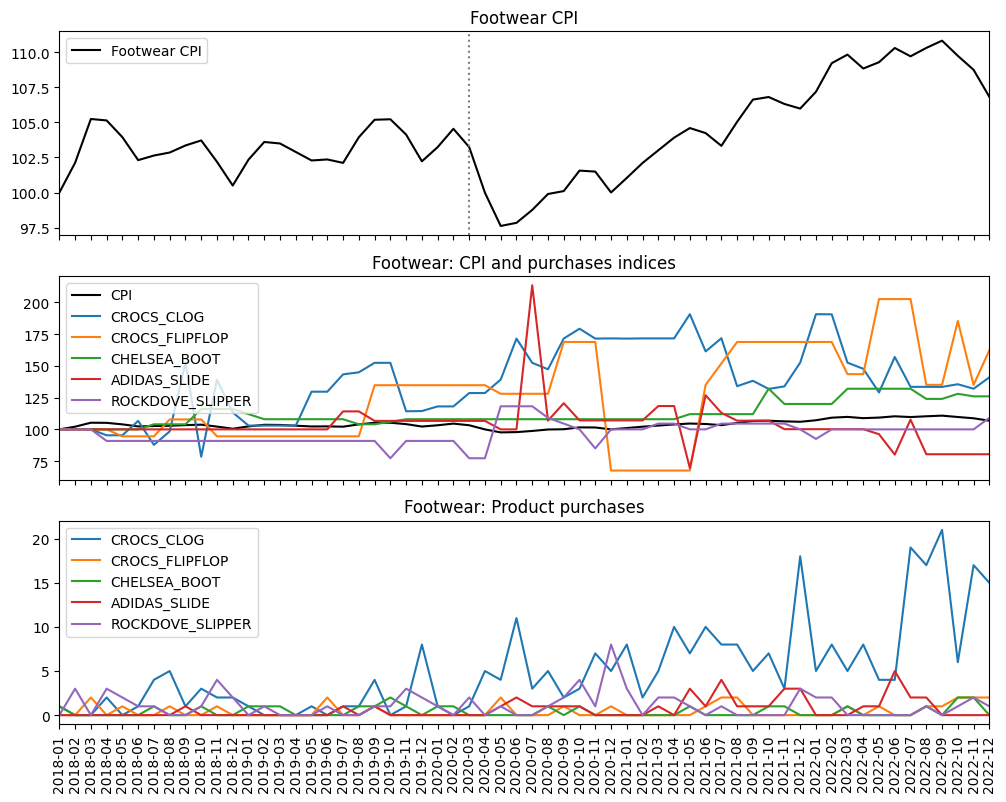

In [76]:
fig, axes = plt.subplots(3,1, figsize=(12, 3*3), sharex=True)

plot_monthly_data(footwear_prices_df['CPI'], ax=axes[0], 
                          title='Footwear CPI',
                          label='Footwear CPI', show_covid=True, color='black')
ax = axes[1]
ax.set_title('Footwear: CPI and purchases indices')
plot_monthly_data(footwear_prices_df['CPI'], ax=ax, label='CPI', color='black')
for p_code in footwear_product_keys:
    plot_monthly_data(footwear_prices_df['%s_idx'%p_code], ax=ax, label=p_code)
# add number of purchases
ax = axes[2]
ax.set_title('Footwear: Product purchases')
for p_code in footwear_product_keys:
    plot_monthly_data(footwear_prices_df['%s_purchases'%p_code], ax=ax, label=p_code)
# add number of purchases

In [77]:
# add in the data shifts
footwear_prices_df['CPI_lag1'] = footwear_prices_df['CPI'].shift(-1)
footwear_prices_df['CPI_lag2'] = footwear_prices_df['CPI'].shift(-2)
# add in the aggregate data
footwear_prices_df['agg_med_price'] = footwear_monthly_prices_med
footwear_prices_df['agg_purchases'] = footwear_monthly_purchases
footwear_prices_df.head(3)

CPI  CROCS_CLOG_med_price  CROCS_CLOG_purchases   
yyyy-mm                                                          
2018-01  100.00000                 26.21                   1.0  \
2018-02  102.12468                   NaN                   0.0   
2018-03  105.24331                   NaN                   0.0   

         CROCS_FLIPFLOP_med_price  CROCS_FLIPFLOP_purchases   
yyyy-mm                                                       
2018-01                       NaN                       0.0  \
2018-02                       NaN                       0.0   
2018-03                      14.8                       2.0   

         CHELSEA_BOOT_med_price  CHELSEA_BOOT_purchases   
yyyy-mm                                                   
2018-01                   24.99                     1.0  \
2018-02                     NaN                     0.0   
2018-03                     NaN                     0.0   

         ADIDAS_SLIDE_med_price  ADIDAS_SLIDE_purchases   
yyyy-mm                                                   
2018-01                     NaN                     0.0  \
2018-02                     NaN                     0.0   
2018-03                     NaN                     0.0   

         ROCKDOVE_SLIPPER_med_price  ...  CHELSEA_BOOT_med_price1   
yyyy-mm                              ...                            
2018-01                         NaN  ...                    24.99  \
2018-02                       21.99  ...                    24.99   
2018-03                         NaN  ...                    24.99   

         CHELSEA_BOOT_idx  ADIDAS_SLIDE_med_price1  ADIDAS_SLIDE_idx   
yyyy-mm                                                                
2018-01             100.0                    18.71             100.0  \
2018-02             100.0                    18.71             100.0   
2018-03             100.0                    18.71             100.0   

         ROCKDOVE_SLIPPER_med_price1  ROCKDOVE_SLIPPER_idx   CPI_lag1   
yyyy-mm                                                                 
2018-01                        21.99                 100.0  102.12468  \
2018-02                        21.99                 100.0  105.24331   
2018-03                        21.99                 100.0  105.13900   

          CPI_lag2  agg_med_price  agg_purchases  
yyyy-mm                                           
2018-01  105.24331         31.490            189  
2018-02  105.13900         35.855            156  
2018-03  103.94779         34.950            205  

[3 rows x 25 columns]

Regression

Notes:

- performs best when using aggregate/unfiltered purchases data + specific items

- performs worse with purchases data
- performs worse with lag

In [78]:
print('Regression with aggregate purchases data and specific items\n')
formula = 'CPI ~ agg_med_price + agg_purchases + '
formula += ' + '.join(['%s_idx' % (pcode) for pcode in footwear_product_keys])
print('Formula:\n%s'%formula)
result = sm.ols(formula=formula, data=footwear_prices_df).fit()
display(result.summary())

Regression with aggregate purchases data and specific items

Formula:
CPI ~ agg_med_price + agg_purchases + CROCS_CLOG_idx + CROCS_FLIPFLOP_idx + CHELSEA_BOOT_idx + ADIDAS_SLIDE_idx + ROCKDOVE_SLIPPER_idx


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     30.70
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           2.47e-16
Time:                        13:20:47   Log-Likelihood:                -106.66
No. Observations:                  60   AIC:                             229.3
Df Residuals:                      52   BIC:                             246.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               79.2064      4.407     17.973      0.000      70.363      88.050
agg_med_price            0.4761      0.071      6.672      0.000       0.333       0.619
agg_purchases            0.0079      0.003      2.605      0.012       0.002       0.014
CROCS_CLOG_idx           0.0006      0.009      0.066      0.947      -0.017       0.018
CROCS_FLIPFLOP_idx       0.0115      0.007      1.606      0.114      -0.003       0.026
CHELSEA_BOOT_idx         0.1340      0.036      3.686      0.001       0.061       0.207
ADIDAS_SLIDE_idx        -0.0331      0.013     -2.626      0.011      -0.058      -0.008
ROCKDOVE_SLIPPER_idx    -0.0724      0.027     -2.700      0.009      -0.126      -0.019
==============================================================================
Omnibus:                        0.216   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.898   Jarque-Bera (JB):                0.054
Skew:                           0.074   Prob(JB):                        0.973
Kurtosis:                       2.997   Cond. No.                     1.02e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
# Same as above, but without the CROCs
print('Regression with aggregate purchases data and specific items\n')
formula = 'CPI ~ agg_med_price + agg_purchases + '
formula += ' + '.join(['%s_idx' % (pcode) for pcode in ['CHELSEA_BOOT', 'ADIDAS_SLIDE', 'ROCKDOVE_SLIPPER']])
print('Formula:\n%s'%formula)
result = sm.ols(formula=formula, data=footwear_prices_df).fit()
display(result.summary())

Regression with aggregate purchases data and specific items

Formula:
CPI ~ agg_med_price + agg_purchases + CHELSEA_BOOT_idx + ADIDAS_SLIDE_idx + ROCKDOVE_SLIPPER_idx


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     42.01
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           1.99e-17
Time:                        13:20:48   Log-Likelihood:                -108.11
No. Observations:                  60   AIC:                             228.2
Df Residuals:                      54   BIC:                             240.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               77.5985      4.193     18.508      0.000      69.193      86.004
agg_med_price            0.4759      0.071      6.739      0.000       0.334       0.617
agg_purchases            0.0086      0.003      3.080      0.003       0.003       0.014
CHELSEA_BOOT_idx         0.1589      0.033      4.827      0.000       0.093       0.225
ADIDAS_SLIDE_idx        -0.0300      0.012     -2.411      0.019      -0.055      -0.005
ROCKDOVE_SLIPPER_idx    -0.0748      0.027     -2.810      0.007      -0.128      -0.021
==============================================================================
Omnibus:                        0.092   Durbin-Watson:                   1.450
Prob(Omnibus):                  0.955   Jarque-Bera (JB):                0.101
Skew:                           0.076   Prob(JB):                        0.951
Kurtosis:                       2.869   Cond. No.                     8.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Compare regression with and without the purchases data -- using prices alone

In [80]:
print('Regression without number of purchases -- using prices alone\n')
formula = 'CPI ~ '
s = ['%s_idx' % (pcode) for pcode in footwear_product_keys]
formula += ' + '.join(s)
print('Formula:\n%s'%formula)
result = sm.ols(formula=formula, data=footwear_prices_df).fit()
display(result.summary())

Regression without number of purchases -- using prices alone

Formula:
CPI ~ CROCS_CLOG_idx + CROCS_FLIPFLOP_idx + CHELSEA_BOOT_idx + ADIDAS_SLIDE_idx + ROCKDOVE_SLIPPER_idx


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     18.72
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           9.56e-11
Time:                        13:20:59   Log-Likelihood:                -125.56
No. Observations:                  60   AIC:                             263.1
Df Residuals:                      54   BIC:                             275.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               87.9063      4.772     18.420      0.000      78.338      97.474
CROCS_CLOG_idx          -0.0057      0.010     -0.551      0.584      -0.027       0.015
CROCS_FLIPFLOP_idx       0.0127      0.010      1.332      0.189      -0.006       0.032
CHELSEA_BOOT_idx         0.2224      0.041      5.481      0.000       0.141       0.304
ADIDAS_SLIDE_idx        -0.0370      0.017     -2.186      0.033      -0.071      -0.003
ROCKDOVE_SLIPPER_idx    -0.0594      0.035     -1.692      0.096      -0.130       0.011
==============================================================================
Omnibus:                        1.196   Durbin-Watson:                   0.780
Prob(Omnibus):                  0.550   Jarque-Bera (JB):                0.976
Skew:                          -0.310   Prob(JB):                        0.614
Kurtosis:                       2.929   Cond. No.                     4.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [81]:
# First try with no lag, then experiment with lags (shift the data)
print('Regression with number of purchases\n')
formula = 'CPI ~ '
s = ['%s_idx * %s_purchases' % (pcode, pcode) for pcode in footwear_product_keys]
formula += ' + '.join(s)
print('Formula:\n%s'%formula)
result = sm.ols(formula=formula, data=footwear_prices_df).fit()
display(result.summary())

Regression with number of purchases

Formula:
CPI ~ CROCS_CLOG_idx * CROCS_CLOG_purchases + CROCS_FLIPFLOP_idx * CROCS_FLIPFLOP_purchases + CHELSEA_BOOT_idx * CHELSEA_BOOT_purchases + ADIDAS_SLIDE_idx * ADIDAS_SLIDE_purchases + ROCKDOVE_SLIPPER_idx * ROCKDOVE_SLIPPER_purchases


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     6.058
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           1.37e-06
Time:                        13:21:03   Log-Likelihood:                -122.12
No. Observations:                  60   AIC:                             276.2
Df Residuals:                      44   BIC:                             309.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                          89.7682      7.639     11.752      0.000      74.373     105.163
CROCS_CLOG_idx                                     -0.0168      0.020     -0.847      0.402      -0.057       0.023
CROCS_CLOG_purchases                               -0.3487      0.526     -0.662      0.511      -1.410       0.712
CROCS_CLOG_idx:CROCS_CLOG_purchases                 0.0034      0.004      0.885      0.381      -0.004       0.011
CROCS_FLIPFLOP_idx                                  0.0130      0.012      1.084      0.284      -0.011       0.037
CROCS_FLIPFLOP_purchases                            0.7813      1.750      0.446      0.657      -2.745       4.308
CROCS_FLIPFLOP_idx:CROCS_FLIPFLOP_purchases        -0.0021      0.013     -0.163      0.871      -0.028       0.024
CHELSEA_BOOT_idx                                    0.1929      0.055      3.538      0.001       0.083       0.303
CHELSEA_BOOT_purchases                             -0.1015      6.112     -0.017      0.987     -12.419      12.216
CHELSEA_BOOT_idx:CHELSEA_BOOT_purchases             0.0056      0.053      0.105      0.917      -0.101       0.113
ADIDAS_SLIDE_idx                                   -0.0019      0.036     -0.052      0.959      -0.075       0.072
ADIDAS_SLIDE_purchases                              1.9400      2.336      0.831      0.411      -2.767       6.648
ADIDAS_SLIDE_idx:ADIDAS_SLIDE_purchases            -0.0208      0.025     -0.847      0.402      -0.070       0.029
ROCKDOVE_SLIPPER_idx                               -0.0747      0.055     -1.364      0.179      -0.185       0.036
ROCKDOVE_SLIPPER_purchases                          1.1714      3.747      0.313      0.756      -6.379       8.722
ROCKDOVE_SLIPPER_idx:ROCKDOVE_SLIPPER_purchases    -0.0146      0.038     -0.381      0.705      -0.092       0.063
==============================================================================
Omnibus:                        3.227   Durbin-Watson:                   0.939
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.387
Skew:                          -0.459   Prob(JB):                        0.303
Kurtosis:                       3.337   Cond. No.                     3.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Are there more helpful products to find?
- e.g. "sneakers"
- e.g. specific branks like "nike", "new balance"

In [82]:
def is_sneakers(title):
    return 'sneaker' in str(title).lower()
sneaker_purchases = amzn_data[
    amzn_data['Title'].apply(is_sneakers)
][['yyyy-mm','Title','ASIN/ISBN (Product Code)','Category','Survey ResponseID','unit price', 'Quantity']]
sneaker_purchases.head()
# amzn_data['Title'].apply(is_sneakers)

yyyy-mm                                              Title   
17  2020-05  Pink Miracle Shoe Cleaner Kit with Bottle and ...  \
78  2020-06  LANCROP Men's Comfortable Walking Shoes - Casu...   
84  2020-06  LANCROP Men's Comfortable Walking Shoes - Casu...   
85  2020-06  WXQ Men's Fashion Sneakers - Lightweight Breat...   
86  2020-06  LANCROP Men's Comfortable Walking Shoes - Casu...   

   ASIN/ISBN (Product Code)           Category  Survey ResponseID  unit price   
17               B00A7NDT3A  FOOTWEAR_CARE_KIT  R_2PpVNZupgA2k9mX       16.97  \
78               B07DD6497W              SHOES  R_3QXUWuTn4OdbNmh       19.99   
84               B07PCN8C8K              SHOES  R_3QXUWuTn4OdbNmh       32.99   
85               B07795Y4LP              SHOES  R_3QXUWuTn4OdbNmh       24.99   
86               B07DD5FF78              SHOES  R_3QXUWuTn4OdbNmh       32.99   

    Quantity  
17       1.0  
78       1.0  
84       1.0  
85       1.0  
86       1.0

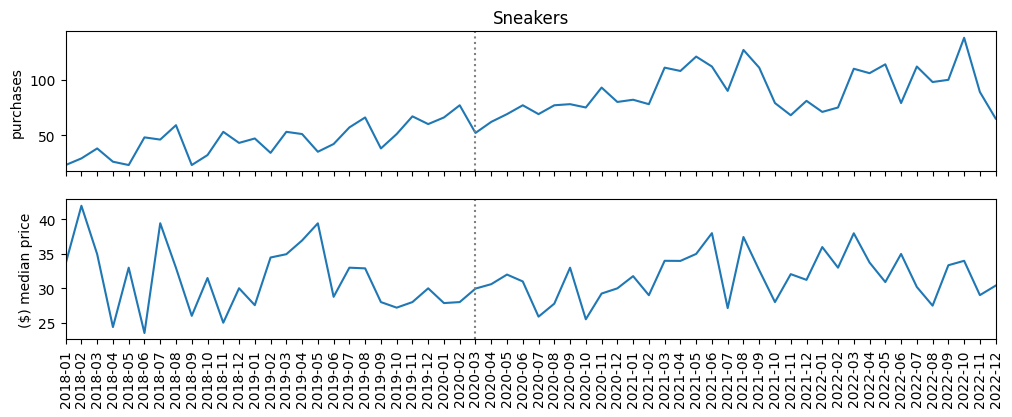

In [84]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(12,2*2),sharex=True)
sneaker_monthly_purchases = sneaker_purchases.groupby(
    'yyyy-mm'
)['Survey ResponseID'].count()
title='Sneakers'
_ = plot_monthly_data(
    sneaker_monthly_purchases, ax=ax0, ylabel='purchases', show_covid=True, title=title,
)
sneaker_monthly_prices_med = sneaker_purchases.groupby(
    'yyyy-mm'
)['unit price'].agg('median')
_ = plot_monthly_data(
    sneaker_monthly_prices_med, ax=ax1, ylabel='($) median price', show_covid=True
)

### Apparel

TODO:

When comparing to CPI, separate by womens + girls vs mens + boys -- there are separate CPIs



In [85]:
cat_apparel = ['SOCKS', 'SHIRT', 'PANTS', 'UNDERPANTS', 'DRESS']

print('apparel:')
_apparel_purchases = get_purchases(cat_apparel)

_apparel_purchases['Category'].value_counts().sort_values(ascending=False)

apparel:
66808 purchases from N=4130 unique customers


Category
SHIRT         26765
PANTS         15554
SOCKS          9968
DRESS          7795
UNDERPANTS     6726
Name: count, dtype: int64

In [86]:
# Explore popular product titles
apparel_min_M = 12 # 5: footwear
_apparel_months = _apparel_purchases.groupby(
    ['ASIN/ISBN (Product Code)']
)['yyyy-mm'].nunique()
display(_apparel_months.describe())
print('Restricting to %s products that have at least %s months of data' %
     (len(_apparel_months[_apparel_months >= apparel_min_M]), apparel_min_M))
_apparel_purchases[_apparel_purchases['ASIN/ISBN (Product Code)'].isin(
    _apparel_months[_apparel_months >= apparel_min_M].index
)].groupby(
    ['Title','ASIN/ISBN (Product Code)','Category']
)['unit price'].agg(['median','count']).sort_values('count', ascending=False).head(60)

count    55949.000000
mean         1.166276
std          0.744707
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         30.000000
Name: yyyy-mm, dtype: float64

Restricting to 34 products that have at least 12 months of data


median   
Title                                              ASIN/ISBN (Product Code) Category             
Dickies Men's Dri-tech Moisture Control Crew So... B004QF0TFQ               SOCKS       13.445  \
                                                   B008M5S09S               SOCKS       14.000   
Dynarex Alcohol Prep Pad Sterile, Medium, 200 c... B005BFL0RQ               SHIRT        4.775   
Fruit of the Loom Mens Essential 6 Pack Casual ... B01MXIE9RT               SOCKS        8.250   
Goodnites Bedwetting Underwear for Boys, Large/... B00U0O56BE               UNDERPANTS  24.940   
Dickies Men's Dri-Tech Moisture Control Quarter... B00AECT1ZE               SOCKS       12.990   
Fruit of the Loom Men's Eversoft Cotton Stay Tu... B00VTV8ISK               SHIRT       14.980   
Jeasona Women's Cat Socks Cute Animal Socks Sun... B075P7R3VN               SOCKS       12.490   
Hanes Men's 6-Pack FreshIQ Odor Control X-Temp ... B013C6J8GK               SOCKS       10.290   
SATINA High Waisted Leggings for Women - Capri ... B074QZXRMN               PANTS       13.990   
Hanes Women's 10-Pair Value Pack Low Cut Socks     B00JVTNWB0               SOCKS       10.970   
SATINA High Waisted Leggings for Women - Capri ... B074R27W46               PANTS       13.990   
Gold Toe Men's 656s Cotton Crew Athletic Socks,... B0002TOZ1O               SOCKS       15.990   
Gildan Men's Crew T-Shirts, Multipack, Style G1100 B011QQE1HE               SHIRT       14.000   
Dickies Men's Dri-Tech Moisture Control Quarter... B07926CYY8               SOCKS       12.990   
Colorfulkoala Women's High Waisted Yoga Pants 7... B07G55R2LB               PANTS       25.000   
Saucony Women's Performance Heel Tab Athletic S... B06XBT1R3S               SOCKS       14.990   
Hanes Women's 10-Pair Value Pack Crew Socks        B00HVWSQG0               SOCKS       10.970   
Fruit of the Loom mens 12 Pair Pack Dual Defens... B07VF6N878               SOCKS       11.970   
Hanes Men's Double Tough Crew Socks, 12-pair Pack  B00MDZWPEO               SOCKS       13.460   
Pull-Ups Boys' Potty Training Pants, 4T-5T (38-... B07XCVX9B1               UNDERPANTS  45.760   
Spalding Women's Bootleg Yoga Pant                 B005GYGFZY               PANTS       18.990   
Women Thigh High Socks Extra Long Cotton Knit W... B074TDRF5B               SOCKS        9.980   
Hanes Men's Cotton Tank Undershirts Pack, Moist... B00CAXQV3K               SHIRT       15.970   
thorlos mens Wlst Max Cushion Safety Steel Toe ... B0015AU0FE               SOCKS       14.500   
Gold Toe Men's 656p Cotton Quarter Athletic Soc... B000SP6UVK               SOCKS       15.990   
Gildan Men's Crew T-Shirts, Multipack, Style G1100 B077ZMKWVM               SHIRT       15.500   
Fruit of the Loom mens Cushioned Durable Cotton... B0735T525V               SOCKS       12.340   
3 Pack Copper Compression Socks - Compression S... B074MW1MTW               SOCKS       13.990   
Hanes Women's Bikini Panties Pack, Moisture-Wic... B00FZR1FES               UNDERPANTS  15.470   
Hanes Men's Socks, Max Cushioned Crew Socks, Av... B01FRBTPHK               SOCKS       10.980   
Hanes mens Men's Performance No Show Socks, 6-p... B019OAO3KO               SOCKS        9.450   
Hanes Men's Max Cushion Crew Socks, Available i... B01FRBTPHK               SOCKS        9.980   
Saucony mens Multi-pack Mesh Ventilating Comfor... B01D2GRTIE               SOCKS       13.990   
Gildan Men's Underwear Boxer Briefs, Multipack     B077ZNDNGS               UNDERPANTS  12.885   
Saucony Men's Multi-Pack Mesh Ventilating Comfo... B01D2GRTIE               SOCKS       13.990   
Gildan Men's Boxer Briefs, Multipack               B077ZNDNGS               UNDERPANTS  15.230   
Hanes Men's ComfortBlend 6-Pack Cushioned Casua... B00MDZWPEO               SOCKS       14.980   
Hanes mens Hanes Men's Performance No Show Sock... B019OAO3KO               SOCKS        9.670   
Hanes Women's Panties 10 Pack, Moisture-Wicking... B00FZR1FES         

## Explore: 
What are the most commonly purchased items / categories? And do they align well with CPI categories?

In [87]:
amzn_data['Category'].value_counts().sort_values(ascending=False).head(50)

Category
ABIS_BOOK                           86265
PET_FOOD                            37315
GIFT_CARD                           27341
SHIRT                               26765
NUTRITIONAL_SUPPLEMENT              26137
ELECTRONIC_CABLE                    17895
HEALTH_PERSONAL_CARE                16358
MEDICATION                          15648
PANTS                               15554
CELLULAR_PHONE_CASE                 15044
SKIN_MOISTURIZER                    13305
SHOES                               12441
FOOD                                12032
GROCERY                             11978
VEGETABLE                           11727
TOYS_AND_GAMES                      11451
TOY_FIGURE                          11311
HEADPHONES                          11176
SKIN_CLEANING_AGENT                 11100
PET_SUPPLIES                        10731
VITAMIN                             10614
COFFEE                              10469
CLEANING_AGENT                      10320
BATTERY                  

In [88]:
print('HEALTH_PERSONAL_CARE')
HEALTH_PERSONAL_CARE_purchases = get_purchases(['HEALTH_PERSONAL_CARE'])
HEALTH_PERSONAL_CARE_purchases.groupby('Title')['yyyy-mm'].agg(
    ['nunique','count']
).sort_values('count', ascending=False).head(10)

HEALTH_PERSONAL_CARE
16358 purchases from N=3186 unique customers


nunique  count
Title                                                             
Amazon Basic Care Sleep Aid Tablets, Doxylamine...       52    173
Tide PODS Laundry Detergent Soap Pods, Spring M...       56    131
Swiffer Sweeper Wet Mopping Cloth Multi Surface...       44    114
23andMe Health + Ancestry Service: Personal Gen...       28     97
Reynolds Wrap Aluminum Foil, 75 Square Feet              31     88
Atkins Gluten Free Protein-Rich Shake, Milk Cho...       41     79
Debrox Earwax Removal Aid, 0.5 oz Earwax Remova...       40     78
Nature Made Melatonin 3 mg Tablets, Dietary Sup...       35     62
Sparkle Paper Towels, 6 Giant Rolls = 9 Regular...       18     61
Wool Dryer Balls - Smart Sheep 6-Pack - XL Prem...       37     61

In [89]:
print('SKIN_MOISTURIZER')
SKIN_MOISTURIZER_purchases = get_purchases(['SKIN_MOISTURIZER'])
SKIN_MOISTURIZER_purchases.groupby('Title')['yyyy-mm'].agg(
    ['nunique','count']
).sort_values('count', ascending=False).head(10)

SKIN_MOISTURIZER
13305 purchases from N=2660 unique customers


nunique  count
Title                                                             
Neutrogena Hydro Boost Face Moisturizer with Hy...       51    169
CeraVe Moisturizing Cream | Body and Face Moist...       50    158
CeraVe AM Facial Moisturizing Lotion SPF 30 | O...       41    108
CeraVe Daily Moisturizing Lotion for Dry Skin |...       44    102
Neutrogena Hydro Boost Face Moisturizer with Hy...       40     94
H2Ocean Piercing Aftercare Spray, Sea Salt Kelo...       41     88
Vanicream Moisturizing Skin Cream with Pump Dis...       40     83
Aveeno Daily Moisturizing Body Lotion with Soot...       44     76
Avarelle Pimple Patches (40 Count) Hydrocolloid...       39     76
LilyAna Naturals Retinol Cream for Face - Made ...       37     66

### Food? 

Too many types of items?

TODO:
- try this using more specific CPI categories
    - fruits and vegetables
    - coffee
    - etc
- try with aggregate CPI index: Food at home



In [90]:
food_categories = [
    'FOOD','GROCERY',
    'VEGETABLE','FRUIT', 
    'COFFEE', 'TEA', 'DRINK_FLAVORED',
    'SNACK_FOOD_BAR', 'SNACK_CHIP_AND_CRISP',
    'SUGAR_CANDY',
]
food_purchases = get_purchases(food_categories)
food_purchases.head(3)

89325 purchases from N=3511 unique customers


yyyy-mm                                              Title   
48  2020-05  Napoleon Candy | Napoleon Black & White Balls ...  \
13  2019-12  200g Dahongpao Oolong Tea Wuyi Rock Tea Strong...   
8   2018-02  Dongwon Yangban Crispy Layered Seaweed Snack w...   

   ASIN/ISBN (Product Code)        Category  Survey ResponseID  unit price   
48               B07V9PFHB1     SUGAR_CANDY  R_3I9Pu8iauEcOx9A        8.99  \
13               B00CQF2TIS             TEA  R_7UtikIBqeQHvnyN       15.98   
8                B01HNGJ4C8  SNACK_FOOD_BAR  R_1Nnv2IYQFpUwHrr       14.99   

    Quantity  
48       1.0  
13       1.0  
8        1.0

### Vegetable?

Very few purchases overall.

Also there are few CPI category data series available -- more so just PPI which is more volatile.

This is not going to work

In [91]:
vegetable_purchases = get_purchases(['VEGETABLE'], year=True)
vegetable_purchases[['year','yyyy-mm','Title', 'unit price']].head()

11727 purchases from N=746 unique customers


year  yyyy-mm                                              Title   
195  2020  2020-07      Idahoan Mashed Potatoes, Roasted Garlic, 4 oz  \
66   2022  2022-11                                     Organic Garlic   
51   2021  2021-03   CJ Premium Roasted Seaweed Snack 5g -(Pack of 8)   
56   2021  2021-04  KIMNORI Seasoned Seaweed Snacks Sheets – Organ...   
58   2021  2021-06  KIMNORI Seasoned Seaweed Snacks Sheets – Organ...   

     unit price  
195        0.99  
66         2.59  
51         6.98  
56        12.95  
58        12.95

There is an aggregate fruits and vegetables CPI computed annually.

But that won't work since the items within changed so much the prices changed....


In [92]:
vegetable_monthly = vegetable_purchases.groupby(
    'year'
)['unit price'].agg(['median', 'count'])
vegetable_monthly.head()

median  count
year               
2018   2.635    126
2019   2.490    506
2020   1.990   3516
2021   2.000   4226
2022   2.390   3353

In [93]:
# What are the most common vegetables purchsed?
vegetable_purchases.groupby('Title')['unit price'].agg(
    ['median','count']
).sort_values('count', ascending=False).head(10)

median  count
Title                                                            
Cucumber Slicing                                     0.690    264
Yellow Onion                                         0.680    233
Green Bell Pepper                                    0.890    195
Fresh Brand – Cut and Peeled Baby Carrots, 16 oz     1.190    183
365 by Whole Foods Market, Organic Baby Spinach...   1.990    180
Red Onion                                            0.890    162
Asparagus, 1 Bunch                                   3.790    143
Fresh Brand – Russet Potatoes, 5 lb                  2.990    139
Onion Yellow Conventional, 1 Each                    0.850    127
Organic Garlic                                       0.995    118

Potential categories

Cucumbers are a CPI category... discontinued in 2000

Yellow onions CPI category discontinued in 90's.

Carrots
- must watch out for the Gerber baby food
- carrots for avg price for CPI discontinued
- but there is an up to date PPI


Peppers!
- Average Price: Peppers, Sweet (Cost per Pound/453.6 Grams) in U.S. City Average (APU0000712406)
- discontinued in 2020-03
- Not enough months of pepper purchases

White potatoes? They are in the CPI data
- we don't have many potatoes in the purchases data

Spinach? 
- only PPI data is available and it is too volatile


In [94]:
def is_spinach(row):
    category = str(row['Category'])
    if category not in ['GROCERY','nan','VEGETABLE','FOOD']:
        return False
    title = str(row['Title']).lower()
    if not ('spinach' in title):
        return False
    return True

spinach_purchases = amzn_data[amzn_data.apply(is_spinach, axis=1)][['yyyy-mm','Title','Category','unit price', 'Survey ResponseID', 'ASIN/ISBN (Product Code)']]
print('%s spinach purchases from N=%s unique customers' % 
      (len(spinach_purchases), spinach_purchases['Survey ResponseID'].nunique()))
spinach_purchases[['Title','Category','unit price']].head(3)

858 spinach purchases from N=243 unique customers


Title   Category  unit price
446  365 by Whole Foods Market, Organic Baby Spinac...    GROCERY        2.29
119  365 by Whole Foods Market, Organic 50-50 Blend...  VEGETABLE        3.49
247  Kite Hill Spinach and Almond Milk Ricotta Ravi...       FOOD        3.96

In [95]:
spinach_monthly_purchases = spinach_purchases.groupby(
    ['Title','ASIN/ISBN (Product Code)']
)['yyyy-mm'].agg(['count','nunique']).sort_values('count', ascending=False)
display(spinach_monthly_purchases.head(10))
spinach_purchases.groupby(
    ['Title','ASIN/ISBN (Product Code)']
)['unit price'].agg(['count','median']).sort_values('count', ascending=False).head(10)

count   
Title                                              ASIN/ISBN (Product Code)          
365 by Whole Foods Market, Organic Baby Spinach... B074H4WRNG                  180  \
365 Everyday Value, Organic Baby Spinach, 5 oz     B074H4WRNG                   47   
365 by Whole Foods Market, Organic Baby Spinach... B082FJNKJV                   43   
365 by Whole Foods Market, Organic Baby Spinach... B074H55NJK                   38   
Peter Rabbit Organics, Pea, Spinach and Apple P... B0044CZ63G                   33   
Taylor Farms Spinach, 9 oz Bag                     B00KMM8I6Y                   30   
365 by Whole Foods Market, Salad Clm Spinach Or... B074H54XMM                   27   
365 by Whole Foods Market, Organic 50-50 Blend,... B074H64BRP                   24   
Taylor Farms Baby Spinach, 6 oz Bag                B00KMM8CS8                   23   
Amazon Brand - Happy Belly Spinach, Chopped, 12... B07WJGM6SW                   22   

                                                                             nunique  
Title                                              ASIN/ISBN (Product Code)           
365 by Whole Foods Market, Organic Baby Spinach... B074H4WRNG                     44  
365 Everyday Value, Organic Baby Spinach, 5 oz     B074H4WRNG                     26  
365 by Whole Foods Market, Organic Baby Spinach... B082FJNKJV                     25  
365 by Whole Foods Market, Organic Baby Spinach... B074H55NJK                     16  
Peter Rabbit Organics, Pea, Spinach and Apple P... B0044CZ63G                     32  
Taylor Farms Spinach, 9 oz Bag                     B00KMM8I6Y                     17  
365 by Whole Foods Market, Salad Clm Spinach Or... B074H54XMM                     18  
365 by Whole Foods Market, Organic 50-50 Blend,... B074H64BRP                     17  
Taylor Farms Baby Spinach, 6 oz Bag                B00KMM8CS8                     14  
Amazon Brand - Happy Belly Spinach, Chopped, 12... B07WJGM6SW                     13

count   
Title                                              ASIN/ISBN (Product Code)          
365 by Whole Foods Market, Organic Baby Spinach... B074H4WRNG                  180  \
365 Everyday Value, Organic Baby Spinach, 5 oz     B074H4WRNG                   47   
365 by Whole Foods Market, Organic Baby Spinach... B082FJNKJV                   43   
365 by Whole Foods Market, Organic Baby Spinach... B074H55NJK                   38   
Peter Rabbit Organics, Pea, Spinach and Apple P... B0044CZ63G                   33   
Taylor Farms Spinach, 9 oz Bag                     B00KMM8I6Y                   30   
365 by Whole Foods Market, Salad Clm Spinach Or... B074H54XMM                   27   
365 by Whole Foods Market, Organic 50-50 Blend,... B074H64BRP                   24   
Taylor Farms Baby Spinach, 6 oz Bag                B00KMM8CS8                   23   
Amazon Brand - Happy Belly Spinach, Chopped, 12... B07WJGM6SW                   22   

                                                                             median  
Title                                              ASIN/ISBN (Product Code)          
365 by Whole Foods Market, Organic Baby Spinach... B074H4WRNG                  1.99  
365 Everyday Value, Organic Baby Spinach, 5 oz     B074H4WRNG                  1.99  
365 by Whole Foods Market, Organic Baby Spinach... B082FJNKJV                  1.99  
365 by Whole Foods Market, Organic Baby Spinach... B074H55NJK                  4.99  
Peter Rabbit Organics, Pea, Spinach and Apple P... B0044CZ63G                 15.94  
Taylor Farms Spinach, 9 oz Bag                     B00KMM8I6Y                  1.99  
365 by Whole Foods Market, Salad Clm Spinach Or... B074H54XMM                  4.99  
365 by Whole Foods Market, Organic 50-50 Blend,... B074H64BRP                  5.24  
Taylor Farms Baby Spinach, 6 oz Bag                B00KMM8CS8                  1.89  
Amazon Brand - Happy Belly Spinach, Chopped, 12... B07WJGM6SW                  1.39

The first 3 spinach products are clearly the same product. The first 2 are the same product code.

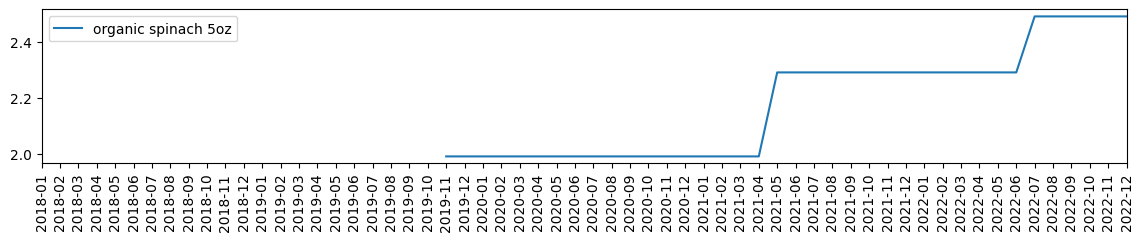

In [96]:
org_spinach_5oz_codes = ['B074H4WRNG', 'B082FJNKJV']
spinach = amzn_data[
    amzn_data['ASIN/ISBN (Product Code)'].isin(org_spinach_5oz_codes)
].groupby(['yyyy-mm'])['unit price'].agg(['median','count']).reindex(amzn_data_idx)

ax = plot_monthly_data(spinach['median'], label='organic spinach 5oz')

In [97]:
def is_potatoe(row):
    category = str(row['Category'])
    if category not in ['GROCERY','nan','VEGETABLE','FOOD']:
        return False
    title = str(row['Title']).lower()
    if not ('potatoe' in title):
        return False
    return True

potatoe_purchases = amzn_data[amzn_data.apply(is_potatoe, axis=1)][['yyyy-mm','Title','Category','unit price', 'Survey ResponseID', 'ASIN/ISBN (Product Code)']]
print('%s potatoe purchases from N=%s unique customers' % 
      (len(potatoe_purchases), potatoe_purchases['Survey ResponseID'].nunique()))
potatoe_purchases[['Title','Category','unit price']].head(3)

1292 potatoe purchases from N=372 unique customers


Title   Category  unit price
195      Idahoan Mashed Potatoes, Roasted Garlic, 4 oz  VEGETABLE        0.99
579                   Fresh Brand – Red Potatoes, 5 lb  VEGETABLE        3.99
562  HORMEL COMPLEATS Meatloaf & Gravy With Mashed ...       FOOD       13.44

In [100]:
potatoe_monthly_purchases = potatoe_purchases.groupby(['Title','ASIN/ISBN (Product Code)'])['yyyy-mm'].agg(
    ['count','nunique']
).sort_values('count',ascending=False).reset_index()
# grab the codes for products with threshold of 15 months of data
potatoe_15m_codes = potatoe_monthly_purchases[potatoe_monthly_purchases['nunique']>=15]['ASIN/ISBN (Product Code)']
print('%s potatoe products with at least 15 months of data' % len(potatoe_15m_codes))
potatoe_monthly_purchases.head(10)

11 potatoe products with at least 15 months of data


Title ASIN/ISBN (Product Code)   
0                Fresh Brand – Russet Potatoes, 5 lb               B07XW1TNXZ  \
1      Idahoan Mashed Potatoes, Roasted Garlic, 4 oz               B0014E4G42   
2  Idahoan Mashed Potatoes, Buttery Homestyle, 4-...               B00SH4NJH2   
3  365 by Whole Foods Market, Potatoes Hashbrowns...               B074H67ZXS   
4                      Organic Garnet Sweet Potatoes               B0787VSLKL   
5                  Fresh Brand – Gold Potatoes, 5 lb               B07XW1GNZL   
6                   Fresh Brand – Red Potatoes, 5 lb               B07XW1MJCZ   
7  HORMEL COMPLEATS Chicken Breast & Mashed Potat...               B004PEET4K   
8  HORMEL COMPLEATS Meatloaf & Gravy With Mashed ...               B000V1JVAI   
9  Idahoan Buttery Homestyle Mashed Potatoes, Mad...               B01JLWGOP2   

   count  nunique  
0    139       26  
1     54       33  
2     53       19  
3     37       25  
4     35       19  
5     32       16  
6     30       18  
7     27       17  
8     25       18  
9     24       20

In [101]:
potatoe_purchases.groupby(['Title','ASIN/ISBN (Product Code)'])['unit price'].agg(
    ['count','median']
).sort_values('count',ascending=False).head(10)

count   
Title                                              ASIN/ISBN (Product Code)          
Fresh Brand – Russet Potatoes, 5 lb                B07XW1TNXZ                  139  \
Idahoan Mashed Potatoes, Roasted Garlic, 4 oz      B0014E4G42                   54   
Idahoan Mashed Potatoes, Buttery Homestyle, 4-O... B00SH4NJH2                   53   
365 by Whole Foods Market, Potatoes Hashbrowns ... B074H67ZXS                   37   
Organic Garnet Sweet Potatoes                      B0787VSLKL                   35   
Fresh Brand – Gold Potatoes, 5 lb                  B07XW1GNZL                   32   
Fresh Brand – Red Potatoes, 5 lb                   B07XW1MJCZ                   30   
HORMEL COMPLEATS Chicken Breast & Mashed Potato... B004PEET4K                   27   
HORMEL COMPLEATS Meatloaf & Gravy With Mashed P... B000V1JVAI                   25   
Idahoan Buttery Homestyle Mashed Potatoes, Made... B01JLWGOP2                   24   

                                                                             median  
Title                                              ASIN/ISBN (Product Code)          
Fresh Brand – Russet Potatoes, 5 lb                B07XW1TNXZ                 2.990  
Idahoan Mashed Potatoes, Roasted Garlic, 4 oz      B0014E4G42                 0.995  
Idahoan Mashed Potatoes, Buttery Homestyle, 4-O... B00SH4NJH2                 0.990  
365 by Whole Foods Market, Potatoes Hashbrowns ... B074H67ZXS                 1.990  
Organic Garnet Sweet Potatoes                      B0787VSLKL                 3.100  
Fresh Brand – Gold Potatoes, 5 lb                  B07XW1GNZL                 4.025  
Fresh Brand – Red Potatoes, 5 lb                   B07XW1MJCZ                 4.640  
HORMEL COMPLEATS Chicken Breast & Mashed Potato... B004PEET4K                11.880  
HORMEL COMPLEATS Meatloaf & Gravy With Mashed P... B000V1JVAI                11.880  
Idahoan Buttery Homestyle Mashed Potatoes, Made... B01JLWGOP2                 9.700

median  count
yyyy-mm               
2018-01     NaN    NaN
2018-02     NaN    NaN
2018-03     NaN    NaN
2018-04     NaN    NaN
2018-05    1.19    1.0

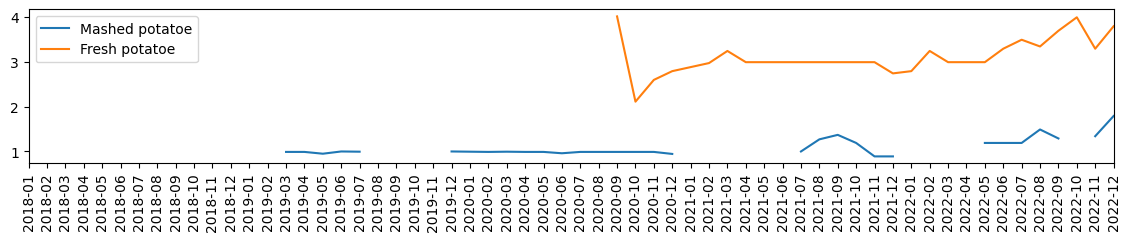

In [102]:
mashed_potatoe_codes = ['B0014E4G42','B00SH4NJH2']
fresh_potatoe_codes = ['B07XW1TNXZ', 'B0787VSLKL', 'B07XW1MJCZ']

mashed_potatoe = amzn_data[
    amzn_data['ASIN/ISBN (Product Code)'].isin(mashed_potatoe_codes)
].groupby(['yyyy-mm'])['unit price'].agg(['median','count']).reindex(amzn_data_idx)
fresh_potatoe = amzn_data[
    amzn_data['ASIN/ISBN (Product Code)'].isin(fresh_potatoe_codes)
].groupby(['yyyy-mm'])['unit price'].agg(['median','count']).reindex(amzn_data_idx)

agg_potatoe = potatoe_purchases[
    potatoe_purchases['ASIN/ISBN (Product Code)'].isin(potatoe_15m_codes)
].groupby(['yyyy-mm'])['unit price'].agg(['median','count']).reindex(amzn_data_idx)

ax = plot_monthly_data(mashed_potatoe['median'], label='Mashed potatoe')
ax = plot_monthly_data(fresh_potatoe['median'], label='Fresh potatoe', ax=ax)
# ax = plot_monthly_data(agg_potatoe['median'], label='Aggregate potatoe', ax=ax)
mashed_potatoe.head()

In [103]:
def is_carrot(row):
    category = str(row['Category'])
    if category not in ['GROCERY','nan','VEGETABLE','FOOD']:
        return False
    title = str(row['Title']).lower()
    if ('gerber' in title) or ('baby' in title):
        return False
    if ('purple carrot' in title):
        return False
    if not ('carrot' in title):# or ('' in title):
        return False
    return True

carrot_purchases = amzn_data[amzn_data.apply(is_carrot, axis=1)][['yyyy-mm','Title','Category','unit price', 'Survey ResponseID', 'ASIN/ISBN (Product Code)']]
print('%s carrot from N=%s unique customers' % 
      (len(carrot_purchases), carrot_purchases['Survey ResponseID'].nunique()))
carrot_purchases[['Title','Category','unit price']].head()

545 carrot from N=200 unique customers


Title   Category  unit price
483    365 Everday Value, Carrot Bag Organic, 32 Ounce  VEGETABLE        1.99
555                 Fresh Brand – Whole Carrots, 16 oz    GROCERY        0.99
560                 Fresh Brand – Whole Carrots, 16 oz    GROCERY        0.99
67   365 by Whole Foods Market, Organic Shredded Ca...    GROCERY        2.49
290            Fresh Brand – Carrots and Celery, 15 oz  VEGETABLE        3.20

In [104]:
carrot_purchases.groupby('Title')['yyyy-mm'].agg(
    ['count','nunique']
).sort_values('count',ascending=False).head(10)

count  nunique
Title                                                             
365 by Whole Foods Market, Organic Carrots, 1 l...     56       26
Fresh Brand – Whole Carrots, 16 oz                     50       25
Carrot Organic                                         37       24
Amazon Brand - Happy Belly Frozen Peas And Carr...     36       17
365 by Whole Foods Market, Carrot Petite Peeled...     27       19
365 by Whole Foods Market, Carrot Cello Organic...     27       10
365 by Whole Foods Market, Organic Shredded Car...     22       18
Urban Roots, Vegetable Mix Carrot Celery Sticks...     16       11
Cascadian Farm Organic Root Vegetable Hash Brow...     16       14
Fresh Brand – Carrots and Celery, 15 oz                13       10

In [105]:
carrot_purchases.groupby(['Title','ASIN/ISBN (Product Code)'])['unit price'].agg(
    ['count','median']
).sort_values('count',ascending=False).head()

count   
Title                                              ASIN/ISBN (Product Code)          
365 by Whole Foods Market, Organic Carrots, 1 l... B00E3JELZ4                   56  \
Fresh Brand – Whole Carrots, 16 oz                 B07XLV61C9                   50   
Carrot Organic                                     B0787W8T3R                   37   
Amazon Brand - Happy Belly Frozen Peas And Carr... B07WSD8QPR                   36   
365 by Whole Foods Market, Carrot Cello Organic... B07FYCJXSY                   27   

                                                                             median  
Title                                              ASIN/ISBN (Product Code)          
365 by Whole Foods Market, Organic Carrots, 1 l... B00E3JELZ4                  0.99  
Fresh Brand – Whole Carrots, 16 oz                 B07XLV61C9                  0.99  
Carrot Organic                                     B0787W8T3R                  1.00  
Amazon Brand - Happy Belly Frozen Peas And Carr... B07WSD8QPR                  0.99  
365 by Whole Foods Market, Carrot Cello Organic... B07FYCJXSY                  1.99

Top 2 carrot items are 1 lb (=16oz) since they share a median price and can likely be aggregated.

Last B0787W8T3R: This is actually 8oz


TODO: line this up with carrot PPI

median  count
yyyy-mm               
2018-01     NaN    NaN
2018-02     NaN    NaN
2018-03     NaN    NaN
2018-04     NaN    NaN
2018-05    0.99    1.0

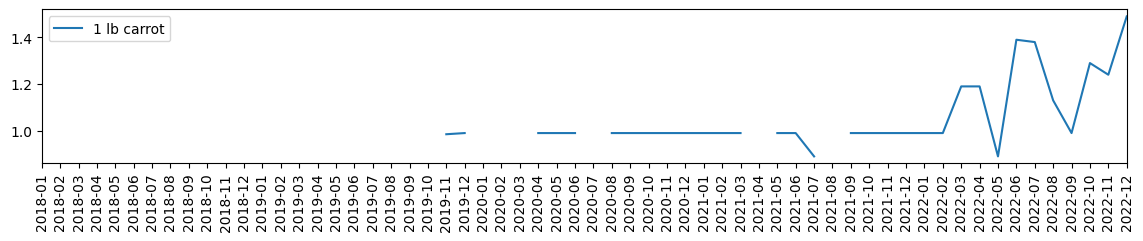

In [107]:
# track the popular carrots -- I looked through the list above to pull these out
# 1 lb carrots
carrot_1lb_codes = ['B00E3JELZ4', 'B07XLV61C9']
# organic 1 bunch of carrots
# carrot_org_1bunch_codes = ['B07FZFGF16', 'B000P6G0EO'] -- not enough months of purchases
carrot_11b = amzn_data[
    amzn_data['ASIN/ISBN (Product Code)'].isin(carrot_1lb_codes)
].groupby(['yyyy-mm'])['unit price'].agg(['median','count']).reindex(amzn_data_idx)
ax = plot_monthly_data(carrot_11b['median'], label='1 lb carrot')
carrot_11b.head()

In [108]:
def is_pepper(row):
    category = str(row['Category'])
    if category not in ['GROCERY','nan','VEGETABLE','FOOD']:
        return False
    title = str(row['Title']).lower()
    if not ('bell pepper' in title) or ('sweet pepper' in title):
        return False
    return True

pepper_purchases = amzn_data[amzn_data.apply(is_pepper, axis=1)][['yyyy-mm','Title','ASIN/ISBN (Product Code)','Category','Survey ResponseID','unit price', 'Quantity']]
print('%s purchases from N=%s unique customers' % 
      (len(pepper_purchases), pepper_purchases['Survey ResponseID'].nunique()))
pepper_purchases.head()

659 purchases from N=171 unique customers


yyyy-mm                                     Title   
334  2020-04  OPPY Organic Red Bell Peppers 2lb, 32 OZ  \
490  2021-04         Green Bell Pepper Organic, 1 Each   
640  2021-10                 Organic Green Bell Pepper   
483  2021-10                           Red Bell Pepper   
606  2022-03                         Green Bell Pepper   

    ASIN/ISBN (Product Code)   Category  Survey ResponseID  unit price   
334               B0787W7P34    GROCERY  R_xz4CILOTENgOtKp        4.99  \
490               B07QYB5JNX  VEGETABLE  R_3eehQVQNcKmEJtd        6.18   
640               B000P6J14K  VEGETABLE  R_3eehQVQNcKmEJtd        6.72   
483               B000P6L42C  VEGETABLE  R_1mzxeFCZSlcG18B        1.19   
606               B001PLESVU  VEGETABLE  R_1mzxeFCZSlcG18B        0.79   

     Quantity  
334       1.0  
490       1.0  
640       1.0  
483       2.0  
606       2.0

In [109]:
peppers_monthly = pepper_purchases.groupby(
    'yyyy-mm'
)['unit price'].agg(['median', 'count'])
# cut the. data to when CPI data available
peppers_monthly = peppers_monthly.loc[:'2020-03']
# peppers_monthly